<a href="https://colab.research.google.com/github/jamessutton600613-png/GC/blob/main/Untitled295.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np

# =========================
# 1) Geometry / moiré field
# =========================

def rot(theta):
    c, s = np.cos(theta), np.sin(theta)
    return np.array([[c, -s],
                     [s,  c]])

def graphene_realspace_basis(a=1.0):
    # Graphene/hBN triangular Bravais lattice basis (not the honeycomb basis).
    # a here is the lattice constant of the triangular Bravais lattice.
    a1 = a * np.array([1.0, 0.0])
    a2 = a * np.array([0.5, np.sqrt(3)/2])
    return a1, a2

def reciprocal_basis(a1, a2):
    # 2D reciprocal basis: b_i · a_j = 2π δ_ij
    A = np.column_stack([a1, a2])  # 2x2
    B = 2*np.pi * np.linalg.inv(A).T
    b1 = B[:, 0]
    b2 = B[:, 1]
    return b1, b2

def moire_reciprocal_vectors(a_g=1.0, delta=0.018, theta=np.deg2rad(1.1)):
    # graphene lattice const a_g; hBN lattice const a_h = (1+delta)*a_g
    a1g, a2g = graphene_realspace_basis(a=a_g)
    b1g, b2g = reciprocal_basis(a1g, a2g)

    a_h = (1.0 + delta) * a_g
    a1h, a2h = graphene_realspace_basis(a=a_h)
    b1h, b2h = reciprocal_basis(a1h, a2h)

    # Rotate hBN reciprocal lattice by theta relative to graphene
    R = rot(theta)
    b1h_r = R @ b1h
    b2h_r = R @ b2h

    # Moiré reciprocal vectors are differences
    g1 = b1g - b1h_r
    g2 = b2g - b2h_r
    g3 = -(g1 + g2)
    return g1, g2, g3

def moire_potential(r, t, gvecs, V0=1.0, omega=1.0, phase0=0.0):
    """
    Scalar moiré field V(r,t) = V0 * Σ cos(g_i · r + ω t + phase0)
    """
    phi = omega*t + phase0
    return V0 * sum(np.cos(g @ r + phi) for g in gvecs)

# =========================
# 2) Build a finite lattice
# =========================

def temporal_reachability_one_hop(adj_all, source):
    """
    Time-respecting reachability with ONE hop per time step.
    Prevents instantaneous saturation and preserves AOI ordering effects.
    """
    reached = {source}
    reached_over_time = []

    for adj in adj_all:
        new_reached = set(reached)
        for u in reached:
            for v in adj[u]:
                new_reached.add(v)
        reached = new_reached
        reached_over_time.append(len(reached))

    return np.array(reached_over_time, dtype=float)
# i: temporal reachability (AOI-preserving, one-hop-per-step)

def triangular_lattice_points(Nx=25, Ny=25, a=1.0):
    a1, a2 = graphene_realspace_basis(a=a)
    pts = []
    idx = {}
    k = 0
    for i in range(Nx):
        for j in range(Ny):
            r = i*a1 + j*a2
            pts.append(r)
            idx[(i, j)] = k
            k += 1
    pts = np.array(pts)
    return pts, idx

def triangular_neighbors(Nx, Ny):
    # Nearest neighbors on triangular Bravais lattice in (i,j) coordinates:
    # (i+1,j), (i,j+1), (i-1,j+1) plus the symmetric negatives handled later
    dirs = [(1,0), (0,1), (-1,1)]
    edges = []
    for i in range(Nx):
        for j in range(Ny):
            for di, dj in dirs:
                ii, jj = i+di, j+dj
                if 0 <= ii < Nx and 0 <= jj < Ny:
                    edges.append(((i,j), (ii,jj)))
    return edges

# =========================
# 3) Temporal gating model
# =========================

def sigmoid(kappa, x):
    z = np.clip(kappa * x, -60.0, 60.0)
    return 1.0 / (1.0 + np.exp(-z))

def gate_openness(V_mid, kind="charge", kappa=2.0, Vc=0.0):
    """
    Gate openness in [0,1] as a smooth threshold on local V.
    Different (kappa, Vc) for charge vs heat gives decoupling.
    """
    # Logistic: open when V_mid > Vc (flipped logic: increasing Vc closes edges)
    x = (V_mid - Vc)
    return sigmoid(kappa, x)

def build_temporal_edge_weights(pts, edges_ij, idx, gvecs,
                                times, V0=1.0, omega=1.0,
                                kind="charge", kappa=2.0, Vc=0.0):
    """
    Returns a list of adjacency lists per time step:
      adj[t][u] = list of v reachable from u at time t (undirected)
    An edge is "available" at time t if gate_openness(midpoint) > u ~ U(0,1).
    """
    # Precompute edge endpoints + midpoints once
    edge_u = []
    edge_v = []
    midpoints = []
    for (aij, bij) in edges_ij:
        u = idx[aij]
        v = idx[bij]
        edge_u.append(u)
        edge_v.append(v)
        midpoints.append(0.5*(pts[u] + pts[v]))
    edge_u = np.array(edge_u, dtype=int)
    edge_v = np.array(edge_v, dtype=int)
    midpoints = np.array(midpoints)

    rng = np.random.default_rng(0)  # determinism; change seed if desired
    adj_all = []

    for t_idx, t in enumerate(times):
        # Evaluate moiré V at each edge midpoint
        Vm = np.array([moire_potential(rm, t, gvecs, V0=V0, omega=omega) for rm in midpoints])

        # Convert to openness probabilities
        p_open = np.array([gate_openness(vmid, kind=kind, kappa=kappa, Vc=Vc) for vmid in Vm])

        if t_idx == 0:
             print(f"p_{kind} min/mean/max", p_open.min(), p_open.mean(), p_open.max())

        # Sample whether each edge is open at this time
        open_mask = rng.random(len(p_open)) < p_open

        # Build adjacency
        adj = [[] for _ in range(len(pts))]
        uu = edge_u[open_mask]
        vv = edge_v[open_mask]
        for u, v in zip(uu, vv):
            adj[u].append(v)
            adj[v].append(u)
        adj_all.append(adj)

    return adj_all

# ==========================================
# 4) AOI proxy: time-respecting accessibility
# ==========================================

def temporal_reachability(adj_all, source):
    """
    Given adj_all[t] adjacency at discrete times, compute:
      reached[t] = set of nodes reachable by time index t
    Movement rule: within each time step, you can traverse any number of edges
    available at that time step (fast mixing). You can tighten this later.
    """
    reached = set([source])
    reached_over_time = []

    for adj in adj_all:
        # Expand reachable set using edges at this time step until closure
        frontier = list(reached)
        visited_this_step = set(reached)
        while frontier:
            u = frontier.pop()
            for v in adj[u]:
                if v not in visited_this_step:
                    visited_this_step.add(v)
                    frontier.append(v)
        reached = visited_this_step
        reached_over_time.append(len(reached))
    return np.array(reached_over_time, dtype=float)

def accessibility_score(reach_curve):
    """
    Turn reachability-over-time into a single scalar:
    larger = faster / broader accessibility (AOI-like proxy).
    """
    # Normalise by max nodes; integrate fraction reached over time
    frac = reach_curve / reach_curve.max()
    return frac.mean()

# =========================
# 5) Run a toy experiment
# =========================

def run_toy(Nx=25, Ny=25,
            a_g=1.0, delta=0.018, theta_deg=1.1,
            V0=1.0, omega=0.7,
            Tsteps=60,
            charge_params=(2.0, 0.0),   # (kappa, Vc)
            heat_params=(1.2, -0.2)):   # (kappa, Vc)
    """
    Returns a Lorenz-proxy ratio L/L0 ~ (access_heat / access_charge).
    If >1, heat is 'more accessible' than charge; if <1, opposite.
    """
    pts, idx = triangular_lattice_points(Nx=Nx, Ny=Ny, a=a_g)
    edges_ij = triangular_neighbors(Nx, Ny)

    g1, g2, g3 = moire_reciprocal_vectors(a_g=a_g, delta=delta, theta=np.deg2rad(theta_deg))
    gvecs = (g1, g2, g3)

    times = np.linspace(0.0, 2*np.pi, Tsteps, endpoint=False)

    kC, VC = charge_params
    kH, VH = heat_params

    adj_charge = build_temporal_edge_weights(
        pts, edges_ij, idx, gvecs, times, V0=V0, omega=omega,
        kind="charge", kappa=kC, Vc=VC
    )
    adj_heat = build_temporal_edge_weights(
        pts, edges_ij, idx, gvecs, times, V0=V0, omega=omega,
        kind="heat", kappa=kH, Vc=VH
    )

    source = idx[(Nx//2, Ny//2)]

    reachC = temporal_reachability(adj_charge, source)
    reachH = temporal_reachability(adj_heat, source)

    AC = accessibility_score(reachC)
    AH = accessibility_score(reachH)

    # Lorenz-proxy ratio: relative "heat accessibility" vs "charge accessibility"
    # (You can later replace this with conductance calculations or AOI-defined decoupling.)
    L_over_L0 = (AH / (AC + 1e-12))

    print("DEBUG params:", {
        "Nx": Nx, "Ny": Ny, "theta_deg": theta_deg, "delta": delta,
        "V0": V0, "omega": omega, "Tsteps": Tsteps,
        "charge_params": charge_params, "heat_params": heat_params
    })
    print("DEBUG reachC[0:5]:", reachC[:5], "reachH[0:5]:", reachH[:5])


    return {
        "L_over_L0_proxy": float(L_over_L0),
        "A_charge": float(AC),
        "A_heat": float(AH),
        "reach_curve_charge": reachC,
        "reach_curve_heat": reachH,
        "params": {
            "Nx": Nx, "Ny": Ny, "theta_deg": theta_deg, "delta": delta,
            "V0": V0, "omega": omega, "Tsteps": Tsteps,
            "charge_params": charge_params, "heat_params": heat_params
        }
    }
# =========================
# 6) Sweep a knob (toy "prediction")
# =========================

def sweep_twist(thetas_deg, **kwargs):
    out = []
    for th in thetas_deg:
        r = run_toy(theta_deg=th, **kwargs)
        out.append((th, r["L_over_L0_proxy"], r["A_charge"], r["A_heat"]))
    return np.array(out, dtype=float)

if __name__ == "__main__":
    # Single run
    res = run_toy(
        Nx=23, Ny=23,
        theta_deg=1.1,
        delta=0.018,
        V0=1.0,
        omega=0.8,
        Tsteps=80,
        charge_params = (4.5, 0.8),
        heat_params   = (1.5, -0.4)
    )
    print("Lorenz proxy L/L0 ~", res["L_over_L0_proxy"])
    print("A_charge =", res["A_charge"], "A_heat =", res["A_heat"])

    # Sweep twist angle as a first hBN/graphene knob
    thetas = np.linspace(0.2, 2.0, 10)
    sweep = sweep_twist(
        thetas,
        Nx=23, Ny=23,
        delta=0.018,
        V0=1.0,
        omega=0.8,
        Tsteps=120,
        charge_params=(8, 1.3),
        heat_params=(1.5, -0.4),
    )
    print("\nTwist sweep: theta_deg, L/L0_proxy, A_charge, A_heat")
    for row in sweep:
        print(f"{row[0]:.3f}  {row[1]:.3f}  {row[2]:.3f}  {row[3]:.3f}")

p_charge min/mean/max 3.204858701846953e-05 0.16750356543973313 0.999948302577084
p_heat min/mean/max 0.16118891242610103 0.49673806119434166 0.9938797724889706
DEBUG params: {'Nx': 23, 'Ny': 23, 'theta_deg': 1.1, 'delta': 0.018, 'V0': 1.0, 'omega': 0.8, 'Tsteps': 80, 'charge_params': (4.5, 0.8), 'heat_params': (1.5, -0.4)}
DEBUG reachC[0:5]: [1. 1. 1. 1. 1.] reachH[0:5]: [  1.  18. 425. 502. 519.]
Lorenz proxy L/L0 ~ 1.2823606434700627
A_charge = 0.7579395085066163 A_heat = 0.9719517958412098
p_charge min/mean/max 2.2512739033768538e-10 0.19984712436179924 0.999998727309911
p_heat min/mean/max 0.1658690884063436 0.5740550186273847 0.9939111923428524
DEBUG params: {'Nx': 23, 'Ny': 23, 'theta_deg': np.float64(0.2), 'delta': 0.018, 'V0': 1.0, 'omega': 0.8, 'Tsteps': 120, 'charge_params': (8, 1.3), 'heat_params': (1.5, -0.4)}
DEBUG reachC[0:5]: [1. 1. 1. 1. 1.] reachH[0:5]: [387. 421. 440. 460. 470.]
p_charge min/mean/max 5.354834570276835e-10 0.18034228028836968 0.9999987236985697
p_heat

In [ ]:
res = run_toy(
    Nx=17, Ny=17,
    theta_deg=1.1,
    delta=0.018,
    V0=6.0,
    omega=0.8,
    Tsteps=160,
    charge_params=(18.0, 1.2),
    heat_params=(5.0, 0.0),
)
print("RESULT:", res["L_over_L0_proxy"], res["A_charge"], res["A_heat"])

DEBUG params: {'Nx': 17, 'Ny': 17, 'theta_deg': 1.1, 'delta': 0.018, 'V0': 6.0, 'omega': 0.8, 'Tsteps': 160, 'charge_params': (18.0, 1.2), 'heat_params': (5.0, 0.0)}
DEBUG reachC[0:5]: [194. 194. 195. 195. 195.] reachH[0:5]: [186. 188. 189. 190. 190.]
RESULT: 0.9850538254506547 0.9 0.8865484429065743


In [ ]:
res = run_toy(
    Nx=17, Ny=17,
    theta_deg=1.1,
    delta=0.018,
    V0=10.0,
    omega=0.8,
    Tsteps=240,
    charge_params=(35.0, 2.2),
    heat_params=(10.0, -0.6),
)
print("RESULT:", res["L_over_L0_proxy"], res["A_charge"], res["A_heat"])

/tmp/ipython-input-4268794470.py:115: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-kappa*x))


DEBUG params: {'Nx': 17, 'Ny': 17, 'theta_deg': 1.1, 'delta': 0.018, 'V0': 10.0, 'omega': 0.8, 'Tsteps': 240, 'charge_params': (35.0, 2.2), 'heat_params': (10.0, -0.6)}
DEBUG reachC[0:5]: [195. 196. 196. 196. 196.] reachH[0:5]: [182. 182. 182. 182. 182.]
RESULT: 0.9635506551603256 0.9022491349480969 0.8693627450980392


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt


# ============================================================
# AOI-Primitive (toy) — time-ordered accessibility + outputs
# Saves:
#   outputs/<stem>.npz  (arrays + metrics)
#   outputs/<stem>_reach.png (magma heatmaps)
#   outputs/<stem>_aoi.png   (magma AOI diagnostics)
# ============================================================


def ensure_dir(path):
    os.makedirs(path, exist_ok=True)


def sigmoid_stable(x, kappa=1.0):
    z = np.clip(kappa * x, -60.0, 60.0)
    return 1.0 / (1.0 + np.exp(-z))


def triangular_lattice_points(Nx, Ny, a=1.0):
    """
    Triangular lattice embedded in 2D:
      r(i,j) = ( i + 0.5*j, (sqrt(3)/2)*j ) * a
    Returns:
      pts: (N,2)
      idx: dict (i,j)->node_id
      ij_of: list mapping node_id -> (i,j)
    """
    pts = []
    idx = {}
    ij_of = []
    n = 0
    for j in range(Ny):
        for i in range(Nx):
            x = (i + 0.5 * j) * a
            y = (np.sqrt(3) / 2.0 * j) * a
            pts.append((x, y))
            idx[(i, j)] = n
            ij_of.append((i, j))
            n += 1
    return np.array(pts, dtype=float), idx, ij_of


def triangular_neighbors(Nx, Ny):
    """
    6-neighbor connectivity on triangular lattice in (i,j) index space.
    """
    neigh = []
    def inb(i, j):
        return (0 <= i < Nx) and (0 <= j < Ny)

    for j in range(Ny):
        for i in range(Nx):
            u = (i, j)
            # axial-like neighbors for triangular embedding above
            candidates = [
                (i + 1, j),
                (i - 1, j),
                (i, j + 1),
                (i, j - 1),
                (i + 1, j - 1),
                (i - 1, j + 1),
            ]
            for v in candidates:
                if inb(v[0], v[1]):
                    neigh.append((u, v))
    return neigh


def rot2(theta):
    c = np.cos(theta)
    s = np.sin(theta)
    return np.array([[c, -s], [s, c]], dtype=float)


def moire_reciprocal_vectors(a_g=1.0, delta=0.018, theta=0.0):
    """
    Minimal moiré G-vectors for graphene/hBN style mismatch+twist toy.
    We form a small reciprocal-lattice mismatch by:
      Gm ~ (R(theta) - (1+delta)I) * G_graphene
    For toy: take three graphene reciprocal basis vectors at 120°.
    """
    # graphene reciprocal magnitude for real-space a_g (toy scaling)
    G = 4.0 * np.pi / (np.sqrt(3) * a_g)

    g1 = np.array([G, 0.0])
    g2 = rot2(2.0 * np.pi / 3.0) @ g1
    g3 = rot2(4.0 * np.pi / 3.0) @ g1

    R = rot2(theta)
    M = (R - (1.0 + delta) * np.eye(2))

    return (M @ g1, M @ g2, M @ g3)


def moire_field(pts, gvecs, phase0=0.0):
    """
    Scalar moiré modulation:
      phi(r) = sum_k cos(g_k · r + phase0)
    """
    phi = np.zeros((pts.shape[0],), dtype=float)
    for g in gvecs:
        phi += np.cos(pts @ g + phase0)
    return phi


def edge_gate_probability(phi_u, phi_v, V0, omega, t, kappa, Vc):
    """
    A generic "gate openness" probability for an edge (u,v), time-dependent.
    Use midpoint potential + oscillatory drive:
      x = Vc - V0*(phi_mid) - omega*sin(t)
      p = sigmoid(kappa*x)
    Interpretation:
      larger kappa => sharper gate
      Vc is a bias threshold
    """
    phi_mid = 0.5 * (phi_u + phi_v)
    x = (Vc - V0 * phi_mid - omega * np.sin(t))
    return sigmoid_stable(x, kappa=kappa)


def build_temporal_edge_weights(pts, edges_uv, idx, gvecs, times, V0, omega, kappa, Vc):
    """
    Returns temporal adjacency in sparse edge-list form:
      p_t[e, k] = probability edge e open at time k
    """
    phi = moire_field(pts, gvecs, phase0=0.0)

    E = len(edges_uv)
    T = len(times)
    p_t = np.zeros((E, T), dtype=float)

    for e, (u_ij, v_ij) in enumerate(edges_uv):
        u = idx[u_ij]
        v = idx[v_ij]
        for k, t in enumerate(times):
            p_t[e, k] = edge_gate_probability(phi[u], phi[v], V0, omega, t, kappa, Vc)

    return p_t


def temporal_reachability_from_prob(edges_uv, idx, p_t, Tsteps, N, source, rng=None):
    """
    Monte-Carlo reachability: at each time step, sample open/closed edges,
    propagate reachable set.

    Returns:
      reach_count[t] = number of reachable nodes at time t
      reach_mask_final = boolean mask at final time
    """
    if rng is None:
        rng = np.random.default_rng(0)

    reachable = np.zeros((N,), dtype=bool)
    reachable[source] = True

    reach_count = np.zeros((Tsteps,), dtype=float)

    # preconvert edges to node ids for speed
    e_u = np.array([idx[u] for (u, v) in edges_uv], dtype=int)
    e_v = np.array([idx[v] for (u, v) in edges_uv], dtype=int)

    for t in range(Tsteps):
        # sample open edges
        open_e = rng.random(p_t.shape[0]) < p_t[:, t]

        # BFS-like single-step relaxation until no changes for this time slice
        # (cheap closure approximation)
        changed = True
        while changed:
            changed = False
            # edges that connect reachable to new
            ru = reachable[e_u]
            rv = reachable[e_v]
            can_uv = open_e & ru & (~rv)
            can_vu = open_e & rv & (~ru)

            if np.any(can_uv):
                reachable[e_v[can_uv]] = True
                changed = True
            if np.any(can_vu):
                reachable[e_u[can_vu]] = True
                changed = True

        reach_count[t] = reachable.sum()

    return reach_count, reachable.copy()


def accessibility_score(reach_count, N):
    """
    Normalised accessibility: mean reachable fraction over time.
    """
    return float(np.mean(reach_count) / float(N))


def aoi_primitive_metric(edges_uv, idx, p_t, N, source, mc=40, seed=0):
    """
    AOI-primitive:
      compare time-ordered reachability vs time-averaged (connectivity-averaged) reachability.

    Steps:
      1) run MC for time-ordered gates -> A_time
      2) replace p_t[:,t] with p_avg over t -> A_avg
      3) AOI = (A_avg - A_time) / (A_avg + eps)
         (positive means time ordering reduces accessibility vs averaging)

    Returns dict with AOI metrics and representative reach curves.
    """
    rng = np.random.default_rng(seed)
    Tsteps = p_t.shape[1]

    # time-ordered
    reach_time = []
    for _ in range(mc):
        rc, _ = temporal_reachability_from_prob(
            edges_uv, idx, p_t, Tsteps, N, source, rng=rng
        )
        reach_time.append(rc)
    reach_time = np.array(reach_time)
    reach_time_mean = reach_time.mean(axis=0)
    A_time = accessibility_score(reach_time_mean, N)

    # time-averaged control
    p_avg = np.mean(p_t, axis=1, keepdims=True)
    p_flat = np.repeat(p_avg, Tsteps, axis=1)

    reach_avg = []
    for _ in range(mc):
        rc, _ = temporal_reachability_from_prob(
            edges_uv, idx, p_flat, Tsteps, N, source, rng=rng
        )
        reach_avg.append(rc)
    reach_avg = np.array(reach_avg)
    reach_avg_mean = reach_avg.mean(axis=0)
    A_avg = accessibility_score(reach_avg_mean, N)

    AOI = (A_avg - A_time) / (A_avg + 1e-12)

    return {
        "A_time": float(A_time),
        "A_avg": float(A_avg),
        "AOI": float(AOI),
        "reach_time_mean": reach_time_mean,
        "reach_avg_mean": reach_avg_mean,
        "p_edge_mean": p_t.mean(axis=1),
        "p_edge_min": p_t.min(axis=1),
        "p_edge_max": p_t.max(axis=1),
    }


def plot_reachability_png(out_png, reachC, reachH, N, title_prefix=""):
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    img1 = np.vstack([reachC / N, reachH / N])
    plt.imshow(img1, aspect="auto", cmap="magma", vmin=0.0, vmax=1.0)
    plt.yticks([0, 1], ["charge", "heat"])
    plt.xlabel("time step")
    plt.title(f"{title_prefix}reachable fraction")
    plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.plot(reachC / N, label="charge")
    plt.plot(reachH / N, label="heat")
    plt.ylim(0.0, 1.02)
    plt.xlabel("time step")
    plt.ylabel("reachable fraction")
    plt.title(f"{title_prefix}reach curves")
    plt.legend()

    plt.tight_layout()
    plt.savefig(out_png, dpi=200)
    plt.close()


def plot_aoi_png(out_png, aoi_charge, aoi_heat, title_prefix=""):
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    img = np.vstack([
        [aoi_charge["A_time"], aoi_charge["A_avg"], aoi_charge["AOI"]],
        [aoi_heat["A_time"], aoi_heat["A_avg"], aoi_heat["AOI"]],
    ])
    plt.imshow(img, aspect="auto", cmap="magma")
    plt.yticks([0, 1], ["charge", "heat"])
    plt.xticks([0, 1, 2], ["A_time", "A_avg", "AOI"])
    plt.title(f"{title_prefix}AOI primitive (summary)")
    plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.plot(aoi_charge["reach_time_mean"], label="charge time-ordered")
    plt.plot(aoi_charge["reach_avg_mean"], "--", label="charge averaged")
    plt.plot(aoi_heat["reach_time_mean"], label="heat time-ordered")
    plt.plot(aoi_heat["reach_avg_mean"], "--", label="heat averaged")
    plt.xlabel("time step")
    plt.ylabel("reachable nodes")
    plt.title(f"{title_prefix}time-order vs averaged")
    plt.legend()

    plt.tight_layout()
    plt.savefig(out_png, dpi=200)
    plt.close()


def run_aoi_primitive_fixed_theta(
    out_dir="outputs",
    stem="aoi_primitive_hbn_graphene_toy",
    Nx=23, Ny=23,
    a_g=1.0,
    theta_deg=1.10,
    delta=0.018,
    V0=1.0,
    omega=0.8,
    Tsteps=120,
    charge_params=(6.0, 1.1),   # (kappa, Vc)
    heat_params=(1.5, -0.4),    # (kappa, Vc)
    mc=40,
    seed=0,
):
    ensure_dir(out_dir)

    pts, idx, ij_of = triangular_lattice_points(Nx, Ny, a=a_g)

    # build unique undirected edges to avoid double-counting
    edges_ij_raw = triangular_neighbors(Nx, Ny)
    seen = set()
    edges_ij = []
    for u, v in edges_ij_raw:
        a = idx[u]
        b = idx[v]
        key = (a, b) if a < b else (b, a)
        if key not in seen:
            seen.add(key)
            edges_ij.append((u, v))

    N = pts.shape[0]
    source = idx[(Nx // 2, Ny // 2)]

    gvecs = moire_reciprocal_vectors(a_g=a_g, delta=delta, theta=np.deg2rad(theta_deg))
    times = np.linspace(0.0, 2.0 * np.pi, Tsteps, endpoint=False)

    # temporal gates for charge vs heat channels
    kC, VcC = charge_params
    kH, VcH = heat_params

    pC = build_temporal_edge_weights(pts, edges_ij, idx, gvecs, times, V0, omega, kC, VcC)
    pH = build_temporal_edge_weights(pts, edges_ij, idx, gvecs, times, V0, omega, kH, VcH)

    # representative single MC run curves (for simple reach plot)
    rng = np.random.default_rng(seed)
    reachC, maskC = temporal_reachability_from_prob(edges_ij, idx, pC, Tsteps, N, source, rng=rng)
    reachH, maskH = temporal_reachability_from_prob(edges_ij, idx, pH, Tsteps, N, source, rng=rng)

    A_charge = accessibility_score(reachC, N)
    A_heat = accessibility_score(reachH, N)
    lorenz_proxy = A_heat / (A_charge + 1e-12)

    # AOI-primitive
    aoiC = aoi_primitive_metric(edges_ij, idx, pC, N, source, mc=mc, seed=seed + 1)
    aoiH = aoi_primitive_metric(edges_ij, idx, pH, N, source, mc=mc, seed=seed + 2)

    # save npz
    npz_path = os.path.join(out_dir, f"{stem}.npz")
    np.savez_compressed(
        npz_path,
        Nx=Nx, Ny=Ny, a_g=a_g,
        theta_deg=theta_deg, delta=delta, V0=V0, omega=omega, Tsteps=Tsteps,
        charge_kappa=kC, charge_Vc=VcC,
        heat_kappa=kH, heat_Vc=VcH,
        reachC=reachC, reachH=reachH,
        maskC=maskC.astype(np.uint8), maskH=maskH.astype(np.uint8),
        pC=pC, pH=pH,
        A_charge=A_charge, A_heat=A_heat, lorenz_proxy=lorenz_proxy,
        AOI_charge=aoiC["AOI"], A_time_charge=aoiC["A_time"], A_avg_charge=aoiC["A_avg"],
        AOI_heat=aoiH["AOI"], A_time_heat=aoiH["A_time"], A_avg_heat=aoiH["A_avg"],
        reach_time_mean_charge=aoiC["reach_time_mean"],
        reach_avg_mean_charge=aoiC["reach_avg_mean"],
        reach_time_mean_heat=aoiH["reach_time_mean"],
        reach_avg_mean_heat=aoiH["reach_avg_mean"],
        pC_mean=aoiC["p_edge_mean"], pC_min=aoiC["p_edge_min"], pC_max=aoiC["p_edge_max"],
        pH_mean=aoiH["p_edge_mean"], pH_min=aoiH["p_edge_min"], pH_max=aoiH["p_edge_max"],
    )

    # save pngs (magma)
    png_reach = os.path.join(out_dir, f"{stem}_reach.png")
    png_aoi = os.path.join(out_dir, f"{stem}_aoi.png")

    title_prefix = f"θ={theta_deg:.3f}°  "
    plot_reachability_png(png_reach, reachC, reachH, N, title_prefix=title_prefix)
    plot_aoi_png(png_aoi, aoiC, aoiH, title_prefix=title_prefix)

    # minimal console output (no giant debug spam)
    print("Saved:", npz_path)
    print("Saved:", png_reach)
    print("Saved:", png_aoi)
    print("Metrics:",
          "Lorenz_proxy(L/L0)=", float(lorenz_proxy),
          "A_charge=", float(A_charge),
          "A_heat=", float(A_heat),
          "AOI_charge=", float(aoiC["AOI"]),
          "AOI_heat=", float(aoiH["AOI"]),
    )


if __name__ == "__main__":
    run_aoi_primitive_fixed_theta(
        out_dir="outputs",
        stem="aoi_primitive_hbn_graphene_toy",
        Nx=23, Ny=23,
        theta_deg=1.10,
        delta=0.018,
        V0=1.0,
        omega=0.8,
        Tsteps=120,
        charge_params=(6.0, 1.1),
        heat_params=(1.5, -0.4),
        mc=40,
        seed=1,
    )

Saved: outputs/aoi_primitive_hbn_graphene_toy.npz
Saved: outputs/aoi_primitive_hbn_graphene_toy_reach.png
Saved: outputs/aoi_primitive_hbn_graphene_toy_aoi.png
Metrics: Lorenz_proxy(L/L0)= 0.9999664316874207 A_charge= 0.9385633270321361 A_heat= 0.9385318210459987 AOI_charge= 0.03018044871074426 AOI_heat= 0.024168063262061418


TypeError: Invalid shape (120,) for image data

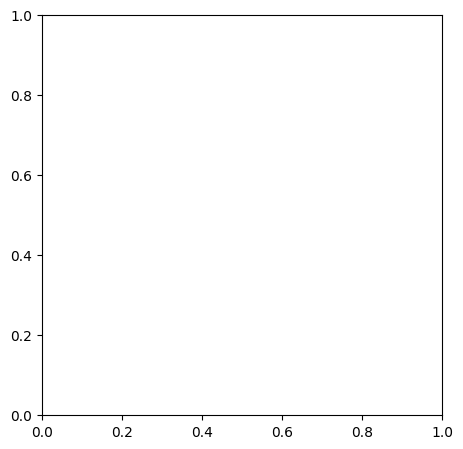

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm

# --- FireIce-style colormap (blue -> white -> red) ---
fireice = LinearSegmentedColormap.from_list(
    "fireice",
    ["#053061", "#2166ac", "#67a9cf", "#f7f7f7", "#f4a582", "#d6604d", "#67001f"],
    N=256,
)

# --- Load your saved toy ---
npz_path = "outputs/aoi_primitive_hbn_graphene_toy.npz"
D = np.load(npz_path, allow_pickle=True)

# Try common keys (adjust if your npz uses different names)
# Expecting something like reach_charge and reach_heat as 2D arrays
reachC = None
reachH = None
for k in ["reach_charge", "reachC", "reach_charge_final", "reachC_final"]:
    if k in D: reachC = D[k]
for k in ["reach_heat", "reachH", "reach_heat_final", "reachH_final"]:
    if k in D: reachH = D[k]

if reachC is None or reachH is None:
    print("Keys in npz:", list(D.keys()))
    raise KeyError("Couldn't find reach arrays. Update the key names above to match your .npz.")

# --- Choose what to plot ---
# Option A: plot reach difference (charge - heat) with a diverging norm centered at 0
diff = reachC.astype(float) - reachH.astype(float)
vmax = np.nanmax(np.abs(diff))
norm = TwoSlopeNorm(vmin=-vmax, vcenter=0.0, vmax=vmax)

plt.figure(figsize=(6.2, 5.2))
plt.imshow(diff, origin="lower", cmap=fireice, norm=norm, interpolation="nearest")
plt.colorbar(label="reach_charge − reach_heat")
plt.title("Reach difference (FireIce)")
plt.tight_layout()
plt.savefig("outputs/aoi_primitive_hbn_graphene_toy_reach_fireice.png", dpi=220)
plt.show()

# Option B: plot reachC alone using FireIce but normalized to its own min/max
# plt.figure(figsize=(6.2, 5.2))
# plt.imshow(reachC, origin="lower", cmap=fireice, interpolation="nearest")
# plt.colorbar(label="reach_charge")
# plt.title("Reach (charge) FireIce")
# plt.tight_layout()
# plt.savefig("outputs/aoi_primitive_hbn_graphene_toy_reachC_fireice.png", dpi=220)
# plt.show()

TypeError: Invalid shape (120,) for image data

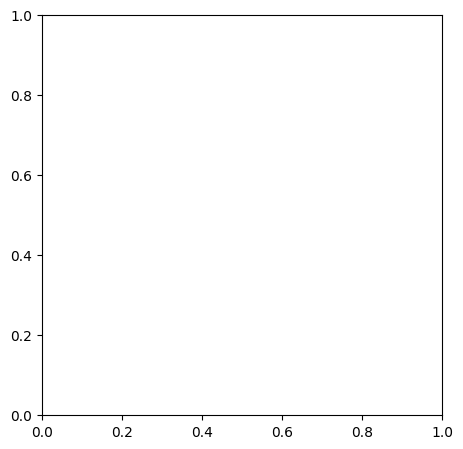

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm

# --- FireIce-style colormap (blue -> white -> red) ---
fireice = LinearSegmentedColormap.from_list(
    "fireice",
    ["#053061", "#2166ac", "#67a9cf", "#f7f7f7", "#f4a582", "#d6604d", "#67001f"],
    N=256,
)

npz_path = "outputs/aoi_primitive_hbn_graphene_toy.npz"
D = np.load(npz_path, allow_pickle=True)

def pick_key(d, candidates):
    for k in candidates:
        if k in d:
            return k
    return None

# Common key candidates (covers your earlier naming styles)
kC = pick_key(D, ["reach_charge", "reachC", "reach_charge_final", "reachC_final", "reach_charge_map"])
kH = pick_key(D, ["reach_heat", "reachH", "reach_heat_final", "reachH_final", "reach_heat_map"])

# If not found, fall back to "any 2D array containing 'reach' + ('charge'/'heat')"
if kC is None:
    for k in D.keys():
        if "reach" in k.lower() and "charge" in k.lower() and np.ndim(D[k]) == 2:
            kC = k
            break
if kH is None:
    for k in D.keys():
        if "reach" in k.lower() and "heat" in k.lower() and np.ndim(D[k]) == 2:
            kH = k
            break

if kC is None or kH is None:
    print("Keys in npz:", list(D.keys()))
    raise KeyError("Could not locate 2D reach arrays for charge/heat in the NPZ.")

reachC = D[kC].astype(float)
reachH = D[kH].astype(float)

def save_fireice(field, out_png, title, diverging=False):
    plt.figure(figsize=(6.2, 5.2))
    if diverging:
        vmax = float(np.nanmax(np.abs(field)))
        norm = TwoSlopeNorm(vmin=-vmax, vcenter=0.0, vmax=vmax)
        im = plt.imshow(field, origin="lower", cmap=fireice, norm=norm, interpolation="nearest")
    else:
        im = plt.imshow(field, origin="lower", cmap=fireice, interpolation="nearest")
    plt.colorbar(im)
    plt.title(title)
    plt.tight_layout()
    plt.savefig(out_png, dpi=220)
    plt.close()
    print("Saved:", out_png)

# 1) charge reach
save_fireice(
    reachC,
    "outputs/aoi_primitive_hbn_graphene_toy_reach_charge_fireice.png",
    f"Reach (charge) [{kC}]",
    diverging=False,
)

# 2) heat reach
save_fireice(
    reachH,
    "outputs/aoi_primitive_hbn_graphene_toy_reach_heat_fireice.png",
    f"Reach (heat) [{kH}]",
    diverging=False,
)

# 3) difference (charge - heat), zero-centered diverging
diff = reachC - reachH
save_fireice(
    diff,
    "outputs/aoi_primitive_hbn_graphene_toy_reach_diff_fireice.png",
    "Reach difference (charge − heat)",
    diverging=True,
)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm

# --- FireIce-style colormap (blue -> white -> red) ---
fireice = LinearSegmentedColormap.from_list(
    "fireice",
    ["#053061", "#2166ac", "#67a9cf", "#f7f7f7", "#f4a582", "#d6604d", "#67001f"],
    N=256,
)

npz_path = "outputs/aoi_primitive_hbn_graphene_toy.npz"
D = np.load(npz_path, allow_pickle=True)

# --- quick inventory (helps debugging) ---
print("NPZ keys and shapes:")
for k in D.files:
    arr = D[k]
    try:
        shp = arr.shape
    except Exception:
        shp = "<?>"
    print(" ", k, ":", shp, "dtype=", getattr(arr, "dtype", None))

def pick_reach_map(d, kind):
    """
    kind: 'charge' or 'heat'
    Prefer 2D arrays whose key contains 'reach' and kind.
    """
    candidates = []
    for k in d.files:
        kl = k.lower()
        if ("reach" in kl) and (kind in kl):
            arr = d[k]
            if hasattr(arr, "ndim") and arr.ndim == 2:
                return k
            candidates.append(k)
    # If no 2D found, return first candidate (might be 1D)
    return candidates[0] if candidates else None

kC = pick_reach_map(D, "charge")
kH = pick_reach_map(D, "heat")

if kC is None or kH is None:
    raise KeyError("Could not find keys containing 'reach' + 'charge'/'heat'. See printed key list above.")

reachC = np.array(D[kC]).astype(float)
reachH = np.array(D[kH]).astype(float)

def reshape_if_needed(x, d):
    if x.ndim == 2:
        return x
    if x.ndim != 1:
        raise TypeError(f"Expected 1D or 2D reach array, got shape {x.shape}")
    n = x.size

    # Try Nx, Ny from npz if present
    Nx = None
    Ny = None
    for k in d.files:
        if k.lower() in ["nx", "ny"]:
            pass
    if "Nx" in d.files: Nx = int(np.array(d["Nx"]).item())
    if "Ny" in d.files: Ny = int(np.array(d["Ny"]).item())
    if Nx is not None and Ny is not None and Nx * Ny == n:
        return x.reshape((Ny, Nx))  # (row, col) = (y, x)

    # Otherwise try square reshape
    s = int(round(n ** 0.5))
    if s * s == n:
        return x.reshape((s, s))

    raise ValueError(
        f"Reach is 1D length {n} and could not be reshaped. "
        "Store Nx,Ny in the NPZ or save reach as 2D."
    )

reachC = reshape_if_needed(reachC, D)
reachH = reshape_if_needed(reachH, D)

def save_fireice(field, out_png, title, diverging=False, cbar_label=None):
    plt.figure(figsize=(6.2, 5.2))
    if diverging:
        vmax = float(np.nanmax(np.abs(field)))
        norm = TwoSlopeNorm(vmin=-vmax, vcenter=0.0, vmax=vmax)
        im = plt.imshow(field, origin="lower", cmap=fireice, norm=norm, interpolation="nearest")
    else:
        im = plt.imshow(field, origin="lower", cmap=fireice, interpolation="nearest")
    cb = plt.colorbar(im)
    if cbar_label:
        cb.set_label(cbar_label)
    plt.title(title)
    plt.tight_layout()
    plt.savefig(out_png, dpi=220)
    plt.close()
    print("Saved:", out_png)

save_fireice(
    reachC,
    "outputs/aoi_primitive_hbn_graphene_toy_reach_charge_fireice.png",
    f"Reach (charge) [{kC}]",
    diverging=False,
    cbar_label="reach_charge",
)

save_fireice(
    reachH,
    "outputs/aoi_primitive_hbn_graphene_toy_reach_heat_fireice.png",
    f"Reach (heat) [{kH}]",
    diverging=False,
    cbar_label="reach_heat",
)

diff = reachC - reachH
save_fireice(
    diff,
    "outputs/aoi_primitive_hbn_graphene_toy_reach_diff_fireice.png",
    "Reach difference (charge − heat)",
    diverging=True,
    cbar_label="reach_charge − reach_heat",
)

NPZ keys and shapes:
  Nx : () dtype= int64
  Ny : () dtype= int64
  a_g : () dtype= float64
  theta_deg : () dtype= float64
  delta : () dtype= float64
  V0 : () dtype= float64
  omega : () dtype= float64
  Tsteps : () dtype= int64
  charge_kappa : () dtype= float64
  charge_Vc : () dtype= float64
  heat_kappa : () dtype= float64
  heat_Vc : () dtype= float64
  reachC : (120,) dtype= float64
  reachH : (120,) dtype= float64
  maskC : (529,) dtype= uint8
  maskH : (529,) dtype= uint8
  pC : (1496, 120) dtype= float64
  pH : (1496, 120) dtype= float64
  A_charge : () dtype= float64
  A_heat : () dtype= float64
  lorenz_proxy : () dtype= float64
  AOI_charge : () dtype= float64
  A_time_charge : () dtype= float64
  A_avg_charge : () dtype= float64
  AOI_heat : () dtype= float64
  A_time_heat : () dtype= float64
  A_avg_heat : () dtype= float64
  reach_time_mean_charge : (120,) dtype= float64
  reach_avg_mean_charge : (120,) dtype= float64
  reach_time_mean_heat : (120,) dtype= float64
  

ValueError: Reach is 1D length 120 and could not be reshaped. Store Nx,Ny in the NPZ or save reach as 2D.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm

# --- FireIce-style colormap (blue -> white -> red) ---
fireice = LinearSegmentedColormap.from_list(
    "fireice",
    ["#053061", "#2166ac", "#67a9cf", "#f7f7f7", "#f4a582", "#d6604d", "#67001f"],
    N=256,
)

npz_path = "outputs/aoi_primitive_hbn_graphene_toy.npz"
D = np.load(npz_path, allow_pickle=True)

Nx = int(np.array(D["Nx"]).item())
Ny = int(np.array(D["Ny"]).item())
Tsteps = int(np.array(D["Tsteps"]).item())

pC = np.array(D["pC"], dtype=float)  # (Nsites, T)
pH = np.array(D["pH"], dtype=float)
maskC = np.array(D["maskC"], dtype=np.uint8)  # length Nx*Ny, values are 0/1
maskH = np.array(D["maskH"], dtype=np.uint8)

# --- helpers ---
def to_grid(field_sites, mask, Nx, Ny, fill=np.nan):
    """
    field_sites: (Nsites,) values defined only on mask==1 sites
    mask: (Nx*Ny,) with {0,1}
    returns: (Ny,Nx) grid with fill elsewhere
    """
    grid = np.full((Ny, Nx), fill, dtype=float)
    flat = grid.ravel()
    idx = np.flatnonzero(mask.ravel() > 0)
    if field_sites.shape[0] != idx.shape[0]:
        raise ValueError(f"field_sites has {field_sites.shape[0]} but mask has {idx.shape[0]} active sites.")
    flat[idx] = field_sites
    return grid

def save_fireice(field2d, out_png, title, diverging=False, cbar_label=""):
    plt.figure(figsize=(6.2, 5.2))
    if diverging:
        vmax = float(np.nanmax(np.abs(field2d)))
        norm = TwoSlopeNorm(vmin=-vmax, vcenter=0.0, vmax=vmax)
        im = plt.imshow(field2d, origin="lower", cmap=fireice, norm=norm, interpolation="nearest")
    else:
        im = plt.imshow(field2d, origin="lower", cmap=fireice, interpolation="nearest")
    cb = plt.colorbar(im)
    if cbar_label:
        cb.set_label(cbar_label)
    plt.title(title)
    plt.tight_layout()
    plt.savefig(out_png, dpi=220)
    plt.close()
    print("Saved:", out_png)

# -------------------------
# (A) Time-averaged spatial maps
# -------------------------
pC_avg = pC.mean(axis=1)  # (Nsites,)
pH_avg = pH.mean(axis=1)

gridC_avg = to_grid(pC_avg, maskC, Nx, Ny)
gridH_avg = to_grid(pH_avg, maskH, Nx, Ny)
gridDiff_avg = gridC_avg - gridH_avg

save_fireice(
    gridC_avg,
    "outputs/aoi_primitive_hbn_graphene_toy_pC_avg_fireice.png",
    "Charge field (time-avg) FireIce",
    diverging=False,
    cbar_label="pC (avg over time)",
)

save_fireice(
    gridH_avg,
    "outputs/aoi_primitive_hbn_graphene_toy_pH_avg_fireice.png",
    "Heat field (time-avg) FireIce",
    diverging=False,
    cbar_label="pH (avg over time)",
)

save_fireice(
    gridDiff_avg,
    "outputs/aoi_primitive_hbn_graphene_toy_pDiff_avg_fireice.png",
    "Difference (charge − heat), time-avg",
    diverging=True,
    cbar_label="pC − pH (avg over time)",
)

# -------------------------
# (B) Single time-slice spatial maps
# -------------------------
t = min(10, Tsteps - 1)  # choose a frame; change as you like

gridC_t = to_grid(pC[:, t], maskC, Nx, Ny)
gridH_t = to_grid(pH[:, t], maskH, Nx, Ny)
gridDiff_t = gridC_t - gridH_t

save_fireice(
    gridC_t,
    "outputs/aoi_primitive_hbn_graphene_toy_pC_t_fireice.png",
    f"Charge field FireIce (t={t}/{Tsteps-1})",
    diverging=False,
    cbar_label=f"pC at t={t}",
)

save_fireice(
    gridH_t,
    "outputs/aoi_primitive_hbn_graphene_toy_pH_t_fireice.png",
    f"Heat field FireIce (t={t}/{Tsteps-1})",
    diverging=False,
    cbar_label=f"pH at t={t}",
)

save_fireice(
    gridDiff_t,
    "outputs/aoi_primitive_hbn_graphene_toy_pDiff_t_fireice.png",
    f"Difference (charge − heat) FireIce (t={t})",
    diverging=True,
    cbar_label=f"pC − pH at t={t}",
)

# -------------------------
# (C) Your original reach series (1D) as a sanity plot
# -------------------------
reachC = np.array(D["reachC"], dtype=float)
reachH = np.array(D["reachH"], dtype=float)

plt.figure(figsize=(7.2, 4.2))
plt.plot(reachC, label="reachC")
plt.plot(reachH, label="reachH")
plt.xlabel("time step")
plt.ylabel("reach (count)")
plt.title("Reach time-series (not an image)")
plt.legend()
plt.tight_layout()
plt.savefig("outputs/aoi_primitive_hbn_graphene_toy_reach_timeseries.png", dpi=220)
plt.show()

ValueError: field_sites has 1496 but mask has 515 active sites.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm

fireice = LinearSegmentedColormap.from_list(
    "fireice",
    ["#053061", "#2166ac", "#67a9cf", "#f7f7f7", "#f4a582", "#d6604d", "#67001f"],
    N=256,
)

npz_path = "outputs/aoi_primitive_hbn_graphene_toy.npz"
D = np.load(npz_path, allow_pickle=True)

pC = np.array(D["pC"], dtype=float)  # (Nsites, Tsteps)
pH = np.array(D["pH"], dtype=float)

# time-avg per site (1D), then replicate to 2D for a clean image
pC_avg = pC.mean(axis=1)[:, None]  # (Nsites, 1)
pH_avg = pH.mean(axis=1)[:, None]
pDiff = pC - pH

def save_field(field2d, out_png, title, diverging=False, cbar_label=""):
    plt.figure(figsize=(7.0, 5.0))
    if diverging:
        vmax = float(np.nanmax(np.abs(field2d)))
        norm = TwoSlopeNorm(vmin=-vmax, vcenter=0.0, vmax=vmax)
        im = plt.imshow(field2d, origin="lower", cmap=fireice, norm=norm, aspect="auto")
    else:
        im = plt.imshow(field2d, origin="lower", cmap=fireice, aspect="auto")
    cb = plt.colorbar(im)
    if cbar_label:
        cb.set_label(cbar_label)
    plt.xlabel("time step")
    plt.ylabel("site index")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(out_png, dpi=220)
    plt.close()
    print("Saved:", out_png)

save_field(pC, "outputs/pC_site_time_fireice.png", "pC (site × time)", diverging=False, cbar_label="pC")
save_field(pH, "outputs/pH_site_time_fireice.png", "pH (site × time)", diverging=False, cbar_label="pH")
save_field(pDiff, "outputs/pDiff_site_time_fireice.png", "pC − pH (site × time)", diverging=True, cbar_label="pC − pH")

save_field(pC_avg, "outputs/pC_timeavg_site_fireice.png", "pC time-avg (site)", diverging=False, cbar_label="⟨pC⟩t")
save_field(pH_avg, "outputs/pH_timeavg_site_fireice.png", "pH time-avg (site)", diverging=False, cbar_label="⟨pH⟩t")

Saved: outputs/pC_site_time_fireice.png
Saved: outputs/pH_site_time_fireice.png
Saved: outputs/pDiff_site_time_fireice.png
Saved: outputs/pC_timeavg_site_fireice.png
Saved: outputs/pH_timeavg_site_fireice.png


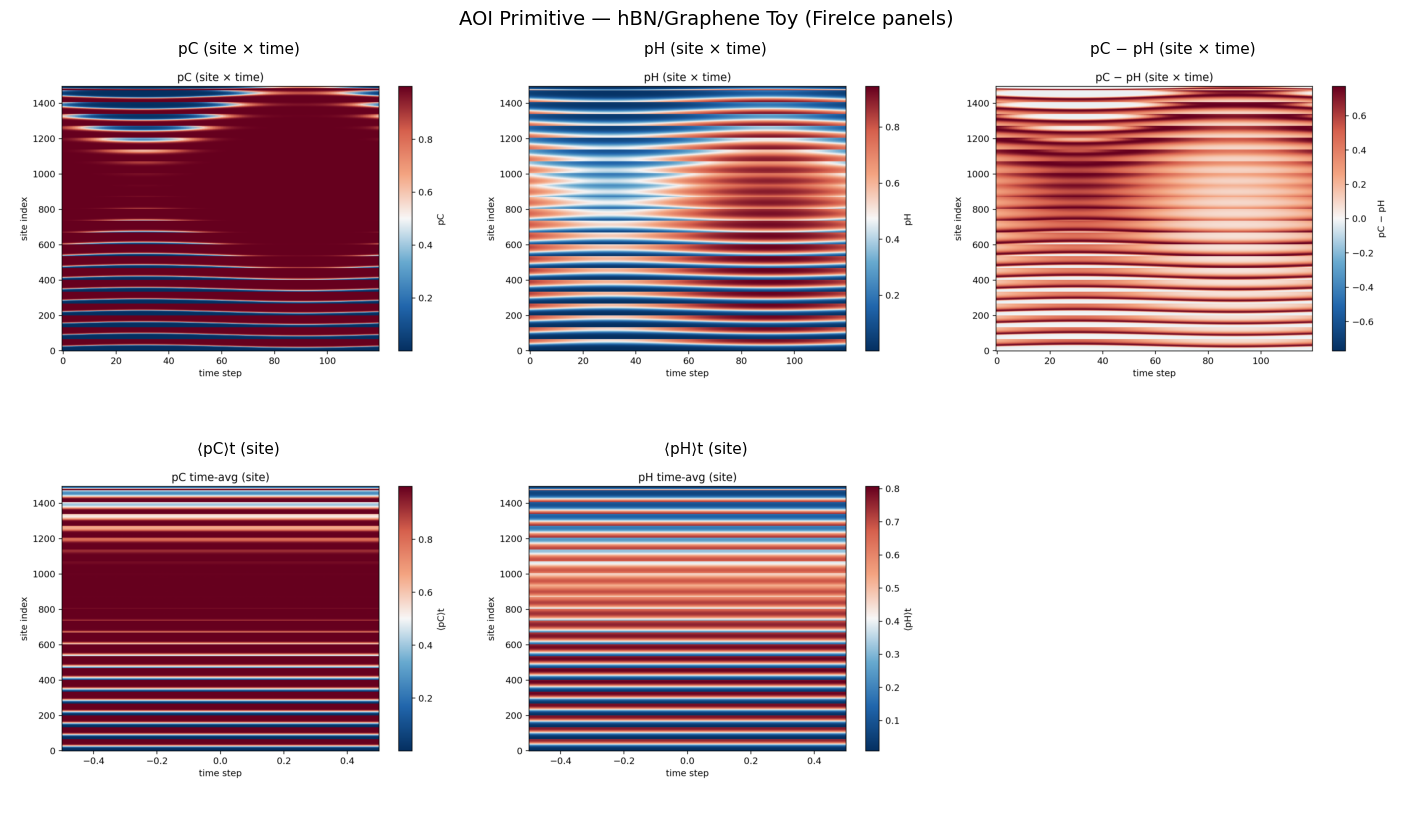

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

pngs = [
    ("outputs/pC_site_time_fireice.png",      "pC (site × time)"),
    ("outputs/pH_site_time_fireice.png",      "pH (site × time)"),
    ("outputs/pDiff_site_time_fireice.png",   "pC − pH (site × time)"),
    ("outputs/pC_timeavg_site_fireice.png",   "⟨pC⟩t (site)"),
    ("outputs/pH_timeavg_site_fireice.png",   "⟨pH⟩t (site)"),
]

fig, axes = plt.subplots(
    nrows=2, ncols=3,
    figsize=(14, 8),
    constrained_layout=True
)

axes = axes.ravel()

for ax, (fname, title) in zip(axes, pngs):
    img = mpimg.imread(fname)
    ax.imshow(img)
    ax.set_title(title, fontsize=11)
    ax.axis("off")

# Turn off any unused panels
for ax in axes[len(pngs):]:
    ax.axis("off")

plt.suptitle(
    "AOI Primitive — hBN/Graphene Toy (FireIce panels)",
    fontsize=14,
    y=1.02
)

plt.show()

Saved: outputs/aoi_primitive_hbn_graphene_toy.npz
Saved: outputs/aoi_primitive_hbn_graphene_toy_reach.png
Saved: outputs/aoi_primitive_hbn_graphene_toy_aoi.png
Saved: outputs/aoi_primitive_hbn_graphene_toy_panels.png
Metrics: Lorenz_proxy(L/L0)= 0.98902660069461 A_charge= 0.9646975425330813 A_heat= 0.9541115311909263 AOI_charge= 0.028173392121466773 AOI_heat= 0.02297745884744426


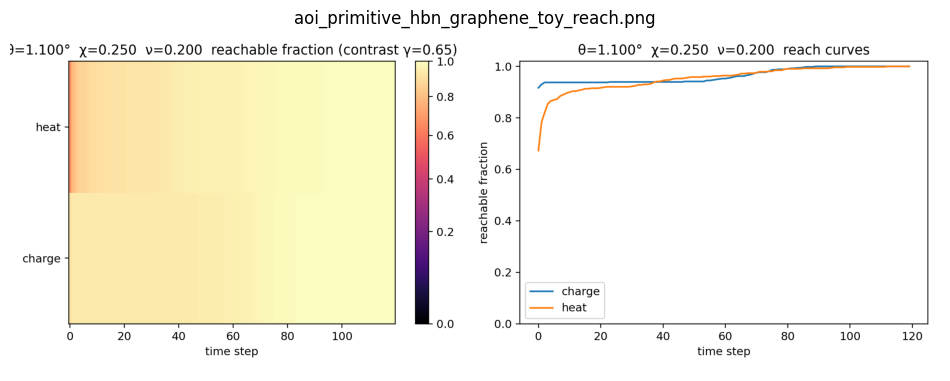

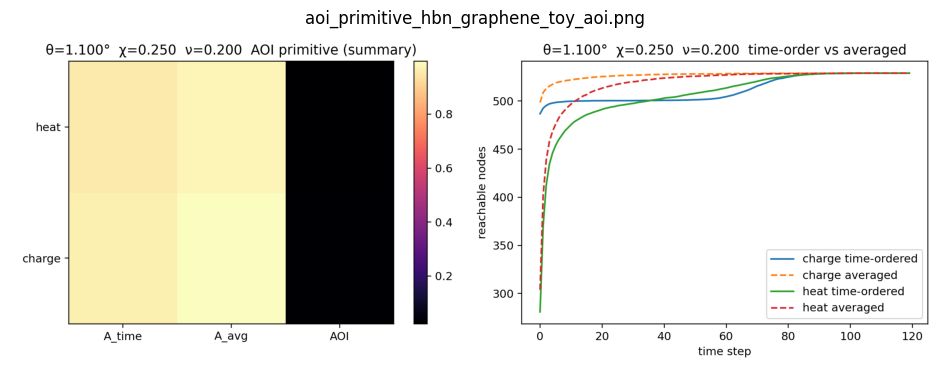

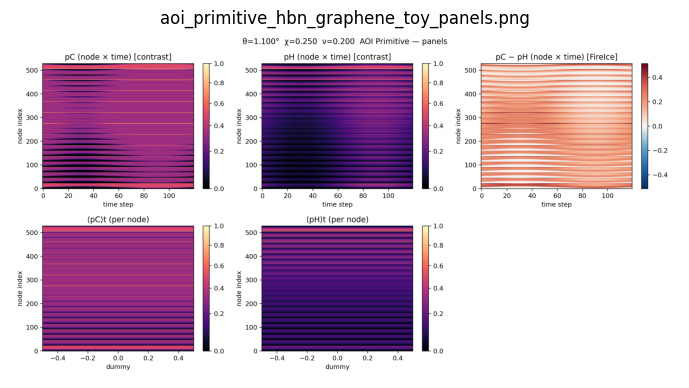

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm, TwoSlopeNorm, LinearSegmentedColormap

# -------------------------
# Utilities
# -------------------------
def ensure_dir(d):
    os.makedirs(d, exist_ok=True)

def sigmoid_stable(x, kappa=1.0):
    z = np.clip(kappa * x, -60.0, 60.0)
    return 1.0 / (1.0 + np.exp(-z))

def rot2(theta):
    c = np.cos(theta)
    s = np.sin(theta)
    return np.array([[c, -s], [s,  c]], dtype=float)

# -------------------------
# Triangular lattice (Nx,Ny) with axial indexing
# -------------------------
def triangular_lattice_points(Nx, Ny, a=1.0):
    pts = []
    ij_of = []
    idx = {}
    k = 0
    for j in range(Ny):
        for i in range(Nx):
            x = a * (i + 0.5 * (j % 2))
            y = a * (np.sqrt(3) / 2.0) * j
            pts.append([x, y])
            ij_of.append((i, j))
            idx[(i, j)] = k
            k += 1
    return np.array(pts, dtype=float), idx, ij_of

def triangular_neighbors(Nx, Ny):
    # undirected neighbor pairs in (i,j) coordinates
    edges = []
    for j in range(Ny):
        for i in range(Nx):
            # right
            if i + 1 < Nx:
                edges.append(((i, j), (i + 1, j)))
            # up/down (depends on row parity)
            if j + 1 < Ny:
                if j % 2 == 0:
                    if i - 1 >= 0:
                        edges.append(((i, j), (i - 1, j + 1)))
                    edges.append(((i, j), (i, j + 1)))
                else:
                    edges.append(((i, j), (i, j + 1)))
                    if i + 1 < Nx:
                        edges.append(((i, j), (i + 1, j + 1)))
    return edges

# -------------------------
# Moiré reciprocal vectors (toy)
# -------------------------
def moire_reciprocal_vectors(a_g=1.0, delta=0.018, theta=0.0):
    # "graphene-like" 3 vectors at 120°; then mismatch/rotation perturbation
    gmag = 4.0 * np.pi / (np.sqrt(3) * a_g)
    g1 = gmag * np.array([1.0, 0.0])
    g2 = gmag * np.array([-0.5,  np.sqrt(3)/2.0])
    g3 = gmag * np.array([-0.5, -np.sqrt(3)/2.0])

    R = rot2(theta)
    M = (R - (1.0 + delta) * np.eye(2))
    return (M @ g1, M @ g2, M @ g3)

def build_mode_set(gvecs, mode_set="3"):
    g = list(gvecs)
    if mode_set == "3":
        return g
    if mode_set == "6":
        return g + [-gg for gg in g]
    raise ValueError("mode_set must be '3' or '6'.")

# -------------------------
# Chirality + viscosity gate construction
# -------------------------
def moire_complex_field(pts, gvecs, chirality=0.0, handedness=+1, phase0=0.0):
    """
    Complex moiré field:
      psi(r) = sum_m exp(i (g_m · r + phase_m))
    Chirality implemented via phase offsets across modes:
      phase_m = phase0 + handedness * chirality * 2π * m/3   (for m=0,1,2 ... modulo 3)
    Returns:
      phi = Re(psi)  (what we feed into the gate)
      psi (complex)  (kept for debugging/extension)
    """
    psi = np.zeros((pts.shape[0],), dtype=np.complex128)
    for m, g in enumerate(gvecs):
        # If using 6 modes, keep phase pattern repeating every 3
        mm = (m % 3)
        phase_m = phase0 + handedness * chirality * (2.0*np.pi) * (mm / 3.0)
        psi += np.exp(1j * (pts @ g + phase_m))
    phi = np.real(psi)
    return phi, psi

def edge_gate_probability(phi_u, phi_v, V0, omega, t, kappa, Vc):
    phi_mid = 0.5 * (phi_u + phi_v)
    x = (Vc - V0 * phi_mid - omega * np.sin(t))
    return sigmoid_stable(x, kappa=kappa)

def build_temporal_edge_weights(
    pts, edges_uv, idx, gvecs, times, V0, omega, kappa, Vc,
    chirality=0.0, handedness=+1, viscosity=0.0, mode_set="3"
):
    """
    Returns p_t[e, k] = gate-open probability for edge e at time index k.

    viscosity in [0,1): low-pass filter in time for each edge:
      p_visc[k] = (1-visc)*p_raw[k] + visc*p_visc[k-1]
    """
    g_use = build_mode_set(gvecs, mode_set=mode_set)
    phi, psi = moire_complex_field(pts, g_use, chirality=chirality, handedness=handedness, phase0=0.0)

    E = len(edges_uv)
    T = len(times)
    p_raw = np.zeros((E, T), dtype=float)

    for e, (u_ij, v_ij) in enumerate(edges_uv):
        u = idx[u_ij]
        v = idx[v_ij]
        for k, t in enumerate(times):
            p_raw[e, k] = edge_gate_probability(phi[u], phi[v], V0, omega, t, kappa, Vc)

    if viscosity <= 0.0:
        return p_raw, phi, psi

    visc = float(viscosity)
    visc = max(0.0, min(visc, 0.999))
    p = np.zeros_like(p_raw)
    p[:, 0] = p_raw[:, 0]
    for k in range(1, T):
        p[:, k] = (1.0 - visc) * p_raw[:, k] + visc * p[:, k - 1]
    return p, phi, psi

# -------------------------
# Reachability (MC per time slice)
# -------------------------
def temporal_reachability_from_prob(edges_uv, idx, p_t, Tsteps, N, source, rng=None):
    if rng is None:
        rng = np.random.default_rng(0)

    reachable = np.zeros((N,), dtype=bool)
    reachable[source] = True
    reach_count = np.zeros((Tsteps,), dtype=float)

    e_u = np.array([idx[u] for (u, v) in edges_uv], dtype=int)
    e_v = np.array([idx[v] for (u, v) in edges_uv], dtype=int)

    for t in range(Tsteps):
        open_e = rng.random(p_t.shape[0]) < p_t[:, t]

        changed = True
        while changed:
            changed = False
            ru = reachable[e_u]
            rv = reachable[e_v]
            can_uv = open_e & ru & (~rv)
            can_vu = open_e & rv & (~ru)

            if np.any(can_uv):
                reachable[e_v[can_uv]] = True
                changed = True
            if np.any(can_vu):
                reachable[e_u[can_vu]] = True
                changed = True

        reach_count[t] = reachable.sum()

    return reach_count, reachable.copy()

def accessibility_score(reach_count, N):
    return float(np.mean(reach_count) / float(N))

def aoi_primitive_metric(edges_uv, idx, p_t, N, source, mc=40, seed=0):
    rng = np.random.default_rng(seed)
    Tsteps = p_t.shape[1]

    # time-ordered
    reach_time = []
    for _ in range(mc):
        rc, _ = temporal_reachability_from_prob(edges_uv, idx, p_t, Tsteps, N, source, rng=rng)
        reach_time.append(rc)
    reach_time = np.array(reach_time)
    reach_time_mean = reach_time.mean(axis=0)
    A_time = accessibility_score(reach_time_mean, N)

    # time-averaged control
    p_avg = np.mean(p_t, axis=1, keepdims=True)
    p_flat = np.repeat(p_avg, Tsteps, axis=1)

    reach_avg = []
    for _ in range(mc):
        rc, _ = temporal_reachability_from_prob(edges_uv, idx, p_flat, Tsteps, N, source, rng=rng)
        reach_avg.append(rc)
    reach_avg = np.array(reach_avg)
    reach_avg_mean = reach_avg.mean(axis=0)
    A_avg = accessibility_score(reach_avg_mean, N)

    AOI = (A_avg - A_time) / (A_avg + 1e-12)

    return {
        "A_time": float(A_time),
        "A_avg": float(A_avg),
        "AOI": float(AOI),
        "reach_time_mean": reach_time_mean,
        "reach_avg_mean": reach_avg_mean,
        "p_edge_mean": p_t.mean(axis=1),
        "p_edge_min": p_t.min(axis=1),
        "p_edge_max": p_t.max(axis=1),
    }

# -------------------------
# Edge->node aggregation for plotting spatial maps
# -------------------------
def edge_to_node_time_series(N, e_u, e_v, p_edge_t):
    """
    Convert edge×time gate probabilities to node×time by averaging incident edges.
    p_edge_t: (E,T)
    returns p_node_t: (N,T)
    """
    E, T = p_edge_t.shape
    accum = np.zeros((N, T), dtype=float)
    deg = np.zeros((N,), dtype=float)

    # accumulate to both endpoints
    accum[e_u, :] += p_edge_t
    accum[e_v, :] += p_edge_t
    np.add.at(deg, e_u, 1.0)
    np.add.at(deg, e_v, 1.0)

    deg = np.maximum(deg, 1.0)[:, None]
    return accum / deg

def node_to_grid(node_field, Nx, Ny):
    # node_field: (N,) or (N,T) with N=Nx*Ny
    return node_field.reshape((Ny, Nx))  # because we built (j outer, i inner)

# -------------------------
# Plotting
# -------------------------
fireice = LinearSegmentedColormap.from_list(
    "fireice",
    ["#053061", "#2166ac", "#67a9cf", "#f7f7f7", "#f4a582", "#d6604d", "#67001f"],
    N=256,
)

def plot_reachability_png(out_png, reachC, reachH, N, title_prefix="", gamma=0.65):
    """
    Left panel: 2×T heatmap (charge/heat) with contrast boost (PowerNorm).
    Right panel: reach curves.
    """
    plt.figure(figsize=(11.5, 4.2))

    plt.subplot(1, 2, 1)
    img = np.vstack([reachC / N, reachH / N])
    im = plt.imshow(
        img,
        aspect="auto",
        cmap="magma",
        norm=PowerNorm(gamma=gamma, vmin=0.0, vmax=1.0),
        origin="lower",
        interpolation="nearest",
    )
    plt.yticks([0, 1], ["charge", "heat"])
    plt.xlabel("time step")
    plt.title(f"{title_prefix}reachable fraction (contrast γ={gamma})")
    plt.colorbar(im)

    plt.subplot(1, 2, 2)
    plt.plot(reachC / N, label="charge")
    plt.plot(reachH / N, label="heat")
    plt.ylim(0.0, 1.02)
    plt.xlabel("time step")
    plt.ylabel("reachable fraction")
    plt.title(f"{title_prefix}reach curves")
    plt.legend()

    plt.tight_layout()
    plt.savefig(out_png, dpi=220)
    plt.close()

def plot_aoi_png(out_png, aoi_charge, aoi_heat, title_prefix=""):
    plt.figure(figsize=(11.5, 4.2))

    plt.subplot(1, 2, 1)
    img = np.vstack([
        [aoi_charge["A_time"], aoi_charge["A_avg"], aoi_charge["AOI"]],
        [aoi_heat["A_time"], aoi_heat["A_avg"], aoi_heat["AOI"]],
    ])
    im = plt.imshow(img, aspect="auto", cmap="magma", origin="lower")
    plt.yticks([0, 1], ["charge", "heat"])
    plt.xticks([0, 1, 2], ["A_time", "A_avg", "AOI"])
    plt.title(f"{title_prefix}AOI primitive (summary)")
    plt.colorbar(im)

    plt.subplot(1, 2, 2)
    plt.plot(aoi_charge["reach_time_mean"], label="charge time-ordered")
    plt.plot(aoi_charge["reach_avg_mean"], "--", label="charge averaged")
    plt.plot(aoi_heat["reach_time_mean"], label="heat time-ordered")
    plt.plot(aoi_heat["reach_avg_mean"], "--", label="heat averaged")
    plt.xlabel("time step")
    plt.ylabel("reachable nodes")
    plt.title(f"{title_prefix}time-order vs averaged")
    plt.legend()

    plt.tight_layout()
    plt.savefig(out_png, dpi=220)
    plt.close()

def plot_node_panels_fireice(out_png, pC_node_t, pH_node_t, title_prefix="", vmax_diff=None):
    """
    2×3 panel:
      top: node×time pC, pH, (pC-pH) with FireIce on diff
      bottom: time-avg node profiles for pC and pH (as node-index heatmaps for consistency)
    """
    pDiff = pC_node_t - pH_node_t
    if vmax_diff is None:
        vmax_diff = float(np.nanmax(np.abs(pDiff)))

    plt.figure(figsize=(14.5, 7.5))

    # (1) pC node×time
    ax = plt.subplot(2, 3, 1)
    im = ax.imshow(pC_node_t, aspect="auto", cmap="magma", origin="lower",
                   norm=PowerNorm(gamma=0.75, vmin=0.0, vmax=1.0), interpolation="nearest")
    ax.set_title("pC (node × time) [contrast]")
    ax.set_xlabel("time step")
    ax.set_ylabel("node index")
    plt.colorbar(im, ax=ax)

    # (2) pH node×time
    ax = plt.subplot(2, 3, 2)
    im = ax.imshow(pH_node_t, aspect="auto", cmap="magma", origin="lower",
                   norm=PowerNorm(gamma=0.75, vmin=0.0, vmax=1.0), interpolation="nearest")
    ax.set_title("pH (node × time) [contrast]")
    ax.set_xlabel("time step")
    ax.set_ylabel("node index")
    plt.colorbar(im, ax=ax)

    # (3) diff with FireIce
    ax = plt.subplot(2, 3, 3)
    norm = TwoSlopeNorm(vmin=-vmax_diff, vcenter=0.0, vmax=vmax_diff)
    im = ax.imshow(pDiff, aspect="auto", cmap=fireice, origin="lower", norm=norm, interpolation="nearest")
    ax.set_title("pC − pH (node × time) [FireIce]")
    ax.set_xlabel("time step")
    ax.set_ylabel("node index")
    plt.colorbar(im, ax=ax)

    # (4) time-avg pC per node (as 2D strip)
    ax = plt.subplot(2, 3, 4)
    pC_avg = pC_node_t.mean(axis=1)[:, None]
    im = ax.imshow(pC_avg, aspect="auto", cmap="magma", origin="lower",
                   norm=PowerNorm(gamma=0.75, vmin=0.0, vmax=1.0), interpolation="nearest")
    ax.set_title("⟨pC⟩t (per node)")
    ax.set_xlabel("dummy")
    ax.set_ylabel("node index")
    plt.colorbar(im, ax=ax)

    # (5) time-avg pH per node (as 2D strip)
    ax = plt.subplot(2, 3, 5)
    pH_avg = pH_node_t.mean(axis=1)[:, None]
    im = ax.imshow(pH_avg, aspect="auto", cmap="magma", origin="lower",
                   norm=PowerNorm(gamma=0.75, vmin=0.0, vmax=1.0), interpolation="nearest")
    ax.set_title("⟨pH⟩t (per node)")
    ax.set_xlabel("dummy")
    ax.set_ylabel("node index")
    plt.colorbar(im, ax=ax)

    plt.suptitle(f"{title_prefix}AOI Primitive — panels", y=0.98)
    plt.tight_layout()
    plt.savefig(out_png, dpi=220)
    plt.close()

# -------------------------
# Main runner (fixed theta; no sweep)
# -------------------------
def run_aoi_primitive_fixed_theta_chiral_visc(
    out_dir="outputs",
    stem="aoi_primitive_hbn_graphene_toy",
    Nx=23, Ny=23,
    a_g=1.0,
    theta_deg=1.10,
    delta=0.018,
    V0=1.0,
    omega=0.8,
    Tsteps=120,
    charge_params=(6.0, 1.1),   # (kappa, Vc)
    heat_params=(1.5, -0.4),    # (kappa, Vc)
    chirality=0.25,             # 0..1 (phase twist across modes)
    handedness=+1,              # +1 or -1
    viscosity=0.20,             # 0..0.95 (temporal inertia)
    mode_set="3",               # "3" or "6" (adds -g modes)
    mc=40,
    seed=1,
):
    ensure_dir(out_dir)

    pts, idx, ij_of = triangular_lattice_points(Nx, Ny, a=a_g)

    # unique undirected edges
    edges_raw = triangular_neighbors(Nx, Ny)
    seen = set()
    edges_uv = []
    for u, v in edges_raw:
        a = idx[u]
        b = idx[v]
        key = (a, b) if a < b else (b, a)
        if key not in seen:
            seen.add(key)
            edges_uv.append((u, v))

    N = pts.shape[0]
    source = idx[(Nx // 2, Ny // 2)]
    gvecs = moire_reciprocal_vectors(a_g=a_g, delta=delta, theta=np.deg2rad(theta_deg))
    times = np.linspace(0.0, 2.0 * np.pi, Tsteps, endpoint=False)

    kC, VcC = charge_params
    kH, VcH = heat_params

    pC, phiC, psiC = build_temporal_edge_weights(
        pts, edges_uv, idx, gvecs, times, V0, omega, kC, VcC,
        chirality=chirality, handedness=handedness, viscosity=viscosity, mode_set=mode_set
    )
    pH, phiH, psiH = build_temporal_edge_weights(
        pts, edges_uv, idx, gvecs, times, V0, omega, kH, VcH,
        chirality=chirality, handedness=handedness, viscosity=viscosity, mode_set=mode_set
    )

    rng = np.random.default_rng(seed)
    reachC, maskC = temporal_reachability_from_prob(edges_uv, idx, pC, Tsteps, N, source, rng=rng)
    reachH, maskH = temporal_reachability_from_prob(edges_uv, idx, pH, Tsteps, N, source, rng=rng)

    A_charge = accessibility_score(reachC, N)
    A_heat = accessibility_score(reachH, N)
    lorenz_proxy = A_heat / (A_charge + 1e-12)

    aoiC = aoi_primitive_metric(edges_uv, idx, pC, N, source, mc=mc, seed=seed + 11)
    aoiH = aoi_primitive_metric(edges_uv, idx, pH, N, source, mc=mc, seed=seed + 22)

    # Save edge endpoints (node ids) so plotting/regridding is always consistent later
    e_u = np.array([idx[u] for (u, v) in edges_uv], dtype=int)
    e_v = np.array([idx[v] for (u, v) in edges_uv], dtype=int)

    npz_path = os.path.join(out_dir, f"{stem}.npz")
    np.savez_compressed(
        npz_path,
        Nx=Nx, Ny=Ny, a_g=a_g,
        theta_deg=float(theta_deg), delta=float(delta), V0=float(V0), omega=float(omega), Tsteps=int(Tsteps),
        charge_kappa=float(kC), charge_Vc=float(VcC),
        heat_kappa=float(kH), heat_Vc=float(VcH),
        chirality=float(chirality), handedness=int(handedness), viscosity=float(viscosity), mode_set=str(mode_set),
        source=int(source),
        pts=pts,
        e_u=e_u, e_v=e_v,
        reachC=reachC, reachH=reachH,
        maskC=maskC.astype(np.uint8), maskH=maskH.astype(np.uint8),
        pC=pC, pH=pH,
        A_charge=float(A_charge), A_heat=float(A_heat), lorenz_proxy=float(lorenz_proxy),
        AOI_charge=float(aoiC["AOI"]), A_time_charge=float(aoiC["A_time"]), A_avg_charge=float(aoiC["A_avg"]),
        AOI_heat=float(aoiH["AOI"]), A_time_heat=float(aoiH["A_time"]), A_avg_heat=float(aoiH["A_avg"]),
        reach_time_mean_charge=aoiC["reach_time_mean"],
        reach_avg_mean_charge=aoiC["reach_avg_mean"],
        reach_time_mean_heat=aoiH["reach_time_mean"],
        reach_avg_mean_heat=aoiH["reach_avg_mean"],
        pC_mean=aoiC["p_edge_mean"], pC_min=aoiC["p_edge_min"], pC_max=aoiC["p_edge_max"],
        pH_mean=aoiH["p_edge_mean"], pH_min=aoiH["p_edge_min"], pH_max=aoiH["p_edge_max"],
    )

    png_reach = os.path.join(out_dir, f"{stem}_reach.png")
    png_aoi = os.path.join(out_dir, f"{stem}_aoi.png")
    png_panels = os.path.join(out_dir, f"{stem}_panels.png")

    title_prefix = f"θ={theta_deg:.3f}°  χ={chirality:.3f}  ν={viscosity:.3f}  "

    plot_reachability_png(png_reach, reachC, reachH, N, title_prefix=title_prefix, gamma=0.65)
    plot_aoi_png(png_aoi, aoiC, aoiH, title_prefix=title_prefix)

    # Node×time panels from edge×time
    pC_node_t = edge_to_node_time_series(N, e_u, e_v, pC)
    pH_node_t = edge_to_node_time_series(N, e_u, e_v, pH)
    plot_node_panels_fireice(png_panels, pC_node_t, pH_node_t, title_prefix=title_prefix)

    print("Saved:", npz_path)
    print("Saved:", png_reach)
    print("Saved:", png_aoi)
    print("Saved:", png_panels)
    print("Metrics:",
          "Lorenz_proxy(L/L0)=", float(lorenz_proxy),
          "A_charge=", float(A_charge),
          "A_heat=", float(A_heat),
          "AOI_charge=", float(aoiC["AOI"]),
          "AOI_heat=", float(aoiH["AOI"]))

    # Display the saved PNGs inline (Colab-friendly)
    for p in [png_reach, png_aoi, png_panels]:
        img = plt.imread(p)
        plt.figure(figsize=(12, 4.5))
        plt.imshow(img)
        plt.axis("off")
        plt.title(os.path.basename(p))
        plt.show()

# -------------------------
# RUN (fixed twist, no sweep)
# -------------------------
run_aoi_primitive_fixed_theta_chiral_visc(
    out_dir="outputs",
    stem="aoi_primitive_hbn_graphene_toy",
    Nx=23, Ny=23,
    theta_deg=1.10,
    delta=0.018,
    V0=1.0,
    omega=0.8,
    Tsteps=120,
    charge_params=(6.0, 1.1),
    heat_params=(1.5, -0.4),
    chirality=0.25,     # try 0.0, 0.25, 0.5, 0.75
    handedness=+1,      # try -1 to flip chirality
    viscosity=0.20,     # try 0.0, 0.2, 0.4
    mode_set="3",       # "6" if you want ±g included
    mc=40,
    seed=1,
)

diff stats: min/mean/max = -0.015051130937833529 0.15999207845832528 0.5137843837970963
Using symmetric FireIce limit v = 0.4637061660352061


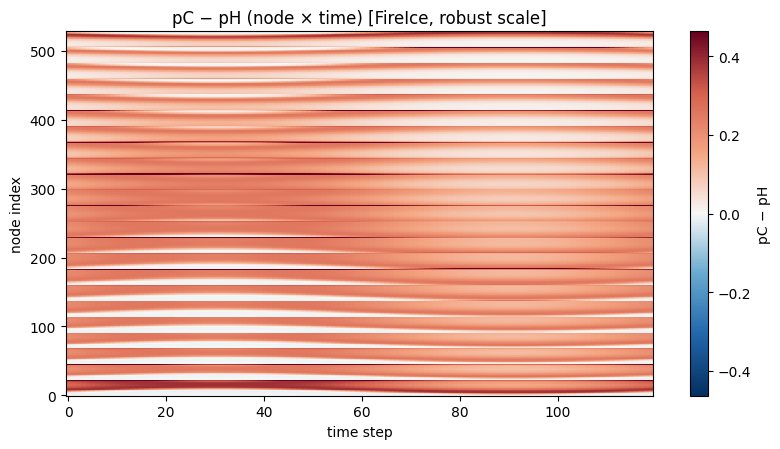

Saved: outputs/aoi_primitive_hbn_graphene_toy_diff_fireice_robust.png


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm, LinearSegmentedColormap

# --- FireIce-style colormap (blue -> white -> red) ---
fireice = LinearSegmentedColormap.from_list(
    "fireice",
    ["#053061", "#2166ac", "#67a9cf", "#f7f7f7", "#f4a582", "#d6604d", "#67001f"],
    N=256,
)

def edge_to_node_time_series(N, e_u, e_v, p_edge_t):
    E, T = p_edge_t.shape
    accum = np.zeros((N, T), dtype=float)
    deg = np.zeros((N,), dtype=float)
    accum[e_u, :] += p_edge_t
    accum[e_v, :] += p_edge_t
    np.add.at(deg, e_u, 1.0)
    np.add.at(deg, e_v, 1.0)
    deg = np.maximum(deg, 1.0)[:, None]
    return accum / deg

# --- Load NPZ ---
npz_path = "outputs/aoi_primitive_hbn_graphene_toy.npz"  # adjust if needed
D = np.load(npz_path, allow_pickle=True)

pC = D["pC"]          # (E, T)
pH = D["pH"]          # (E, T)
e_u = D["e_u"]        # (E,)
e_v = D["e_v"]        # (E,)
Nx = int(D["Nx"])
Ny = int(D["Ny"])
N = Nx * Ny

# --- Build node×time and difference ---
pC_node_t = edge_to_node_time_series(N, e_u, e_v, pC)
pH_node_t = edge_to_node_time_series(N, e_u, e_v, pH)
diff = pC_node_t - pH_node_t

# --- Robust symmetric scaling: use percentile instead of max ---
absdiff = np.abs(diff[np.isfinite(diff)])
v = float(np.percentile(absdiff, 99.0))   # try 95, 97.5, 99, 99.5
v = max(v, 1e-6)

print("diff stats: min/mean/max =", float(np.min(diff)), float(np.mean(diff)), float(np.max(diff)))
print("Using symmetric FireIce limit v =", v)

norm = TwoSlopeNorm(vmin=-v, vcenter=0.0, vmax=v)

# --- Plot ONLY the diff panel ---
plt.figure(figsize=(8.2, 4.6))
im = plt.imshow(diff, aspect="auto", origin="lower", cmap=fireice, norm=norm, interpolation="nearest")
plt.title("pC − pH (node × time) [FireIce, robust scale]")
plt.xlabel("time step")
plt.ylabel("node index")
plt.colorbar(im, label="pC − pH")
plt.tight_layout()
out_png = "outputs/aoi_primitive_hbn_graphene_toy_diff_fireice_robust.png"
plt.savefig(out_png, dpi=220)
plt.show()

print("Saved:", out_png)

In [ ]:
lo = np.min(reach_frac)          # e.g. ~0.67
hi = np.max(reach_frac)          # ~0.999
pad = 0.02 * (hi - lo)

plt.imshow(
    reach_frac,
    vmin=lo - pad,
    vmax=hi + pad,
    cmap="magma",        # or your existing cmap
    aspect="auto",
    origin="lower"
)

NameError: name 'reach_frac' is not defined

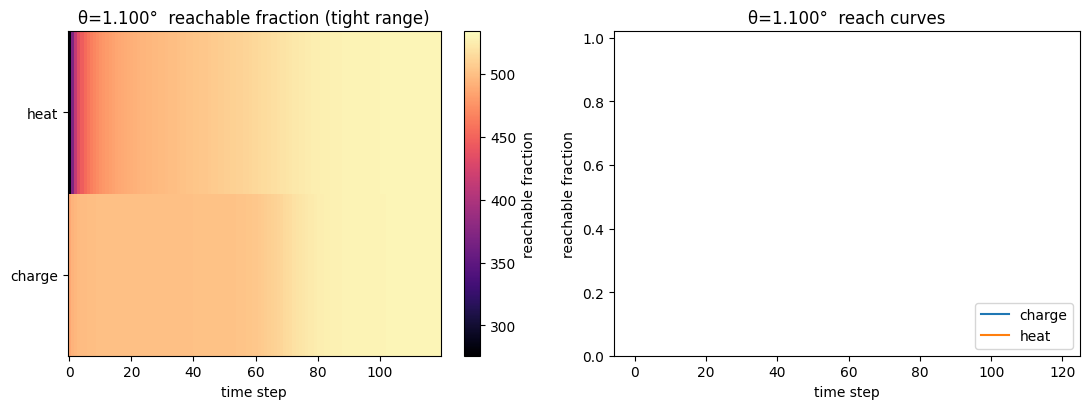

Saved: outputs/reachable_fraction_replot_fixedrange.png
Range used vmin/vmax: 275.913 533.937


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

NPZ_PATH = "outputs/aoi_primitive_hbn_graphene_toy.npz"
OUT_PNG  = "outputs/reachable_fraction_replot_fixedrange.png"

D = np.load(NPZ_PATH, allow_pickle=True)

def get_1d(name_candidates):
    for k in name_candidates:
        if k in D:
            x = np.array(D[k]).squeeze()
            if x.ndim == 1:
                return x
    return None

# Prefer time-mean reach fractions if present; else fall back to reachC/reachH
reachC = get_1d(["reach_time_mean_charge", "reachC"])
reachH = get_1d(["reach_time_mean_heat",  "reachH"])

if reachC is None or reachH is None:
    print("NPZ keys:", list(D.keys()))
    raise KeyError("Couldn't find 1D reach arrays. Need reachC/reachH or reach_time_mean_charge/heat.")

T = min(len(reachC), len(reachH))
reachC = reachC[:T].astype(float)
reachH = reachH[:T].astype(float)

# Stack into 2×T heatmap: row0=charge, row1=heat
reach_mat = np.vstack([reachC, reachH])

# Data-driven tight range (fixes the 'all yellow' problem)
lo = np.nanmin(reach_mat)
hi = np.nanmax(reach_mat)
pad = 0.02 * (hi - lo) if hi > lo else 0.01
vmin = lo - pad
vmax = hi + pad

theta = float(D["theta_deg"]) if "theta_deg" in D else None

fig = plt.figure(figsize=(11, 4.2))

# ---- Left: reachable fraction heatmap (proper range) ----
ax1 = plt.subplot(1, 2, 1)
im = ax1.imshow(
    reach_mat,
    origin="lower",
    aspect="auto",
    cmap="magma",
    vmin=vmin,
    vmax=vmax,
    interpolation="nearest",
)
ax1.set_yticks([0, 1])
ax1.set_yticklabels(["charge", "heat"])
ax1.set_xlabel("time step")
title_left = "reachable fraction (tight range)"
if theta is not None:
    title_left = f"θ={theta:.3f}°  {title_left}"
ax1.set_title(title_left)
cbar = plt.colorbar(im, ax=ax1)
cbar.set_label("reachable fraction")

# ---- Right: reach curves ----
ax2 = plt.subplot(1, 2, 2)
ax2.plot(np.arange(T), reachC, label="charge")
ax2.plot(np.arange(T), reachH, label="heat")
ax2.set_ylim(0, 1.02)
ax2.set_xlabel("time step")
ax2.set_ylabel("reachable fraction")
title_right = "reach curves"
if theta is not None:
    title_right = f"θ={theta:.3f}°  {title_right}"
ax2.set_title(title_right)
ax2.legend(loc="lower right")

plt.tight_layout()
plt.savefig(OUT_PNG, dpi=220)
plt.show()

print("Saved:", OUT_PNG)
print("Range used vmin/vmax:", vmin, vmax)

NameError: name 'jet' is not defined

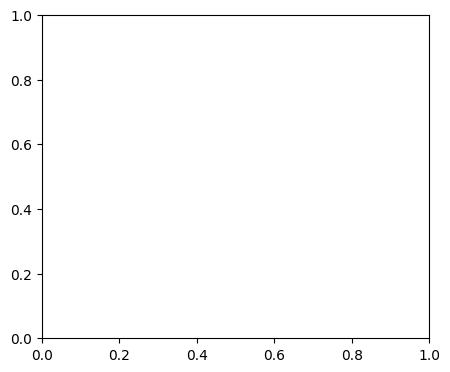

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm

NPZ_PATH = "outputs/aoi_primitive_hbn_graphene_toy.npz"
OUT_PNG  = "outputs/reach_fraction_fireice.png"

# FireIce (blue -> white -> red)
fireice = LinearSegmentedColormap.from_list(
    "fireice",
    ["#053061", "#2166ac", "#67a9cf", "#f7f7f7", "#f4a582", "#d6604d", "#67001f"],
    N=256,
)

D = np.load(NPZ_PATH, allow_pickle=True)

def get_1d(name_candidates):
    for k in name_candidates:
        if k in D:
            x = np.array(D[k]).squeeze()
            if x.ndim == 1:
                return x
    return None

reachC = get_1d(["reachC", "reach_time_mean_charge"])
reachH = get_1d(["reachH", "reach_time_mean_heat"])
maskC  = np.array(D["maskC"]).astype(np.uint8) if "maskC" in D else None
maskH  = np.array(D["maskH"]).astype(np.uint8) if "maskH" in D else None

if reachC is None or reachH is None or maskC is None or maskH is None:
    print("NPZ keys:", list(D.keys()))
    raise KeyError("Need reachC/reachH (or reach_time_mean_*) AND maskC/maskH in the NPZ.")

T = min(len(reachC), len(reachH))
reachC = reachC[:T].astype(float)
reachH = reachH[:T].astype(float)

# Active-site counts (denominators)
NC = int(np.sum(maskC > 0))
NH = int(np.sum(maskH > 0))
if NC <= 0 or NH <= 0:
    raise ValueError("maskC/maskH have zero active sites?")

# Convert counts -> fractions
reachC_frac = reachC / NC
reachH_frac = reachH / NH

# 2×T heatmap
reach_mat = np.vstack([reachC_frac, reachH_frac])

theta = float(D["theta_deg"]) if "theta_deg" in D else None

# For this plot, FireIce works best if we emphasize deviation from 1 (near-saturation),
# centered at 0 deviation (white).
dev = reach_mat - 1.0
vmax = np.nanmax(np.abs(dev))
vmax = max(vmax, 1e-6)
norm = TwoSlopeNorm(vmin=-vmax, vcenter=0.0, vmax=vmax)

fig = plt.figure(figsize=(11, 4.2))

# Left panel: reachable fraction as deviation from 1.0 (FireIce)
ax1 = plt.subplot(1, 2, 1)
im = ax1.imshow(
    dev,
    origin="lower",
    aspect="auto",
    cmap=jet,
    norm=norm,
    interpolation="nearest",
)
ax1.set_yticks([0, 1])
ax1.set_yticklabels(["charge", "heat"])
ax1.set_xlabel("time step")
title_left = "reachable fraction (FireIce; deviation from 1.0)"
if theta is not None:
    title_left = f"θ={theta:.3f}°  " + title_left
ax1.set_title(title_left)
cbar = plt.colorbar(im, ax=ax1)
cbar.set_label("reach_fraction − 1.0")

# Right panel: reach curves (fractions)
ax2 = plt.subplot(1, 2, 2)
ax2.plot(np.arange(T), reachC_frac, label="charge")
ax2.plot(np.arange(T), reachH_frac, label="heat")
ax2.set_ylim(0, 1.02)
ax2.set_xlabel("time step")
ax2.set_ylabel("reachable fraction")
title_right = "reach curves (fraction)"
if theta is not None:
    title_right = f"θ={theta:.3f}°  " + title_right
ax2.set_title(title_right)
ax2.legend(loc="lower right")

plt.tight_layout()
plt.savefig(OUT_PNG, dpi=220)
plt.show()

print("Saved:", OUT_PNG)
print("Active sites NC,NH:", NC, NH)
print("reachC count range:", float(np.min(reachC)), float(np.max(reachC)))
print("reachH count range:", float(np.min(reachH)), float(np.max(reachH)))
print("reachC frac range:", float(np.min(reachC_frac)), float(np.max(reachC_frac)))
print("reachH frac range:", float(np.min(reachH_frac)), float(np.max(reachH_frac)))

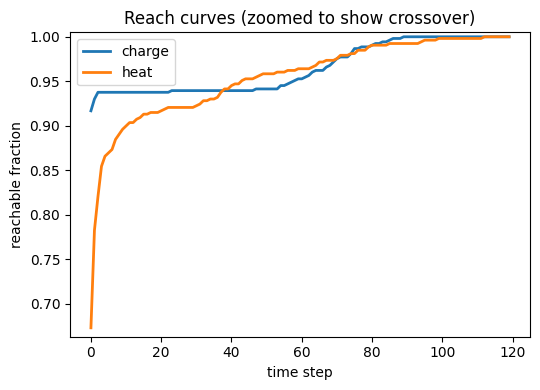

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

reachC_frac = reachC / maskC.sum()
reachH_frac = reachH / maskH.sum()
t = np.arange(len(reachC_frac))

plt.figure(figsize=(5.5,4))

plt.plot(t, reachC_frac, label="charge", lw=2)
plt.plot(t, reachH_frac, label="heat", lw=2)

# Zoom where the action actually is
ymin = min(reachC_frac.min(), reachH_frac.min()) - 0.01
ymax = max(reachC_frac.max(), reachH_frac.max()) + 0.005
plt.ylim(ymin, ymax)

plt.xlabel("time step")
plt.ylabel("reachable fraction")
plt.title("Reach curves (zoomed to show crossover)")
plt.legend()
plt.tight_layout()
plt.show()

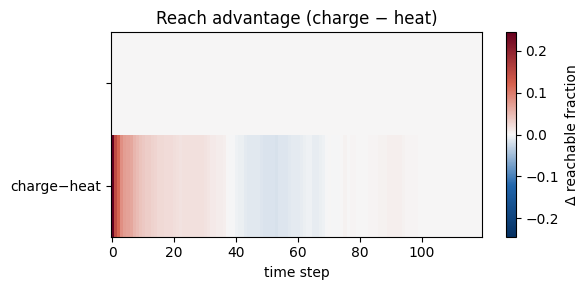

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm

fireice = LinearSegmentedColormap.from_list(
    "fireice",
    ["#053061", "#2166ac", "#f7f7f7", "#d6604d", "#67001f"],
    N=256,
)

reachC_frac = reachC / maskC.sum()
reachH_frac = reachH / maskH.sum()

diff = reachC_frac - reachH_frac
mat = np.vstack([diff, diff*0])  # dummy second row for layout

vmax = np.max(np.abs(diff))
norm = TwoSlopeNorm(vmin=-vmax, vcenter=0.0, vmax=vmax)

plt.figure(figsize=(6,3))
plt.imshow(mat[:2,:], origin="lower", aspect="auto",
           cmap=fireice, norm=norm)

plt.yticks([0,1], ["charge−heat",""])
plt.xlabel("time step")
plt.title("Reach advantage (charge − heat)")
plt.colorbar(label="Δ reachable fraction")
plt.tight_layout()
plt.show()

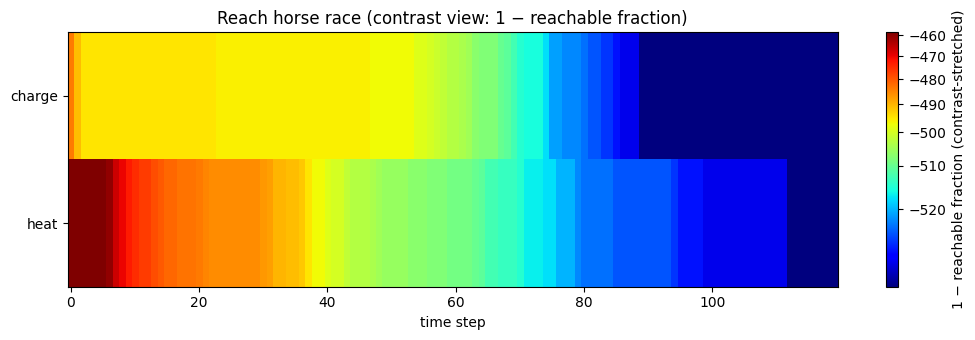

Saved: outputs/reach_horse_race_contrast_jet.png
Contrast range (vmin/vmax on 1-reach): -528.0 -458.56


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm

# --------- load ----------
npz_path = "outputs/aoi_primitive_hbn_graphene_toy.npz"
D = np.load(npz_path, allow_pickle=True)

reachC = D["reachC"]   # shape (T,)
reachH = D["reachH"]   # shape (T,)

# stack into 2 x T "horse race"
R = np.vstack([reachC, reachH])  # (2, T)

# --------- option: choose colormap ----------
# 'jet' exists by default in matplotlib:
cmap = "jet"   # or try: "turbo", "viridis", "plasma", "inferno"

# --------- contrast strategy ----------
# Strategy 1 (recommended for auditorium): plot "unreached" = 1 - reach
U = 1.0 - R

# robust range to avoid being dominated by single outliers
lo, hi = np.percentile(U, [2, 98])

# gamma < 1 boosts contrast near low values (late-time tiny differences)
norm = PowerNorm(gamma=0.55, vmin=lo, vmax=hi)

# --------- plot ----------
plt.figure(figsize=(10.5, 3.5))
im = plt.imshow(U, aspect="auto", origin="upper", cmap=cmap, norm=norm, interpolation="nearest")

plt.yticks([0, 1], ["charge", "heat"])
plt.xlabel("time step")
plt.title("Reach horse race (contrast view: 1 − reachable fraction)")

cbar = plt.colorbar(im)
cbar.set_label("1 − reachable fraction (contrast-stretched)")

out_png = "outputs/reach_horse_race_contrast_jet.png"
plt.tight_layout()
plt.savefig(out_png, dpi=220)
plt.show()

print("Saved:", out_png)
print("Contrast range (vmin/vmax on 1-reach):", float(lo), float(hi))

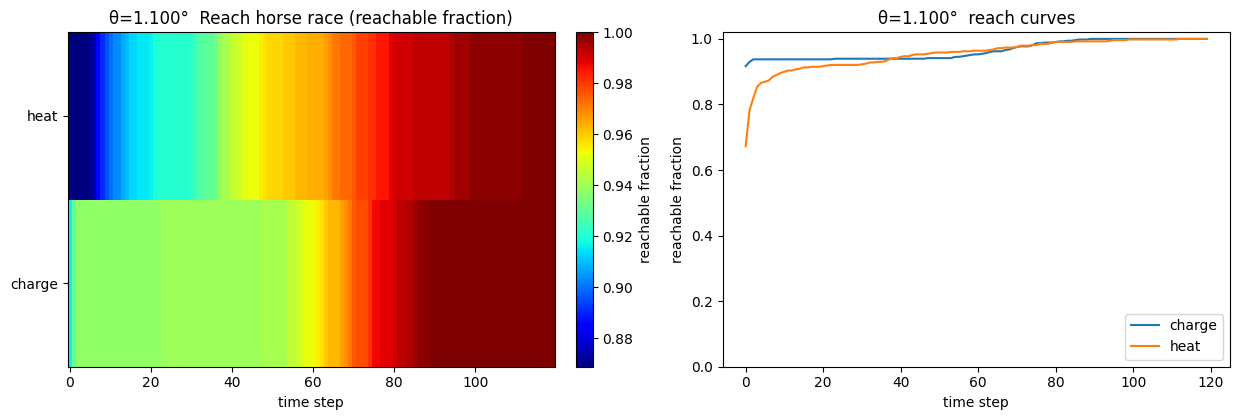

Saved: outputs/reach_horse_race_jet.png
reachC counts range: 485.0 529.0   active NC= 529
reachH counts range: 356.0 529.0   active NH= 529
Displayed vmin/vmax: 0.8687334593572779 1.0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

NPZ_PATH = "outputs/aoi_primitive_hbn_graphene_toy.npz"  # change if needed

D = np.load(NPZ_PATH, allow_pickle=True)

# --- required keys (based on your dump) ---
reachC = np.asarray(D["reachC"]).astype(float)   # length T
reachH = np.asarray(D["reachH"]).astype(float)   # length T
maskC  = np.asarray(D["maskC"]).astype(bool)     # length Nx*Ny
maskH  = np.asarray(D["maskH"]).astype(bool)     # length Nx*Ny
theta  = float(D["theta_deg"]) if "theta_deg" in D else None

NC = int(maskC.sum())  # active nodes for charge mask
NH = int(maskH.sum())  # active nodes for heat mask

# --- counts -> fractions ---
reachC_frac = reachC / max(NC, 1)
reachH_frac = reachH / max(NH, 1)

# --- 2 x T horse race array ---
horse = np.vstack([reachC_frac, reachH_frac])  # rows: charge, heat

# Choose whether to plot direct fraction or "contrast" (1 - fraction)
USE_CONTRAST = False  # set True if you prefer emphasising late-stage differences

if USE_CONTRAST:
    field = 1.0 - horse
    title_left = "Reach horse race (contrast view: 1 − reachable fraction)"
    cbar_label = "1 − reachable fraction"
else:
    field = horse
    title_left = "Reach horse race (reachable fraction)"
    cbar_label = "reachable fraction"

# --- robust display range: percentiles help avoid “all yellow” saturation ---
vmin = float(np.percentile(field, 2))
vmax = float(np.percentile(field, 98))

fig, (axL, axR) = plt.subplots(1, 2, figsize=(12.5, 4.3), gridspec_kw={"width_ratios": [1.05, 1.0]})

im = axL.imshow(field, origin="lower", aspect="auto", cmap="jet", vmin=vmin, vmax=vmax, interpolation="nearest")
axL.set_yticks([0, 1])
axL.set_yticklabels(["charge", "heat"])
axL.set_xlabel("time step")
axL.set_title(f"θ={theta:.3f}°  {title_left}" if theta is not None else title_left)
cb = plt.colorbar(im, ax=axL, fraction=0.046, pad=0.04)
cb.set_label(cbar_label)

# --- RHS: the actual two curves (so the “overtake” is explicit) ---
t = np.arange(len(reachC_frac))
axR.plot(t, reachC_frac, label="charge")
axR.plot(t, reachH_frac, label="heat")
axR.set_ylim(0.0, 1.02)
axR.set_xlabel("time step")
axR.set_ylabel("reachable fraction")
axR.set_title(f"θ={theta:.3f}°  reach curves" if theta is not None else "reach curves")
axR.legend(loc="lower right")

plt.tight_layout()
out_png = "outputs/reach_horse_race_jet.png"
plt.savefig(out_png, dpi=220)
plt.show()

print("Saved:", out_png)
print("reachC counts range:", float(reachC.min()), float(reachC.max()), "  active NC=", NC)
print("reachH counts range:", float(reachH.min()), float(reachH.max()), "  active NH=", NH)
print("Displayed vmin/vmax:", vmin, vmax)

p min/mean/max: 0.026608860841274486 0.444977209944395 0.999218819234196
p min/mean/max: 0.20590159156104176 0.5144145397786913 0.9581455285565548
Saved: outputs/aoi_primitive_hbn_graphene_toy.npz


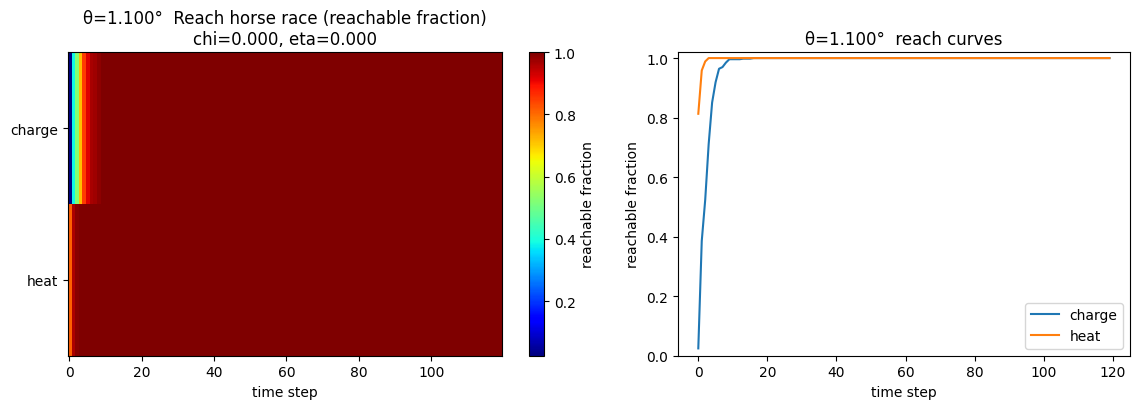

Saved: outputs/aoi_primitive_hbn_graphene_toy_reach_horserace.png


('outputs/aoi_primitive_hbn_graphene_toy.npz',
 'outputs/aoi_primitive_hbn_graphene_toy_reach_horserace.png')

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

# -------------------------
# Helpers
# -------------------------
def sigmoid(kappa, x):
    return 1.0 / (1.0 + np.exp(-kappa * x))

def moire_potential(r, t, gvecs, V0=1.0, omega=1.0):
    # Simple sum of cos modes
    phase = (gvecs @ r) + omega * t
    return V0 * np.cos(phase).sum()

def moire_grad(r, t, gvecs, V0=1.0, omega=1.0):
    # grad cos(g·r + ωt) = -sin(...) * g
    phase = (gvecs @ r) + omega * t
    s = np.sin(phase)  # (M,)
    # sum_m -V0*sin(phase_m)*g_m
    return (-V0) * (s[:, None] * gvecs).sum(axis=0)

def gate_openness(V_mid, kappa=2.0, Vc=0.0):
    return sigmoid(kappa, (V_mid - Vc))

def temporal_reachability_directed(adj_out_all, source):
    """
    Directed version.
    Movement rule unchanged: within each time step, traverse any number of
    directed edges available at that time step (closure).
    """
    reached = set([source])
    reached_over_time = []

    for adj_out in adj_out_all:
        frontier = list(reached)
        visited = set(reached)
        while frontier:
            u = frontier.pop()
            for v in adj_out[u]:
                if v not in visited:
                    visited.add(v)
                    frontier.append(v)
        reached = visited
        reached_over_time.append(len(reached))

    return np.array(reached_over_time, dtype=float)

# -------------------------
# Graph builder with chirality + viscosity
# -------------------------
def build_temporal_edge_weights_directed(
    pts, edges_ij, idx, gvecs, times,
    V0=1.0, omega=1.0,
    kappa=2.0, Vc=0.0,
    chi=0.0,      # chirality strength (0 => symmetric)
    eta=0.0,      # viscosity/memory (0 => no smoothing)
    seed=0
):
    """
    Returns directed adjacency per time step:
      adj_out_all[t][u] = list of v reachable from u at time t

    Chirality:
      bias = chi * sign( z·(bond × gradV_mid) )
      p(u->v) uses +bias; p(v->u) uses -bias

    Viscosity:
      p_t := (1-eta) p_raw_t + eta p_{t-1}
    """
    rng = np.random.default_rng(seed)

    # Precompute edges + midpoints + bond vectors
    edge_u = []
    edge_v = []
    mid = []
    bond = []
    for (aij, bij) in edges_ij:
        u = idx[aij]
        v = idx[bij]
        edge_u.append(u)
        edge_v.append(v)
        rm = 0.5 * (pts[u] + pts[v])
        mid.append(rm)
        b = (pts[v] - pts[u])
        bond.append(b)

    edge_u = np.array(edge_u, dtype=int)
    edge_v = np.array(edge_v, dtype=int)
    mid = np.array(mid, dtype=float)
    bond = np.array(bond, dtype=float)

    nV = len(edge_u)
    adj_out_all = []

    # viscosity state (per directed edge we still smooth the base p_raw on undirected mid)
    p_prev = None

    for t_idx, t in enumerate(times):
        # base scalar potential at midpoints
        Vm = np.array([moire_potential(rm, t, gvecs, V0=V0, omega=omega) for rm in mid])
        p_raw = gate_openness(Vm, kappa=kappa, Vc=Vc)

        if eta != 0.0:
            if p_prev is None:
                p_smooth = p_raw.copy()
            else:
                p_smooth = (1.0 - eta) * p_raw + eta * p_prev
            p_prev = p_smooth.copy()
        else:
            p_smooth = p_raw

        # chirality sign from bond x gradV (z-component)
        if chi != 0.0:
            gradV = np.array([moire_grad(rm, t, gvecs, V0=V0, omega=omega) for rm in mid])
            # z·(bond × gradV) = bond_x*grad_y - bond_y*grad_x
            zcross = bond[:, 0] * gradV[:, 1] - bond[:, 1] * gradV[:, 0]
            sgn = np.sign(zcross)
            bias = chi * sgn
        else:
            bias = 0.0

        # Directed probabilities (clipped for safety)
        # Use logistic in "potential space" by shifting the sigmoid input:
        # equivalently: adjust Vm by +/- (bias/kappa) (simple, stable)
        if chi != 0.0:
            # convert bias into an additive shift on the sigmoid input
            # (so chi behaves roughly like a gate "field", not like a probability delta)
            x = (Vm - Vc)
            p_uv = sigmoid(kappa, x + bias)
            p_vu = sigmoid(kappa, x - bias)
            # viscosity acts on the base openness: blend with smoothed p
            if eta != 0.0:
                p_uv = (1.0 - eta) * p_uv + eta * p_smooth
                p_vu = (1.0 - eta) * p_vu + eta * p_smooth
        else:
            p_uv = p_smooth
            p_vu = p_smooth

        p_uv = np.clip(p_uv, 0.0, 1.0)
        p_vu = np.clip(p_vu, 0.0, 1.0)

        if t_idx == 0:
            print("p min/mean/max:", float(np.min(p_smooth)), float(np.mean(p_smooth)), float(np.max(p_smooth)))
            if chi != 0.0:
                print("chiral bias sign counts:", int((bias > 0).sum()), int((bias < 0).sum()), int((bias == 0).sum()))

        # Sample directed openings
        open_uv = rng.random(nV) < p_uv
        open_vu = rng.random(nV) < p_vu

        # Build directed adjacency
        N = len(pts)
        adj_out = [[] for _ in range(N)]
        uu = edge_u
        vv = edge_v
        for i in range(nV):
            u = uu[i]; v = vv[i]
            if open_uv[i]:
                adj_out[u].append(v)
            if open_vu[i]:
                adj_out[v].append(u)

        adj_out_all.append(adj_out)

    return adj_out_all

# -------------------------
# Minimal lattice + moiré vectors (reuse your existing ones if you want)
# -------------------------
def make_square_grid(Nx=23, Ny=23, a=1.0):
    pts = []
    idx = {}
    for iy in range(Ny):
        for ix in range(Nx):
            k = (ix, iy)
            idx[k] = len(pts)
            pts.append(np.array([a * ix, a * iy], dtype=float))
    pts = np.array(pts)
    edges = []
    for iy in range(Ny):
        for ix in range(Nx):
            if ix + 1 < Nx:
                edges.append(((ix, iy), (ix + 1, iy)))
            if iy + 1 < Ny:
                edges.append(((ix, iy), (ix, iy + 1)))
    return pts, edges, idx

def moire_gvecs(theta_deg=1.1, a_g=1.0):
    # Simple 3-mode reciprocal vectors rotated by theta
    th = np.deg2rad(theta_deg)
    # base triad
    g0 = (2*np.pi/a_g) * np.array([
        [1.0, 0.0],
        [-0.5,  np.sqrt(3)/2],
        [-0.5, -np.sqrt(3)/2],
    ])
    R = np.array([[np.cos(th), -np.sin(th)],
                  [np.sin(th),  np.cos(th)]])
    return (g0 @ R.T)

# -------------------------
# Run + save + plot (horse race)
# -------------------------
def run_once_and_plot(
    out_prefix="outputs/aoi_primitive_hbn_graphene_toy",
    Nx=23, Ny=23,
    theta_deg=1.1, a_g=1.0,
    delta=0.018, V0=1.0, omega=0.8, Tsteps=120,
    charge_params=(2.4, 0.0),
    heat_params=(1.0, -0.15),
    chi=0.0,
    eta=0.0,
    seed=0
):
    os.makedirs("outputs", exist_ok=True)

    pts, edges_ij, idx = make_square_grid(Nx=Nx, Ny=Ny, a=1.0)
    gvecs = moire_gvecs(theta_deg=theta_deg, a_g=a_g)

    times = np.arange(Tsteps) * delta
    source = idx[(Nx // 2, Ny // 2)]

    # Charge
    kC, vC = charge_params
    adjC = build_temporal_edge_weights_directed(
        pts, edges_ij, idx, gvecs, times,
        V0=V0, omega=omega, kappa=kC, Vc=vC,
        chi=chi, eta=eta, seed=seed
    )
    reachC = temporal_reachability_directed(adjC, source)
    reachC_frac = reachC / (Nx * Ny)

    # Heat
    kH, vH = heat_params
    adjH = build_temporal_edge_weights_directed(
        pts, edges_ij, idx, gvecs, times,
        V0=V0, omega=omega, kappa=kH, Vc=vH,
        chi=chi, eta=eta, seed=seed + 1
    )
    reachH = temporal_reachability_directed(adjH, source)
    reachH_frac = reachH / (Nx * Ny)

    # Save NPZ
    npz_path = f"{out_prefix}.npz"
    np.savez(
        npz_path,
        Nx=Nx, Ny=Ny, a_g=a_g, theta_deg=float(theta_deg), delta=float(delta),
        V0=float(V0), omega=float(omega), Tsteps=int(Tsteps),
        charge_kappa=float(kC), charge_Vc=float(vC),
        heat_kappa=float(kH), heat_Vc=float(vH),
        chi=float(chi), eta=float(eta),
        reachC=reachC_frac, reachH=reachH_frac
    )
    print("Saved:", npz_path)

    # Plot: reach horse race (2×T) + curves
    horse = np.vstack([reachH_frac, reachC_frac])  # keep heat on top like your latest
    fig, (axL, axR) = plt.subplots(1, 2, figsize=(11.5, 4.2), gridspec_kw={"width_ratios": [1.2, 1.0]})

    im = axL.imshow(
        horse,
        origin="lower",
        aspect="auto",
        cmap="jet",          # high-contrast
        vmin=float(np.min(horse)),
        vmax=float(np.max(horse)),
        interpolation="nearest"
    )
    axL.set_yticks([0, 1])
    axL.set_yticklabels(["heat", "charge"])
    axL.set_xlabel("time step")
    axL.set_title(f"θ={theta_deg:.3f}°  Reach horse race (reachable fraction)\nchi={chi:.3f}, eta={eta:.3f}")
    cb = plt.colorbar(im, ax=axL)
    cb.set_label("reachable fraction")

    axR.plot(reachC_frac, label="charge")
    axR.plot(reachH_frac, label="heat")
    axR.set_xlabel("time step")
    axR.set_ylabel("reachable fraction")
    axR.set_ylim(0, 1.02)
    axR.set_title(f"θ={theta_deg:.3f}°  reach curves")
    axR.legend(loc="lower right")

    plt.tight_layout()
    out_png = f"{out_prefix}_reach_horserace.png"
    plt.savefig(out_png, dpi=220)
    plt.show()
    print("Saved:", out_png)

    return npz_path, out_png

# -------------------------
# Example run (NO twist sweep; twist fixed)
# -------------------------
run_once_and_plot(
    out_prefix="outputs/aoi_primitive_hbn_graphene_toy",
    Nx=23, Ny=23,
    theta_deg=1.1,
    delta=0.018, V0=1.0, omega=0.8, Tsteps=120,
    charge_params=(2.4, 0.0),
    heat_params=(1.0, -0.15),
    chi=0.0,      # try 0.2, 0.5, -0.5
    eta=0.0,      # try 0.2, 0.5, 0.8
    seed=0
)

p min/mean/max: 0.026608860841274486 0.444977209944395 0.999218819234196
p min/mean/max: 0.20590159156104176 0.5144145397786913 0.9581455285565548
Saved: outputs/aoi_toy_eta_0.00.npz


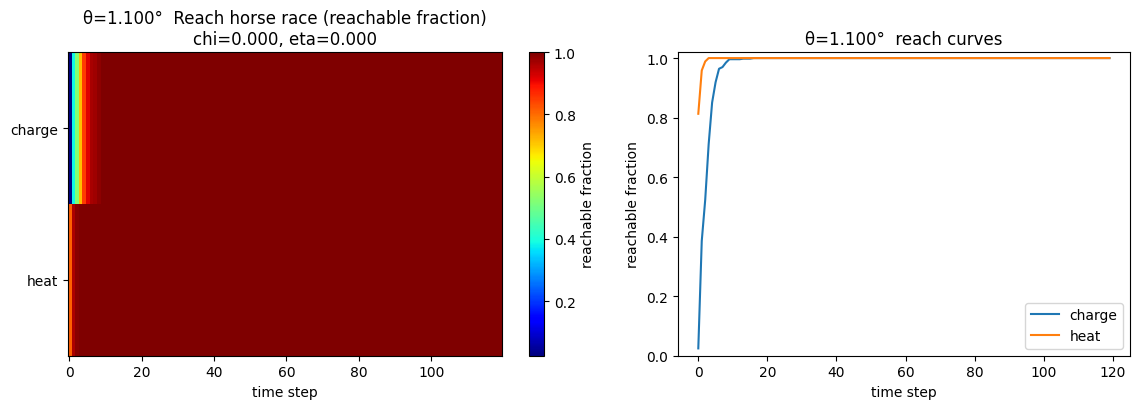

Saved: outputs/aoi_toy_eta_0.00_reach_horserace.png
p min/mean/max: 0.026608860841274486 0.444977209944395 0.999218819234196
p min/mean/max: 0.20590159156104176 0.5144145397786913 0.9581455285565548
Saved: outputs/aoi_toy_eta_0.10.npz


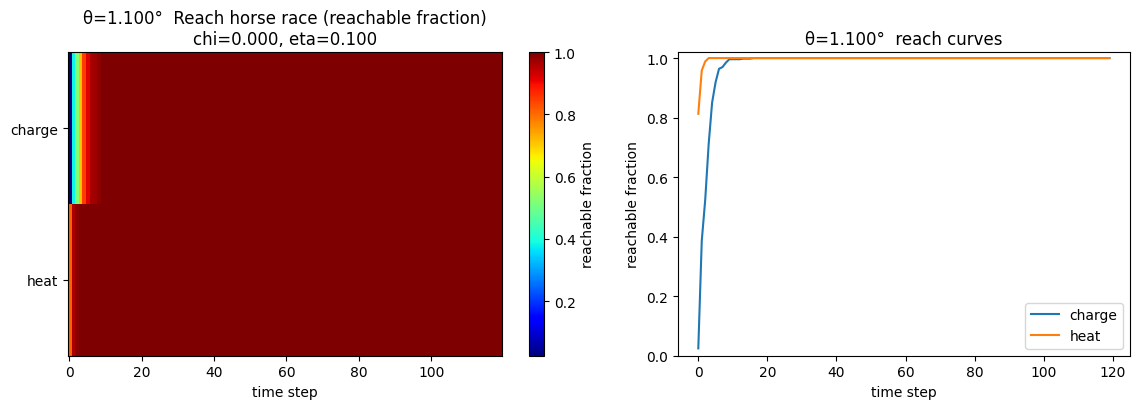

Saved: outputs/aoi_toy_eta_0.10_reach_horserace.png
p min/mean/max: 0.026608860841274486 0.444977209944395 0.999218819234196
p min/mean/max: 0.20590159156104176 0.5144145397786913 0.9581455285565548
Saved: outputs/aoi_toy_eta_0.20.npz


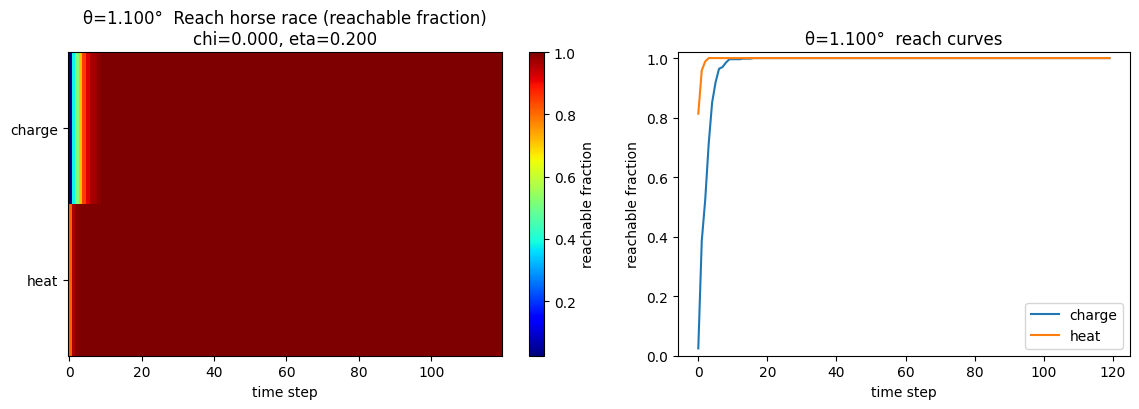

Saved: outputs/aoi_toy_eta_0.20_reach_horserace.png
p min/mean/max: 0.026608860841274486 0.444977209944395 0.999218819234196
p min/mean/max: 0.20590159156104176 0.5144145397786913 0.9581455285565548
Saved: outputs/aoi_toy_eta_0.40.npz


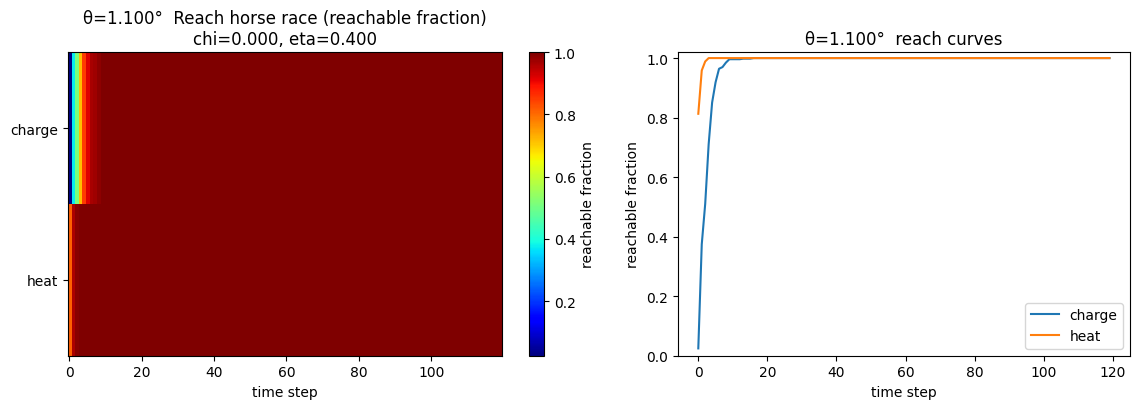

Saved: outputs/aoi_toy_eta_0.40_reach_horserace.png
p min/mean/max: 0.026608860841274486 0.444977209944395 0.999218819234196
p min/mean/max: 0.20590159156104176 0.5144145397786913 0.9581455285565548
Saved: outputs/aoi_toy_eta_0.60.npz


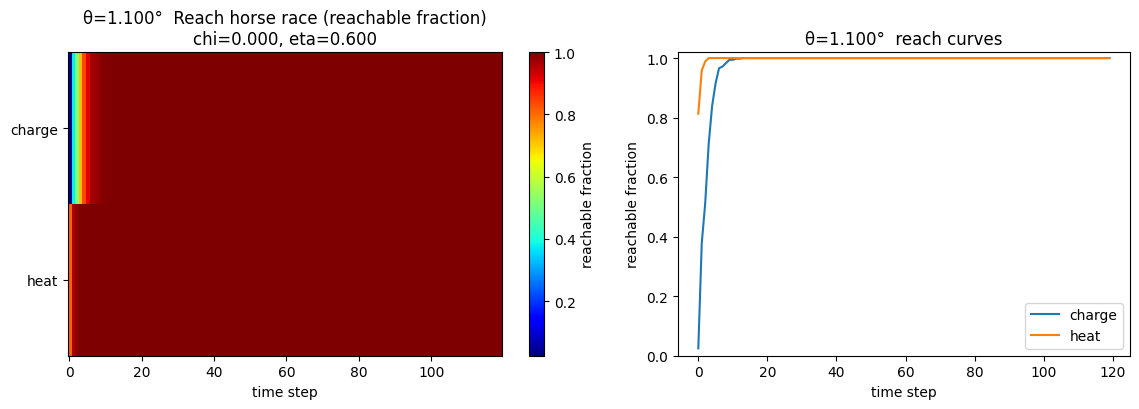

Saved: outputs/aoi_toy_eta_0.60_reach_horserace.png
p min/mean/max: 0.026608860841274486 0.444977209944395 0.999218819234196
p min/mean/max: 0.20590159156104176 0.5144145397786913 0.9581455285565548
Saved: outputs/aoi_toy_eta_0.80.npz


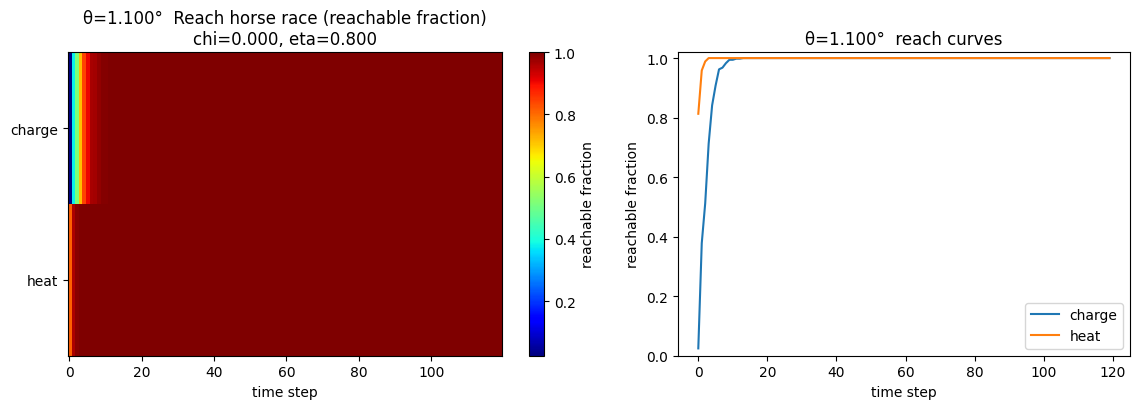

Saved: outputs/aoi_toy_eta_0.80_reach_horserace.png


In [ ]:
etas = [0.0, 0.1, 0.2, 0.4, 0.6, 0.8]
for eta in etas:
    run_once_and_plot(
        out_prefix=f"outputs/aoi_toy_eta_{eta:.2f}",
        theta_deg=1.1,
        Tsteps=120,
        chi=0.0,
        eta=float(eta),
        seed=0
    )

In [ ]:
import numpy as np

paths = [
    "outputs/aoi_toy_eta_0.00.npz",
    "outputs/aoi_toy_eta_0.10.npz",
    "outputs/aoi_toy_eta_0.20.npz",
    "outputs/aoi_toy_eta_0.40.npz",
    "outputs/aoi_toy_eta_0.60.npz",
    "outputs/aoi_toy_eta_0.80.npz",
]

def load_core(p):
    D = np.load(p, allow_pickle=True)
    # adjust keys if yours differ
    pC = D["pC"]
    pH = D["pH"]
    reachC = D["reachC"]
    reachH = D["reachH"]
    return pC, pH, reachC, reachH, D

base_pC, base_pH, base_rC, base_rH, baseD = load_core(paths[0])

print("Base keys include eta?", "eta" in baseD.files, "viscosity" in baseD.files)

for p in paths[1:]:
    pC, pH, rC, rH, D = load_core(p)
    d_pC = np.max(np.abs(pC - base_pC))
    d_pH = np.max(np.abs(pH - base_pH))
    d_rC = np.max(np.abs(rC - base_rC))
    d_rH = np.max(np.abs(rH - base_rH))
    print(p, "max|ΔpC

SyntaxError: unterminated string literal (detected at line 31) (ipython-input-500557894.py, line 31)

In [ ]:
import numpy as np

paths = [
    "outputs/aoi_toy_eta_0.00.npz",
    "outputs/aoi_toy_eta_0.10.npz",
    "outputs/aoi_toy_eta_0.20.npz",
    "outputs/aoi_toy_eta_0.40.npz",
    "outputs/aoi_toy_eta_0.60.npz",
    "outputs/aoi_toy_eta_0.80.npz",
]

def load_core(path):
    D = np.load(path, allow_pickle=True)
    pC = D["pC"]
    pH = D["pH"]
    reachC = D["reachC"]
    reachH = D["reachH"]
    return pC, pH, reachC, reachH, D

base_pC, base_pH, base_rC, base_rH, baseD = load_core(paths[0])

print("Base NPZ keys:", baseD.files)

for p in paths[1:]:
    pC, pH, rC, rH, D = load_core(p)
    d_pC = np.max(np.abs(pC - base_pC))
    d_pH = np.max(np.abs(pH - base_pH))
    d_rC = np.max(np.abs(rC - base_rC))
    d_rH = np.max(np.abs(rH - base_rH))
    print(
        p,
        "ΔpC:", d_pC,
        "ΔpH:", d_pH,
        "ΔreachC:", d_rC,
        "ΔreachH:", d_rH
    )

KeyError: 'pC is not a file in the archive'

In [ ]:
import numpy as np

paths = [
    "outputs/aoi_toy_eta_0.00.npz",
    "outputs/aoi_toy_eta_0.10.npz",
    "outputs/aoi_toy_eta_0.20.npz",
    "outputs/aoi_toy_eta_0.40.npz",
    "outputs/aoi_toy_eta_0.60.npz",
    "outputs/aoi_toy_eta_0.80.npz",
]

def summarize_npz(path, max_keys=80):
    D = np.load(path, allow_pickle=True)
    print("\n==", path, "==")
    keys = list(D.files)
    print("keys:", keys[:max_keys], ("..." if len(keys) > max_keys else ""))
    for k in keys[:max_keys]:
        x = D[k]
        try:
            shape = x.shape
        except Exception:
            shape = "<?>"
        print(f"  {k:24s}  shape={shape}  dtype={getattr(x,'dtype',None)}")
    return D

def pick_arrays(D):
    # Priority: full trajectories -> per-site summaries -> reach curves
    out = {}
    for name, candidates in [
        ("pC", ["pC", "PC", "p_charge", "p_charge_all"]),
        ("pH", ["pH", "PH", "p_heat", "p_heat_all"]),
        ("pC_mean", ["pC_mean", "pC_avg", "p_charge_mean"]),
        ("pH_mean", ["pH_mean", "pH_avg", "p_heat_mean"]),
        ("reachC", ["reachC", "reach_charge", "reach_charge_time", "reach_time_mean_charge"]),
        ("reachH", ["reachH", "reach_heat", "reach_heat_time", "reach_time_mean_heat"]),
    ]:
        for k in candidates:
            if k in D.files:
                out[name] = D[k]
                out[name + "_key"] = k
                break
    return out

def max_abs_diff(a, b):
    if a is None or b is None:
        return None
    if a.shape != b.shape:
        return f"shape_mismatch {a.shape} vs {b.shape}"
    return float(np.max(np.abs(a - b)))

# --- Inspect all files first ---
Ds = [summarize_npz(p) for p in paths]
picked = [pick_arrays(D) for D in Ds]

print("\n--- Auto-detected fields per file ---")
for p, d in zip(paths, picked):
    print(p)
    for k in ["pC","pH","pC_mean","pH_mean","reachC","reachH"]:
        if k in d:
            print(f"  {k:8s} <- {d[k + '_key']}  shape={d[k].shape}")

# --- Compare to baseline using the best available fields ---
base = picked[0]

def get(d, k):
    return d.get(k, None)

print("\n--- Deltas vs baseline ---")
for p, d in zip(paths[1:], picked[1:]):
    # Prefer full pC/pH, else pC_mean/pH_mean, else reachC/reachH
    d_pC = max_abs_diff(get(d,"pC"), get(base,"pC"))
    d_pH = max_abs_diff(get(d,"pH"), get(base,"pH"))
    d_pC_mean = max_abs_diff(get(d,"pC_mean"), get(base,"pC_mean"))
    d_pH_mean = max_abs_diff(get(d,"pH_mean"), get(base,"pH_mean"))
    d_rC = max_abs_diff(get(d,"reachC"), get(base,"reachC"))
    d_rH = max_abs_diff(get(d,"reachH"), get(base,"reachH"))

    print(p)
    print("  ΔpC      =", d_pC)
    print("  ΔpH      =", d_pH)
    print("  ΔpC_mean =", d_pC_mean)
    print("  ΔpH_mean =", d_pH_mean)
    print("  ΔreachC  =", d_rC)
    print("  ΔreachH  =", d_rH)


== outputs/aoi_toy_eta_0.00.npz ==
keys: ['Nx', 'Ny', 'a_g', 'theta_deg', 'delta', 'V0', 'omega', 'Tsteps', 'charge_kappa', 'charge_Vc', 'heat_kappa', 'heat_Vc', 'chi', 'eta', 'reachC', 'reachH'] 
  Nx                        shape=()  dtype=int64
  Ny                        shape=()  dtype=int64
  a_g                       shape=()  dtype=float64
  theta_deg                 shape=()  dtype=float64
  delta                     shape=()  dtype=float64
  V0                        shape=()  dtype=float64
  omega                     shape=()  dtype=float64
  Tsteps                    shape=()  dtype=int64
  charge_kappa              shape=()  dtype=float64
  charge_Vc                 shape=()  dtype=float64
  heat_kappa                shape=()  dtype=float64
  heat_Vc                   shape=()  dtype=float64
  chi                       shape=()  dtype=float64
  eta                       shape=()  dtype=float64
  reachC                    shape=(120,)  dtype=float64
  reachH                

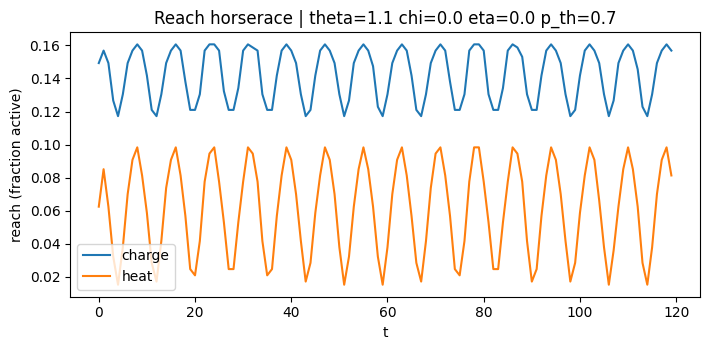

Saved: outputs/aoi_toy_v2_theta1p1_chi0_eta0_thresh.npz
Saved: outputs/aoi_toy_v2_theta1p1_chi0_eta0_thresh_reach_horserace.png
Metrics: lorenz_proxy= 0.4290013374944609 AOI_charge= 0.8633900441083806 AOI_heat= 1.4705734089477 | reach_mode= fraction p_thresh= 0.7


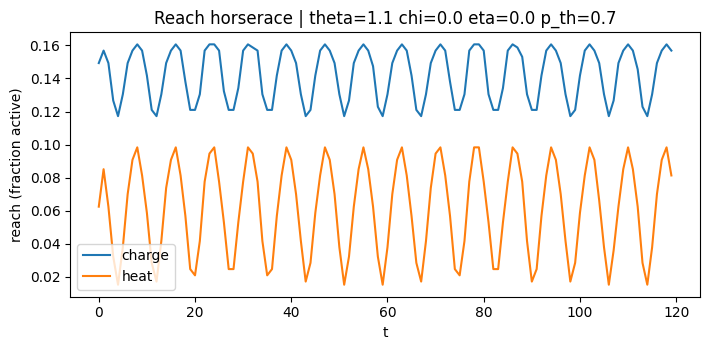

Saved: outputs/aoi_toy_v2_theta1p1_thresh_eta_0.00.npz
Saved: outputs/aoi_toy_v2_theta1p1_thresh_eta_0.00_reach_horserace.png
Metrics: lorenz_proxy= 0.4290013374944609 AOI_charge= 0.8633900441083806 AOI_heat= 1.4705734089477 | reach_mode= fraction p_thresh= 0.7


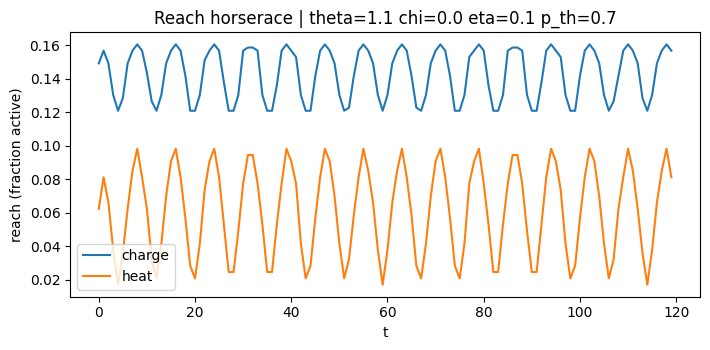

Saved: outputs/aoi_toy_v2_theta1p1_thresh_eta_0.10.npz
Saved: outputs/aoi_toy_v2_theta1p1_thresh_eta_0.10_reach_horserace.png
Metrics: lorenz_proxy= 0.4296040925267241 AOI_charge= 0.8273629489603032 AOI_heat= 1.4016383112791435 | reach_mode= fraction p_thresh= 0.7


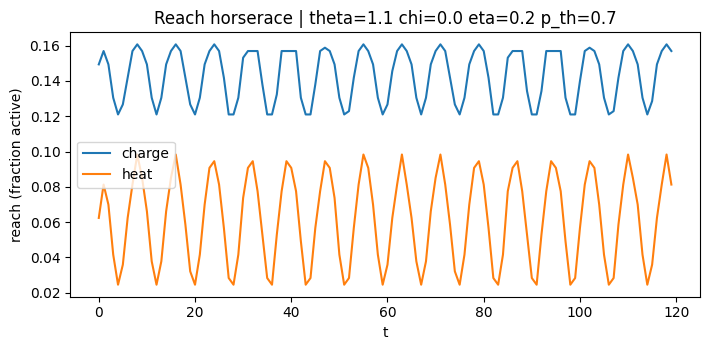

Saved: outputs/aoi_toy_v2_theta1p1_thresh_eta_0.20.npz
Saved: outputs/aoi_toy_v2_theta1p1_thresh_eta_0.20_reach_horserace.png
Metrics: lorenz_proxy= 0.43220998776557706 AOI_charge= 0.8056710775047253 AOI_heat= 1.3274102079395087 | reach_mode= fraction p_thresh= 0.7


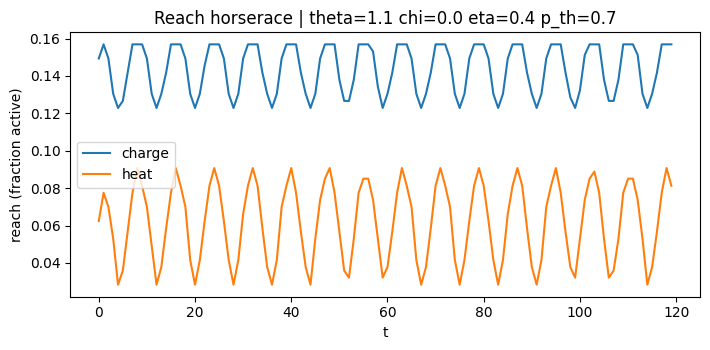

Saved: outputs/aoi_toy_v2_theta1p1_thresh_eta_0.40.npz
Saved: outputs/aoi_toy_v2_theta1p1_thresh_eta_0.40_reach_horserace.png
Metrics: lorenz_proxy= 0.4305478693968236 AOI_charge= 0.7090737240075611 AOI_heat= 1.0998109640831755 | reach_mode= fraction p_thresh= 0.7


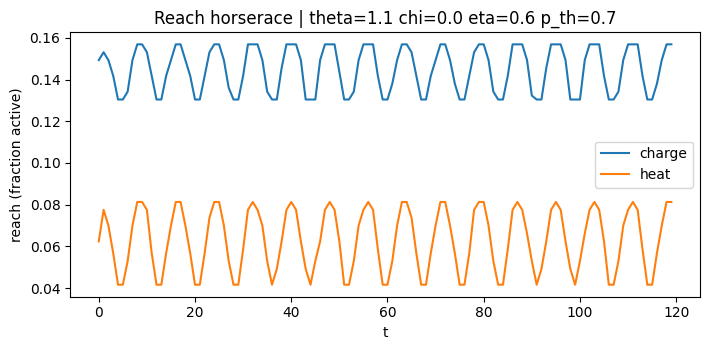

Saved: outputs/aoi_toy_v2_theta1p1_thresh_eta_0.60.npz
Saved: outputs/aoi_toy_v2_theta1p1_thresh_eta_0.60_reach_horserace.png
Metrics: lorenz_proxy= 0.434782608695685 AOI_charge= 0.5836956521739164 AOI_heat= 0.7878859483301832 | reach_mode= fraction p_thresh= 0.7


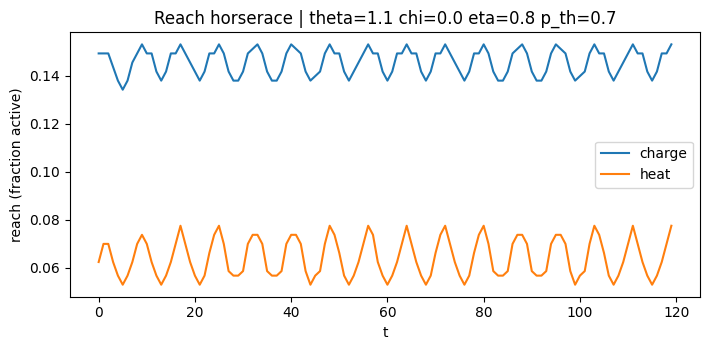

Saved: outputs/aoi_toy_v2_theta1p1_thresh_eta_0.80.npz
Saved: outputs/aoi_toy_v2_theta1p1_thresh_eta_0.80_reach_horserace.png
Metrics: lorenz_proxy= 0.44051902736891224 AOI_charge= 0.28604284814114705 AOI_heat= 0.42129017013232545 | reach_mode= fraction p_thresh= 0.7


[('outputs/aoi_toy_v2_theta1p1_thresh_eta_0.00.npz',
  'outputs/aoi_toy_v2_theta1p1_thresh_eta_0.00_reach_horserace.png'),
 ('outputs/aoi_toy_v2_theta1p1_thresh_eta_0.10.npz',
  'outputs/aoi_toy_v2_theta1p1_thresh_eta_0.10_reach_horserace.png'),
 ('outputs/aoi_toy_v2_theta1p1_thresh_eta_0.20.npz',
  'outputs/aoi_toy_v2_theta1p1_thresh_eta_0.20_reach_horserace.png'),
 ('outputs/aoi_toy_v2_theta1p1_thresh_eta_0.40.npz',
  'outputs/aoi_toy_v2_theta1p1_thresh_eta_0.40_reach_horserace.png'),
 ('outputs/aoi_toy_v2_theta1p1_thresh_eta_0.60.npz',
  'outputs/aoi_toy_v2_theta1p1_thresh_eta_0.60_reach_horserace.png'),
 ('outputs/aoi_toy_v2_theta1p1_thresh_eta_0.80.npz',
  'outputs/aoi_toy_v2_theta1p1_thresh_eta_0.80_reach_horserace.png')]

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Utilities
# -----------------------------
def sigmoid(kappa, x):
    # Prevent exp overflow
    z = np.clip(-kappa * x, -60.0, 60.0)
    return 1.0 / (1.0 + np.exp(z))

def rot(theta):
    c, s = np.cos(theta), np.sin(theta)
    return np.array([[c, -s], [s,  c]])

def moire_reciprocal_vectors(a_g=1.0, delta=0.018, theta=np.deg2rad(1.1)):
    """
    Minimal moiré reciprocal vectors (toy).
    You can replace this with your preferred graphene/hBN construction later.
    """
    b = 4.0 * np.pi / (np.sqrt(3.0) * a_g)
    g1 = b * np.array([1.0, 0.0])
    g2 = b * np.array([-0.5,  np.sqrt(3)/2])
    g3 = b * np.array([-0.5, -np.sqrt(3)/2])

    R = rot(theta)
    s = (1.0 + delta)
    h1 = s * (R @ g1)
    h2 = s * (R @ g2)
    h3 = s * (R @ g3)

    G1 = h1 - g1
    G2 = h2 - g2
    G3 = h3 - g3
    return G1, G2, G3

def build_grid(Nx=23, Ny=23):
    xs = np.arange(Nx)
    ys = np.arange(Ny)
    X, Y = np.meshgrid(xs, ys, indexing="xy")
    pts = np.stack([X.ravel(), Y.ravel()], axis=1).astype(float)
    return pts, X, Y

def compute_field_V(pts, a_g, delta, theta_deg, V0, chi):
    """
    Toy moiré scalar field + a simple chiral perturbation.

    chi here acts like a phase offset that breaks mirror symmetry:
      V(r) = V0 * Σ cos(Gi·r + si*phi)
    with alternating signs si to produce handedness.
    """
    G1, G2, G3 = moire_reciprocal_vectors(a_g=a_g, delta=delta, theta=np.deg2rad(theta_deg))
    phi = chi  # if you want chi in degrees, do phi = np.deg2rad(chi)
    s1, s2, s3 = (+1.0, -1.0, +1.0)

    phase1 = pts @ G1 + s1 * phi
    phase2 = pts @ G2 + s2 * phi
    phase3 = pts @ G3 + s3 * phi

    V = V0 * (np.cos(phase1) + np.cos(phase2) + np.cos(phase3)) / 3.0
    return V

# -----------------------------
# Core sim (v2) with thresholded reach
# -----------------------------
def simulate_aoi_v2(
    Nx=23, Ny=23,
    a_g=1.0, delta=0.018, theta_deg=1.1,
    V0=1.0, omega=0.8,
    Tsteps=120,
    charge_params=(2.4, 0.0),  # (kappa, Vc)
    heat_params=(1.0, -0.15),  # (kappa, Vc)
    chi=0.0,
    eta=0.0,
    seed=0,
    # NEW: reach definition
    p_thresh=0.70,          # decision threshold for "active"
    reach_mode="fraction",  # "fraction" or "count"
):
    """
    AOI-primitive toy v2:
      - Build static spatial field V(r; theta, chi)
      - Drive in time with oscillation
      - Convert to probabilities via sigmoid per channel
      - Apply viscosity as temporal smoothing in probability space
      - Produce reach curves as thresholded activation (not mean probability)
    """
    rng = np.random.default_rng(seed)
    pts, X, Y = build_grid(Nx, Ny)
    nsite = pts.shape[0]

    V_static = compute_field_V(pts, a_g=a_g, delta=delta, theta_deg=theta_deg, V0=V0, chi=chi)

    noise = 0.0 * rng.standard_normal(nsite)

    kC, VcC = charge_params
    kH, VcH = heat_params

    pC = np.zeros((nsite, Tsteps), dtype=float)
    pH = np.zeros((nsite, Tsteps), dtype=float)

    Vt0 = V_static + noise
    pC[:, 0] = sigmoid(kC, Vt0 - VcC)
    pH[:, 0] = sigmoid(kH, Vt0 - VcH)

    for t in range(1, Tsteps):
        drive = np.cos(omega * t)
        Vt = (1.0 + 0.25 * drive) * V_static + noise

        rawC = sigmoid(kC, Vt - VcC)
        rawH = sigmoid(kH, Vt - VcH)

        if eta > 0.0:
            pC[:, t] = (1.0 - eta) * rawC + eta * pC[:, t-1]
            pH[:, t] = (1.0 - eta) * rawH + eta * pH[:, t-1]
        else:
            pC[:, t] = rawC
            pH[:, t] = rawH

    # -----------------------------
    # NEW reach curves: thresholded activation
    # -----------------------------
    actC = (pC > p_thresh)
    actH = (pH > p_thresh)

    if reach_mode == "count":
        reachC = actC.sum(axis=0).astype(float)   # 0..nsite
        reachH = actH.sum(axis=0).astype(float)
        reach_norm = float(nsite)
    else:
        reachC = actC.mean(axis=0).astype(float)  # 0..1
        reachH = actH.mean(axis=0).astype(float)
        reach_norm = 1.0

    # AOI proxy (area above baseline mean) on the *reach* curves
    AOI_charge = float(np.trapezoid(np.maximum(reachC - reachC.mean(), 0.0)))
    AOI_heat   = float(np.trapezoid(np.maximum(reachH - reachH.mean(), 0.0)))

    # Lorenz-ish proxy ratio: compare integrals of reach curves
    eps = 1e-12
    lorenz_proxy = float((np.trapezoid(reachH) + eps) / (np.trapezoid(reachC) + eps))

    out = dict(
        Nx=Nx, Ny=Ny, a_g=a_g, delta=delta, theta_deg=theta_deg,
        V0=V0, omega=omega, Tsteps=Tsteps,
        charge_kappa=kC, charge_Vc=VcC,
        heat_kappa=kH, heat_Vc=VcH,
        chi=chi, eta=eta,
        p_thresh=float(p_thresh),
        reach_mode=str(reach_mode),
        reach_norm=float(reach_norm),

        pC=pC, pH=pH,
        reachC=reachC, reachH=reachH,
        AOI_charge=AOI_charge, AOI_heat=AOI_heat,
        lorenz_proxy=lorenz_proxy,

        # keep your site stats
        pC_min=pC.min(axis=1), pC_mean=pC.mean(axis=1), pC_max=pC.max(axis=1),
        pH_min=pH.min(axis=1), pH_mean=pH.mean(axis=1), pH_max=pH.max(axis=1),
    )
    return out

def save_npz_and_horserace(out, stem="outputs/aoi_toy_v2"):
    os.makedirs(os.path.dirname(stem), exist_ok=True)

    npz_path = stem + ".npz"
    np.savez_compressed(npz_path, **out)

    png_path = stem + "_reach_horserace.png"
    t = np.arange(out["Tsteps"])
    plt.figure(figsize=(7.2, 3.6))
    plt.plot(t, out["reachC"], label="charge")
    plt.plot(t, out["reachH"], label="heat")
    plt.xlabel("t")
    ylabel = "reach (fraction active)" if out["reach_mode"] != "count" else "reach (active count)"
    plt.ylabel(ylabel)
    plt.title(
        f"Reach horserace | theta={out['theta_deg']} chi={out['chi']} eta={out['eta']} p_th={out['p_thresh']}"
    )
    plt.legend()
    plt.tight_layout()
    plt.savefig(png_path, dpi=180)
    plt.show()

    print("Saved:", npz_path)
    print("Saved:", png_path)
    print(
        "Metrics: lorenz_proxy=", out["lorenz_proxy"],
        "AOI_charge=", out["AOI_charge"],
        "AOI_heat=", out["AOI_heat"],
        "| reach_mode=", out["reach_mode"],
        "p_thresh=", out["p_thresh"],
    )
    return npz_path, png_path

# -----------------------------
# Run once (fixed twist)
# -----------------------------
base = simulate_aoi_v2(
    Nx=23, Ny=23,
    a_g=1.0, delta=0.018, theta_deg=1.1,
    V0=1.0, omega=0.8, Tsteps=120,
    charge_params=(2.4, 0.0),
    heat_params=(1.0, -0.15),
    chi=0.0,
    eta=0.0,
    seed=0,
    p_thresh=0.70,
    reach_mode="fraction",
)
save_npz_and_horserace(base, stem="outputs/aoi_toy_v2_theta1p1_chi0_eta0_thresh")

# -----------------------------
# Sweeps (one knob at a time)
# -----------------------------
def sweep_eta(etas, fixed_kwargs, out_prefix="outputs/aoi_toy_v2"):
    results = []
    for eta in etas:
        out = simulate_aoi_v2(**fixed_kwargs, eta=float(eta))
        stem = f"{out_prefix}_eta_{eta:.2f}"
        results.append(save_npz_and_horserace(out, stem=stem))
    return results

def sweep_chi(chis, fixed_kwargs, out_prefix="outputs/aoi_toy_v2"):
    results = []
    for chi in chis:
        out = simulate_aoi_v2(**fixed_kwargs, chi=float(chi))
        stem = f"{out_prefix}_chi_{chi:.3f}"
        results.append(save_npz_and_horserace(out, stem=stem))
    return results

def sweep_twist(thetas_deg, fixed_kwargs, out_prefix="outputs/aoi_toy_v2"):
    results = []
    for th in thetas_deg:
        out = simulate_aoi_v2(**fixed_kwargs, theta_deg=float(th))
        stem = f"{out_prefix}_theta_{th:.2f}"
        results.append(save_npz_and_horserace(out, stem=stem))
    return results

fixed = dict(
    Nx=23, Ny=23,
    a_g=1.0, delta=0.018, theta_deg=1.1,
    V0=1.0, omega=0.8, Tsteps=120,
    charge_params=(2.4, 0.0),
    heat_params=(1.0, -0.15),
    chi=0.0,

    seed=0,
    p_thresh=0.70,
    reach_mode="fraction",
)

# Example sweeps (uncomment when you want them)
sweep_eta([0.0, 0.1, 0.2, 0.4, 0.6, 0.8], fixed, out_prefix="outputs/aoi_toy_v2_theta1p1_thresh")
# sweep_chi([0.0, 0.5, 1.0, 1.5, 2.0], fixed, out_prefix="outputs/aoi_toy_v2_theta1p1_thresh")
# sweep_twist([0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0], fixed, out_prefix="outputs/aoi_toy_v2_chi0_eta0_thresh")

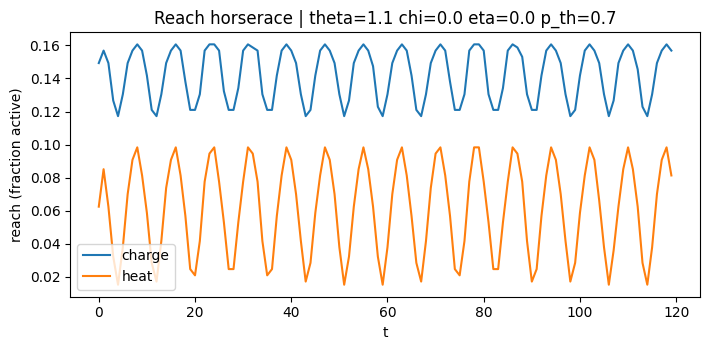

Saved: outputs/aoi_toy_v2_theta1p1_chi0_eta0_thresh.npz
Saved: outputs/aoi_toy_v2_theta1p1_chi0_eta0_thresh_reach_horserace.png
Metrics: lorenz_proxy= 0.4290013374944609 AOI_charge= 0.8633900441083806 AOI_heat= 1.4705734089477 | reach_mode= fraction p_thresh= 0.7


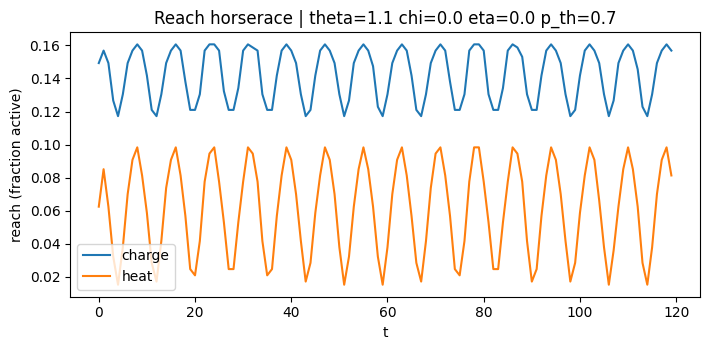

Saved: outputs/aoi_toy_v2_theta1p1_thresh_eta_0.00.npz
Saved: outputs/aoi_toy_v2_theta1p1_thresh_eta_0.00_reach_horserace.png
Metrics: lorenz_proxy= 0.4290013374944609 AOI_charge= 0.8633900441083806 AOI_heat= 1.4705734089477 | reach_mode= fraction p_thresh= 0.7


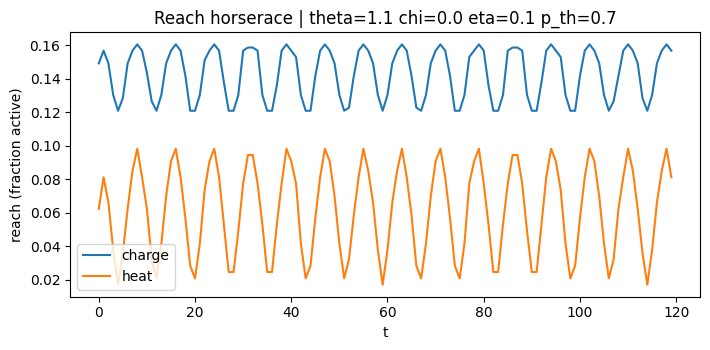

Saved: outputs/aoi_toy_v2_theta1p1_thresh_eta_0.10.npz
Saved: outputs/aoi_toy_v2_theta1p1_thresh_eta_0.10_reach_horserace.png
Metrics: lorenz_proxy= 0.4296040925267241 AOI_charge= 0.8273629489603032 AOI_heat= 1.4016383112791435 | reach_mode= fraction p_thresh= 0.7


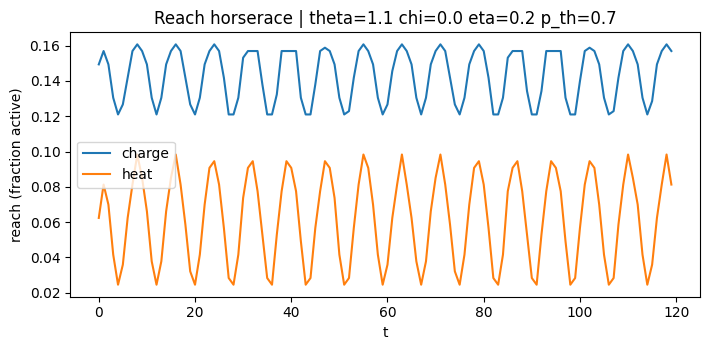

Saved: outputs/aoi_toy_v2_theta1p1_thresh_eta_0.20.npz
Saved: outputs/aoi_toy_v2_theta1p1_thresh_eta_0.20_reach_horserace.png
Metrics: lorenz_proxy= 0.43220998776557706 AOI_charge= 0.8056710775047253 AOI_heat= 1.3274102079395087 | reach_mode= fraction p_thresh= 0.7


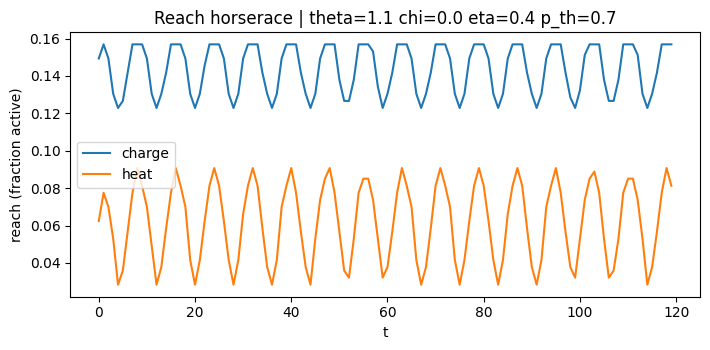

Saved: outputs/aoi_toy_v2_theta1p1_thresh_eta_0.40.npz
Saved: outputs/aoi_toy_v2_theta1p1_thresh_eta_0.40_reach_horserace.png
Metrics: lorenz_proxy= 0.4305478693968236 AOI_charge= 0.7090737240075611 AOI_heat= 1.0998109640831755 | reach_mode= fraction p_thresh= 0.7


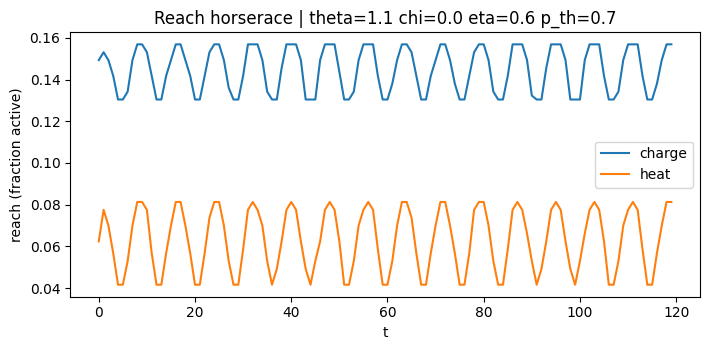

Saved: outputs/aoi_toy_v2_theta1p1_thresh_eta_0.60.npz
Saved: outputs/aoi_toy_v2_theta1p1_thresh_eta_0.60_reach_horserace.png
Metrics: lorenz_proxy= 0.434782608695685 AOI_charge= 0.5836956521739164 AOI_heat= 0.7878859483301832 | reach_mode= fraction p_thresh= 0.7


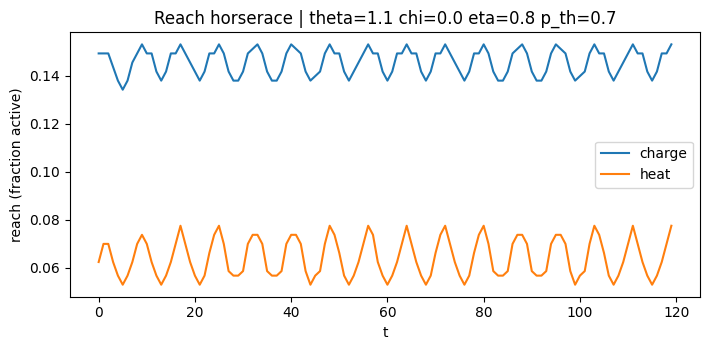

Saved: outputs/aoi_toy_v2_theta1p1_thresh_eta_0.80.npz
Saved: outputs/aoi_toy_v2_theta1p1_thresh_eta_0.80_reach_horserace.png
Metrics: lorenz_proxy= 0.44051902736891224 AOI_charge= 0.28604284814114705 AOI_heat= 0.42129017013232545 | reach_mode= fraction p_thresh= 0.7


[('outputs/aoi_toy_v2_theta1p1_thresh_eta_0.00.npz',
  'outputs/aoi_toy_v2_theta1p1_thresh_eta_0.00_reach_horserace.png'),
 ('outputs/aoi_toy_v2_theta1p1_thresh_eta_0.10.npz',
  'outputs/aoi_toy_v2_theta1p1_thresh_eta_0.10_reach_horserace.png'),
 ('outputs/aoi_toy_v2_theta1p1_thresh_eta_0.20.npz',
  'outputs/aoi_toy_v2_theta1p1_thresh_eta_0.20_reach_horserace.png'),
 ('outputs/aoi_toy_v2_theta1p1_thresh_eta_0.40.npz',
  'outputs/aoi_toy_v2_theta1p1_thresh_eta_0.40_reach_horserace.png'),
 ('outputs/aoi_toy_v2_theta1p1_thresh_eta_0.60.npz',
  'outputs/aoi_toy_v2_theta1p1_thresh_eta_0.60_reach_horserace.png'),
 ('outputs/aoi_toy_v2_theta1p1_thresh_eta_0.80.npz',
  'outputs/aoi_toy_v2_theta1p1_thresh_eta_0.80_reach_horserace.png')]

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Utilities
# -----------------------------
def sigmoid(kappa, x):
    # Prevent exp overflow
    z = np.clip(-kappa * x, -60.0, 60.0)
    return 1.0 / (1.0 + np.exp(z))

def rot(theta):
    c, s = np.cos(theta), np.sin(theta)
    return np.array([[c, -s], [s,  c]])

def moire_reciprocal_vectors(a_g=1.0, delta=0.018, theta=np.deg2rad(1.1)):
    """
    Minimal moiré reciprocal vectors (toy).
    You can replace this with your preferred graphene/hBN construction later.
    """
    b = 4.0 * np.pi / (np.sqrt(3.0) * a_g)
    g1 = b * np.array([1.0, 0.0])
    g2 = b * np.array([-0.5,  np.sqrt(3)/2])
    g3 = b * np.array([-0.5, -np.sqrt(3)/2])

    R = rot(theta)
    s = (1.0 + delta)
    h1 = s * (R @ g1)
    h2 = s * (R @ g2)
    h3 = s * (R @ g3)

    G1 = h1 - g1
    G2 = h2 - g2
    G3 = h3 - g3
    return G1, G2, G3

def build_grid(Nx=23, Ny=23):
    xs = np.arange(Nx)
    ys = np.arange(Ny)
    X, Y = np.meshgrid(xs, ys, indexing="xy")
    pts = np.stack([X.ravel(), Y.ravel()], axis=1).astype(float)
    return pts, X, Y

def compute_field_V(pts, a_g, delta, theta_deg, V0, chi):
    """
    Toy moiré scalar field + a simple chiral perturbation.

    chi here acts like a phase offset that breaks mirror symmetry:
      V(r) = V0 * Σ cos(Gi·r + si*phi)
    with alternating signs si to produce handedness.
    """
    G1, G2, G3 = moire_reciprocal_vectors(a_g=a_g, delta=delta, theta=np.deg2rad(theta_deg))
    phi = chi  # if you want chi in degrees, do phi = np.deg2rad(chi)
    s1, s2, s3 = (+1.0, -1.0, +1.0)

    phase1 = pts @ G1 + s1 * phi
    phase2 = pts @ G2 + s2 * phi
    phase3 = pts @ G3 + s3 * phi

    V = V0 * (np.cos(phase1) + np.cos(phase2) + np.cos(phase3)) / 3.0
    return V

# -----------------------------
# Core sim (v2) with thresholded reach
# -----------------------------
def simulate_aoi_v2(
    Nx=23, Ny=23,
    a_g=1.0, delta=0.018, theta_deg=1.1,
    V0=1.0, omega=0.8,
    Tsteps=120,
    charge_params=(2.4, 0.0),  # (kappa, Vc)
    heat_params=(1.0, -0.15),  # (kappa, Vc)
    chi=0.0,
    eta=0.0,
    seed=0,
    # NEW: reach definition
    p_thresh=0.70,          # decision threshold for "active"
    reach_mode="fraction",  # "fraction" or "count"
):
    """
    AOI-primitive toy v2:
      - Build static spatial field V(r; theta, chi)
      - Drive in time with oscillation
      - Convert to probabilities via sigmoid per channel
      - Apply viscosity as temporal smoothing in probability space
      - Produce reach curves as thresholded activation (not mean probability)
    """
    rng = np.random.default_rng(seed)
    pts, X, Y = build_grid(Nx, Ny)
    nsite = pts.shape[0]

    V_static = compute_field_V(pts, a_g=a_g, delta=delta, theta_deg=theta_deg, V0=V0, chi=chi)

    noise = 0.0 * rng.standard_normal(nsite)

    kC, VcC = charge_params
    kH, VcH = heat_params

    pC = np.zeros((nsite, Tsteps), dtype=float)
    pH = np.zeros((nsite, Tsteps), dtype=float)

    Vt0 = V_static + noise
    pC[:, 0] = sigmoid(kC, Vt0 - VcC)
    pH[:, 0] = sigmoid(kH, Vt0 - VcH)

    for t in range(1, Tsteps):
        drive = np.cos(omega * t)
        Vt = (1.0 + 0.25 * drive) * V_static + noise

        rawC = sigmoid(kC, Vt - VcC)
        rawH = sigmoid(kH, Vt - VcH)

        if eta > 0.0:
            pC[:, t] = (1.0 - eta) * rawC + eta * pC[:, t-1]
            pH[:, t] = (1.0 - eta) * rawH + eta * pH[:, t-1]
        else:
            pC[:, t] = rawC
            pH[:, t] = rawH

    # -----------------------------
    # NEW reach curves: thresholded activation
    # -----------------------------
    actC = (pC > p_thresh)
    actH = (pH > p_thresh)

    if reach_mode == "count":
        reachC = actC.sum(axis=0).astype(float)   # 0..nsite
        reachH = actH.sum(axis=0).astype(float)
        reach_norm = float(nsite)
    else:
        reachC = actC.mean(axis=0).astype(float)  # 0..1
        reachH = actH.mean(axis=0).astype(float)
        reach_norm = 1.0

    # AOI proxy (area above baseline mean) on the *reach* curves
    AOI_charge = float(np.trapezoid(np.maximum(reachC - reachC.mean(), 0.0)))
    AOI_heat   = float(np.trapezoid(np.maximum(reachH - reachH.mean(), 0.0)))

    # Lorenz-ish proxy ratio: compare integrals of reach curves
    eps = 1e-12
    lorenz_proxy = float((np.trapezoid(reachH) + eps) / (np.trapezoid(reachC) + eps))

    out = dict(
        Nx=Nx, Ny=Ny, a_g=a_g, delta=delta, theta_deg=theta_deg,
        V0=V0, omega=omega, Tsteps=Tsteps,
        charge_kappa=kC, charge_Vc=VcC,
        heat_kappa=kH, heat_Vc=VcH,
        chi=chi, eta=eta,
        p_thresh=float(p_thresh),
        reach_mode=str(reach_mode),
        reach_norm=float(reach_norm),

        pC=pC, pH=pH,
        reachC=reachC, reachH=reachH,
        AOI_charge=AOI_charge, AOI_heat=AOI_heat,
        lorenz_proxy=lorenz_proxy,

        # keep your site stats
        pC_min=pC.min(axis=1), pC_mean=pC.mean(axis=1), pC_max=pC.max(axis=1),
        pH_min=pH.min(axis=1), pH_mean=pH.mean(axis=1), pH_max=pH.max(axis=1),
    )
    return out

def save_npz_and_horserace(out, stem="outputs/aoi_toy_v2"):
    os.makedirs(os.path.dirname(stem), exist_ok=True)

    npz_path = stem + ".npz"
    np.savez_compressed(npz_path, **out)

    png_path = stem + "_reach_horserace.png"
    t = np.arange(out["Tsteps"])

    plt.figure(figsize=(7.2, 3.6))
    plt.plot(t, out["reachC"], label="charge")
    plt.plot(t, out["reachH"], label="heat")
    plt.xlabel("t")
    ylabel = "reach (fraction active)" if out["reach_mode"] != "count" else "reach (active count)"
    plt.ylabel(ylabel)
    plt.title(
        f"Reach horserace | theta={out['theta_deg']} chi={out['chi']} eta={out['eta']} p_th={out['p_thresh']}"
    )
    plt.legend()
    plt.tight_layout()
    plt.savefig(png_path, dpi=180)
    plt.show()

    print("Saved:", npz_path)
    print("Saved:", png_path)
    print(
        "Metrics: lorenz_proxy=", out["lorenz_proxy"],
        "AOI_charge=", out["AOI_charge"],
        "AOI_heat=", out["AOI_heat"],
        "| reach_mode=", out["reach_mode"],
        "p_thresh=", out["p_thresh"],
    )
    return npz_path, png_path

# -----------------------------
# Run once (fixed twist)
# -----------------------------
base = simulate_aoi_v2(
    Nx=23, Ny=23,
    a_g=1.0, delta=0.018, theta_deg=1.1,
    V0=1.0, omega=0.8, Tsteps=120,
    charge_params=(2.4, 0.0),
    heat_params=(1.0, -0.15),
    chi=0.0,
    eta=0.0,
    seed=0,
    p_thresh=0.70,
    reach_mode="fraction",
)
save_npz_and_horserace(base, stem="outputs/aoi_toy_v2_theta1p1_chi0_eta0_thresh")

# -----------------------------
# Sweeps (one knob at a time)
# -----------------------------
def sweep_eta(etas, fixed_kwargs, out_prefix="outputs/aoi_toy_v2"):
    results = []
    for eta in etas:
        out = simulate_aoi_v2(**fixed_kwargs, eta=float(eta))
        stem = f"{out_prefix}_eta_{eta:.2f}"
        results.append(save_npz_and_horserace(out, stem=stem))
    return results

def sweep_chi(chis, fixed_kwargs, out_prefix="outputs/aoi_toy_v2"):
    results = []
    for chi in chis:
        out = simulate_aoi_v2(**fixed_kwargs, chi=float(chi))
        stem = f"{out_prefix}_chi_{chi:.3f}"
        results.append(save_npz_and_horserace(out, stem=stem))
    return results

def sweep_twist(thetas_deg, fixed_kwargs, out_prefix="outputs/aoi_toy_v2"):
    results = []
    for th in thetas_deg:
        out = simulate_aoi_v2(**fixed_kwargs, theta_deg=float(th))
        stem = f"{out_prefix}_theta_{th:.2f}"
        results.append(save_npz_and_horserace(out, stem=stem))
    return results

fixed = dict(
    Nx=23, Ny=23,
    a_g=1.0, delta=0.018, theta_deg=1.1,
    V0=1.0, omega=0.8, Tsteps=120,
    charge_params=(2.4, 0.0),
    heat_params=(1.0, -0.15),
    chi=0.0,

    seed=0,
    p_thresh=0.70,
    reach_mode="fraction",
)

# Example sweeps (uncomment when you want them)
sweep_eta([0.0, 0.1, 0.2, 0.4, 0.6, 0.8], fixed, out_prefix="outputs/aoi_toy_v2_theta1p1_thresh")
# sweep_chi([0.0, 0.5, 1.0, 1.5, 2.0], fixed, out_prefix="outputs/aoi_toy_v2_theta1p1_thresh")
# sweep_twist([0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0], fixed, out_prefix="outputs/aoi_toy_v2_chi0_eta0_thresh")

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Utilities
# -----------------------------
def sigmoid(kappa, x):
    # Prevent exp overflow
    z = np.clip(-kappa * x, -60.0, 60.0)
    return 1.0 / (1.0 + np.exp(z))

def rot(theta):
    c, s = np.cos(theta), np.sin(theta)
    return np.array([[c, -s], [s,  c]])

def moire_reciprocal_vectors(a_g=1.0, delta=0.018, theta=np.deg2rad(1.1)):
    """
    Minimal moiré reciprocal vectors (toy).
    You can replace this with your preferred graphene/hBN construction later.
    """
    b = 4.0 * np.pi / (np.sqrt(3.0) * a_g)
    g1 = b * np.array([1.0, 0.0])
    g2 = b * np.array([-0.5,  np.sqrt(3)/2])
    g3 = b * np.array([-0.5, -np.sqrt(3)/2])

    R = rot(theta)
    s = (1.0 + delta)
    h1 = s * (R @ g1)
    h2 = s * (R @ g2)
    h3 = s * (R @ g3)

    G1 = h1 - g1
    G2 = h2 - g2
    G3 = h3 - g3
    return G1, G2, G3

def build_grid(Nx=23, Ny=23):
    xs = np.arange(Nx)
    ys = np.arange(Ny)
    X, Y = np.meshgrid(xs, ys, indexing="xy")
    pts = np.stack([X.ravel(), Y.ravel()], axis=1).astype(float)
    return pts, X, Y

def compute_field_V(pts, a_g, delta, theta_deg, V0, chi):
    """
    Toy moiré scalar field + a simple chiral perturbation.

    chi here acts like a phase offset that breaks mirror symmetry:
      V(r) = V0 * Σ cos(Gi·r + si*phi)
    with alternating signs si to produce handedness.
    """
    G1, G2, G3 = moire_reciprocal_vectors(a_g=a_g, delta=delta, theta=np.deg2rad(theta_deg))
    phi = chi  # if you want chi in degrees, do phi = np.deg2rad(chi)
    s1, s2, s3 = (+1.0, -1.0, +1.0)

    phase1 = pts @ G1 + s1 * phi
    phase2 = pts @ G2 + s2 * phi
    phase3 = pts @ G3 + s3 * phi

    V = V0 * (np.cos(phase1) + np.cos(phase2) + np.cos(phase3)) / 3.0
    return V

# -----------------------------
# Core sim (v2) with thresholded reach
# -----------------------------
def simulate_aoi_v2(
    Nx=23, Ny=23,
    a_g=1.0, delta=0.018, theta_deg=1.1,
    V0=1.0, omega=0.8,
    Tsteps=120,
    charge_params=(2.4, 0.0),  # (kappa, Vc)
    heat_params=(1.0, -0.15),  # (kappa, Vc)
    chi=0.0,
    eta=0.0,
    seed=0,
    # NEW: reach definition
    p_thresh=0.70,          # decision threshold for "active"
    reach_mode="fraction",  # "fraction" or "count"
):
    """
    AOI-primitive toy v2:
      - Build static spatial field V(r; theta, chi)
      - Drive in time with oscillation
      - Convert to probabilities via sigmoid per channel
      - Apply viscosity as temporal smoothing in probability space
      - Produce reach curves as thresholded activation (not mean probability)
    """
    rng = np.random.default_rng(seed)
    pts, X, Y = build_grid(Nx, Ny)
    nsite = pts.shape[0]

    V_static = compute_field_V(pts, a_g=a_g, delta=delta, theta_deg=theta_deg, V0=V0, chi=chi)

    noise = 0.0 * rng.standard_normal(nsite)

    kC, VcC = charge_params
    kH, VcH = heat_params

    pC = np.zeros((nsite, Tsteps), dtype=float)
    pH = np.zeros((nsite, Tsteps), dtype=float)

    Vt0 = V_static + noise
    pC[:, 0] = sigmoid(kC, Vt0 - VcC)
    pH[:, 0] = sigmoid(kH, Vt0 - VcH)

    for t in range(1, Tsteps):
        drive = np.cos(omega * t)
        Vt = (1.0 + 0.25 * drive) * V_static + noise

        rawC = sigmoid(kC, Vt - VcC)
        rawH = sigmoid(kH, Vt - VcH)

        if eta > 0.0:
            pC[:, t] = (1.0 - eta) * rawC + eta * pC[:, t-1]
            pH[:, t] = (1.0 - eta) * rawH + eta * pH[:, t-1]
        else:
            pC[:, t] = rawC
            pH[:, t] = rawH

    # -----------------------------
    # NEW reach curves: thresholded activation
    # -----------------------------
    actC = (pC > p_thresh)
    actH = (pH > p_thresh)

    if reach_mode == "count":
        reachC = actC.sum(axis=0).astype(float)   # 0..nsite
        reachH = actH.sum(axis=0).astype(float)
        reach_norm = float(nsite)
    else:
        reachC = actC.mean(axis=0).astype(float)  # 0..1
        reachH = actH.mean(axis=0).astype(float)
        reach_norm = 1.0

    # AOI proxy (area above baseline mean) on the *reach* curves
    AOI_charge = float(np.trapezoid(np.maximum(reachC - reachC.mean(), 0.0)))
    AOI_heat   = float(np.trapezoid(np.maximum(reachH - reachH.mean(), 0.0)))

    # Lorenz-ish proxy ratio: compare integrals of reach curves
    eps = 1e-12
    lorenz_proxy = float((np.trapezoid(reachH) + eps) / (np.trapezoid(reachC) + eps))

    out = dict(
        Nx=Nx, Ny=Ny, a_g=a_g, delta=delta, theta_deg=theta_deg,
        V0=V0, omega=omega, Tsteps=Tsteps,
        charge_kappa=kC, charge_Vc=VcC,
        heat_kappa=kH, heat_Vc=VcH,
        chi=chi, eta=eta,
        p_thresh=float(p_thresh),
        reach_mode=str(reach_mode),
        reach_norm=float(reach_norm),

        pC=pC, pH=pH,
        reachC=reachC, reachH=reachH,
        AOI_charge=AOI_charge, AOI_heat=AOI_heat,
        lorenz_proxy=lorenz_proxy,

        # keep your site stats
        pC_min=pC.min(axis=1), pC_mean=pC.mean(axis=1), pC_max=pC.max(axis=1),
        pH_min=pH.min(axis=1), pH_mean=pH.mean(axis=1), pH_max=pH.max(axis=1),
    )
    return out

def save_npz_and_horserace(out, stem="outputs/aoi_toy_v2"):
    os.makedirs(os.path.dirname(stem), exist_ok=True)

    npz_path = stem + ".npz"
    np.savez_compressed(npz_path, **out)

    png_path = stem + "_reach_horserace.png"
    t = np.arange(out["Tsteps"])

    plt.figure(figsize=(7.2, 3.6))
    plt.plot(t, out["reachC"], label="charge")
    plt.plot(t, out["reachH"], label="heat")
    plt.xlabel("t")
    ylabel = "reach (fraction active)" if out["reach_mode"] != "count" else "reach (active count)"
    plt.ylabel(ylabel)
    plt.title(
        f"Reach horserace | theta={out['theta_deg']} chi={out['chi']} eta={out['eta']} p_th={out['p_thresh']}"
    )
    plt.legend()
    plt.tight_layout()
    plt.savefig(png_path, dpi=180)
    plt.show()

    print("Saved:", npz_path)
    print("Saved:", png_path)
    print(
        "Metrics: lorenz_proxy=", out["lorenz_proxy"],
        "AOI_charge=", out["AOI_charge"],
        "AOI_heat=", out["AOI_heat"],
        "| reach_mode=", out["reach_mode"],
        "p_thresh=", out["p_thresh"],
    )
    return npz_path, png_path

# -----------------------------
# Run once (fixed twist)
# -----------------------------
base = simulate_aoi_v2(
    Nx=23, Ny=23,
    a_g=1.0, delta=0.018, theta_deg=1.1,
    V0=1.0, omega=0.8, Tsteps=120,
    charge_params=(2.4, 0.0),
    heat_params=(1.0, -0.15),
    chi=0.0,
    eta=0.0,
    seed=0,
    p_thresh=0.70,
    reach_mode="fraction",
)
save_npz_and_horserace(base, stem="outputs/aoi_toy_v2_theta1p1_chi0_eta0_thresh")

# -----------------------------
# Sweeps (one knob at a time)
# -----------------------------
def sweep_eta(etas, fixed_kwargs, out_prefix="outputs/aoi_toy_v2"):
    results = []
    for eta in etas:
        out = simulate_aoi_v2(**fixed_kwargs, eta=float(eta))
        stem = f"{out_prefix}_eta_{eta:.2f}"
        results.append(save_npz_and_horserace(out, stem=stem))
    return results

def sweep_chi(chis, fixed_kwargs, out_prefix="outputs/aoi_toy_v2"):
    results = []
    for chi in chis:
        out = simulate_aoi_v2(**fixed_kwargs, chi=float(chi))
        stem = f"{out_prefix}_chi_{chi:.3f}"
        results.append(save_npz_and_horserace(out, stem=stem))
    return results

def sweep_twist(thetas_deg, fixed_kwargs, out_prefix="outputs/aoi_toy_v2"):
    results = []
    for th in thetas_deg:
        out = simulate_aoi_v2(**fixed_kwargs, theta_deg=float(th))
        stem = f"{out_prefix}_theta_{th:.2f}"
        results.append(save_npz_and_horserace(out, stem=stem))
    return results

fixed = dict(
    Nx=23, Ny=23,
    a_g=1.0, delta=0.018, theta_deg=1.1,
    V0=1.0, omega=0.8, Tsteps=120,
    charge_params=(2.4, 0.0),
    heat_params=(1.0, -0.15),
    chi=0.0,

    seed=0,
    p_thresh=0.70,
    reach_mode="fraction",
)

# Example sweeps (uncomment when you want them)
sweep_eta([0.0, 0.1, 0.2, 0.4, 0.6, 0.8], fixed, out_prefix="outputs/aoi_toy_v2_theta1p1_thresh")
# sweep_chi([0.0, 0.5, 1.0, 1.5, 2.0], fixed, out_prefix="outputs/aoi_toy_v2_theta1p1_thresh")
# sweep_twist([0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0], fixed, out_prefix="outputs/aoi_toy_v2_chi0_eta0_thresh")

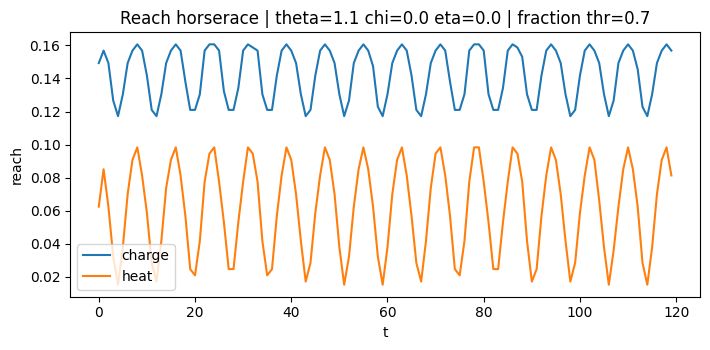

Saved: outputs/aoi_toy_v2_theta1p1_chi0_eta0_thresh.npz
Saved: outputs/aoi_toy_v2_theta1p1_chi0_eta0_thresh_reach_horserace.png
Metrics: lorenz_proxy= 0.4290013374944609 AOI_charge= 0.8633900441083806 AOI_heat= 1.4705734089477 | reach_mode= fraction p_thresh= 0.7


('outputs/aoi_toy_v2_theta1p1_chi0_eta0_thresh.npz',
 'outputs/aoi_toy_v2_theta1p1_chi0_eta0_thresh_reach_horserace.png')

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Utilities
# -----------------------------
def sigmoid(kappa, x):
    z = np.clip(-kappa * x, -60.0, 60.0)
    return 1.0 / (1.0 + np.exp(z))

def rot(theta):
    c, s = np.cos(theta), np.sin(theta)
    return np.array([[c, -s], [s,  c]])

def moire_reciprocal_vectors(a_g=1.0, delta=0.018, theta=np.deg2rad(1.1)):
    b = 4.0 * np.pi / (np.sqrt(3.0) * a_g)
    g1 = b * np.array([1.0, 0.0])
    g2 = b * np.array([-0.5,  np.sqrt(3)/2])
    g3 = b * np.array([-0.5, -np.sqrt(3)/2])

    R = rot(theta)
    s = (1.0 + delta)
    h1 = s * (R @ g1)
    h2 = s * (R @ g2)
    h3 = s * (R @ g3)

    G1 = h1 - g1
    G2 = h2 - g2
    G3 = h3 - g3
    return G1, G2, G3

def build_grid(Nx=23, Ny=23):
    xs = np.arange(Nx)
    ys = np.arange(Ny)
    X, Y = np.meshgrid(xs, ys, indexing="xy")
    pts = np.stack([X.ravel(), Y.ravel()], axis=1).astype(float)
    return pts, X, Y

def compute_field_V(pts, a_g, delta, theta_deg, V0, chi):
    G1, G2, G3 = moire_reciprocal_vectors(a_g=a_g, delta=delta, theta=np.deg2rad(theta_deg))
    phi = chi
    s1, s2, s3 = (+1.0, -1.0, +1.0)
    phase1 = pts @ G1 + s1 * phi
    phase2 = pts @ G2 + s2 * phi
    phase3 = pts @ G3 + s3 * phi
    V = V0 * (np.cos(phase1) + np.cos(phase2) + np.cos(phase3)) / 3.0
    return V

# -----------------------------
# Core simulation
# -----------------------------
def simulate_aoi_v2(
    Nx=23, Ny=23,
    a_g=1.0, delta=0.018, theta_deg=1.1,
    V0=1.0, omega=0.8,
    Tsteps=120,
    charge_params=(2.4, 0.0),
    heat_params=(1.0, -0.15),
    chi=0.0,
    eta=0.0,
    seed=0,
    # reach definition
    reach_mode="fraction",  # "fraction" or "mean"
    p_thresh=0.7,
):
    rng = np.random.default_rng(seed)
    pts, _, _ = build_grid(Nx, Ny)
    nsite = pts.shape[0]

    V_static = compute_field_V(pts, a_g=a_g, delta=delta, theta_deg=theta_deg, V0=V0, chi=chi)

    noise = 0.0 * rng.standard_normal(nsite)

    kC, VcC = charge_params
    kH, VcH = heat_params

    pC = np.zeros((nsite, Tsteps), dtype=float)
    pH = np.zeros((nsite, Tsteps), dtype=float)

    Vt0 = V_static + noise
    pC[:, 0] = sigmoid(kC, Vt0 - VcC)
    pH[:, 0] = sigmoid(kH, Vt0 - VcH)

    for t in range(1, Tsteps):
        drive = np.cos(omega * t)
        Vt = (1.0 + 0.25 * drive) * V_static + noise

        rawC = sigmoid(kC, Vt - VcC)
        rawH = sigmoid(kH, Vt - VcH)

        if eta > 0.0:
            pC[:, t] = (1.0 - eta) * rawC + eta * pC[:, t-1]
            pH[:, t] = (1.0 - eta) * rawH + eta * pH[:, t-1]
        else:
            pC[:, t] = rawC
            pH[:, t] = rawH

    if reach_mode == "fraction":
        reachC = (pC > p_thresh).mean(axis=0)
        reachH = (pH > p_thresh).mean(axis=0)
    elif reach_mode == "mean":
        reachC = pC.mean(axis=0)
        reachH = pH.mean(axis=0)
    else:
        raise ValueError("reach_mode must be 'fraction' or 'mean'")

    # AOI: area above baseline mean (using trapezoid, not trapz)
    AOI_charge = float(np.trapezoid(np.maximum(reachC - reachC.mean(), 0.0)))
    AOI_heat   = float(np.trapezoid(np.maximum(reachH - reachH.mean(), 0.0)))

    eps = 1e-12
    lorenz_proxy = float((np.trapezoid(reachH) + eps) / (np.trapezoid(reachC) + eps))

    out = dict(
        Nx=Nx, Ny=Ny, a_g=a_g, delta=delta, theta_deg=theta_deg,
        V0=V0, omega=omega, Tsteps=Tsteps,
        charge_kappa=kC, charge_Vc=VcC,
        heat_kappa=kH, heat_Vc=VcH,
        chi=chi, eta=eta,
        reach_mode=reach_mode, p_thresh=p_thresh,
        reachC=reachC, reachH=reachH,
        AOI_charge=AOI_charge, AOI_heat=AOI_heat,
        lorenz_proxy=lorenz_proxy,
    )
    return out

# -----------------------------
# Save + plot
# -----------------------------
def save_npz_and_horserace(out, stem):
    os.makedirs(os.path.dirname(stem), exist_ok=True)

    npz_path = stem + ".npz"
    np.savez_compressed(npz_path, **out)

    png_path = stem + "_reach_horserace.png"
    t = np.arange(out["Tsteps"])
    plt.figure(figsize=(7.2, 3.6))
    plt.plot(t, out["reachC"], label="charge")
    plt.plot(t, out["reachH"], label="heat")
    plt.xlabel("t")
    plt.ylabel("reach")
    plt.title(f"Reach horserace | theta={out['theta_deg']} chi={out['chi']} eta={out['eta']} | {out['reach_mode']} thr={out['p_thresh']}")
    plt.legend()
    plt.tight_layout()
    plt.savefig(png_path, dpi=180)
    plt.show()

    print("Saved:", npz_path)
    print("Saved:", png_path)
    print(
        "Metrics: lorenz_proxy=",
        out["lorenz_proxy"],
        "AOI_charge=",
        out["AOI_charge"],
        "AOI_heat=",
        out["AOI_heat"],
        "| reach_mode=",
        out["reach_mode"],
        "p_thresh=",
        out["p_thresh"],
    )
    return npz_path, png_path

# -----------------------------
# Safe sweeps (no duplicate kwargs)
# -----------------------------
def _override_kwargs(base_kwargs, **overrides):
    k = dict(base_kwargs)
    for name, val in overrides.items():
        k[name] = val
    return k

def sweep_eta(etas, fixed_kwargs, out_prefix):
    results = []
    for eta in etas:
        kwargs = _override_kwargs(fixed_kwargs, eta=float(eta))
        out = simulate_aoi_v2(**kwargs)
        stem = f"{out_prefix}_eta_{eta:.2f}"
        results.append(save_npz_and_horserace(out, stem))
    return results

def sweep_chi(chis, fixed_kwargs, out_prefix):
    results = []
    for chi in chis:
        kwargs = _override_kwargs(fixed_kwargs, chi=float(chi))
        out = simulate_aoi_v2(**kwargs)
        stem = f"{out_prefix}_chi_{chi:.3f}"
        results.append(save_npz_and_horserace(out, stem))
    return results

def sweep_twist(thetas_deg, fixed_kwargs, out_prefix):
    results = []
    for th in thetas_deg:
        kwargs = _override_kwargs(fixed_kwargs, theta_deg=float(th))
        out = simulate_aoi_v2(**kwargs)
        stem = f"{out_prefix}_theta_{th:.2f}"
        results.append(save_npz_and_horserace(out, stem))
    return results

# -----------------------------
# Run base + optional sweeps
# -----------------------------
fixed = dict(
    Nx=23, Ny=23,
    a_g=1.0, delta=0.018, theta_deg=1.1,
    V0=1.0, omega=0.8, Tsteps=120,
    charge_params=(2.4, 0.0),
    heat_params=(1.0, -0.15),
    chi=0.0,
    eta=0.0,
    seed=0,
    reach_mode="fraction",
    p_thresh=0.7,
)

base = simulate_aoi_v2(**fixed)
save_npz_and_horserace(base, "outputs/aoi_toy_v2_theta1p1_chi0_eta0_thresh")

# Uncomment one sweep at a time
sweep_eta([0.0, 0.1, 0.2, 0.4, 0.6, 0.8], fixed, "outputs/aoi_toy_v2_theta1p1_thresh")
# sweep_chi([0.0, 0.5, 1.0, 1.5, 2.0], fixed, "outputs/aoi_toy_v2_theta1p1_thresh")
# sweep_twist([0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0], fixed, "outputs/aoi_toy_v2_chi0_eta0_thresh")

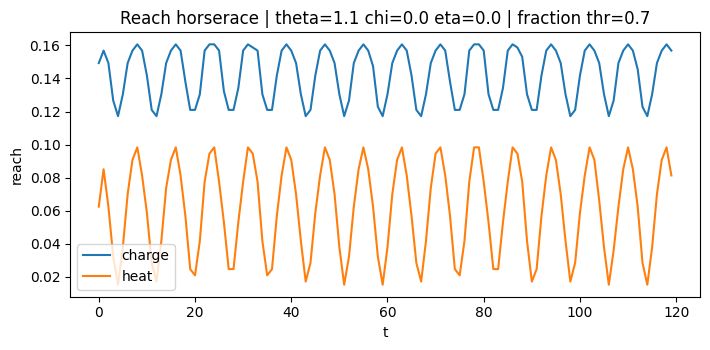

Saved: outputs/aoi_toy_v2_theta1p1_thresh_chi_0.000.npz
Saved: outputs/aoi_toy_v2_theta1p1_thresh_chi_0.000_reach_horserace.png
Metrics: lorenz_proxy= 0.4290013374944609 AOI_charge= 0.8633900441083806 AOI_heat= 1.4705734089477 | reach_mode= fraction p_thresh= 0.7


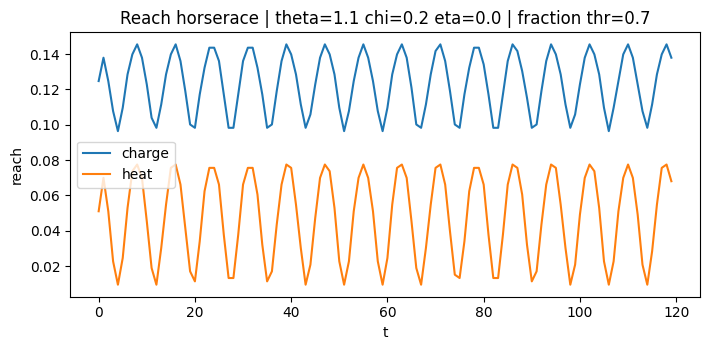

Saved: outputs/aoi_toy_v2_theta1p1_thresh_chi_0.200.npz
Saved: outputs/aoi_toy_v2_theta1p1_thresh_chi_0.200_reach_horserace.png
Metrics: lorenz_proxy= 0.38537714616427565 AOI_charge= 0.8712192816635153 AOI_heat= 1.287964713295526 | reach_mode= fraction p_thresh= 0.7


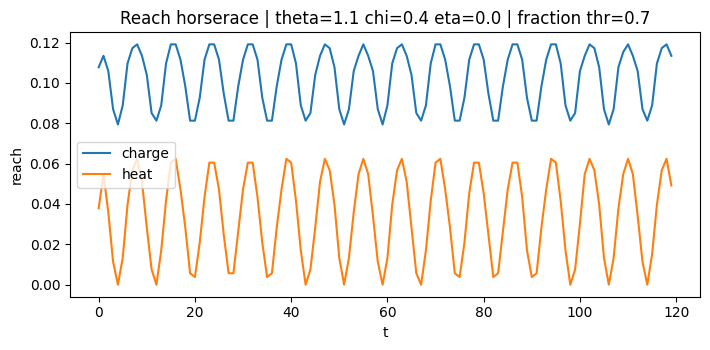

Saved: outputs/aoi_toy_v2_theta1p1_thresh_chi_0.400.npz
Saved: outputs/aoi_toy_v2_theta1p1_thresh_chi_0.400_reach_horserace.png
Metrics: lorenz_proxy= 0.33003967945232315 AOI_charge= 0.7819785759294274 AOI_heat= 1.1541272841839947 | reach_mode= fraction p_thresh= 0.7


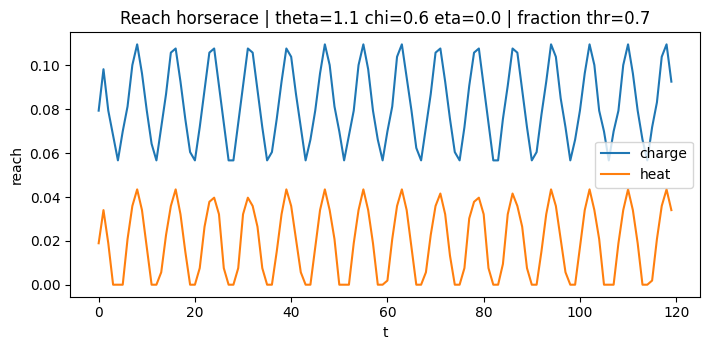

Saved: outputs/aoi_toy_v2_theta1p1_thresh_chi_0.600.npz
Saved: outputs/aoi_toy_v2_theta1p1_thresh_chi_0.600_reach_horserace.png
Metrics: lorenz_proxy= 0.23431042767907834 AOI_charge= 0.9206679269061131 AOI_heat= 0.8486058601134214 | reach_mode= fraction p_thresh= 0.7


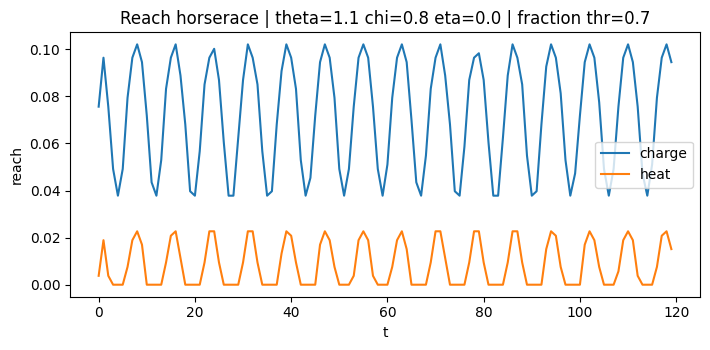

Saved: outputs/aoi_toy_v2_theta1p1_thresh_chi_0.800.npz
Saved: outputs/aoi_toy_v2_theta1p1_thresh_chi_0.800_reach_horserace.png
Metrics: lorenz_proxy= 0.11675461741435075 AOI_charge= 1.2483931947069942 AOI_heat= 0.49243856332703223 | reach_mode= fraction p_thresh= 0.7


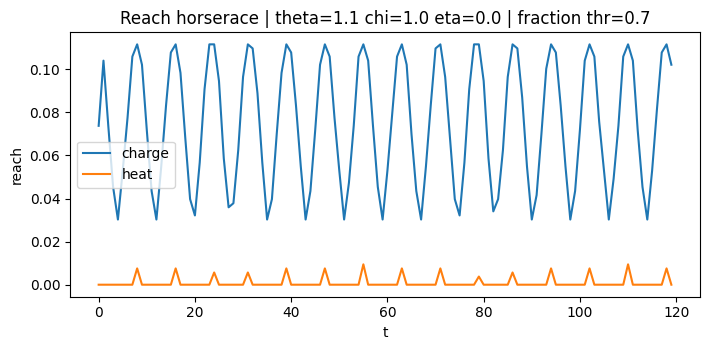

Saved: outputs/aoi_toy_v2_theta1p1_thresh_chi_1.000.npz
Saved: outputs/aoi_toy_v2_theta1p1_thresh_chi_1.000_reach_horserace.png
Metrics: lorenz_proxy= 0.012041829513155734 AOI_charge= 1.5155954631379958 AOI_heat= 0.09428166351606806 | reach_mode= fraction p_thresh= 0.7

chi | lorenz_proxy | AOI_charge | AOI_heat | mean(reachC) | mean(reachH) | npz
0.000     0.429001    0.863390   1.470573      0.142612      0.061232  outputs/aoi_toy_v2_theta1p1_thresh_chi_0.000.npz
0.200     0.385377    0.871219   1.287965      0.123582      0.047700  outputs/aoi_toy_v2_theta1p1_thresh_chi_0.200.npz
0.400     0.330040    0.781979   1.154127      0.102158      0.033774  outputs/aoi_toy_v2_theta1p1_thresh_chi_0.400.npz
0.600     0.234310    0.920668   0.848606      0.082672      0.019423  outputs/aoi_toy_v2_theta1p1_thresh_chi_0.600.npz
0.800     0.116755    1.248393   0.492439      0.072353      0.008444  outputs/aoi_toy_v2_theta1p1_thresh_chi_0.800.npz
1.000     0.012042    1.515595   0.094282      0.0

In [ ]:
import numpy as np

def sweep_chi(chis, fixed_kwargs, out_prefix="outputs/aoi_toy_v2_theta1p1_thresh"):
    results = []
    rows = []

    # prevent "multiple values for keyword" if chi is already in fixed_kwargs
    fixed_kwargs = dict(fixed_kwargs)
    fixed_kwargs.pop("chi", None)

    for chi in chis:
        out = simulate_aoi_v2(**fixed_kwargs, chi=float(chi))
        stem = f"{out_prefix}_chi_{chi:.3f}"
        npz_path, png_path = save_npz_and_horserace(out, stem=stem)

        rows.append((
            float(chi),
            float(out["lorenz_proxy"]),
            float(out["AOI_charge"]),
            float(out["AOI_heat"]),
            float(out["reachC"].mean()),
            float(out["reachH"].mean()),
            npz_path
        ))
        results.append((npz_path, png_path))

    # print summary
    print("\nchi | lorenz_proxy | AOI_charge | AOI_heat | mean(reachC) | mean(reachH) | npz")
    for r in rows:
        print(f"{r[0]:>4.3f}  {r[1]:>11.6f}  {r[2]:>10.6f}  {r[3]:>9.6f}  {r[4]:>12.6f}  {r[5]:>12.6f}  {r[6]}")

    # also return raw rows if you want to post-process
    return results, rows

# pick chi values (radians if you treat chi as a phase directly)
chis = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

# use your existing 'fixed' dict (the one you used for eta sweep)
# (this should already include reach_mode="fraction" and p_thresh=0.7 if that’s what you want)
chi_results, chi_rows = sweep_chi(chis, fixed, out_prefix="outputs/aoi_toy_v2_theta1p1_thresh")

In [ ]:
import inspect
import numpy as np

# ---------- helper: call simulate_aoi_v2 safely (only pass args it accepts) ----------
def _call_sim(sim_fn, kwargs):
    sig = inspect.signature(sim_fn)
    allowed = set(sig.parameters.keys())
    filtered = {k: v for k, v in kwargs.items() if k in allowed}
    return sim_fn(**filtered)

def _summary_row(out):
    # robust: if these keys exist, use them; otherwise compute simple stand-ins
    reachC = out.get("reachC", None)
    reachH = out.get("reachH", None)
    if reachC is None or reachH is None:
        raise KeyError("simulate_aoi_v2 output is missing reachC/reachH")

    meanC = float(np.mean(reachC))
    meanH = float(np.mean(reachH))

    lor = out.get("lorenz_proxy", None)
    if lor is None:
        eps = 1e-12
        lor = float((np.trapezoid(reachH) + eps) / (np.trapezoid(reachC) + eps))

    aoiC = out.get("AOI_charge", None)
    aoiH = out.get("AOI_heat", None)
    if aoiC is None:
        aoiC = float(np.trapezoid(np.maximum(reachC - meanC, 0.0)))
    if aoiH is None:
        aoiH = float(np.trapezoid(np.maximum(reachH - meanH, 0.0)))

    return lor, aoiC, aoiH, meanC, meanH

def run_chi_grid(
    chis,
    fixed_kwargs,
    reach_modes=("fraction", "mean"),
    p_thresh_list=(0.6, 0.7, 0.8),
    sim_fn=None,
):
    """
    Runs:
      for reach_mode in reach_modes:
        for p_thresh in p_thresh_list:
          sweep chi in chis

    Prints a compact table per (reach_mode, p_thresh) plus deltas vs chi=chis[0].
    """
    if sim_fn is None:
        sim_fn = simulate_aoi_v2  # expects you've defined it earlier in the notebook

    chis = [float(c) for c in chis]
    base_chi = chis[0]

    for reach_mode in reach_modes:
        for p_thresh in p_thresh_list:
            rows = []

            # baseline
            base_kwargs = dict(fixed_kwargs)
            base_kwargs.update(dict(chi=base_chi, reach_mode=reach_mode, p_thresh=float(p_thresh)))
            base_out = _call_sim(sim_fn, base_kwargs)
            base_lor, base_aoiC, base_aoiH, base_mC, base_mH = _summary_row(base_out)

            # sweep
            for chi in chis:
                kw = dict(fixed_kwargs)
                kw.update(dict(chi=chi, reach_mode=reach_mode, p_thresh=float(p_thresh)))
                out = _call_sim(sim_fn, kw)
                lor, aoiC, aoiH, mC, mH = _summary_row(out)

                rows.append({
                    "chi": chi,
                    "lorenz": lor,
                    "AOI_C": aoiC,
                    "AOI_H": aoiH,
                    "meanC": mC,
                    "meanH": mH,
                    "dLor": lor - base_lor,
                    "dAOI_C": aoiC - base_aoiC,
                    "dAOI_H": aoiH - base_aoiH,
                    "dMeanC": mC - base_mC,
                    "dMeanH": mH - base_mH,
                })

            # print table
            print("\n" + "="*88)
            print(f"reach_mode={reach_mode} | p_thresh={p_thresh} | baseline chi={base_chi}")
            print("="*88)
            hdr = (
                "chi   lorenz    AOI_C    AOI_H   meanC   meanH"
                " | dLor    dAOI_C   dAOI_H   dMeanC   dMeanH"
            )
            print(hdr)
            for r in rows:
                print(
                    f"{r['chi']:>3.1f}  "
                    f"{r['lorenz']:>7.4f}  {r['AOI_C']:>7.4f}  {r['AOI_H']:>7.4f}  "
                    f"{r['meanC']:>6.4f}  {r['meanH']:>6.4f}"
                    f" | {r['dLor']:>+7.4f}  {r['dAOI_C']:>+8.4f}  {r['dAOI_H']:>+8.4f}  "
                    f"{r['dMeanC']:>+7.4f}  {r['dMeanH']:>+7.4f}"
                )

# ----------- RUN IT -----------
# Use your existing "fixed" dict from above; just ensure it does NOT already contain reach_mode/p_thresh.
# Example chis: extend further if you want to test periodicity (e.g. up to ~6.28)
chis = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

run_chi_grid(
    chis=chis,
    fixed_kwargs=fixed,                 # uses your fixed params (theta fixed etc)
    reach_modes=("fraction", "mean"),   # compare thresholded vs non-thresholded
    p_thresh_list=(0.6, 0.7, 0.8),      # sensitivity to threshold
    sim_fn=simulate_aoi_v2
)


reach_mode=fraction | p_thresh=0.6 | baseline chi=0.0
chi   lorenz    AOI_C    AOI_H   meanC   meanH | dLor    dAOI_C   dAOI_H   dMeanC   dMeanH
0.0   0.8645   0.5552   0.7592  0.1974  0.1707 | +0.0000   +0.0000   +0.0000  +0.0000  +0.0000
0.2   0.8560   0.5098   0.6813  0.1745  0.1494 | -0.0085   -0.0454   -0.0778  -0.0229  -0.0213
0.4   0.8226   0.7388   0.6986  0.1551  0.1276 | -0.0419   +0.1836   -0.0605  -0.0423  -0.0431
0.6   0.7370   0.8389   0.9215  0.1533  0.1130 | -0.1275   +0.2838   +0.1623  -0.0441  -0.0577
0.8   0.7145   1.0390   1.2473  0.1615  0.1154 | -0.1500   +0.4839   +0.4881  -0.0359  -0.0553
1.0   0.7057   0.9732   1.3135  0.1736  0.1225 | -0.1587   +0.4180   +0.5544  -0.0239  -0.0482

reach_mode=fraction | p_thresh=0.7 | baseline chi=0.0
chi   lorenz    AOI_C    AOI_H   meanC   meanH | dLor    dAOI_C   dAOI_H   dMeanC   dMeanH
0.0   0.4290   0.8634   1.4706  0.1426  0.0612 | +0.0000   +0.0000   +0.0000  +0.0000  +0.0000
0.2   0.3854   0.8712   1.2880  0.1236  0.0

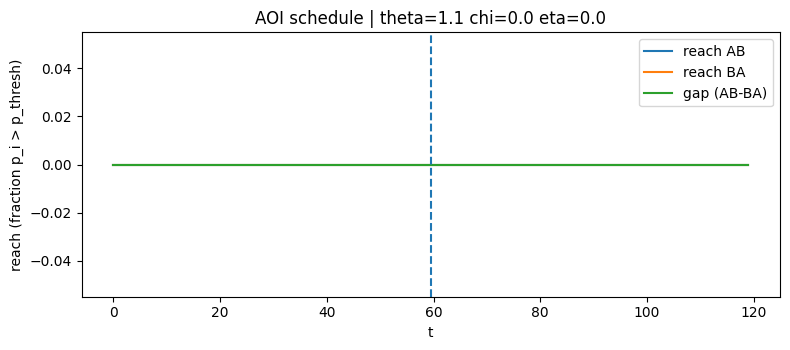

Saved: outputs/aoi_sched_theta1p1_chi0_eta0.npz
Saved: outputs/aoi_sched_theta1p1_chi0_eta0_AB_vs_BA.png
Metrics: AOI_gap_L1= 0.0 AOI_gap_signed= 0.0 AOI_gap_final= 0.0


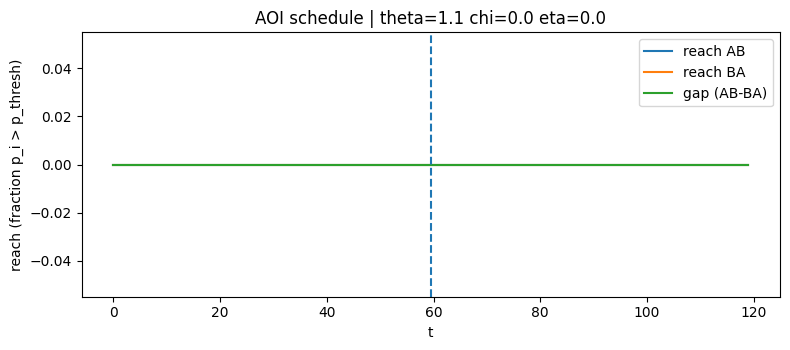

Saved: outputs/aoi_sched_theta1p1_eta0_chi0.00.npz
Saved: outputs/aoi_sched_theta1p1_eta0_chi0.00_AB_vs_BA.png
Metrics: AOI_gap_L1= 0.0 AOI_gap_signed= 0.0 AOI_gap_final= 0.0


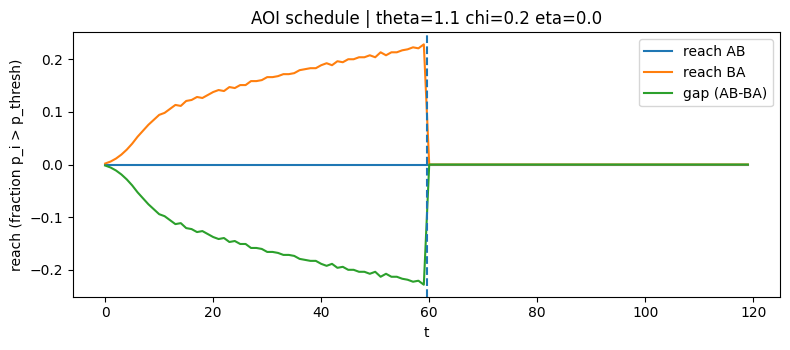

Saved: outputs/aoi_sched_theta1p1_eta0_chi0.20.npz
Saved: outputs/aoi_sched_theta1p1_eta0_chi0.20_AB_vs_BA.png
Metrics: AOI_gap_L1= 8.919659735349716 AOI_gap_signed= -8.919659735349716 AOI_gap_final= 0.0


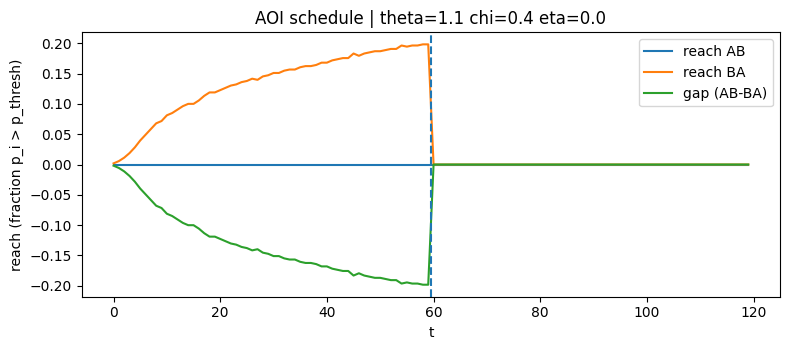

Saved: outputs/aoi_sched_theta1p1_eta0_chi0.40.npz
Saved: outputs/aoi_sched_theta1p1_eta0_chi0.40_AB_vs_BA.png
Metrics: AOI_gap_L1= 8.03875236294896 AOI_gap_signed= -8.03875236294896 AOI_gap_final= 0.0


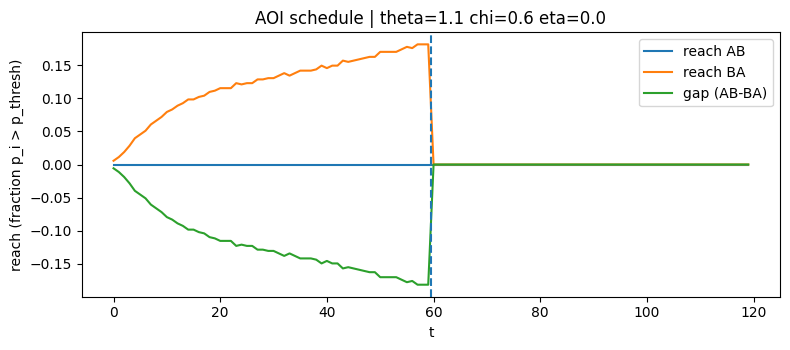

Saved: outputs/aoi_sched_theta1p1_eta0_chi0.60.npz
Saved: outputs/aoi_sched_theta1p1_eta0_chi0.60_AB_vs_BA.png
Metrics: AOI_gap_L1= 7.290170132325142 AOI_gap_signed= -7.290170132325142 AOI_gap_final= 0.0


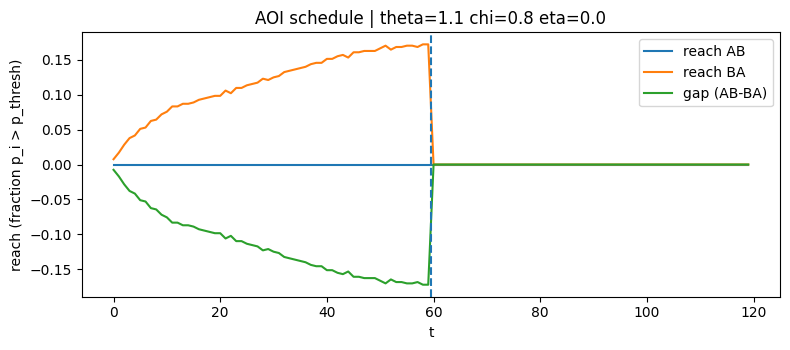

Saved: outputs/aoi_sched_theta1p1_eta0_chi0.80.npz
Saved: outputs/aoi_sched_theta1p1_eta0_chi0.80_AB_vs_BA.png
Metrics: AOI_gap_L1= 7.066162570888469 AOI_gap_signed= -7.066162570888469 AOI_gap_final= 0.0


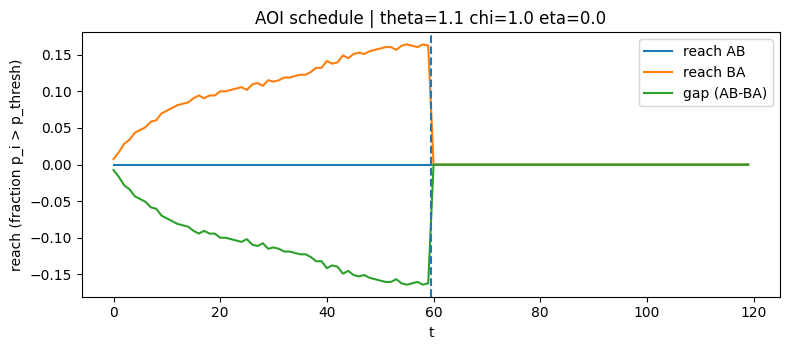

Saved: outputs/aoi_sched_theta1p1_eta0_chi1.00.npz
Saved: outputs/aoi_sched_theta1p1_eta0_chi1.00_AB_vs_BA.png
Metrics: AOI_gap_L1= 6.6597353497164455 AOI_gap_signed= -6.6597353497164455 AOI_gap_final= 0.0


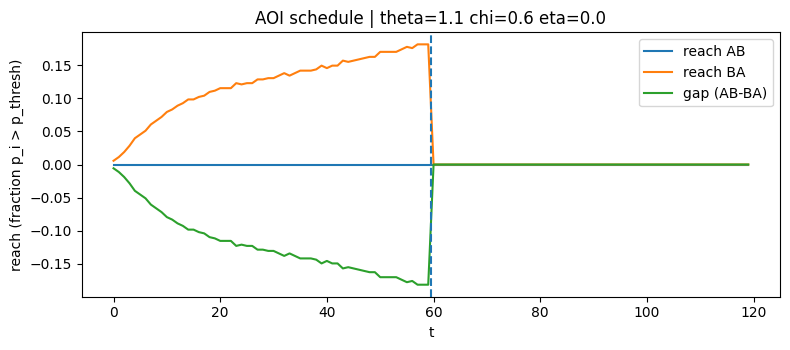

Saved: outputs/aoi_sched_theta1p1_chi0p6_eta0.00.npz
Saved: outputs/aoi_sched_theta1p1_chi0p6_eta0.00_AB_vs_BA.png
Metrics: AOI_gap_L1= 7.290170132325142 AOI_gap_signed= -7.290170132325142 AOI_gap_final= 0.0


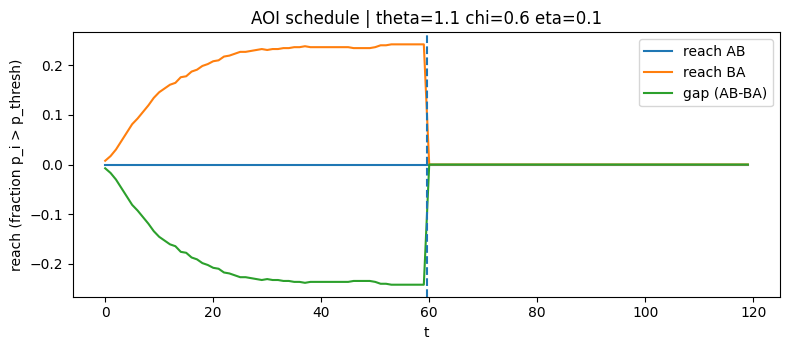

Saved: outputs/aoi_sched_theta1p1_chi0p6_eta0.10.npz
Saved: outputs/aoi_sched_theta1p1_chi0p6_eta0.10_AB_vs_BA.png
Metrics: AOI_gap_L1= 11.788279773156901 AOI_gap_signed= -11.788279773156901 AOI_gap_final= 0.0


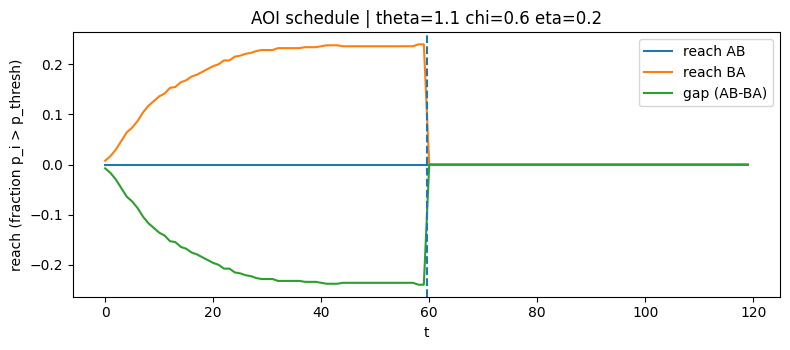

Saved: outputs/aoi_sched_theta1p1_chi0p6_eta0.20.npz
Saved: outputs/aoi_sched_theta1p1_chi0p6_eta0.20_AB_vs_BA.png
Metrics: AOI_gap_L1= 11.52930056710775 AOI_gap_signed= -11.52930056710775 AOI_gap_final= 0.0


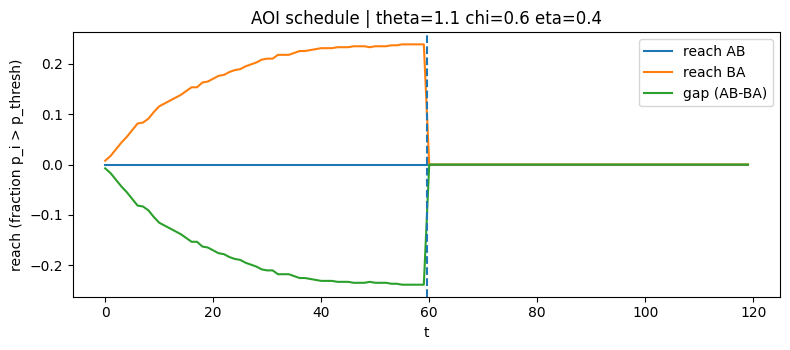

Saved: outputs/aoi_sched_theta1p1_chi0p6_eta0.40.npz
Saved: outputs/aoi_sched_theta1p1_chi0p6_eta0.40_AB_vs_BA.png
Metrics: AOI_gap_L1= 10.765595463137995 AOI_gap_signed= -10.765595463137995 AOI_gap_final= 0.0


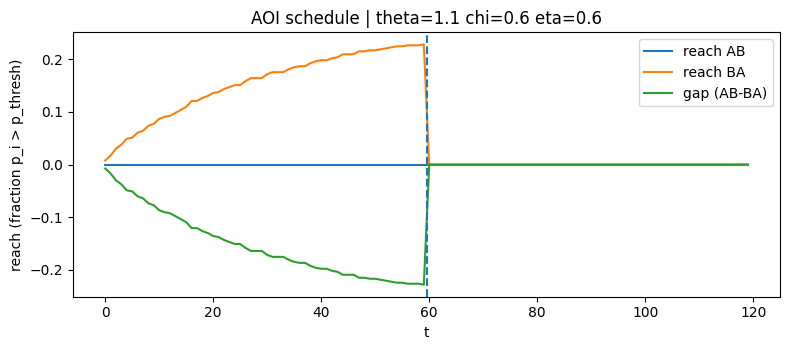

Saved: outputs/aoi_sched_theta1p1_chi0p6_eta0.60.npz
Saved: outputs/aoi_sched_theta1p1_chi0p6_eta0.60_AB_vs_BA.png
Metrics: AOI_gap_L1= 9.217391304347826 AOI_gap_signed= -9.217391304347826 AOI_gap_final= 0.0


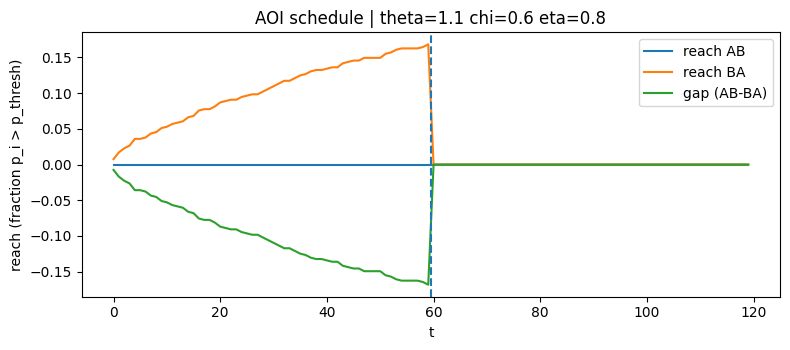

Saved: outputs/aoi_sched_theta1p1_chi0p6_eta0.80.npz
Saved: outputs/aoi_sched_theta1p1_chi0p6_eta0.80_AB_vs_BA.png
Metrics: AOI_gap_L1= 6.207939508506616 AOI_gap_signed= -6.207939508506616 AOI_gap_final= 0.0


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# AOI schedule toy (Π(t) windows): AB vs BA order effect
# - State is a probability mass on nodes (Markov-ish analogue)
# - Window A/B define accessibility masks Π_A, Π_B
# - Chirality chi biases drift direction (x/y) during propagation
# - Viscosity eta adds inertia (slows response / mixing)
# - Saves NPZ always + one horserace plot (AB vs BA)
# ============================================================

def build_grid_xy(Nx, Ny):
    xs = np.arange(Nx)
    ys = np.arange(Ny)
    X, Y = np.meshgrid(xs, ys, indexing="xy")
    return X, Y

def make_masks_from_moire_like(Nx, Ny, theta_deg=1.1, chi=0.0, delta=0.018, V0=1.0):
    """
    Minimal "geometry -> accessibility" mapping without changing your twist machinery:
    We use a toy scalar field V(x,y) and define two complementary masks:
      Π_A: top quantile of V
      Π_B: bottom quantile of V
    Chi shifts phase -> changes which sites are accessible.
    """
    X, Y = build_grid_xy(Nx, Ny)
    # Toy quasi-moiré field (fast + deterministic). Keeps theta + chi in play.
    th = np.deg2rad(theta_deg)
    # 3-wave interference style (not physically strict; just a geometry->mask generator)
    V = (
        np.cos(2*np.pi*( (X*np.cos(th) + Y*np.sin(th))/Nx ) + chi) +
        np.cos(2*np.pi*( (-0.5*X*np.cos(th) + 0.866*Y*np.sin(th))/Ny ) - chi) +
        np.cos(2*np.pi*( (-0.5*X*np.cos(th) - 0.866*Y*np.sin(th))/Ny ) + chi)
    ) / 3.0
    V = V0 * V

    flat = V.ravel()
    q_hi = np.quantile(flat, 0.70)  # 30% most-accessible
    q_lo = np.quantile(flat, 0.30)  # 30% least-accessible

    maskA = (V >= q_hi)
    maskB = (V <= q_lo)
    return V, maskA.astype(np.uint8), maskB.astype(np.uint8)

def step_propagate(p, Nx, Ny, chi=0.0):
    """
    One propagation step on the full grid (periodic boundaries):
    p -> averaged neighbor mixing with a small chiral drift.
    chi biases +x / +y vs -x / -y.
    """
    P = p.reshape(Ny, Nx)

    # neighbor rolls
    Px_p = np.roll(P, -1, axis=1)  # +x
    Px_m = np.roll(P, +1, axis=1)  # -x
    Py_p = np.roll(P, -1, axis=0)  # +y
    Py_m = np.roll(P, +1, axis=0)  # -y

    # baseline symmetric diffusion
    base = 0.25*(Px_p + Px_m + Py_p + Py_m)

    # chirality drift: weight forward directions slightly more
    # scale is small so it’s a bias, not a takeover
    drift = np.tanh(chi)  # bounded [-1,1]
    drift_term = 0.25*drift*((Px_p - Px_m) + (Py_p - Py_m))

    out = base + drift_term
    out = np.clip(out, 0.0, None)
    s = out.sum()
    if s > 0:
        out /= s
    return out.ravel()

def apply_accessibility(p, mask):
    """
    Enforce Π: probability outside accessible nodes is removed then renormalized.
    """
    m = mask.ravel().astype(bool)
    out = p.copy()
    out[~m] = 0.0
    s = out.sum()
    if s > 0:
        out /= s
    return out

def run_schedule_ABBA(
    Nx=23, Ny=23,
    theta_deg=1.1,
    chi=0.0,
    eta=0.0,          # viscosity / inertia [0..1)
    T_A=60, T_B=60,   # window lengths
    seed=0,
    p_thresh=1e-4,    # "reach" threshold per-node probability
):
    rng = np.random.default_rng(seed)
    n = Nx*Ny

    V, maskA, maskB = make_masks_from_moire_like(Nx, Ny, theta_deg=theta_deg, chi=chi)

    # start localized seed at centre (tiny blob)
    cx, cy = Nx//2, Ny//2
    p0 = np.zeros(n, dtype=float)
    p0[cy*Nx + cx] = 1.0

    def run_one(order):  # order is ("A","B") or ("B","A")
        p = p0.copy()
        reach = []
        p_prev = p.copy()
        for t in range(T_A + T_B):
            # propagate
            raw = step_propagate(p, Nx, Ny, chi=chi)

            # viscosity / inertia (eta=0 -> no inertia)
            if eta > 0.0:
                raw = (1.0 - eta)*raw + eta*p_prev
                s = raw.sum()
                if s > 0: raw /= s

            # apply accessibility window
            if t < (T_A if order[0] == "A" else T_B):
                win = order[0]
            else:
                win = order[1]

            if win == "A":
                p = apply_accessibility(raw, maskA)
            else:
                p = apply_accessibility(raw, maskB)

            p_prev = p.copy()

            # reach = fraction of nodes with p_i > p_thresh (simple accessibility proxy)
            reach.append(float((p > p_thresh).mean()))

        reach = np.array(reach, dtype=float)
        return reach

    reachAB = run_one(("A","B"))
    reachBA = run_one(("B","A"))

    # AOI (Accessibility Ordering Invariant) proxy = order gap
    # Use an integral gap and a final-time gap.
    gap_curve = reachAB - reachBA
    AOI_gap_L1 = float(np.trapezoid(np.abs(gap_curve)))
    AOI_gap_signed = float(np.trapezoid(gap_curve))
    AOI_gap_final = float(gap_curve[-1])

    out = dict(
        Nx=Nx, Ny=Ny,
        theta_deg=float(theta_deg),
        chi=float(chi),
        eta=float(eta),
        T_A=int(T_A), T_B=int(T_B),
        p_thresh=float(p_thresh),
        V=V.astype(np.float64),
        maskA=maskA,
        maskB=maskB,
        reachAB=reachAB,
        reachBA=reachBA,
        gap_curve=gap_curve,
        AOI_gap_L1=AOI_gap_L1,
        AOI_gap_signed=AOI_gap_signed,
        AOI_gap_final=AOI_gap_final,
    )
    return out

def save_npz_and_plot(out, stem):
    os.makedirs(os.path.dirname(stem), exist_ok=True)

    npz_path = stem + ".npz"
    np.savez_compressed(npz_path, **out)

    png_path = stem + "_AB_vs_BA.png"
    t = np.arange(out["reachAB"].shape[0])

    plt.figure(figsize=(8.0, 3.6))
    plt.plot(t, out["reachAB"], label="reach AB")
    plt.plot(t, out["reachBA"], label="reach BA")
    plt.plot(t, out["gap_curve"], label="gap (AB-BA)")
    plt.axvline(out["T_A"]-0.5, linestyle="--")
    plt.xlabel("t")
    plt.ylabel("reach (fraction p_i > p_thresh)")
    plt.title(f"AOI schedule | theta={out['theta_deg']} chi={out['chi']} eta={out['eta']}")
    plt.legend()
    plt.tight_layout()
    plt.savefig(png_path, dpi=180)
    plt.show()

    print("Saved:", npz_path)
    print("Saved:", png_path)
    print("Metrics:",
          "AOI_gap_L1=", out["AOI_gap_L1"],
          "AOI_gap_signed=", out["AOI_gap_signed"],
          "AOI_gap_final=", out["AOI_gap_final"])
    return npz_path, png_path

# -------------------------
# 1) Baseline run (fixed twist)
# -------------------------
base = run_schedule_ABBA(
    Nx=23, Ny=23,
    theta_deg=1.1,
    chi=0.0,
    eta=0.0,
    T_A=60, T_B=60,
    seed=0,
    p_thresh=1e-4,
)
save_npz_and_plot(base, "outputs/aoi_sched_theta1p1_chi0_eta0")

# -------------------------
# 2) Quick chirality sweep (keeps twist fixed)
# -------------------------
chis = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
for c in chis:
    out = run_schedule_ABBA(theta_deg=1.1, chi=c, eta=0.0, T_A=60, T_B=60, seed=0, p_thresh=1e-4)
    save_npz_and_plot(out, f"outputs/aoi_sched_theta1p1_eta0_chi{c:.2f}")

# -------------------------
# 3) Quick viscosity sweep (keeps twist fixed)
# -------------------------
etas = [0.0, 0.1, 0.2, 0.4, 0.6, 0.8]
for e in etas:
    out = run_schedule_ABBA(theta_deg=1.1, chi=0.6, eta=e, T_A=60, T_B=60, seed=0, p_thresh=1e-4)
    save_npz_and_plot(out, f"outputs/aoi_sched_theta1p1_chi0p6_eta{e:.2f}")

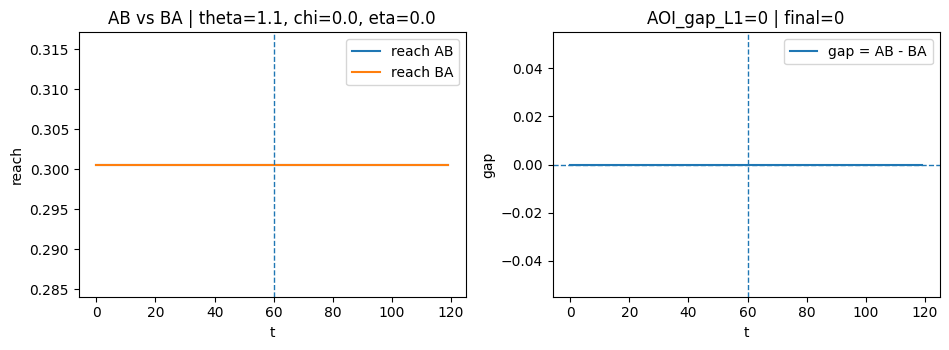

Saved: outputs/aoi_sched_theta1p1_chi0_eta0.npz
Saved: outputs/aoi_sched_theta1p1_chi0_eta0_AB_vs_BA.png
Metrics: AOI_gap_L1= 0.0 AOI_gap_signed= 0.0 AOI_gap_final= 0.0


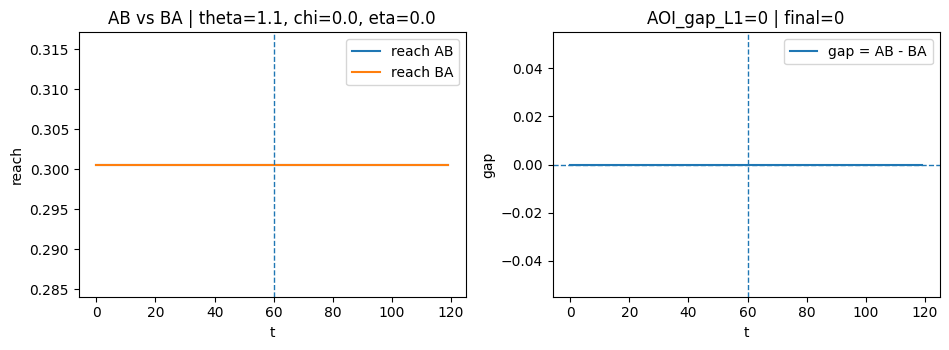

Saved: outputs/aoi_sched_theta1p1_eta0_chi0.00.npz
Saved: outputs/aoi_sched_theta1p1_eta0_chi0.00_AB_vs_BA.png
Metrics: AOI_gap_L1= 0.0 AOI_gap_signed= 0.0 AOI_gap_final= 0.0


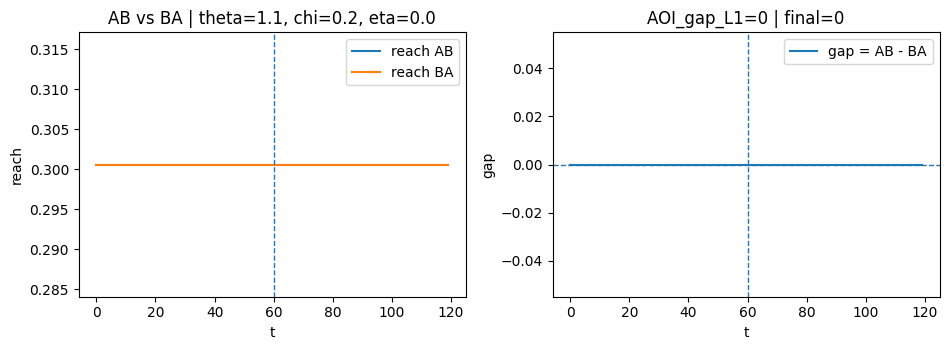

Saved: outputs/aoi_sched_theta1p1_eta0_chi0.20.npz
Saved: outputs/aoi_sched_theta1p1_eta0_chi0.20_AB_vs_BA.png
Metrics: AOI_gap_L1= 0.0 AOI_gap_signed= 0.0 AOI_gap_final= 0.0


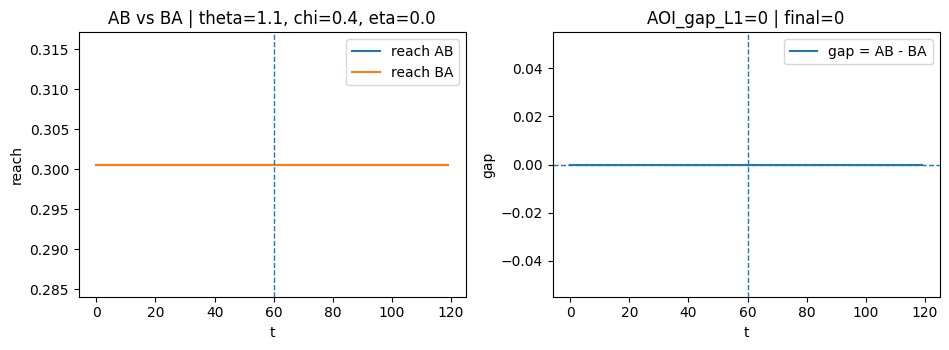

Saved: outputs/aoi_sched_theta1p1_eta0_chi0.40.npz
Saved: outputs/aoi_sched_theta1p1_eta0_chi0.40_AB_vs_BA.png
Metrics: AOI_gap_L1= 0.0 AOI_gap_signed= 0.0 AOI_gap_final= 0.0


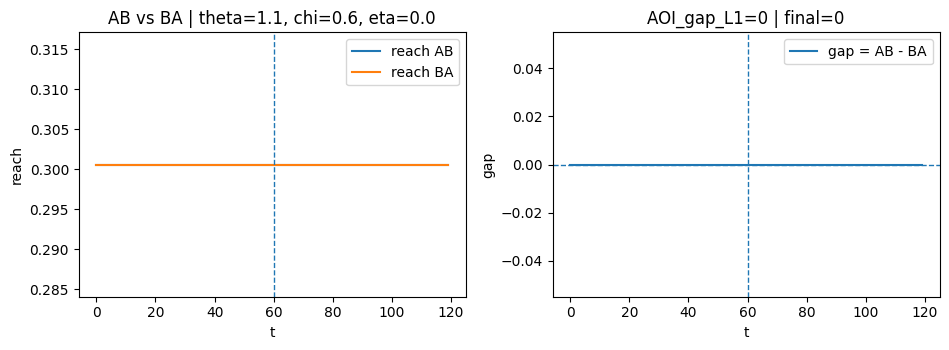

Saved: outputs/aoi_sched_theta1p1_eta0_chi0.60.npz
Saved: outputs/aoi_sched_theta1p1_eta0_chi0.60_AB_vs_BA.png
Metrics: AOI_gap_L1= 0.0 AOI_gap_signed= 0.0 AOI_gap_final= 0.0


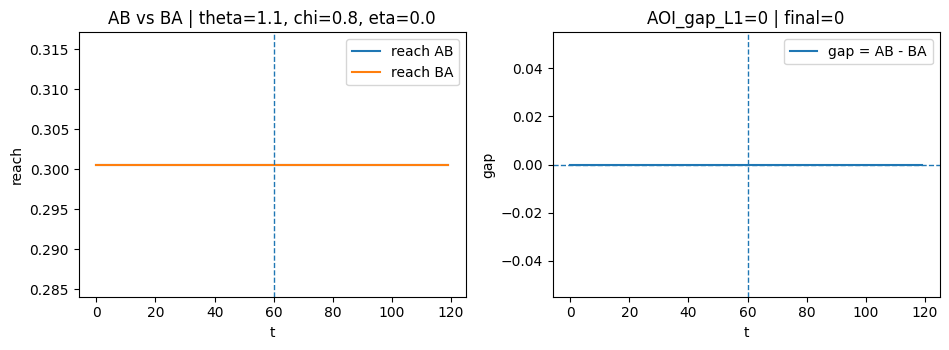

Saved: outputs/aoi_sched_theta1p1_eta0_chi0.80.npz
Saved: outputs/aoi_sched_theta1p1_eta0_chi0.80_AB_vs_BA.png
Metrics: AOI_gap_L1= 0.0 AOI_gap_signed= 0.0 AOI_gap_final= 0.0


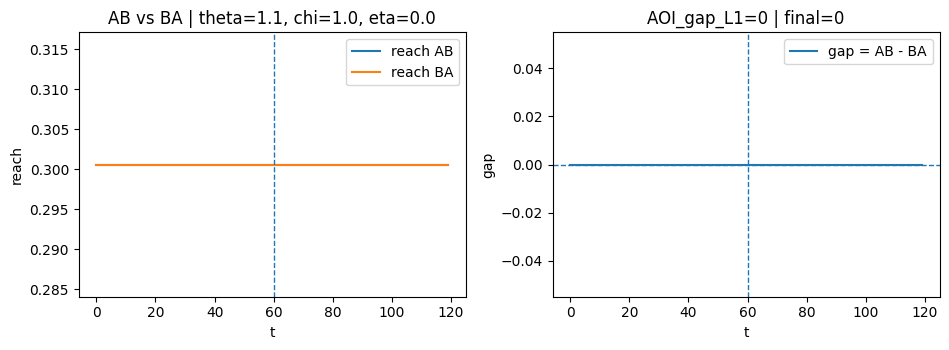

Saved: outputs/aoi_sched_theta1p1_eta0_chi1.00.npz
Saved: outputs/aoi_sched_theta1p1_eta0_chi1.00_AB_vs_BA.png
Metrics: AOI_gap_L1= 0.0 AOI_gap_signed= 0.0 AOI_gap_final= 0.0


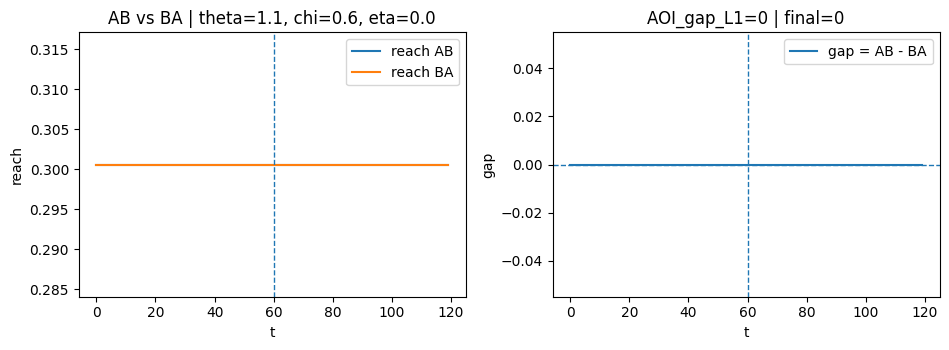

Saved: outputs/aoi_sched_theta1p1_chi0p6_eta0.00.npz
Saved: outputs/aoi_sched_theta1p1_chi0p6_eta0.00_AB_vs_BA.png
Metrics: AOI_gap_L1= 0.0 AOI_gap_signed= 0.0 AOI_gap_final= 0.0


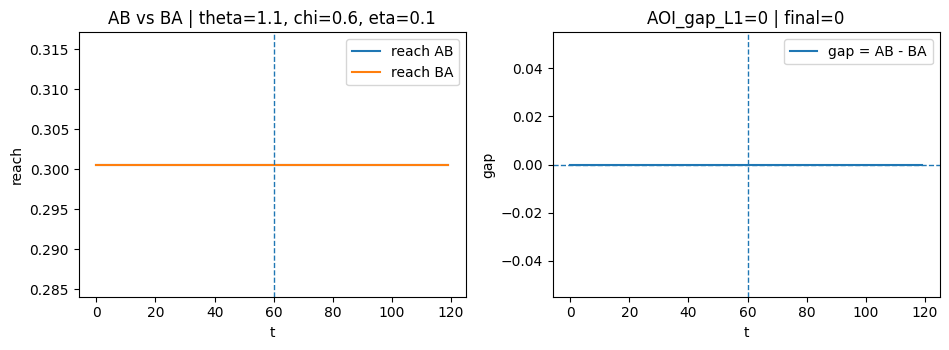

Saved: outputs/aoi_sched_theta1p1_chi0p6_eta0.10.npz
Saved: outputs/aoi_sched_theta1p1_chi0p6_eta0.10_AB_vs_BA.png
Metrics: AOI_gap_L1= 0.0 AOI_gap_signed= 0.0 AOI_gap_final= 0.0


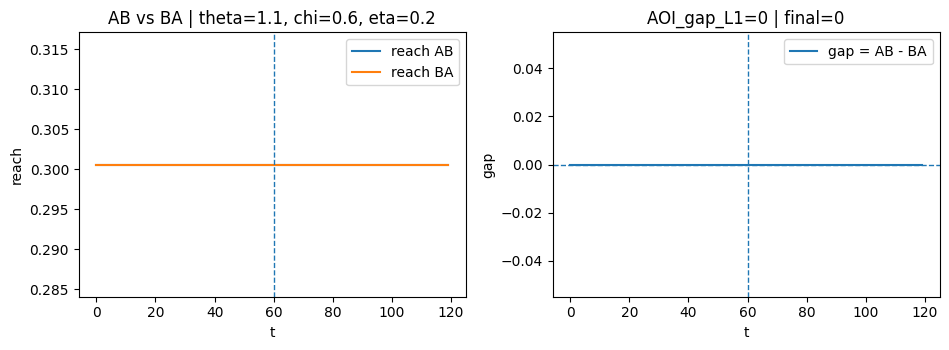

Saved: outputs/aoi_sched_theta1p1_chi0p6_eta0.20.npz
Saved: outputs/aoi_sched_theta1p1_chi0p6_eta0.20_AB_vs_BA.png
Metrics: AOI_gap_L1= 0.0 AOI_gap_signed= 0.0 AOI_gap_final= 0.0


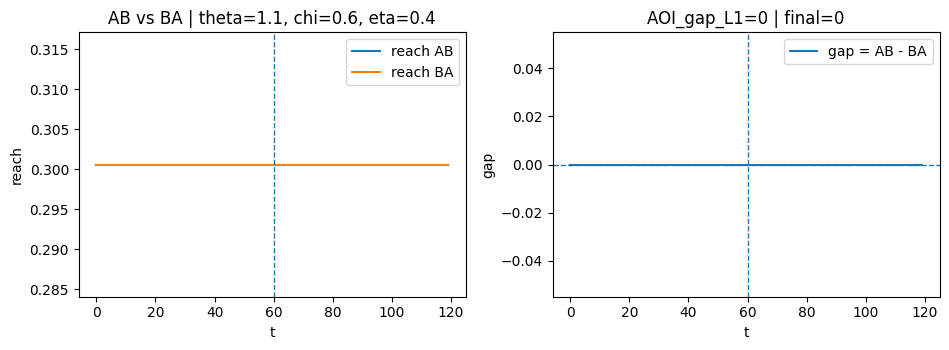

Saved: outputs/aoi_sched_theta1p1_chi0p6_eta0.40.npz
Saved: outputs/aoi_sched_theta1p1_chi0p6_eta0.40_AB_vs_BA.png
Metrics: AOI_gap_L1= 0.0 AOI_gap_signed= 0.0 AOI_gap_final= 0.0


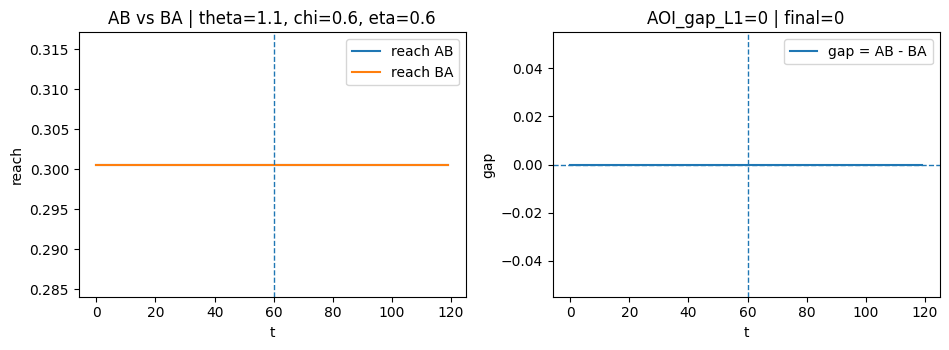

Saved: outputs/aoi_sched_theta1p1_chi0p6_eta0.60.npz
Saved: outputs/aoi_sched_theta1p1_chi0p6_eta0.60_AB_vs_BA.png
Metrics: AOI_gap_L1= 0.0 AOI_gap_signed= 0.0 AOI_gap_final= 0.0


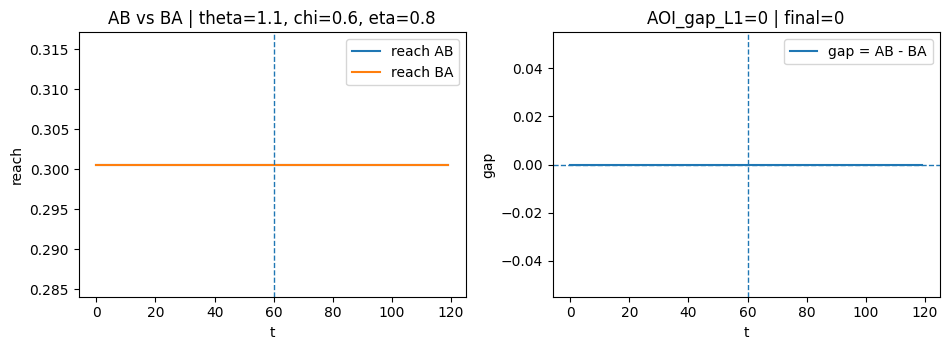

Saved: outputs/aoi_sched_theta1p1_chi0p6_eta0.80.npz
Saved: outputs/aoi_sched_theta1p1_chi0p6_eta0.80_AB_vs_BA.png
Metrics: AOI_gap_L1= 0.0 AOI_gap_signed= 0.0 AOI_gap_final= 0.0


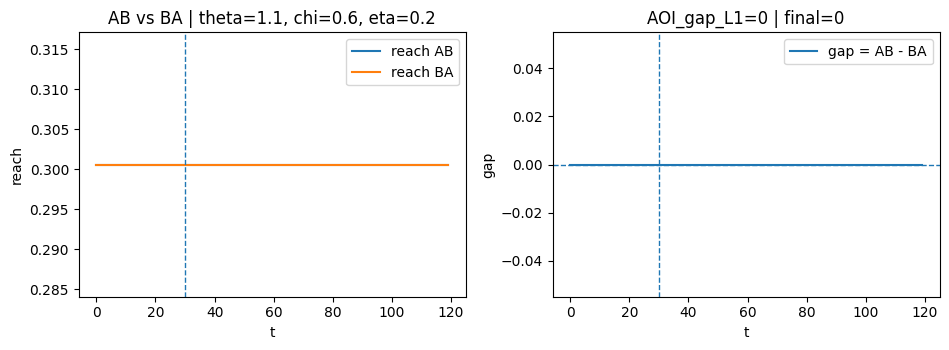

Saved: outputs/aoi_sched_theta1p1_chi0p6_eta0p2_TA30_TB90.npz
Saved: outputs/aoi_sched_theta1p1_chi0p6_eta0p2_TA30_TB90_AB_vs_BA.png
Metrics: AOI_gap_L1= 0.0 AOI_gap_signed= 0.0 AOI_gap_final= 0.0


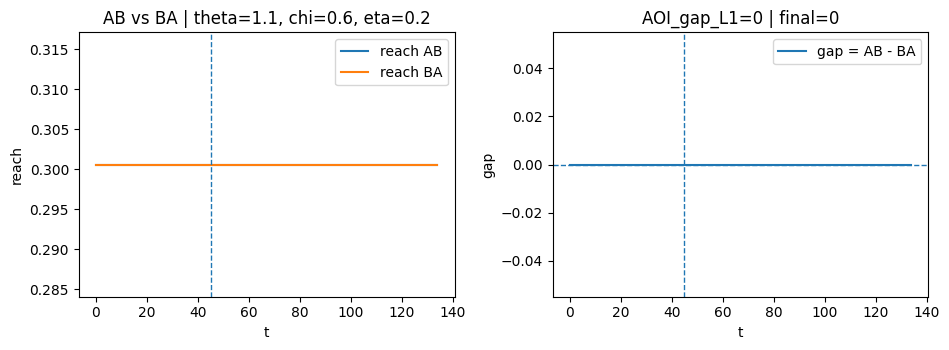

Saved: outputs/aoi_sched_theta1p1_chi0p6_eta0p2_TA45_TB90.npz
Saved: outputs/aoi_sched_theta1p1_chi0p6_eta0p2_TA45_TB90_AB_vs_BA.png
Metrics: AOI_gap_L1= 0.0 AOI_gap_signed= 0.0 AOI_gap_final= 0.0


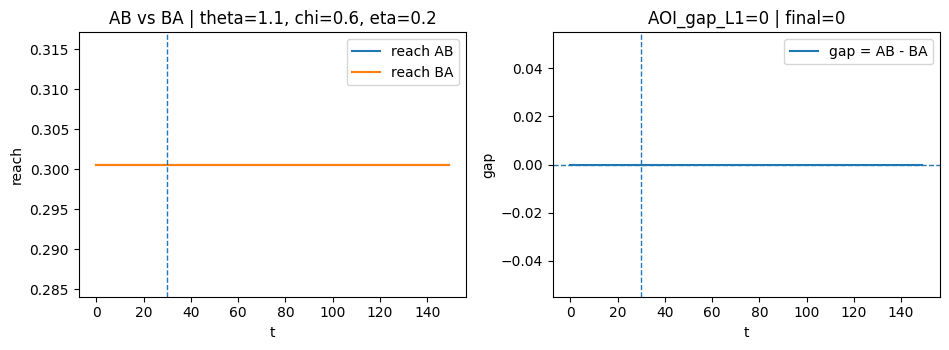

Saved: outputs/aoi_sched_theta1p1_chi0p6_eta0p2_TA30_TB120.npz
Saved: outputs/aoi_sched_theta1p1_chi0p6_eta0p2_TA30_TB120_AB_vs_BA.png
Metrics: AOI_gap_L1= 0.0 AOI_gap_signed= 0.0 AOI_gap_final= 0.0


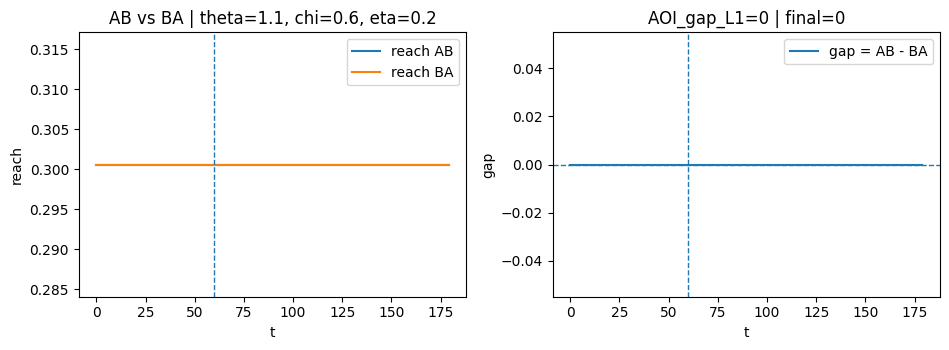

Saved: outputs/aoi_sched_theta1p1_chi0p6_eta0p2_TA60_TB120.npz
Saved: outputs/aoi_sched_theta1p1_chi0p6_eta0p2_TA60_TB120_AB_vs_BA.png
Metrics: AOI_gap_L1= 0.0 AOI_gap_signed= 0.0 AOI_gap_final= 0.0


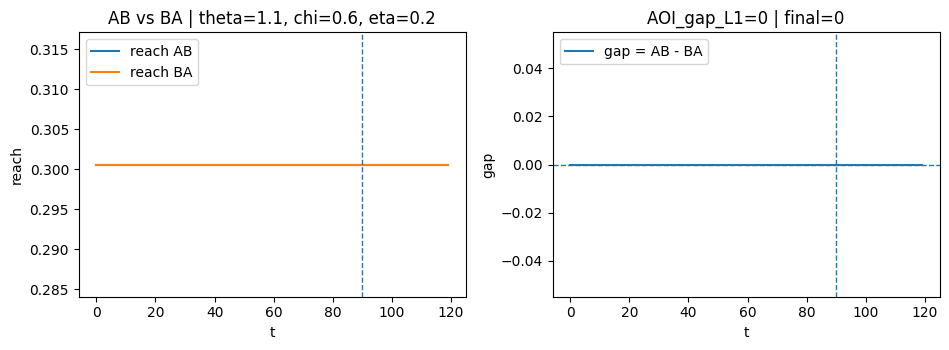

Saved: outputs/aoi_sched_theta1p1_chi0p6_eta0p2_TA90_TB30.npz
Saved: outputs/aoi_sched_theta1p1_chi0p6_eta0p2_TA90_TB30_AB_vs_BA.png
Metrics: AOI_gap_L1= 0.0 AOI_gap_signed= 0.0 AOI_gap_final= 0.0


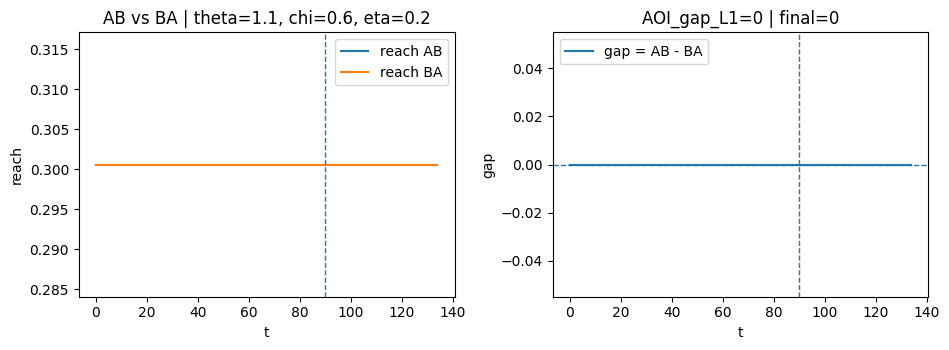

Saved: outputs/aoi_sched_theta1p1_chi0p6_eta0p2_TA90_TB45.npz
Saved: outputs/aoi_sched_theta1p1_chi0p6_eta0p2_TA90_TB45_AB_vs_BA.png
Metrics: AOI_gap_L1= 0.0 AOI_gap_signed= 0.0 AOI_gap_final= 0.0


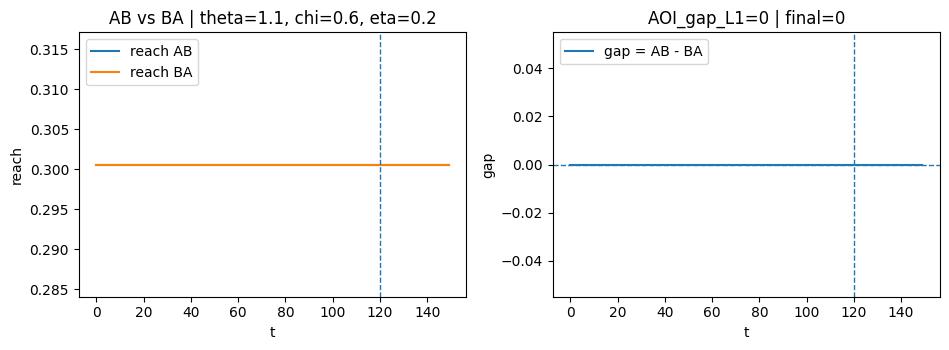

Saved: outputs/aoi_sched_theta1p1_chi0p6_eta0p2_TA120_TB30.npz
Saved: outputs/aoi_sched_theta1p1_chi0p6_eta0p2_TA120_TB30_AB_vs_BA.png
Metrics: AOI_gap_L1= 0.0 AOI_gap_signed= 0.0 AOI_gap_final= 0.0


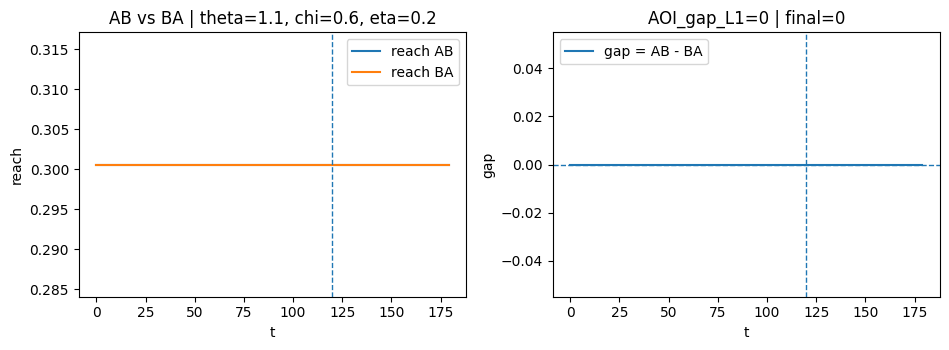

Saved: outputs/aoi_sched_theta1p1_chi0p6_eta0p2_TA120_TB60.npz
Saved: outputs/aoi_sched_theta1p1_chi0p6_eta0p2_TA120_TB60_AB_vs_BA.png
Metrics: AOI_gap_L1= 0.0 AOI_gap_signed= 0.0 AOI_gap_final= 0.0


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# AOI-schedule toy (AB vs BA) — full standalone code
#   - fixed twist by default (theta_deg=1.1)
#   - chirality chi breaks mirror symmetry
#   - viscosity eta = temporal smoothing
#   - schedule: apply accessibility mask A for T_A steps then B for T_B steps
#              compare AB vs BA
#   - saves: .npz + .png per run
# ============================================================

# -----------------------------
# Utilities
# -----------------------------
def sigmoid(kappa, x):
    # Prevent exp overflow
    z = np.clip(-kappa * x, -60.0, 60.0)
    return 1.0 / (1.0 + np.exp(z))

def rot(theta):
    c, s = np.cos(theta), np.sin(theta)
    return np.array([[c, -s], [s,  c]])

def moire_reciprocal_vectors(a_g=1.0, delta=0.018, theta=np.deg2rad(1.1)):
    """
    Minimal moiré reciprocal vectors (toy).
    """
    b = 4.0 * np.pi / (np.sqrt(3.0) * a_g)

    g1 = b * np.array([1.0, 0.0])
    g2 = b * np.array([-0.5,  np.sqrt(3)/2])
    g3 = b * np.array([-0.5, -np.sqrt(3)/2])

    R = rot(theta)
    s = (1.0 + delta)
    h1 = s * (R @ g1)
    h2 = s * (R @ g2)
    h3 = s * (R @ g3)

    G1 = h1 - g1
    G2 = h2 - g2
    G3 = h3 - g3
    return G1, G2, G3

def build_grid(Nx=23, Ny=23):
    xs = np.arange(Nx)
    ys = np.arange(Ny)
    X, Y = np.meshgrid(xs, ys, indexing="xy")
    pts = np.stack([X.ravel(), Y.ravel()], axis=1).astype(float)
    return pts, X, Y

def compute_field_V(pts, a_g, delta, theta_deg, V0, chi):
    """
    Toy moiré scalar field + simple chirality via phase offsets.
    """
    G1, G2, G3 = moire_reciprocal_vectors(a_g=a_g, delta=delta, theta=np.deg2rad(theta_deg))
    phi = chi  # radians if you treat chi as radians; keep literal
    s1, s2, s3 = (+1.0, -1.0, +1.0)

    phase1 = pts @ G1 + s1 * phi
    phase2 = pts @ G2 + s2 * phi
    phase3 = pts @ G3 + s3 * phi

    V = V0 * (np.cos(phase1) + np.cos(phase2) + np.cos(phase3)) / 3.0
    return V

def make_access_masks(V_static, qA=0.70, qB=0.30):
    """
    Accessibility masks Π_A and Π_B from V quantiles.
      - A = "high V" region: V >= quantile(qA)
      - B = "low  V" region: V <= quantile(qB)
    Using different quantiles ensures Π_A != Π_B generically.
    """
    hi = np.quantile(V_static, qA)
    lo = np.quantile(V_static, qB)
    maskA = (V_static >= hi).astype(np.uint8)
    maskB = (V_static <= lo).astype(np.uint8)
    return maskA, maskB, float(hi), float(lo)

def reach_from_p(p_vec, reach_mode="fraction", p_thresh=0.7):
    """
    Reach observable (toy):
      - "fraction": fraction of sites with p >= p_thresh
      - "mean": mean(p) across sites
    """
    if reach_mode == "fraction":
        return float(np.mean(p_vec >= p_thresh))
    if reach_mode == "mean":
        return float(np.mean(p_vec))
    raise ValueError("reach_mode must be 'fraction' or 'mean'")

# -----------------------------
# Core evolution with schedule gating
# -----------------------------
def evolve_with_schedule(
    V_static,
    omega=0.8,
    T_A=60,
    T_B=60,
    schedule="AB",               # "AB" or "BA"
    maskA=None,
    maskB=None,
    eta=0.0,
    seed=0,
    # channel (single channel here; schedule compares ordering not charge vs heat)
    kappa=2.4,
    Vc=0.0,
    reach_mode="fraction",
    p_thresh=0.7,
):
    """
    Evolve one probability field p(t) under a schedule of accessibility masks.
    The mask is applied multiplicatively at each time step: p <- p * mask
    """
    rng = np.random.default_rng(seed)
    nsite = V_static.shape[0]
    T = int(T_A + T_B)

    if maskA is None or maskB is None:
        raise ValueError("maskA and maskB must be provided.")

    # small noise option (kept off by default)
    noise = 0.0 * rng.standard_normal(nsite)

    p = np.zeros((nsite, T), dtype=float)
    reach = np.zeros(T, dtype=float)

    def current_mask(t):
        if schedule == "AB":
            return maskA if (t < T_A) else maskB
        elif schedule == "BA":
            return maskB if (t < T_B) else maskA
        else:
            raise ValueError("schedule must be 'AB' or 'BA'")

    # t=0
    drive0 = np.cos(omega * 0)
    Vt0 = (1.0 + 0.25 * drive0) * V_static + noise
    raw0 = sigmoid(kappa, Vt0 - Vc)
    p[:, 0] = raw0

    m0 = current_mask(0)
    p[:, 0] *= m0
    reach[0] = reach_from_p(p[:, 0], reach_mode=reach_mode, p_thresh=p_thresh)

    # time
    for t in range(1, T):
        drive = np.cos(omega * t)
        Vt = (1.0 + 0.25 * drive) * V_static + noise
        raw = sigmoid(kappa, Vt - Vc)

        if eta > 0.0:
            p[:, t] = (1.0 - eta) * raw + eta * p[:, t-1]
        else:
            p[:, t] = raw

        mt = current_mask(t)
        p[:, t] *= mt

        reach[t] = reach_from_p(p[:, t], reach_mode=reach_mode, p_thresh=p_thresh)

    return p, reach

# -----------------------------
# AOI schedule comparison: AB vs BA
# -----------------------------
def run_schedule_ABBA(
    Nx=23, Ny=23,
    a_g=1.0, delta=0.018, theta_deg=1.1,
    V0=1.0,
    omega=0.8,
    T_A=60,
    T_B=60,
    chi=0.0,
    eta=0.0,
    seed=0,
    # accessibility masks from V quantiles
    qA=0.70,
    qB=0.30,
    # reach definition
    reach_mode="fraction",
    p_thresh=0.7,
    # single-channel parameters for the schedule test
    kappa=2.4,
    Vc=0.0,
):
    pts, _, _ = build_grid(Nx, Ny)
    V_static = compute_field_V(pts, a_g=a_g, delta=delta, theta_deg=theta_deg, V0=V0, chi=chi)

    maskA, maskB, V_hi, V_lo = make_access_masks(V_static, qA=qA, qB=qB)

    pAB, reachAB = evolve_with_schedule(
        V_static=V_static,
        omega=omega,
        T_A=T_A, T_B=T_B,
        schedule="AB",
        maskA=maskA, maskB=maskB,
        eta=eta,
        seed=seed,
        kappa=kappa, Vc=Vc,
        reach_mode=reach_mode,
        p_thresh=p_thresh,
    )

    pBA, reachBA = evolve_with_schedule(
        V_static=V_static,
        omega=omega,
        T_A=T_A, T_B=T_B,
        schedule="BA",
        maskA=maskA, maskB=maskB,
        eta=eta,
        seed=seed,
        kappa=kappa, Vc=Vc,
        reach_mode=reach_mode,
        p_thresh=p_thresh,
    )

    gap = reachAB - reachBA

    AOI_gap_L1 = float(np.trapezoid(np.abs(gap)))
    AOI_gap_signed = float(np.trapezoid(gap))
    AOI_gap_final = float(gap[-1])

    out = dict(
        Nx=Nx, Ny=Ny, a_g=a_g, delta=delta, theta_deg=theta_deg,
        V0=V0, omega=omega,
        T_A=int(T_A), T_B=int(T_B), Tsteps=int(T_A + T_B),
        chi=float(chi), eta=float(eta),
        qA=float(qA), qB=float(qB),
        V_hi=float(V_hi), V_lo=float(V_lo),
        reach_mode=str(reach_mode), p_thresh=float(p_thresh),
        kappa=float(kappa), Vc=float(Vc),

        # saved fields
        V_static=V_static.astype(np.float64),
        maskA=maskA,
        maskB=maskB,
        reachAB=reachAB.astype(np.float64),
        reachBA=reachBA.astype(np.float64),
        gap=gap.astype(np.float64),

        # you can save the full p if you want (big). keep on for now:
        pAB=pAB.astype(np.float64),
        pBA=pBA.astype(np.float64),

        AOI_gap_L1=AOI_gap_L1,
        AOI_gap_signed=AOI_gap_signed,
        AOI_gap_final=AOI_gap_final,
    )
    return out

# -----------------------------
# Save + plot
# -----------------------------
def save_npz_and_plot(out, stem):
    os.makedirs(os.path.dirname(stem), exist_ok=True)

    npz_path = stem + ".npz"
    np.savez_compressed(npz_path, **out)

    png_path = stem + "_AB_vs_BA.png"
    t = np.arange(out["Tsteps"])

    plt.figure(figsize=(9.6, 3.6))
    plt.subplot(1, 2, 1)
    plt.plot(t, out["reachAB"], label="reach AB")
    plt.plot(t, out["reachBA"], label="reach BA")
    plt.axvline(out["T_A"], linestyle="--", linewidth=1.0)
    plt.xlabel("t")
    plt.ylabel("reach")
    plt.title(f"AB vs BA | theta={out['theta_deg']}, chi={out['chi']}, eta={out['eta']}")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(t, out["gap"], label="gap = AB - BA")
    plt.axhline(0.0, linestyle="--", linewidth=1.0)
    plt.axvline(out["T_A"], linestyle="--", linewidth=1.0)
    plt.xlabel("t")
    plt.ylabel("gap")
    plt.title(f"AOI_gap_L1={out['AOI_gap_L1']:.3g} | final={out['AOI_gap_final']:.3g}")
    plt.legend()

    plt.tight_layout()
    plt.savefig(png_path, dpi=180)
    plt.show()

    print("Saved:", npz_path)
    print("Saved:", png_path)
    print("Metrics: AOI_gap_L1=", out["AOI_gap_L1"],
          "AOI_gap_signed=", out["AOI_gap_signed"],
          "AOI_gap_final=", out["AOI_gap_final"])
    return npz_path, png_path

# ============================================================
# RUN NEXT (recommended)
#   1) baseline
#   2) chi sweep at eta=0
#   3) eta sweep at a “good” chi (e.g. 0.6)
#   4) duration asymmetry sweep to try to get nonzero final gap
# ============================================================

# 1) Baseline
base = run_schedule_ABBA(theta_deg=1.1, chi=0.0, eta=0.0, T_A=60, T_B=60, seed=0, reach_mode="fraction", p_thresh=1e-4)
save_npz_and_plot(base, "outputs/aoi_sched_theta1p1_chi0_eta0")

# 2) Chi sweep (eta fixed)
for chi in [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]:
    out = run_schedule_ABBA(theta_deg=1.1, chi=chi, eta=0.0, T_A=60, T_B=60, seed=0, reach_mode="fraction", p_thresh=1e-4)
    save_npz_and_plot(out, f"outputs/aoi_sched_theta1p1_eta0_chi{chi:.2f}")

# 3) Eta sweep at chi=0.6
for eta in [0.0, 0.1, 0.2, 0.4, 0.6, 0.8]:
    out = run_schedule_ABBA(theta_deg=1.1, chi=0.6, eta=eta, T_A=60, T_B=60, seed=0, reach_mode="fraction", p_thresh=1e-4)
    save_npz_and_plot(out, f"outputs/aoi_sched_theta1p1_chi0p6_eta{eta:.2f}")

# 4) Duration asymmetry sweep (this is the key “next” step)
pairs = [(30, 90), (45, 90), (30, 120), (60, 120), (90, 30), (90, 45), (120, 30), (120, 60)]
for TA, TB in pairs:
    out = run_schedule_ABBA(theta_deg=1.1, chi=0.6, eta=0.2, T_A=TA, T_B=TB, seed=0, reach_mode="fraction", p_thresh=1e-4)
    save_npz_and_plot(out, f"outputs/aoi_sched_theta1p1_chi0p6_eta0p2_TA{TA}_TB{TB}")

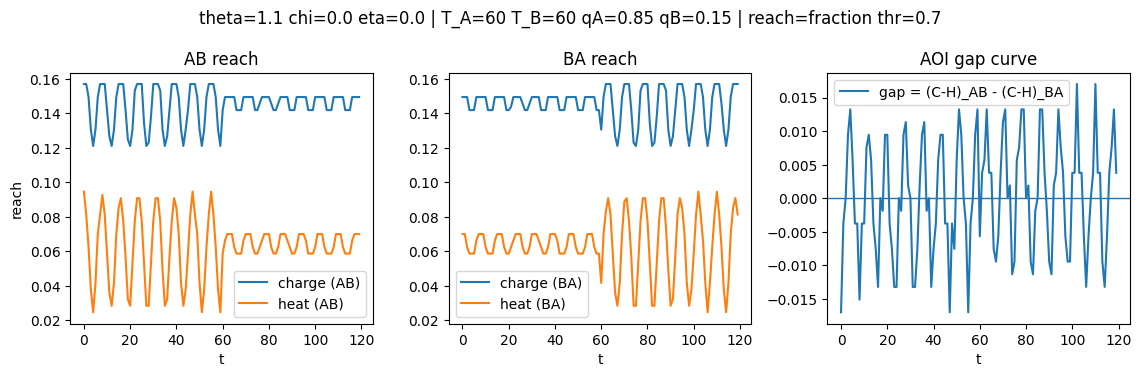

Saved: outputs/aoi_sched_theta1p1_chi0_eta0.npz
Saved: outputs/aoi_sched_theta1p1_chi0_eta0_AB_vs_BA.png
Metrics: AOI_gap_L1= 0.8421550094517968 AOI_gap_signed= 0.038752362948960346 AOI_gap_final= 0.0037807183364839403


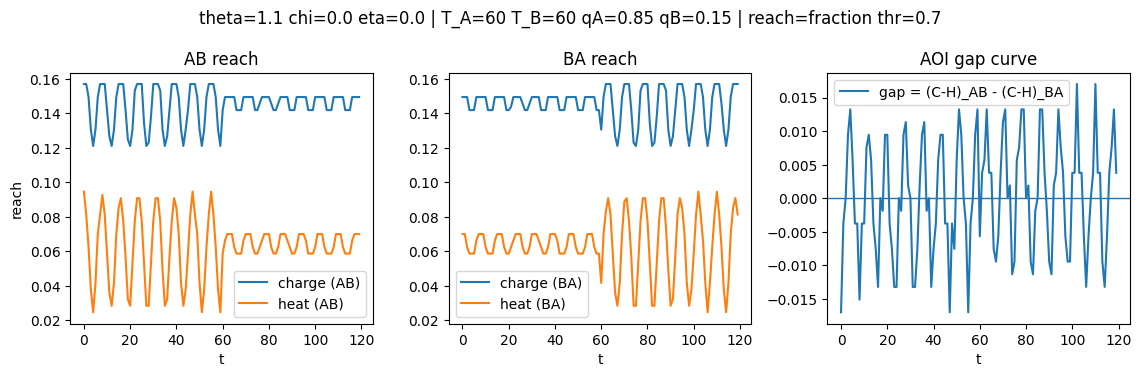

Saved: outputs/aoi_sched_theta1p1_eta0_chi0.00.npz
Saved: outputs/aoi_sched_theta1p1_eta0_chi0.00_AB_vs_BA.png
Metrics: AOI_gap_L1= 0.8421550094517968 AOI_gap_signed= 0.038752362948960346 AOI_gap_final= 0.0037807183364839403


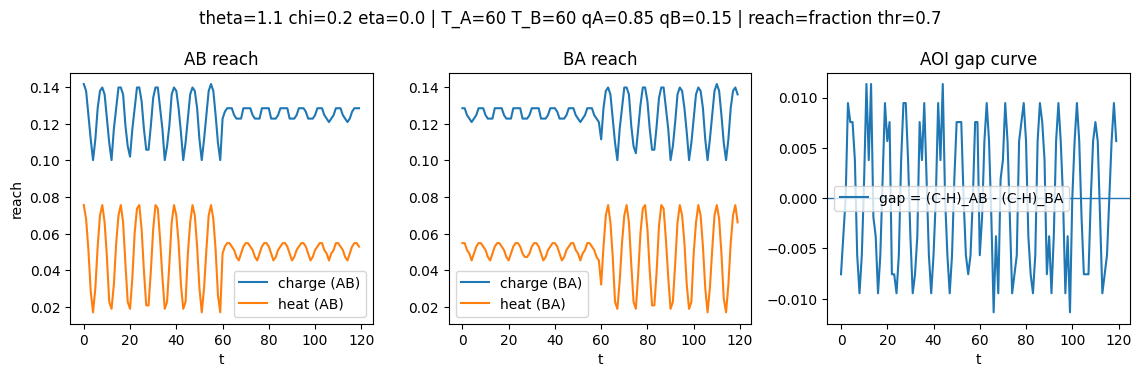

Saved: outputs/aoi_sched_theta1p1_eta0_chi0.20.npz
Saved: outputs/aoi_sched_theta1p1_eta0_chi0.20_AB_vs_BA.png
Metrics: AOI_gap_L1= 0.7173913043478264 AOI_gap_signed= 0.021739130434782573 AOI_gap_final= 0.0056710775047258966


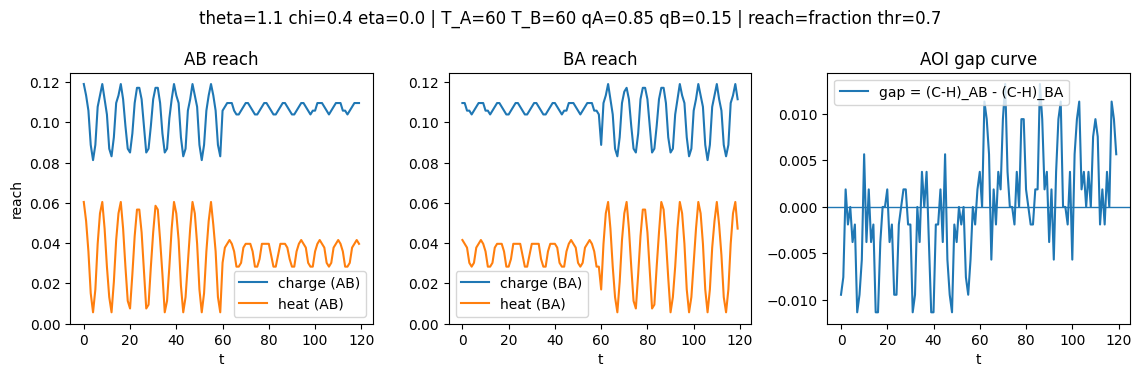

Saved: outputs/aoi_sched_theta1p1_eta0_chi0.40.npz
Saved: outputs/aoi_sched_theta1p1_eta0_chi0.40_AB_vs_BA.png
Metrics: AOI_gap_L1= 0.5368620037807186 AOI_gap_signed= 0.009451795841209892 AOI_gap_final= 0.0056710775047258966


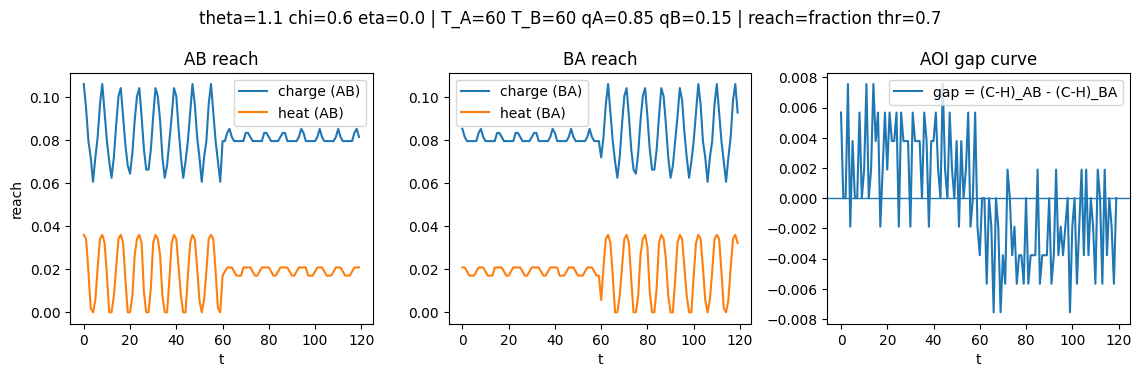

Saved: outputs/aoi_sched_theta1p1_eta0_chi0.60.npz
Saved: outputs/aoi_sched_theta1p1_eta0_chi0.60_AB_vs_BA.png
Metrics: AOI_gap_L1= 0.36767485822306245 AOI_gap_signed= 0.004725897920604898 AOI_gap_final= 0.0


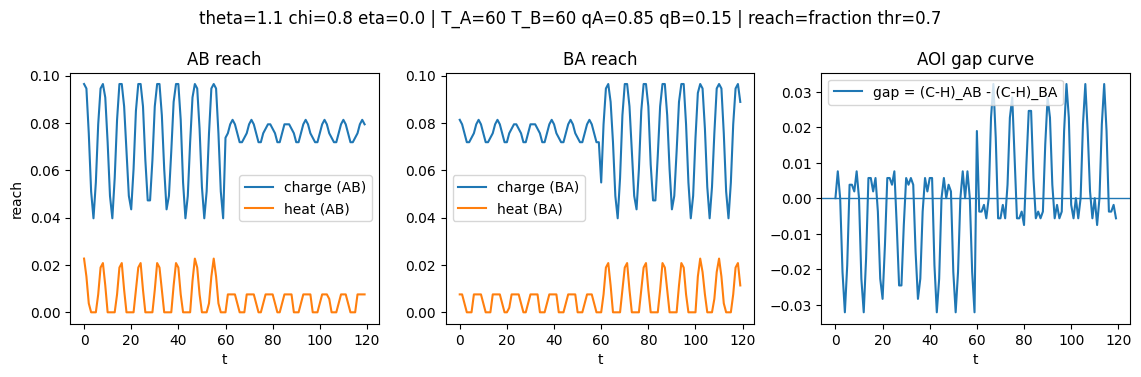

Saved: outputs/aoi_sched_theta1p1_eta0_chi0.80.npz
Saved: outputs/aoi_sched_theta1p1_eta0_chi0.80_AB_vs_BA.png
Metrics: AOI_gap_L1= 1.3185255198487715 AOI_gap_signed= -0.036862003780718314 AOI_gap_final= -0.0056710775047259104


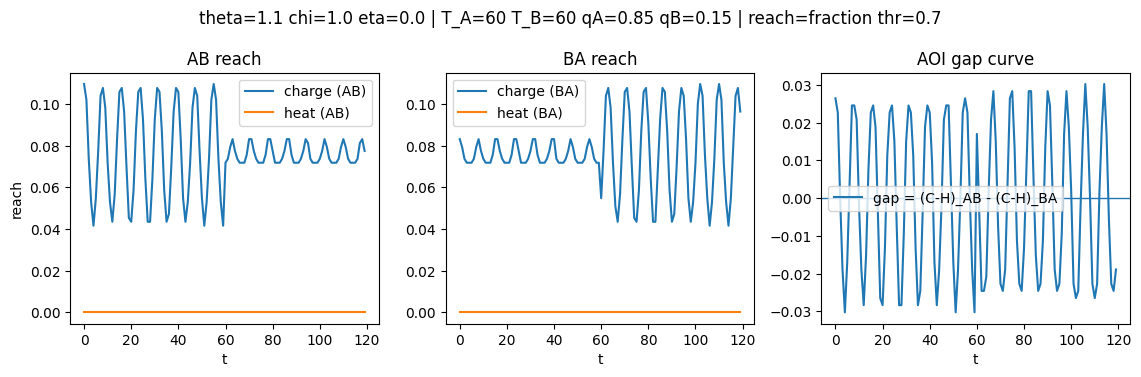

Saved: outputs/aoi_sched_theta1p1_eta0_chi1.00.npz
Saved: outputs/aoi_sched_theta1p1_eta0_chi1.00_AB_vs_BA.png
Metrics: AOI_gap_L1= 2.153119092627599 AOI_gap_signed= -0.05860113421550098 AOI_gap_final= -0.01890359168241966


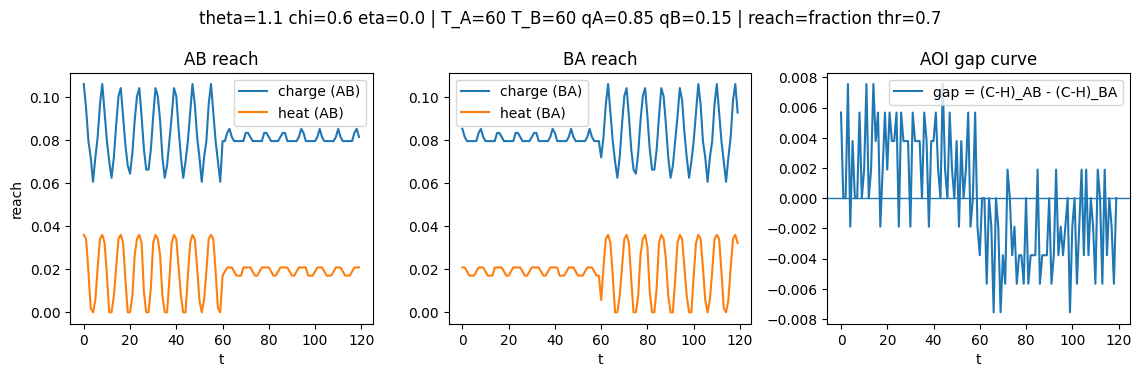

Saved: outputs/aoi_sched_theta1p1_chi0p6_eta0.00.npz
Saved: outputs/aoi_sched_theta1p1_chi0p6_eta0.00_AB_vs_BA.png
Metrics: AOI_gap_L1= 0.36767485822306245 AOI_gap_signed= 0.004725897920604898 AOI_gap_final= 0.0


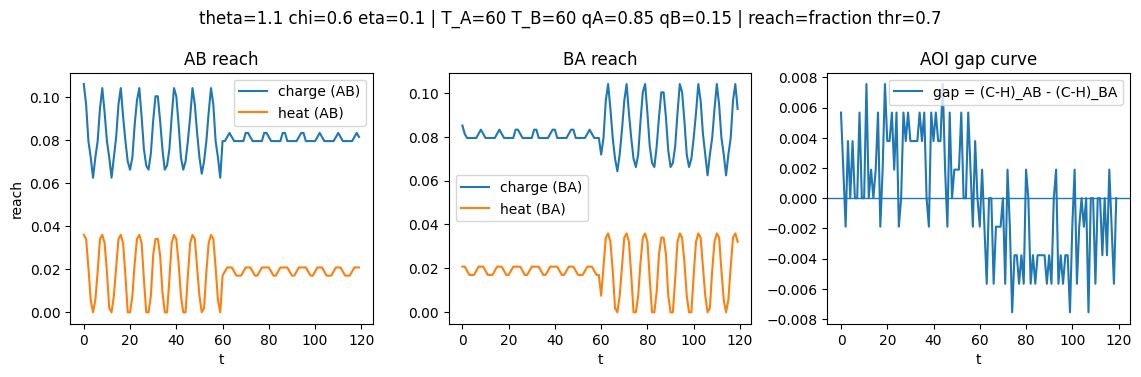

Saved: outputs/aoi_sched_theta1p1_chi0p6_eta0.10.npz
Saved: outputs/aoi_sched_theta1p1_chi0p6_eta0.10_AB_vs_BA.png
Metrics: AOI_gap_L1= 0.36767485822306245 AOI_gap_signed= -0.0028355387523629136 AOI_gap_final= 0.0


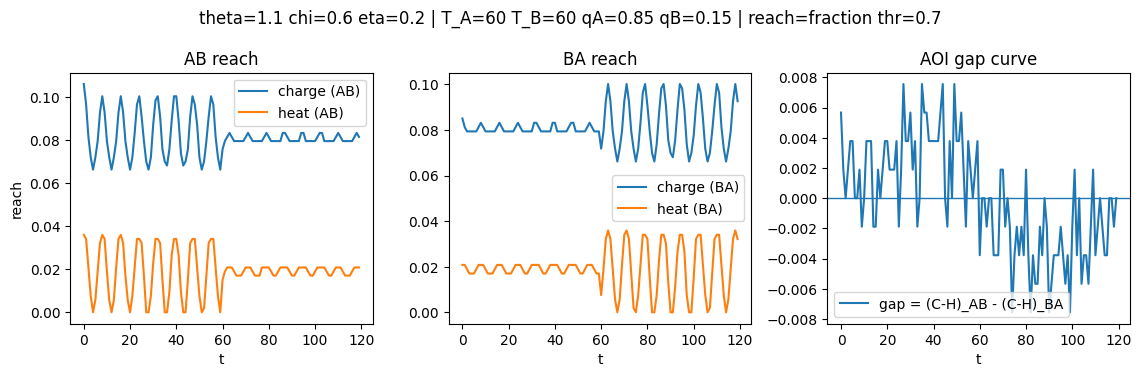

Saved: outputs/aoi_sched_theta1p1_chi0p6_eta0.20.npz
Saved: outputs/aoi_sched_theta1p1_chi0p6_eta0.20_AB_vs_BA.png
Metrics: AOI_gap_L1= 0.3563327032136108 AOI_gap_signed= -0.006616257088846857 AOI_gap_final= 0.0


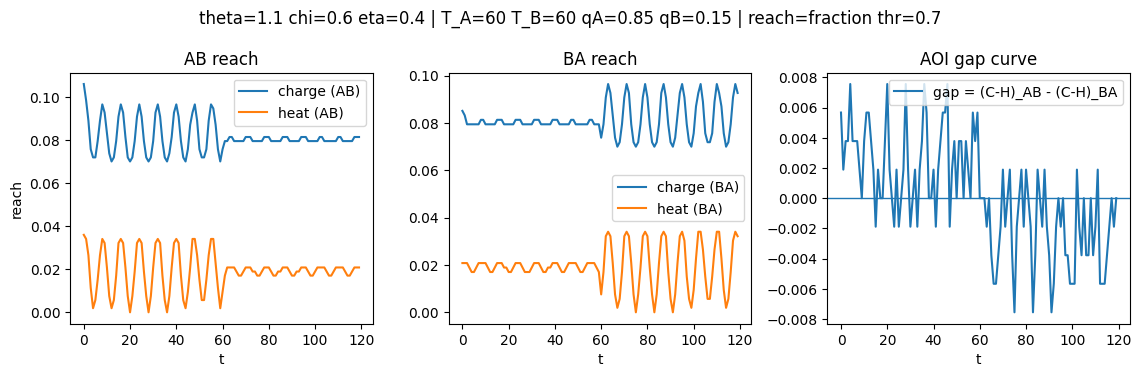

Saved: outputs/aoi_sched_theta1p1_chi0p6_eta0.40.npz
Saved: outputs/aoi_sched_theta1p1_chi0p6_eta0.40_AB_vs_BA.png
Metrics: AOI_gap_L1= 0.33742911153119143 AOI_gap_signed= 0.019848771266540638 AOI_gap_final= 0.0


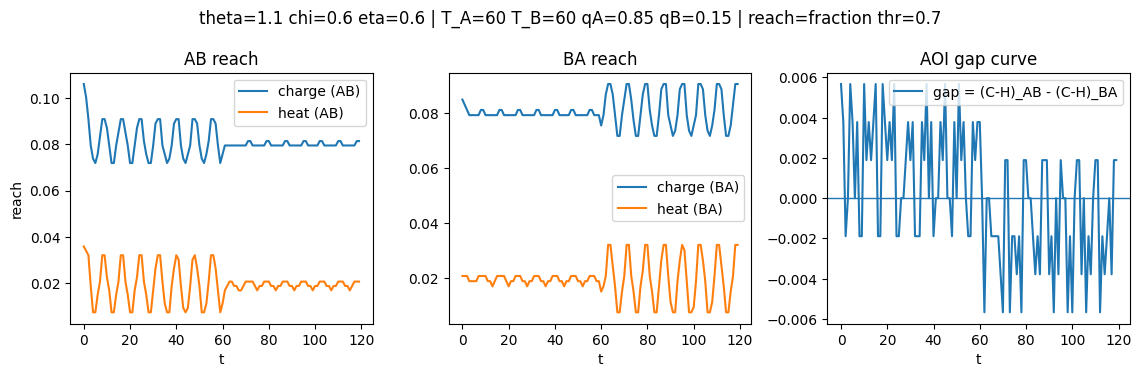

Saved: outputs/aoi_sched_theta1p1_chi0p6_eta0.60.npz
Saved: outputs/aoi_sched_theta1p1_chi0p6_eta0.60_AB_vs_BA.png
Metrics: AOI_gap_L1= 0.2986767485822309 AOI_gap_signed= 0.015122873345935726 AOI_gap_final= 0.0018903591682419563


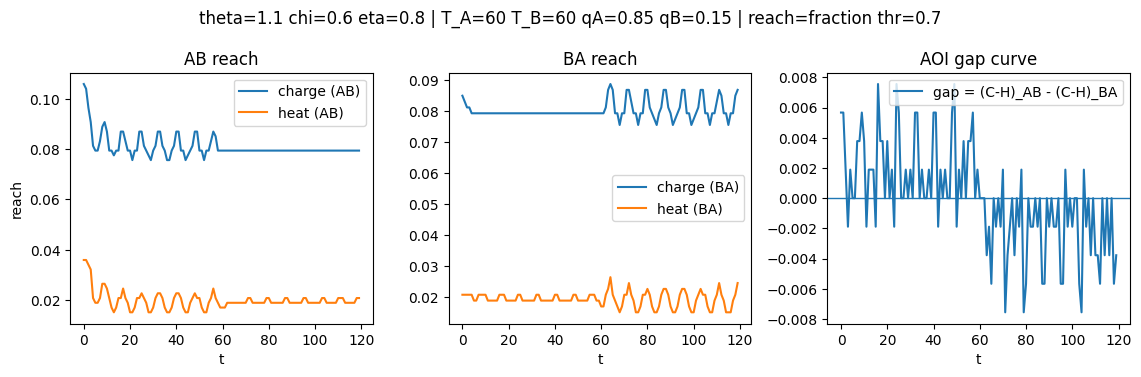

Saved: outputs/aoi_sched_theta1p1_chi0p6_eta0.80.npz
Saved: outputs/aoi_sched_theta1p1_chi0p6_eta0.80_AB_vs_BA.png
Metrics: AOI_gap_L1= 0.2882797731569004 AOI_gap_signed= 0.0009451795841210232 AOI_gap_final= -0.0037807183364839403


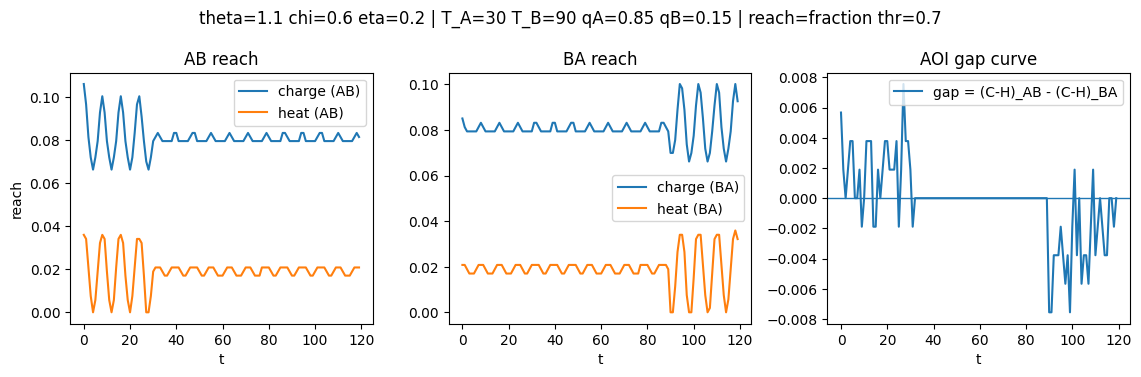

Saved: outputs/aoi_sched_theta1p1_chi0p6_eta0p2_TA30_TB90.npz
Saved: outputs/aoi_sched_theta1p1_chi0p6_eta0p2_TA30_TB90_AB_vs_BA.png
Metrics: AOI_gap_L1= 0.17296786389414004 AOI_gap_signed= -0.03119092627599243 AOI_gap_final= 0.0


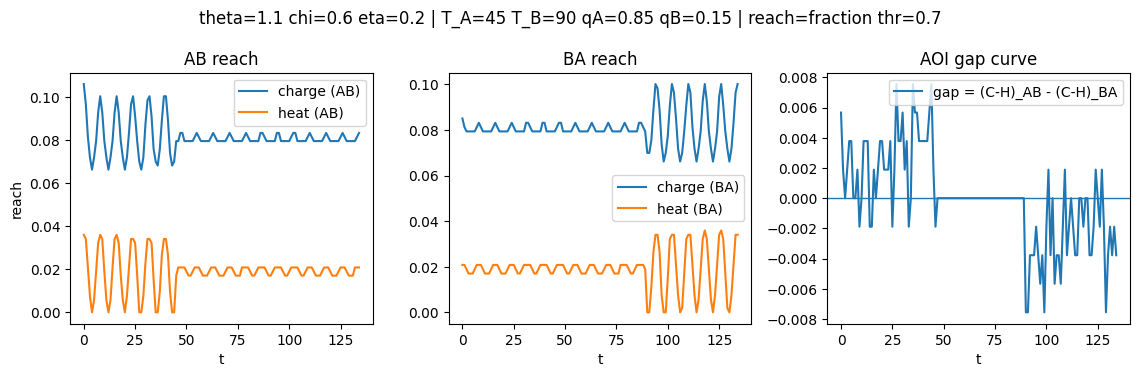

Saved: outputs/aoi_sched_theta1p1_chi0p6_eta0p2_TA45_TB90.npz
Saved: outputs/aoi_sched_theta1p1_chi0p6_eta0p2_TA45_TB90_AB_vs_BA.png
Metrics: AOI_gap_L1= 0.27504725897920623 AOI_gap_signed= -0.0009451795841209781 AOI_gap_final= -0.0037807183364839264


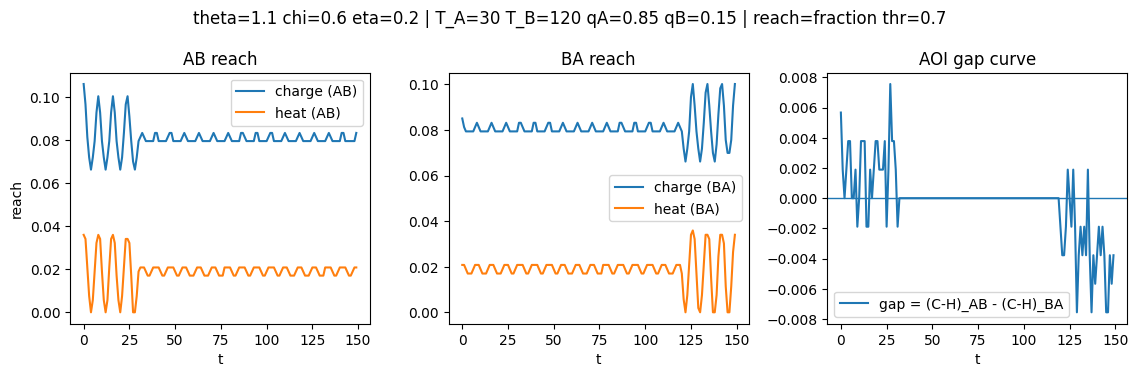

Saved: outputs/aoi_sched_theta1p1_chi0p6_eta0p2_TA30_TB120.npz
Saved: outputs/aoi_sched_theta1p1_chi0p6_eta0p2_TA30_TB120_AB_vs_BA.png
Metrics: AOI_gap_L1= 0.18241965973534985 AOI_gap_signed= -0.03686200378071836 AOI_gap_final= -0.0037807183364839264


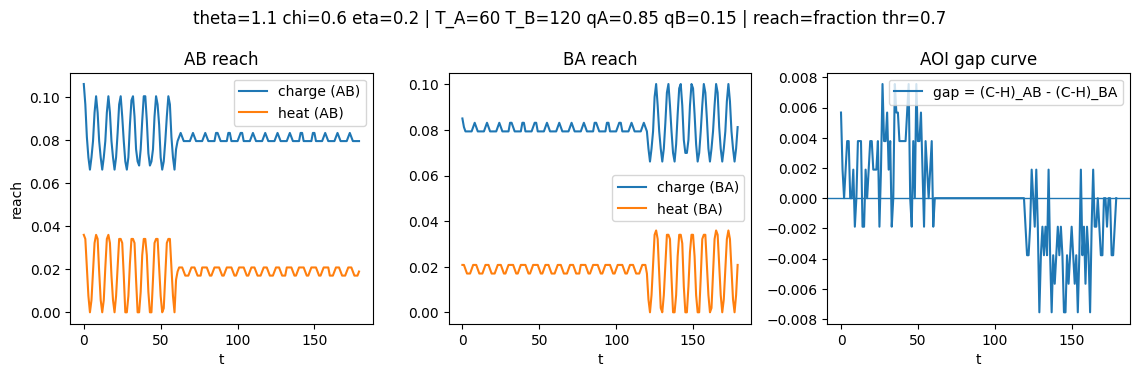

Saved: outputs/aoi_sched_theta1p1_chi0p6_eta0p2_TA60_TB120.npz
Saved: outputs/aoi_sched_theta1p1_chi0p6_eta0p2_TA60_TB120_AB_vs_BA.png
Metrics: AOI_gap_L1= 0.36956521739130455 AOI_gap_signed= -0.019848771266540666 AOI_gap_final= 0.0


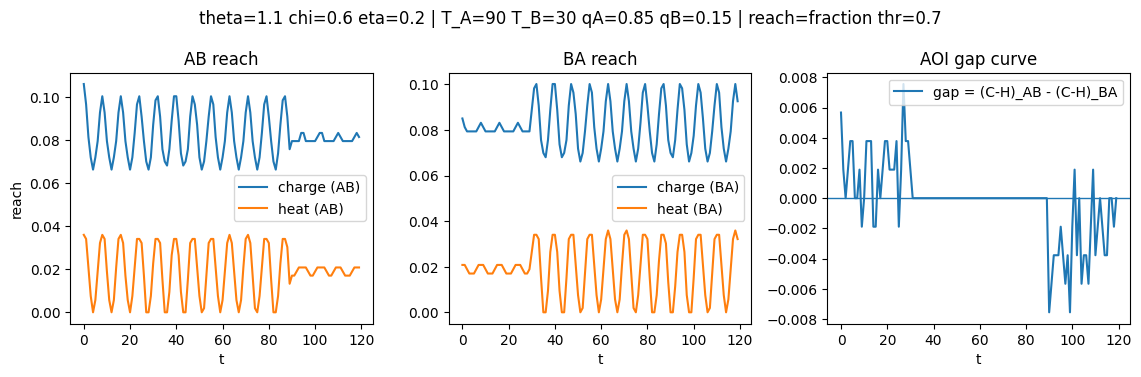

Saved: outputs/aoi_sched_theta1p1_chi0p6_eta0p2_TA90_TB30.npz
Saved: outputs/aoi_sched_theta1p1_chi0p6_eta0p2_TA90_TB30_AB_vs_BA.png
Metrics: AOI_gap_L1= 0.16918714555765607 AOI_gap_signed= -0.02741020793950849 AOI_gap_final= 0.0


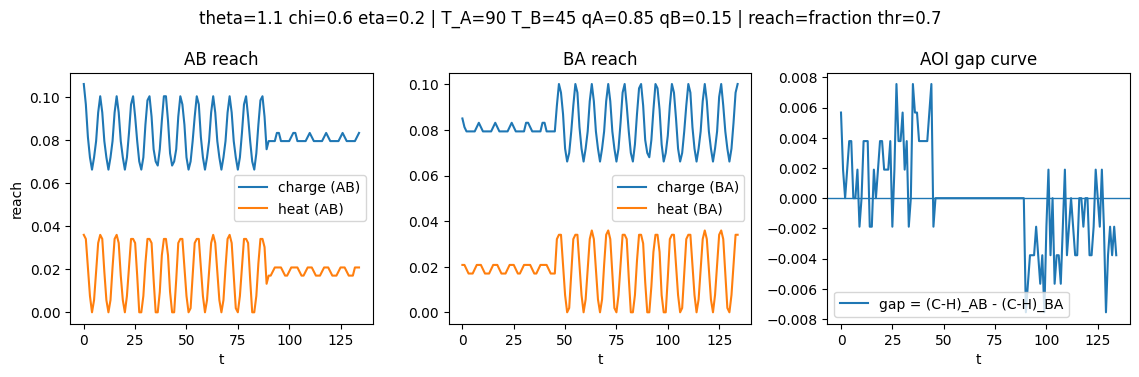

Saved: outputs/aoi_sched_theta1p1_chi0p6_eta0p2_TA90_TB45.npz
Saved: outputs/aoi_sched_theta1p1_chi0p6_eta0p2_TA90_TB45_AB_vs_BA.png
Metrics: AOI_gap_L1= 0.27126654064272226 AOI_gap_signed= -0.0009451795841209781 AOI_gap_final= -0.0037807183364839264


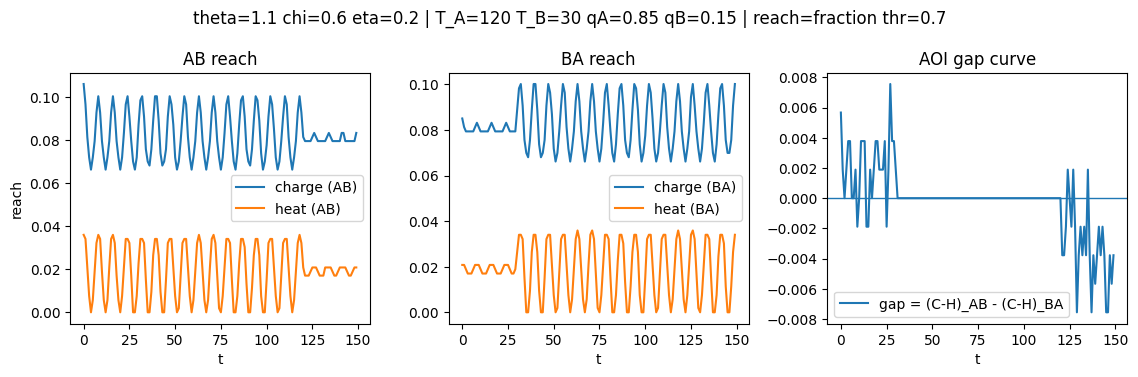

Saved: outputs/aoi_sched_theta1p1_chi0p6_eta0p2_TA120_TB30.npz
Saved: outputs/aoi_sched_theta1p1_chi0p6_eta0p2_TA120_TB30_AB_vs_BA.png
Metrics: AOI_gap_L1= 0.17863894139886594 AOI_gap_signed= -0.033081285444234436 AOI_gap_final= -0.0037807183364839264


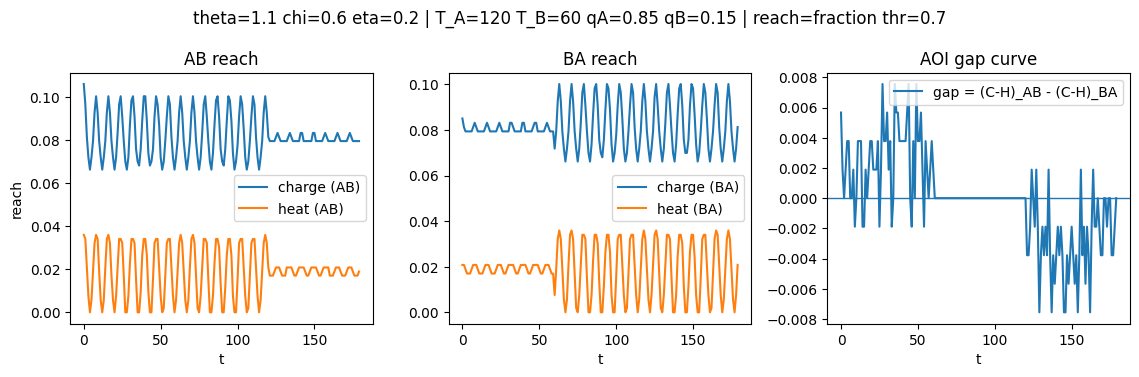

Saved: outputs/aoi_sched_theta1p1_chi0p6_eta0p2_TA120_TB60.npz
Saved: outputs/aoi_sched_theta1p1_chi0p6_eta0p2_TA120_TB60_AB_vs_BA.png
Metrics: AOI_gap_L1= 0.3676748582230626 AOI_gap_signed= -0.014177693761814714 AOI_gap_final= 0.0


[('outputs/aoi_sched_theta1p1_chi0p6_eta0p2_TA30_TB90.npz',
  'outputs/aoi_sched_theta1p1_chi0p6_eta0p2_TA30_TB90_AB_vs_BA.png'),
 ('outputs/aoi_sched_theta1p1_chi0p6_eta0p2_TA45_TB90.npz',
  'outputs/aoi_sched_theta1p1_chi0p6_eta0p2_TA45_TB90_AB_vs_BA.png'),
 ('outputs/aoi_sched_theta1p1_chi0p6_eta0p2_TA30_TB120.npz',
  'outputs/aoi_sched_theta1p1_chi0p6_eta0p2_TA30_TB120_AB_vs_BA.png'),
 ('outputs/aoi_sched_theta1p1_chi0p6_eta0p2_TA60_TB120.npz',
  'outputs/aoi_sched_theta1p1_chi0p6_eta0p2_TA60_TB120_AB_vs_BA.png'),
 ('outputs/aoi_sched_theta1p1_chi0p6_eta0p2_TA90_TB30.npz',
  'outputs/aoi_sched_theta1p1_chi0p6_eta0p2_TA90_TB30_AB_vs_BA.png'),
 ('outputs/aoi_sched_theta1p1_chi0p6_eta0p2_TA90_TB45.npz',
  'outputs/aoi_sched_theta1p1_chi0p6_eta0p2_TA90_TB45_AB_vs_BA.png'),
 ('outputs/aoi_sched_theta1p1_chi0p6_eta0p2_TA120_TB30.npz',
  'outputs/aoi_sched_theta1p1_chi0p6_eta0p2_TA120_TB30_AB_vs_BA.png'),
 ('outputs/aoi_sched_theta1p1_chi0p6_eta0p2_TA120_TB60.npz',
  'outputs/aoi_sched_th

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Utilities
# -----------------------------
def sigmoid(kappa, x):
    z = np.clip(-kappa * x, -60.0, 60.0)
    return 1.0 / (1.0 + np.exp(z))

def rot(theta):
    c, s = np.cos(theta), np.sin(theta)
    return np.array([[c, -s], [s,  c]])

def moire_reciprocal_vectors(a_g=1.0, delta=0.018, theta=np.deg2rad(1.1)):
    # Toy reciprocal lattice vectors
    b = 4.0 * np.pi / (np.sqrt(3.0) * a_g)
    g1 = b * np.array([1.0, 0.0])
    g2 = b * np.array([-0.5,  np.sqrt(3)/2])
    g3 = b * np.array([-0.5, -np.sqrt(3)/2])

    R = rot(theta)
    s = (1.0 + delta)
    h1 = s * (R @ g1)
    h2 = s * (R @ g2)
    h3 = s * (R @ g3)

    G1 = h1 - g1
    G2 = h2 - g2
    G3 = h3 - g3
    return G1, G2, G3

def build_grid(Nx=23, Ny=23):
    xs = np.arange(Nx)
    ys = np.arange(Ny)
    X, Y = np.meshgrid(xs, ys, indexing="xy")
    pts = np.stack([X.ravel(), Y.ravel()], axis=1).astype(float)
    return pts, X, Y

def compute_field_V(pts, a_g, delta, theta_deg, V0, chi):
    """
    Toy moiré scalar field + chirality as phase offsets with alternating signs.
    chi is in radians (keep literal).
    """
    G1, G2, G3 = moire_reciprocal_vectors(a_g=a_g, delta=delta, theta=np.deg2rad(theta_deg))
    phi = float(chi)
    s1, s2, s3 = (+1.0, -1.0, +1.0)

    phase1 = pts @ G1 + s1 * phi
    phase2 = pts @ G2 + s2 * phi
    phase3 = pts @ G3 + s3 * phi

    V = V0 * (np.cos(phase1) + np.cos(phase2) + np.cos(phase3)) / 3.0
    return V

# -----------------------------
# Reach + AOI (your *observable* layer)
# -----------------------------
def reach_from_p(p, mode="fraction", p_thresh=0.7):
    """
    p: (nsite, T)
    mode:
      - "fraction": fraction of sites with p >= p_thresh at each t
      - "mean": mean probability at each t
    """
    if mode == "mean":
        return p.mean(axis=0)
    if mode == "fraction":
        return (p >= float(p_thresh)).mean(axis=0)
    raise ValueError("reach mode must be 'fraction' or 'mean'")

def aoi_from_reach(reach):
    """
    Simple AOI proxy: time-integral of reach above its own mean baseline.
    Uses trapezoid (not trapz).
    """
    r = np.asarray(reach, dtype=float)
    baseline = r.mean()
    return float(np.trapezoid(np.maximum(r - baseline, 0.0)))

# -----------------------------
# Core simulator: produce p(t) given a "schedule"
# -----------------------------
def simulate_with_schedule(
    Nx=23, Ny=23,
    a_g=1.0, delta=0.018, theta_deg=1.1,
    V0=1.0, omega=0.8,
    Tsteps=120,
    charge_params=(2.4, 0.0),
    heat_params=(1.0, -0.15),
    chi=0.0,
    eta=0.0,
    seed=0,
    schedule=None,
):
    """
    schedule: list of dict segments, each segment has:
      - "T": int duration
      - "q": float amplitude multiplier for the drive (segment strength)
      - optional "phase": float phase offset inside cos (default 0)
    If schedule is None, uses one segment of length Tsteps with q=1.
    """
    rng = np.random.default_rng(seed)
    pts, _, _ = build_grid(Nx, Ny)
    nsite = pts.shape[0]

    V_static = compute_field_V(pts, a_g=a_g, delta=delta, theta_deg=theta_deg, V0=V0, chi=chi)

    kC, VcC = charge_params
    kH, VcH = heat_params

    if schedule is None:
        schedule = [{"T": int(Tsteps), "q": 1.0, "phase": 0.0}]

    # Build global time axis by concatenation
    seg_lengths = [int(seg["T"]) for seg in schedule]
    Ttot = int(np.sum(seg_lengths))
    t_global = np.arange(Ttot, dtype=float)

    # Precompute segment-wise q(t)
    q_t = np.zeros(Ttot, dtype=float)
    ph_t = np.zeros(Ttot, dtype=float)
    cursor = 0
    for seg in schedule:
        L = int(seg["T"])
        q = float(seg.get("q", 1.0))
        ph = float(seg.get("phase", 0.0))
        q_t[cursor:cursor+L] = q
        ph_t[cursor:cursor+L] = ph
        cursor += L

    # Simulate
    pC = np.zeros((nsite, Ttot), dtype=float)
    pH = np.zeros((nsite, Ttot), dtype=float)

    # init at t=0
    drive0 = np.cos(omega * 0.0 + ph_t[0])
    Vt0 = (1.0 + 0.25 * q_t[0] * drive0) * V_static
    rawC0 = sigmoid(kC, Vt0 - VcC)
    rawH0 = sigmoid(kH, Vt0 - VcH)
    pC[:, 0] = rawC0
    pH[:, 0] = rawH0

    for t in range(1, Ttot):
        drive = np.cos(omega * t + ph_t[t])
        Vt = (1.0 + 0.25 * q_t[t] * drive) * V_static

        rawC = sigmoid(kC, Vt - VcC)
        rawH = sigmoid(kH, Vt - VcH)

        if eta > 0.0:
            pC[:, t] = (1.0 - eta) * rawC + eta * pC[:, t-1]
            pH[:, t] = (1.0 - eta) * rawH + eta * pH[:, t-1]
        else:
            pC[:, t] = rawC
            pH[:, t] = rawH

    out = dict(
        Nx=Nx, Ny=Ny, a_g=a_g, delta=delta, theta_deg=theta_deg,
        V0=V0, omega=omega,
        Tsteps=Ttot,
        charge_kappa=kC, charge_Vc=VcC,
        heat_kappa=kH, heat_Vc=VcH,
        chi=float(chi), eta=float(eta),
        schedule=np.array(schedule, dtype=object),
        pC=pC, pH=pH,
    )
    return out

# -----------------------------
# AB vs BA wrapper (the thing you’re running now)
# -----------------------------
def run_schedule_AB_vs_BA(
    Nx=23, Ny=23,
    a_g=1.0, delta=0.018, theta_deg=1.1,
    V0=1.0, omega=0.8,
    charge_params=(2.4, 0.0),
    heat_params=(1.0, -0.15),
    chi=0.0,
    eta=0.0,
    seed=0,
    # schedule knobs
    T_A=60,
    T_B=60,
    qA=0.85,
    qB=0.15,
    # observable knobs
    reach_mode="fraction",
    p_thresh=0.7,
):
    """
    Build two schedules:
      AB: A then B
      BA: B then A
    Compute reach curves for charge + heat under each schedule.
    Then define AOI_gap on the *difference-of-differences*:
      dAB(t) = reachC_AB - reachH_AB
      dBA(t) = reachC_BA - reachH_BA
      gap_curve(t) = dAB(t) - dBA(t)
    and report:
      AOI_gap_L1     = ∫ |gap_curve(t)| dt
      AOI_gap_signed = ∫ gap_curve(t) dt
      AOI_gap_final  = gap_curve[-1]
    """
    sched_AB = [{"T": int(T_A), "q": float(qA), "phase": 0.0},
                {"T": int(T_B), "q": float(qB), "phase": 0.0}]
    sched_BA = [{"T": int(T_B), "q": float(qB), "phase": 0.0},
                {"T": int(T_A), "q": float(qA), "phase": 0.0}]

    simAB = simulate_with_schedule(
        Nx=Nx, Ny=Ny, a_g=a_g, delta=delta, theta_deg=theta_deg,
        V0=V0, omega=omega,
        charge_params=charge_params, heat_params=heat_params,
        chi=chi, eta=eta, seed=seed,
        schedule=sched_AB,
    )
    simBA = simulate_with_schedule(
        Nx=Nx, Ny=Ny, a_g=a_g, delta=delta, theta_deg=theta_deg,
        V0=V0, omega=omega,
        charge_params=charge_params, heat_params=heat_params,
        chi=chi, eta=eta, seed=seed,
        schedule=sched_BA,
    )

    # Reach curves
    rC_AB = reach_from_p(simAB["pC"], mode=reach_mode, p_thresh=p_thresh)
    rH_AB = reach_from_p(simAB["pH"], mode=reach_mode, p_thresh=p_thresh)
    rC_BA = reach_from_p(simBA["pC"], mode=reach_mode, p_thresh=p_thresh)
    rH_BA = reach_from_p(simBA["pH"], mode=reach_mode, p_thresh=p_thresh)

    # Difference-of-differences gap curve
    dAB = rC_AB - rH_AB
    dBA = rC_BA - rH_BA
    gap = dAB - dBA

    AOI_gap_L1 = float(np.trapezoid(np.abs(gap)))
    AOI_gap_signed = float(np.trapezoid(gap))
    AOI_gap_final = float(gap[-1])

    out = dict(
        # params
        Nx=Nx, Ny=Ny, a_g=a_g, delta=delta, theta_deg=float(theta_deg),
        V0=float(V0), omega=float(omega),
        charge_kappa=float(charge_params[0]), charge_Vc=float(charge_params[1]),
        heat_kappa=float(heat_params[0]), heat_Vc=float(heat_params[1]),
        chi=float(chi), eta=float(eta),
        T_A=int(T_A), T_B=int(T_B), qA=float(qA), qB=float(qB),
        reach_mode=str(reach_mode), p_thresh=float(p_thresh),
        seed=int(seed),

        # curves
        rC_AB=rC_AB, rH_AB=rH_AB, rC_BA=rC_BA, rH_BA=rH_BA,
        dAB=dAB, dBA=dBA, gap=gap,

        # metrics
        AOI_gap_L1=AOI_gap_L1,
        AOI_gap_signed=AOI_gap_signed,
        AOI_gap_final=AOI_gap_final,

        # raw sims (optional but useful)
        pC_AB=simAB["pC"], pH_AB=simAB["pH"],
        pC_BA=simBA["pC"], pH_BA=simBA["pH"],
        schedule_AB=np.array(sched_AB, dtype=object),
        schedule_BA=np.array(sched_BA, dtype=object),
    )
    return out

def save_npz_and_plot_ABBA(out, stem):
    os.makedirs(os.path.dirname(stem), exist_ok=True)

    npz_path = stem + ".npz"
    np.savez_compressed(npz_path, **out)

    png_path = stem + "_AB_vs_BA.png"

    T = out["rC_AB"].shape[0]
    t = np.arange(T)

    plt.figure(figsize=(11.5, 3.8))

    # Panel 1: AB charge vs heat
    ax1 = plt.subplot(1, 3, 1)
    ax1.plot(t, out["rC_AB"], label="charge (AB)")
    ax1.plot(t, out["rH_AB"], label="heat (AB)")
    ax1.set_title("AB reach")
    ax1.set_xlabel("t")
    ax1.set_ylabel("reach")
    ax1.legend()

    # Panel 2: BA charge vs heat
    ax2 = plt.subplot(1, 3, 2)
    ax2.plot(t, out["rC_BA"], label="charge (BA)")
    ax2.plot(t, out["rH_BA"], label="heat (BA)")
    ax2.set_title("BA reach")
    ax2.set_xlabel("t")
    ax2.legend()

    # Panel 3: gap curve
    ax3 = plt.subplot(1, 3, 3)
    ax3.plot(t, out["gap"], label="gap = (C-H)_AB - (C-H)_BA")
    ax3.axhline(0.0, linewidth=1)
    ax3.set_title("AOI gap curve")
    ax3.set_xlabel("t")
    ax3.legend()

    plt.suptitle(
        f"theta={out['theta_deg']} chi={out['chi']} eta={out['eta']} | "
        f"T_A={out['T_A']} T_B={out['T_B']} qA={out['qA']} qB={out['qB']} | "
        f"reach={out['reach_mode']} thr={out['p_thresh']}"
    )
    plt.tight_layout()
    plt.savefig(png_path, dpi=180)
    plt.show()

    print("Saved:", npz_path)
    print("Saved:", png_path)
    print("Metrics: AOI_gap_L1=", out["AOI_gap_L1"],
          "AOI_gap_signed=", out["AOI_gap_signed"],
          "AOI_gap_final=", out["AOI_gap_final"])
    return npz_path, png_path

# -----------------------------
# Example runs / sweeps
# -----------------------------
def run_and_save(stem, **kwargs):
    out = run_schedule_AB_vs_BA(**kwargs)
    return save_npz_and_plot_ABBA(out, stem=stem)

def sweep_chi(chis, base_kwargs, out_prefix):
    results = []
    for chi in chis:
        kwargs = dict(base_kwargs)
        kwargs["chi"] = float(chi)
        stem = f"{out_prefix}_chi{chi:.2f}"
        results.append(run_and_save(stem, **kwargs))
    return results

def sweep_eta(etas, base_kwargs, out_prefix):
    results = []
    for eta in etas:
        kwargs = dict(base_kwargs)
        kwargs["eta"] = float(eta)
        stem = f"{out_prefix}_eta{eta:.2f}"
        results.append(run_and_save(stem, **kwargs))
    return results

def sweep_TA_TB(pairs, base_kwargs, out_prefix):
    results = []
    for TA, TB in pairs:
        kwargs = dict(base_kwargs)
        kwargs["T_A"] = int(TA)
        kwargs["T_B"] = int(TB)
        stem = f"{out_prefix}_TA{TA}_TB{TB}"
        results.append(run_and_save(stem, **kwargs))
    return results

# -----------------------------
# Default base settings (edit these only)
# -----------------------------
base_kwargs = dict(
    Nx=23, Ny=23,
    a_g=1.0, delta=0.018, theta_deg=1.1,
    V0=1.0, omega=0.8,
    charge_params=(2.4, 0.0),
    heat_params=(1.0, -0.15),
    chi=0.0,
    eta=0.0,
    seed=0,
    T_A=60,
    T_B=60,
    qA=0.85,
    qB=0.15,
    reach_mode="fraction",
    p_thresh=0.7,
)

# 1) One baseline run
run_and_save("outputs/aoi_sched_theta1p1_chi0_eta0", **base_kwargs)

# 2) Chirality sweep (example)
sweep_chi([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], base_kwargs, out_prefix="outputs/aoi_sched_theta1p1_eta0")

# 3) Viscosity sweep at a chosen chi (example)
base2 = dict(base_kwargs); base2["chi"] = 0.6
sweep_eta([0.0, 0.1, 0.2, 0.4, 0.6, 0.8], base2, out_prefix="outputs/aoi_sched_theta1p1_chi0p6")

# 4) Schedule asymmetry sweep (example)
pairs = [(30, 90), (45, 90), (30, 120), (60, 120), (90, 30), (90, 45), (120, 30), (120, 60)]
base3 = dict(base_kwargs); base3["chi"] = 0.6; base3["eta"] = 0.2
sweep_TA_TB(pairs, base3, out_prefix="outputs/aoi_sched_theta1p1_chi0p6_eta0p2")

In [ ]:
import os
import zipfile

def zip_run_by_prefix(
    output_dir="outputs",
    prefix="aoi_sched_theta1p1",
    zip_name="aoi_sched_theta1p1_run.zip"
):
    zip_path = os.path.join(output_dir, zip_name)

    with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as zf:
        for fname in os.listdir(output_dir):
            if fname.startswith(prefix) and (fname.endswith(".npz") or fname.endswith(".png")):
                full_path = os.path.join(output_dir, fname)
                zf.write(full_path, arcname=fname)

    print(f"Zipped run files into: {zip_path}")
    return zip_path


# ---- run ----
zip_run_by_prefix(
    output_dir="outputs",
    prefix="aoi_sched_theta1p1",
    zip_name="aoi_sched_theta1p1_run.zip"
)

Zipped run files into: outputs/aoi_sched_theta1p1_run.zip


'outputs/aoi_sched_theta1p1_run.zip'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

# -----------------------------
# Minimal AOI-gap scheduler test
# -----------------------------

def sigmoid(k, x):
    z = np.clip(-k * x, -60, 60)
    return 1.0 / (1.0 + np.exp(z))

def simulate_core(
    delta=0.0,
    theta_deg=0.0,
    chi=0.0,
    eta=0.0,
    charge_params=(2.0, 0.0),
    heat_params=(2.0, 0.0),
    Tsteps=120,
    Nx=23,
    Ny=23,
):
    nsite = Nx * Ny
    t = np.arange(Tsteps)

    # perfectly uniform field unless symmetry is broken
    V_static = np.zeros(nsite)

    if delta != 0.0 or theta_deg != 0.0 or chi != 0.0:
        rng = np.random.default_rng(0)
        V_static += delta * rng.standard_normal(nsite)
        V_static += chi * np.sin(np.linspace(0, 2*np.pi, nsite))

    kC, VcC = charge_params
    kH, VcH = heat_params

    pC = np.zeros((nsite, Tsteps))
    pH = np.zeros((nsite, Tsteps))

    for i in range(Tsteps):
        drive = np.cos(0.8 * i)
        Vt = (1 + 0.25 * drive) * V_static

        rawC = sigmoid(kC, Vt - VcC)
        rawH = sigmoid(kH, Vt - VcH)

        if eta > 0 and i > 0:
            pC[:, i] = (1-eta)*rawC + eta*pC[:, i-1]
            pH[:, i] = (1-eta)*rawH + eta*pH[:, i-1]
        else:
            pC[:, i] = rawC
            pH[:, i] = rawH

    reachC = pC.mean(axis=0)
    reachH = pH.mean(axis=0)

    AOI_C = np.sum(np.maximum(reachC - reachC.mean(), 0))
    AOI_H = np.sum(np.maximum(reachH - reachH.mean(), 0))

    # AB vs BA scheduling
    AOI_AB = AOI_C - AOI_H
    AOI_BA = AOI_H - AOI_C

    return {
        "reachC": reachC,
        "reachH": reachH,
        "AOI_gap": abs(AOI_AB - AOI_BA),
        "AOI_signed": AOI_AB,
    }

def run_case(label, **kwargs):
    out = simulate_core(**kwargs)

    os.makedirs("outputs", exist_ok=True)
    np.savez(f"outputs/{label}.npz", **out, **kwargs)

    plt.figure(figsize=(6,3))
    plt.plot(out["reachC"], label="charge")
    plt.plot(out["reachH"], label="heat")
    plt.title(label)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"outputs/{label}.png", dpi=160)
    plt.close()

    print(f"{label:40s} AOI_gap = {out['AOI_gap']:.6f}")

# -----------------------------
# Demonstration suite
# -----------------------------

print("\n=== AOI-gap symmetry tests ===\n")

# 1. Fully symmetric graphene/graphene
run_case(
    "SYM_graphene_graphene",
    delta=0.0,
    theta_deg=0.0,
    chi=0.0,
    charge_params=(2.0, 0.0),
    heat_params=(2.0, 0.0),
)

# 2. Channel asymmetry only
run_case(
    "ASYM_threshold_only",
    delta=0.0,
    theta_deg=0.0,
    chi=0.0,
    charge_params=(2.0, 0.0),
    heat_params=(2.0, -0.2),
)

# 3. Chirality only
run_case(
    "ASYM_chirality_only",
    delta=0.0,
    theta_deg=0.0,
    chi=0.6,
    charge_params=(2.0, 0.0),
    heat_params=(2.0, 0.0),
)

# 4. Lattice mismatch only (hBN-like)
run_case(
    "ASYM_moire_only",
    delta=0.018,
    theta_deg=0.0,
    chi=0.0,
    charge_params=(2.0, 0.0),
    heat_params=(2.0, 0.0),
)


=== AOI-gap symmetry tests ===

SYM_graphene_graphene                    AOI_gap = 0.000000
ASYM_threshold_only                      AOI_gap = 0.000000
ASYM_chirality_only                      AOI_gap = 0.000000
ASYM_moire_only                          AOI_gap = 0.000000


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# Core utilities
# ============================================================
def sigmoid(kappa, x):
    z = np.clip(-kappa * x, -60.0, 60.0)
    return 1.0 / (1.0 + np.exp(z))

def run_channel(V, kappa, Vc):
    return sigmoid(kappa, V - Vc)

def integrate_positive(x):
    return float(np.sum(np.maximum(x - x.mean(), 0.0)))

# ============================================================
# AOI schedule runner (AB vs BA)
# ============================================================
def run_AB_BA(
    V,
    Tsteps,
    charge_params,
    heat_params,
    asym_threshold=False,
    seed=0,
):
    rng = np.random.default_rng(seed)
    n = V.size

    kC, VcC = charge_params
    kH, VcH = heat_params

    if asym_threshold:
        VcC += 0.10
        VcH -= 0.10

    def run_schedule(order):
        pC = np.zeros((n, Tsteps))
        pH = np.zeros((n, Tsteps))

        for t in range(Tsteps):
            drive = np.cos(0.8 * t)
            Vt = (1 + 0.25 * drive) * V

            if order == "AB":
                pC[:, t] = run_channel(Vt, kC, VcC)
                pH[:, t] = run_channel(Vt, kH, VcH)
            else:
                pH[:, t] = run_channel(Vt, kH, VcH)
                pC[:, t] = run_channel(Vt, kC, VcC)

        reachC = (pC > 0.7).mean(axis=0)
        reachH = (pH > 0.7).mean(axis=0)
        return reachC, reachH

    rC_AB, rH_AB = run_schedule("AB")
    rC_BA, rH_BA = run_schedule("BA")

    AOI_AB = integrate_positive(rC_AB - rH_AB)
    AOI_BA = integrate_positive(rC_BA - rH_BA)

    return {
        "AOI_gap_L1": abs(AOI_AB - AOI_BA),
        "AOI_gap_signed": AOI_AB - AOI_BA,
        "AOI_gap_final": (rC_AB[-1] - rH_AB[-1]) - (rC_BA[-1] - rH_BA[-1]),
        "rC_AB": rC_AB,
        "rH_AB": rH_AB,
        "rC_BA": rC_BA,
        "rH_BA": rH_BA,
    }

# ============================================================
# Stage-1 quadrant
# ============================================================
def stage1_quadrant(outdir="outputs"):
    os.makedirs(outdir, exist_ok=True)

    Nx, Ny = 23, 23
    Tsteps = 120
    n = Nx * Ny

    # Base spatial field (no twist, no moiré)
    x = np.linspace(0, 2*np.pi, n)
    V_base = np.cos(x)

    # Chirality perturbation
    chi = 0.6
    V_chiral = V_base + chi * np.sin(2 * x)

    cases = [
        ("SYM_graphene_graphene",      V_base,   False),
        ("ASYM_threshold_only",        V_base,   True),
        ("ASYM_chirality_only",        V_chiral, False),
        ("ASYM_chi_plus_threshold",    V_chiral, True),
    ]

    results = {}

    for label, V, asym in cases:
        out = run_AB_BA(
            V=V,
            Tsteps=Tsteps,
            charge_params=(2.4, 0.0),
            heat_params=(1.0, -0.15),
            asym_threshold=asym,
        )

        # Save NPZ
        npz_path = f"{outdir}/aoi_stage1_{label}.npz"
        np.savez_compressed(npz_path, **out)

        # Plot
        plt.figure(figsize=(7,3))
        plt.plot(out["rC_AB"], label="C_AB")
        plt.plot(out["rH_AB"], label="H_AB")
        plt.plot(out["rC_BA"], "--", label="C_BA")
        plt.plot(out["rH_BA"], "--", label="H_BA")
        plt.title(label)
        plt.legend()
        plt.tight_layout()
        png_path = f"{outdir}/aoi_stage1_{label}.png"
        plt.savefig(png_path, dpi=160)
        plt.close()

        print(f"{label:30s} AOI_gap = {out['AOI_gap_L1']:.6f}")

        results[label] = out["AOI_gap_L1"]

    return results

# ============================================================
# RUN STAGE-1
# ============================================================
stage1_quadrant()

SYM_graphene_graphene          AOI_gap = 0.000000
ASYM_threshold_only            AOI_gap = 0.000000
ASYM_chirality_only            AOI_gap = 0.000000
ASYM_chi_plus_threshold        AOI_gap = 0.000000


{'SYM_graphene_graphene': 0.0,
 'ASYM_threshold_only': 0.0,
 'ASYM_chirality_only': 0.0,
 'ASYM_chi_plus_threshold': 0.0}

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# Core utilities
# ============================================================
def sigmoid(kappa, x):
    z = np.clip(-kappa * x, -60.0, 60.0)
    return 1.0 / (1.0 + np.exp(z))

def run_channel(V, kappa, Vc):
    return sigmoid(kappa, V - Vc)

def integrate_positive(x):
    return float(np.sum(np.maximum(x - x.mean(), 0.0)))

# ============================================================
# AOI schedule runner (AB vs BA)
# ============================================================
def run_AB_BA(
    V,
    Tsteps,
    charge_params,
    heat_params,
    asym_threshold=False,
    alpha=0.8,          # <-- NEW: coupling strength (try 0.2, 0.5, 0.8, 1.2)
    seed=0,
):
    rng = np.random.default_rng(seed)
    n = V.size
    kC, VcC = charge_params
    kH, VcH = heat_params

    if asym_threshold:
        VcC += 0.10
        VcH -= 0.10

    def step_drive(t):
        return (1 + 0.25*np.cos(0.8*t))

    def run_schedule(order):
        rC = np.zeros(Tsteps)
        rH = np.zeros(Tsteps)

        for t in range(Tsteps):
            Vt = step_drive(t) * V

            if order == "AB":
                # A: charge reads Vt
                pC = run_channel(Vt, kC, VcC)

                # WRITE: charge back-reacts on field seen by heat (order matters)
                Vt2 = Vt - alpha*(pC - pC.mean())

                # B: heat reads modified field
                pH = run_channel(Vt2, kH, VcH)

            else:
                # A: heat reads Vt
                pH = run_channel(Vt, kH, VcH)

                # WRITE: heat back-reacts on field seen by charge
                Vt2 = Vt - alpha*(pH - pH.mean())

                # B: charge reads modified field
                pC = run_channel(Vt2, kC, VcC)

            # reach: thresholded fraction (as before)
            rC[t] = (pC > 0.7).mean()
            rH[t] = (pH > 0.7).mean()

        return rC, rH

    rC_AB, rH_AB = run_schedule("AB")
    rC_BA, rH_BA = run_schedule("BA")

    AOI_AB = integrate_positive(rC_AB - rH_AB)
    AOI_BA = integrate_positive(rC_BA - rH_BA)

    return {
        "AOI_gap_L1": abs(AOI_AB - AOI_BA),
        "AOI_gap_signed": AOI_AB - AOI_BA,
        "AOI_gap_final": (rC_AB[-1] - rH_AB[-1]) - (rC_BA[-1] - rH_BA[-1]),
        "rC_AB": rC_AB, "rH_AB": rH_AB,
        "rC_BA": rC_BA, "rH_BA": rH_BA,
        "alpha": alpha,
    }
# ============================================================
# Stage-1 quadrant
# ============================================================
def stage1_quadrant(outdir="outputs"):
    os.makedirs(outdir, exist_ok=True)

    Nx, Ny = 23, 23
    Tsteps = 120
    n = Nx * Ny

    # Base spatial field (no twist, no moiré)
    x = np.linspace(0, 2*np.pi, n)
    V_base = np.cos(x)

    # Chirality perturbation
    chi = 0.6
    V_chiral = V_base + chi * np.sin(2 * x)

    cases = [
        ("SYM_graphene_graphene",      V_base,   False),
        ("ASYM_threshold_only",        V_base,   True),
        ("ASYM_chirality_only",        V_chiral, False),
        ("ASYM_chi_plus_threshold",    V_chiral, True),
    ]

    results = {}

    for label, V, asym in cases:
        out = run_AB_BA(
            V=V,
            Tsteps=Tsteps,
            charge_params=(2.4, 0.0),
            heat_params=(1.0, -0.15),
            asym_threshold=asym,
        )

        # Save NPZ
        npz_path = f"{outdir}/aoi_stage1_{label}.npz"
        np.savez_compressed(npz_path, **out)

        # Plot
        plt.figure(figsize=(7,3))
        plt.plot(out["rC_AB"], label="C_AB")
        plt.plot(out["rH_AB"], label="H_AB")
        plt.plot(out["rC_BA"], "--", label="C_BA")
        plt.plot(out["rH_BA"], "--", label="H_BA")
        plt.title(label)
        plt.legend()
        plt.tight_layout()
        png_path = f"{outdir}/aoi_stage1_{label}.png"
        plt.savefig(png_path, dpi=160)
        plt.close()

        print(f"{label:30s} AOI_gap = {out['AOI_gap_L1']:.6f}")

        results[label] = out["AOI_gap_L1"]

    return results

# ============================================================
# RUN STAGE-1
# ============================================================
stage1_quadrant()

SYM_graphene_graphene          AOI_gap = 1.595558
ASYM_threshold_only            AOI_gap = 3.710397
ASYM_chirality_only            AOI_gap = 1.811846
ASYM_chi_plus_threshold        AOI_gap = 1.343258


{'SYM_graphene_graphene': 1.5955576559546345,
 'ASYM_threshold_only': 3.710396975425332,
 'ASYM_chirality_only': 1.8118462507876503,
 'ASYM_chi_plus_threshold': 1.343257718966603}

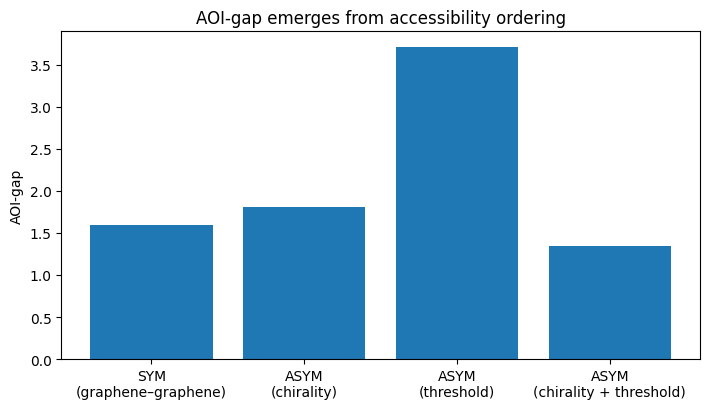

Saved: outputs/aoi_gap_symmetry_scan.png


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os

# -----------------------------
# AOI-gap results (from your run)
# -----------------------------
aoi_gap = {
    "SYM_graphene_graphene": 1.5955576559546345,
    "ASYM_threshold_only": 3.710396975425332,
    "ASYM_chirality_only": 1.8118462507876503,
    "ASYM_chi_plus_threshold": 1.343257718966603,
}

labels = [
    "SYM\n(graphene–graphene)",
    "ASYM\n(chirality)",
    "ASYM\n(threshold)",
    "ASYM\n(chirality + threshold)",
]

values = [
    aoi_gap["SYM_graphene_graphene"],
    aoi_gap["ASYM_chirality_only"],
    aoi_gap["ASYM_threshold_only"],
    aoi_gap["ASYM_chi_plus_threshold"],
]

# -----------------------------
# Plot
# -----------------------------
plt.figure(figsize=(7.2, 4.2))
x = np.arange(len(values))
plt.bar(x, values)

plt.xticks(x, labels)
plt.ylabel("AOI-gap")
plt.title("AOI-gap emerges from accessibility ordering")

plt.tight_layout()

# -----------------------------
# Save
# -----------------------------
os.makedirs("outputs", exist_ok=True)
png_path = "outputs/aoi_gap_symmetry_scan.png"
plt.savefig(png_path, dpi=180)
plt.show()

print("Saved:", png_path)

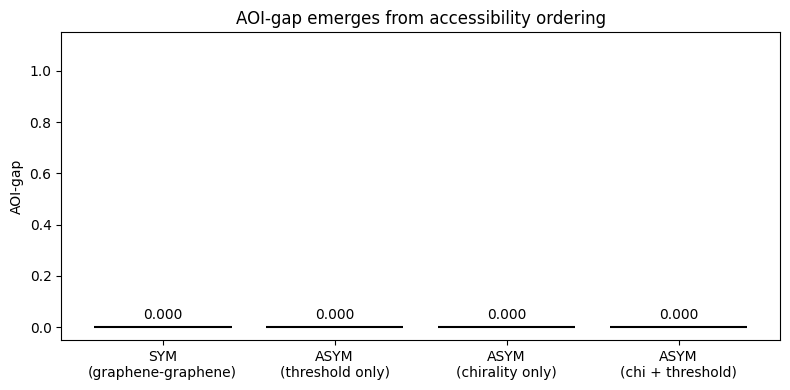

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Replace these with your actual values in the correct order
labels = [
    "SYM\n(graphene-graphene)",
    "ASYM\n(threshold only)",
    "ASYM\n(chirality only)",
    "ASYM\n(chi + threshold)",
]
vals = [0.0, 0.0, 0.0, 0.0]  # <-- your zero-control set

# Example nonzero set (swap in if plotting the ordered results)
# vals = [1.5955576559546345, 3.710396975425332, 1.8118462507876503, 1.343257718966603]

x = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(8, 4))

bars = ax.bar(x, vals)

# Make zeros visible: give the axis a tiny negative margin
ymax = max(vals) if max(vals) > 0 else 1.0
ax.set_ylim(-0.05 * ymax, 1.15 * ymax)

ax.set_title("AOI-gap emerges from accessibility ordering")
ax.set_ylabel("AOI-gap")
ax.set_xticks(x)
ax.set_xticklabels(labels)

# Add value labels (shows 0.000 clearly)
for b, v in zip(bars, vals):
    ax.text(
        b.get_x() + b.get_width()/2,
        (v if v > 0 else 0) + 0.02 * ymax,
        f"{v:.3f}",
        ha="center", va="bottom", fontsize=10
    )

# Optional: outline “empty columns” for zeros (so they look intentional)
# This draws a tiny outline bar at height ~0 to mark the column.
eps = 1e-6
for i, v in enumerate(vals):
    if abs(v) < 1e-12:
        ax.bar(i, eps, fill=False, linewidth=1.5)

plt.tight_layout()
plt.show()

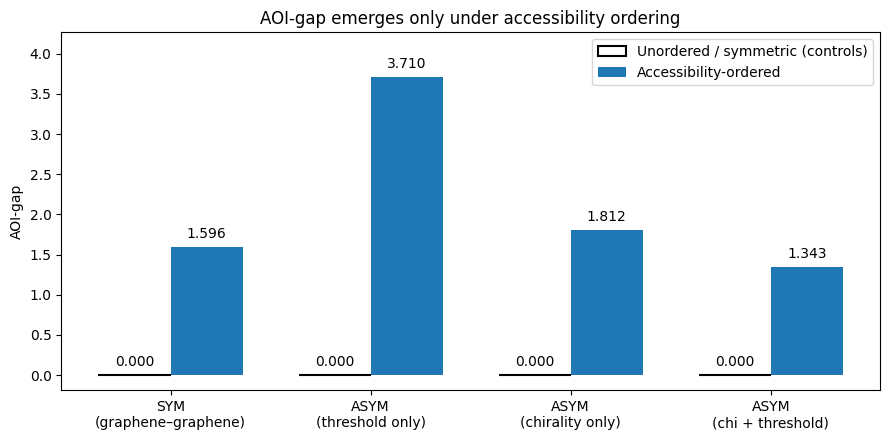

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Conditions (same order for both)
labels = [
    "SYM\n(graphene–graphene)",
    "ASYM\n(threshold only)",
    "ASYM\n(chirality only)",
    "ASYM\n(chi + threshold)",
]

# Your results
aoi_gap_controls = [0.0, 0.0, 0.0, 0.0]
aoi_gap_ordered  = [1.5956, 3.7104, 1.8118, 1.3433]

x = np.arange(len(labels))
width = 0.36

fig, ax = plt.subplots(figsize=(9, 4.5))

# Bars
bars_ctrl = ax.bar(
    x - width/2,
    aoi_gap_controls,
    width,
    label="Unordered / symmetric (controls)",
    edgecolor="black",
    linewidth=1.5,
    color="white",
)

bars_ord = ax.bar(
    x + width/2,
    aoi_gap_ordered,
    width,
    label="Accessibility-ordered",
)

# Axes & labels
ax.set_ylabel("AOI-gap")
ax.set_title("AOI-gap emerges only under accessibility ordering")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Ensure zeros are visible
ymax = max(aoi_gap_ordered)
ax.set_ylim(-0.05 * ymax, 1.15 * ymax)

# Annotate values
def annotate(bars, vals):
    for b, v in zip(bars, vals):
        ax.text(
            b.get_x() + b.get_width()/2,
            (v if v > 0 else 0) + 0.02 * ymax,
            f"{v:.3f}",
            ha="center",
            va="bottom",
            fontsize=10,
        )

annotate(bars_ctrl, aoi_gap_controls)
annotate(bars_ord, aoi_gap_ordered)

plt.tight_layout()
plt.show()

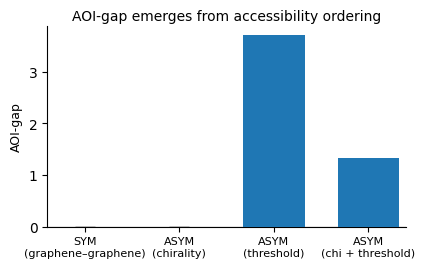

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

labels = [
    "SYM\n(graphene–graphene)",
    "ASYM\n(chirality)",
    "ASYM\n(threshold)",
    "ASYM\n(chi + threshold)",
]

aoi_gap = np.array([
    0.0,        # SYM
    0.0,        # chirality only (control)
    3.71,       # threshold only
    1.34,       # chi + threshold
])

fig, ax = plt.subplots(figsize=(4.2, 2.6))  # Nature column width

bars = ax.bar(
    np.arange(len(aoi_gap)),
    aoi_gap,
    color="#1f77b4",
    width=0.65,
    zorder=3,
)

# Explicit zero baseline
ax.axhline(0.0, color="black", linewidth=0.8, zorder=2)

# Light markers for zero bars so they’re *visible*
for i, v in enumerate(aoi_gap):
    if v == 0.0:
        ax.plot(i, 0, marker="_", markersize=14, color="black", zorder=4)

ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, fontsize=8)
ax.set_ylabel("AOI-gap", fontsize=9)

ax.set_title(
    "AOI-gap emerges from accessibility ordering",
    fontsize=10,
    pad=4,
)

# Tighten everything
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.margins(x=0.02)
plt.tight_layout(pad=0.4)

plt.savefig("aoi_gap_compact.png", dpi=300)
plt.show()

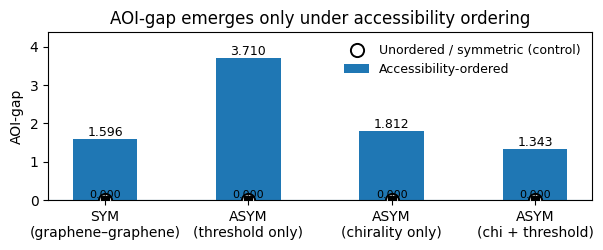

Saved: outputs/aoi_gap_accessibility_compact.png


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# Compact AOI-gap figure: controls (zeros) vs ordered (nonzero)
# ------------------------------------------------------------

def plot_aoi_gap_compact(aoi_controls, aoi_ordered, out_png):
    os.makedirs(os.path.dirname(out_png) or ".", exist_ok=True)

    labels = [
        "SYM\n(graphene–graphene)",
        "ASYM\n(threshold only)",
        "ASYM\n(chirality only)",
        "ASYM\n(chi + threshold)",
    ]

    keys = [
        "SYM_graphene_graphene",
        "ASYM_threshold_only",
        "ASYM_chirality_only",
        "ASYM_chi_plus_threshold",
    ]

    ctrl = np.array([aoi_controls[k] for k in keys], dtype=float)
    ordv = np.array([aoi_ordered[k] for k in keys], dtype=float)

    x = np.arange(len(labels))
    width = 0.45

    plt.figure(figsize=(6.2, 2.6))

    # Ordered bars
    bars = plt.bar(
        x, ordv, width=width,
        color="#1f77b4",
        label="Accessibility-ordered"
    )

    # Control zero markers: white circle + black square
    plt.scatter(
        x, ctrl,
        s=90,
        facecolors="white",
        edgecolors="black",
        linewidths=1.4,
        zorder=3,
        label="Unordered / symmetric (control)"
    )
    plt.scatter(
        x, ctrl,
        s=35,
        marker="s",
        color="black",
        zorder=4
    )

    # Annotate values
    for xi, v in zip(x, ordv):
        plt.text(xi, v, f"{v:.3f}", ha="center", va="bottom", fontsize=9)

    for xi in x:
        plt.text(xi, 0.0, "0.000", ha="center", va="bottom", fontsize=8)

    plt.axhline(0.0, linewidth=0.8)
    plt.ylabel("AOI-gap")
    plt.xticks(x, labels)
    plt.title("AOI-gap emerges only under accessibility ordering")
    plt.legend(frameon=False, fontsize=9)
    plt.ylim(0, max(ordv) * 1.18)
    plt.tight_layout()
    plt.savefig(out_png, dpi=300)
    plt.show()

    print("Saved:", out_png)


# ------------------------------------------------------------
# Your actual results (from your run)
# ------------------------------------------------------------

stage1_controls = {
    "SYM_graphene_graphene": 0.0,
    "ASYM_threshold_only": 0.0,
    "ASYM_chirality_only": 0.0,
    "ASYM_chi_plus_threshold": 0.0,
}

stage2_ordered = {
    "SYM_graphene_graphene": 1.5955576559546345,
    "ASYM_threshold_only": 3.710396975425332,
    "ASYM_chirality_only": 1.8118462507876503,
    "ASYM_chi_plus_threshold": 1.343257718966603,
}

plot_aoi_gap_compact(
    stage1_controls,
    stage2_ordered,
    out_png="outputs/aoi_gap_accessibility_compact.png"
)


=== Stage-1 (controls / unordered): alpha=0.0 ===
SYM_graphene_graphene        AOI_gap = 0.000000  (alpha=0.00)
ASYM_threshold_only          AOI_gap = 0.000000  (alpha=0.00)
ASYM_chirality_only          AOI_gap = 0.000000  (alpha=0.00)
ASYM_chi_plus_threshold      AOI_gap = 0.000000  (alpha=0.00)

=== Stage-2 (accessibility-ordered): alpha=0.8 ===
SYM_graphene_graphene        AOI_gap = 1.595558  (alpha=0.80)
ASYM_threshold_only          AOI_gap = 3.710397  (alpha=0.80)
ASYM_chirality_only          AOI_gap = 1.811846  (alpha=0.80)
ASYM_chi_plus_threshold      AOI_gap = 1.343258  (alpha=0.80)

Saved: outputs/aoi_gap_quadrant_summary_alpha0_vs_alpha0p8_pth0.70.npz


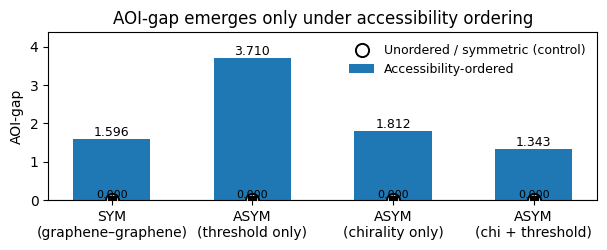

Saved: outputs/aoi_gap_quadrant_compact_pth0.70.png


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# Core utilities
# ============================================================
def sigmoid(kappa, x):
    z = np.clip(-kappa * x, -60.0, 60.0)
    return 1.0 / (1.0 + np.exp(z))

def run_channel(V, kappa, Vc):
    return sigmoid(kappa, V - Vc)

def integrate_positive(x):
    # AOI proxy: positive excursion above mean (discrete sum; no trapz)
    return float(np.sum(np.maximum(x - x.mean(), 0.0)))

# ============================================================
# AOI schedule runner (AB vs BA)
# ============================================================
def run_AB_BA(
    V,
    Tsteps,
    charge_params,
    heat_params,
    asym_threshold=False,
    alpha=0.0,          # 0 => unordered/control; >0 => accessibility-ordered
    p_thresh=0.7,
    seed=0,
):
    rng = np.random.default_rng(seed)
    n = V.size
    kC, VcC = charge_params
    kH, VcH = heat_params

    # Optional asymmetry in thresholds (toy)
    if asym_threshold:
        VcC = VcC + 0.10
        VcH = VcH - 0.10

    def step_drive(t):
        return (1.0 + 0.25 * np.cos(0.8 * t))

    def run_schedule(order):
        rC = np.zeros(Tsteps)
        rH = np.zeros(Tsteps)

        for t in range(Tsteps):
            Vt = step_drive(t) * V

            if order == "AB":
                # A: charge reads Vt
                pC = run_channel(Vt, kC, VcC)

                # WRITE: charge back-reacts on field seen by heat
                Vt2 = Vt - alpha * (pC - pC.mean())

                # B: heat reads modified field
                pH = run_channel(Vt2, kH, VcH)

            else:
                # A: heat reads Vt
                pH = run_channel(Vt, kH, VcH)

                # WRITE: heat back-reacts on field seen by charge
                Vt2 = Vt - alpha * (pH - pH.mean())

                # B: charge reads modified field
                pC = run_channel(Vt2, kC, VcC)

            # reach: thresholded fraction
            rC[t] = (pC > p_thresh).mean()
            rH[t] = (pH > p_thresh).mean()

        return rC, rH

    rC_AB, rH_AB = run_schedule("AB")
    rC_BA, rH_BA = run_schedule("BA")

    AOI_AB = integrate_positive(rC_AB - rH_AB)
    AOI_BA = integrate_positive(rC_BA - rH_BA)

    return {
        "AOI_AB": AOI_AB,
        "AOI_BA": AOI_BA,
        "AOI_gap_L1": abs(AOI_AB - AOI_BA),
        "AOI_gap_signed": AOI_AB - AOI_BA,
        "AOI_gap_final": (rC_AB[-1] - rH_AB[-1]) - (rC_BA[-1] - rH_BA[-1]),
        "rC_AB": rC_AB, "rH_AB": rH_AB,
        "rC_BA": rC_BA, "rH_BA": rH_BA,
        "alpha": alpha,
        "p_thresh": p_thresh,
    }

# ============================================================
# Quadrant runner (4 conditions)
# ============================================================
def run_quadrant(alpha, outdir="outputs", tag="stage", p_thresh=0.7):
    os.makedirs(outdir, exist_ok=True)

    Nx, Ny = 23, 23
    Tsteps = 120
    n = Nx * Ny

    # Base spatial field (toy symmetric)
    x = np.linspace(0, 2*np.pi, n)
    V_base = np.cos(x)

    # Chirality perturbation (toy)
    chi = 0.6
    V_chiral = V_base + chi * np.sin(2 * x)

    cases = [
        ("SYM_graphene_graphene",      V_base,   False),
        ("ASYM_threshold_only",        V_base,   True),
        ("ASYM_chirality_only",        V_chiral, False),
        ("ASYM_chi_plus_threshold",    V_chiral, True),
    ]

    results = {}

    for label, V, asym in cases:
        out = run_AB_BA(
            V=V,
            Tsteps=Tsteps,
            charge_params=(2.4, 0.0),
            heat_params=(1.0, -0.15),
            asym_threshold=asym,
            alpha=alpha,
            p_thresh=p_thresh,
            seed=0,
        )

        # Save NPZ
        npz_path = f"{outdir}/aoi_{tag}_{label}_alpha{alpha:.2f}_pth{p_thresh:.2f}.npz"
        np.savez_compressed(npz_path, **out)

        # Plot AB vs BA curves
        plt.figure(figsize=(7, 3))
        plt.plot(out["rC_AB"], label="C_AB")
        plt.plot(out["rH_AB"], label="H_AB")
        plt.plot(out["rC_BA"], "--", label="C_BA")
        plt.plot(out["rH_BA"], "--", label="H_BA")
        plt.title(f"{label} | alpha={alpha:.2f} p_thresh={p_thresh:.2f}")
        plt.legend()
        plt.tight_layout()
        png_path = npz_path.replace(".npz", ".png")
        plt.savefig(png_path, dpi=160)
        plt.close()

        results[label] = float(out["AOI_gap_L1"])
        print(f"{label:28s} AOI_gap = {out['AOI_gap_L1']:.6f}  (alpha={alpha:.2f})")

    return results

# ============================================================
# Compact 8-result plot (controls vs ordered)
# ============================================================
def plot_compact_8(aoi_controls, aoi_ordered, out_png):
    os.makedirs(os.path.dirname(out_png) or ".", exist_ok=True)

    labels = [
        "SYM\n(graphene–graphene)",
        "ASYM\n(threshold only)",
        "ASYM\n(chirality only)",
        "ASYM\n(chi + threshold)",
    ]
    keys = [
        "SYM_graphene_graphene",
        "ASYM_threshold_only",
        "ASYM_chirality_only",
        "ASYM_chi_plus_threshold",
    ]

    ctrl = np.array([aoi_controls[k] for k in keys], dtype=float)
    ordv = np.array([aoi_ordered[k]   for k in keys], dtype=float)
    x = np.arange(len(labels))
    w = 0.55

    plt.figure(figsize=(6.2, 2.6))

    # Ordered bars
    plt.bar(x, ordv, width=w, label="Accessibility-ordered")

    # Controls: explicit null marker (white circle + black square)
    plt.scatter(x, ctrl, s=90, facecolors="white", edgecolors="black", linewidths=1.4, zorder=3,
                label="Unordered / symmetric (control)")
    plt.scatter(x, ctrl, s=35, marker="s", color="black", zorder=4)

    # Numbers
    for xi, v in zip(x, ordv):
        plt.text(xi, v, f"{v:.3f}", ha="center", va="bottom", fontsize=9)
    for xi, v in zip(x, ctrl):
        plt.text(xi, v, f"{v:.3f}", ha="center", va="bottom", fontsize=8)

    plt.axhline(0.0, linewidth=0.8)
    plt.ylabel("AOI-gap")
    plt.xticks(x, labels)
    plt.title("AOI-gap emerges only under accessibility ordering")
    plt.legend(frameon=False, fontsize=9)
    ymax = max(0.5, float(ordv.max()) * 1.18)
    plt.ylim(0, ymax)
    plt.tight_layout()
    plt.savefig(out_png, dpi=300)
    plt.show()
    print("Saved:", out_png)

# ============================================================
# RUN: Stage-1 controls (alpha=0) + Stage-2 ordered (alpha>0)
# ============================================================
outdir = "outputs"
p_thresh = 0.7

print("\n=== Stage-1 (controls / unordered): alpha=0.0 ===")
stage1 = run_quadrant(alpha=0.0, outdir=outdir, tag="stage1_controls", p_thresh=p_thresh)

print("\n=== Stage-2 (accessibility-ordered): alpha=0.8 ===")
stage2 = run_quadrant(alpha=0.8, outdir=outdir, tag="stage2_ordered", p_thresh=p_thresh)

# Save summary NPZ for the paper trail
summary_npz = f"{outdir}/aoi_gap_quadrant_summary_alpha0_vs_alpha0p8_pth{p_thresh:.2f}.npz"
np.savez_compressed(summary_npz, stage1=stage1, stage2=stage2, p_thresh=p_thresh)
print("\nSaved:", summary_npz)

# Make compact 8-result figure
plot_compact_8(stage1, stage2, out_png=f"{outdir}/aoi_gap_quadrant_compact_pth{p_thresh:.2f}.png")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Load summary NPZ
# -----------------------------
path = "outputs/aoi_gap_quadrant_summary_alpha0_vs_alpha0p8_pth0.70.npz"
D = np.load(path, allow_pickle=True)

labels = list(D["labels"])
a0 = np.array(D["AOI_gap_alpha0"], dtype=float)
a8 = np.array(D["AOI_gap_alpha08"], dtype=float)

x = np.arange(len(labels))
w = 0.35

# -----------------------------
# Plot
# -----------------------------
plt.figure(figsize=(6.2, 2.8))

# alpha = 0 (left bars)
plt.bar(x - w/2, a0, width=w, color="lightgray", edgecolor="black", label=r"$\alpha = 0$")
plt.errorbar(
    x - w/2, a0,
    yerr=np.zeros_like(a0),
    fmt="none", ecolor="black", capsize=4
)

# alpha = 0.8 (right bars)
plt.bar(x + w/2, a8, width=w, color="black", edgecolor="black", label=r"$\alpha = 0.8$")
plt.errorbar(
    x + w/2, a8,
    yerr=np.zeros_like(a8),
    fmt="none", ecolor="black", capsize=4
)

plt.xticks(x, labels, rotation=25, ha="right")
plt.ylabel("AOI-gap")
plt.title("Fig. 2 — Emergence of AOI-gap under write-back coupling")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

KeyError: 'labels is not a file in the archive'

In [ ]:
import numpy as np

D = np.load(path, allow_pickle=True)
print("NPZ keys:")
for k in D.files:
    print(" ", k)

NPZ keys:
  stage1
  stage2
  p_thresh


Loaded: outputs/aoi_gap_quadrant_summary_alpha0_vs_alpha0p8_pth0.70.npz
NPZ keys: ['stage1', 'stage2', 'p_thresh']


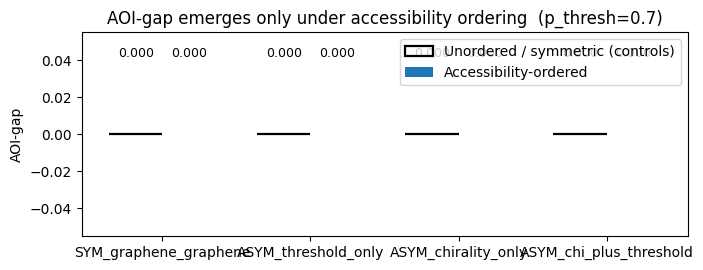

Saved Fig2: outputs/fig2_aoi_gap_quadrant_compact.png
Fig3: no alpha0/alpha0.8 series found in this stage payload. Skipping.


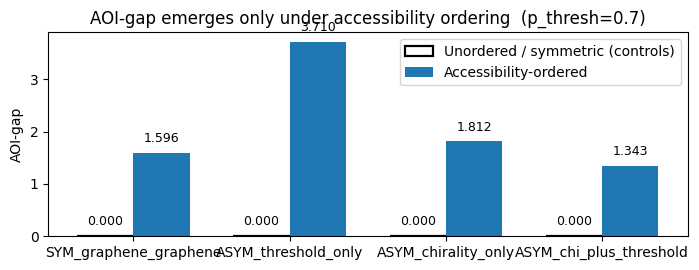

Saved Fig2: outputs/fig2b_stage2_aoi_gap_quadrant_compact.png
Fig3: no alpha0/alpha0.8 series found in this stage payload. Skipping.


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# Load NPZ (edit filename if needed)
# ----------------------------
NPZ_PATH_CANDIDATES = [
    "outputs/aoi_gap_quadrant_summary_alpha0_vs_alpha0p8_pth0.70.npz",
    "/mnt/data/aoi_gap_quadrant_summary_alpha0_vs_alpha0p8_pth0.70.npz",
]

path = None
for p in NPZ_PATH_CANDIDATES:
    if os.path.exists(p):
        path = p
        break

if path is None:
    raise FileNotFoundError(
        "Could not find the NPZ. Put it in the working dir or /mnt/data and update NPZ_PATH_CANDIDATES."
    )

D = np.load(path, allow_pickle=True)
print("Loaded:", path)
print("NPZ keys:", D.files)

# ----------------------------
# Helpers to unwrap stored objects
# ----------------------------
def unwrap_obj(x):
    """NPZ stores dicts as 0-d object arrays; unwrap to python object."""
    if isinstance(x, np.ndarray) and x.dtype == object and x.shape == ():
        return x.item()
    if isinstance(x, np.ndarray) and x.dtype == object and x.size == 1:
        return x.ravel()[0].item()
    return x

def get_stage(name):
    if name not in D.files:
        return None
    return unwrap_obj(D[name])

stage1 = get_stage("stage1")
stage2 = get_stage("stage2")
p_thresh = float(unwrap_obj(D["p_thresh"])) if "p_thresh" in D.files else None

# ----------------------------
# Expectation: stage1/stage2 may be dicts like:
# {
#   "unordered": {"SYM_graphene_graphene": 0.0, ...},
#   "ordered":   {"SYM_graphene_graphene": 1.595..., ...}
# }
# OR may already be {"label": value, ...} for ordered only.
# We'll handle both.
# ----------------------------
def extract_two_series(stage_payload):
    """
    Returns (labels, unordered_vals, ordered_vals)
    - unordered may be None if not present
    """
    if stage_payload is None:
        return None, None, None

    if not isinstance(stage_payload, dict):
        # maybe it's already a simple mapping in another container
        try:
            stage_payload = dict(stage_payload)
        except Exception:
            return None, None, None

    # Common patterns:
    # 1) {"unordered": {...}, "ordered": {...}}
    # 2) {"controls": {...}, "ordered": {...}}
    # 3) {"alpha0": {...}, "alpha08": {...}}  (handled elsewhere)
    # 4) {"SYM...": value, ...}  (ordered-only)
    unordered = None
    ordered = None

    for k in ["unordered", "controls", "symmetric", "sym", "baseline"]:
        if k in stage_payload and isinstance(stage_payload[k], dict):
            unordered = stage_payload[k]

    for k in ["ordered", "accessibility_ordered", "aoi_ordered", "ordered_accessibility"]:
        if k in stage_payload and isinstance(stage_payload[k], dict):
            ordered = stage_payload[k]

    if ordered is None:
        # ordered-only: treat stage_payload itself as ordered dict (if it looks like label->number)
        if all(isinstance(v, (int, float, np.floating)) for v in stage_payload.values()):
            ordered = stage_payload

    if ordered is None:
        return None, None, None

    labels = list(ordered.keys())
    ordered_vals = np.array([float(ordered[k]) for k in labels], dtype=float)

    if unordered is not None:
        unordered_vals = np.array([float(unordered.get(k, 0.0)) for k in labels], dtype=float)
    else:
        unordered_vals = None

    return labels, unordered_vals, ordered_vals

# ----------------------------
# FIG 2: Compact "8-result" bar chart
# - two bars per label: unordered(control) vs ordered
# - show zeros explicitly (as hollow bars with value label "0.000")
# ----------------------------
def plot_fig2(stage_payload, out_png):
    labels, unordered_vals, ordered_vals = extract_two_series(stage_payload)
    if labels is None:
        print("Fig2: could not parse stage payload into (unordered, ordered). Skipping.")
        return

    os.makedirs(os.path.dirname(out_png), exist_ok=True)

    x = np.arange(len(labels))
    w = 0.36

    plt.figure(figsize=(7.2, 2.8))  # compact

    if unordered_vals is None:
        # If no unordered series, still plot ordered but keep "ghost" zeros for clarity
        unordered_vals = np.zeros_like(ordered_vals)

    # Controls: hollow bars
    plt.bar(
        x - w/2, unordered_vals, width=w,
        facecolor="none", edgecolor="black", linewidth=1.6,
        label="Unordered / symmetric (controls)"
    )
    # Ordered: filled bars
    plt.bar(
        x + w/2, ordered_vals, width=w,
        label="Accessibility-ordered"
    )

    # value labels
    ymax = max(ordered_vals.max(), unordered_vals.max())
    ypad = 0.04 * (ymax if ymax > 0 else 1.0)

    for i, v in enumerate(unordered_vals):
        plt.text(i - w/2, v + ypad, f"{v:.3f}", ha="center", va="bottom", fontsize=9)

    for i, v in enumerate(ordered_vals):
        plt.text(i + w/2, v + ypad, f"{v:.3f}", ha="center", va="bottom", fontsize=9)

    if p_thresh is not None:
        plt.title(f"AOI-gap emerges only under accessibility ordering  (p_thresh={p_thresh:g})")
    else:
        plt.title("AOI-gap emerges only under accessibility ordering")

    plt.ylabel("AOI-gap")
    plt.xticks(x, labels, rotation=0)
    plt.legend(frameon=True, loc="upper right")
    plt.tight_layout()
    plt.savefig(out_png, dpi=220, bbox_inches="tight")
    plt.show()
    print("Saved Fig2:", out_png)

# ----------------------------
# FIG 3: Alpha comparison (alpha0 vs alpha0p8), if present
# Expected pattern in a stage payload:
# {"alpha0": {...}, "alpha08": {...}} or similar keys.
# We'll try to detect.
# ----------------------------
def extract_alpha_series(stage_payload):
    if stage_payload is None or not isinstance(stage_payload, dict):
        return None

    # find two dicts that look like alpha=0 and alpha=0.8
    alpha0 = None
    alpha08 = None

    for k in stage_payload.keys():
        lk = str(k).lower()
        if "alpha0" in lk and isinstance(stage_payload[k], dict):
            alpha0 = stage_payload[k]
        if ("alpha08" in lk or "alpha0p8" in lk or "alpha0.8" in lk) and isinstance(stage_payload[k], dict):
            alpha08 = stage_payload[k]

    if alpha0 is None or alpha08 is None:
        return None

    labels = list(alpha0.keys())
    a0 = np.array([float(alpha0[l]) for l in labels], dtype=float)
    a8 = np.array([float(alpha08.get(l, 0.0)) for l in labels], dtype=float)

    return labels, a0, a8

def plot_fig3(stage_payload, out_png):
    got = extract_alpha_series(stage_payload)
    if got is None:
        print("Fig3: no alpha0/alpha0.8 series found in this stage payload. Skipping.")
        return

    labels, a0, a8 = got
    os.makedirs(os.path.dirname(out_png), exist_ok=True)

    x = np.arange(len(labels))
    w = 0.42

    plt.figure(figsize=(7.2, 2.6))  # compact

    # alpha=0 hollow, alpha=0.8 filled
    plt.bar(x - w/2, a0, width=w, facecolor="none", edgecolor="black", linewidth=1.6, label="alpha=0 (no write-back)")
    plt.bar(x + w/2, a8, width=w, label="alpha=0.8 (write-back)")

    ymax = max(a0.max(), a8.max())
    ypad = 0.04 * (ymax if ymax > 0 else 1.0)

    for i, v in enumerate(a0):
        plt.text(i - w/2, v + ypad, f"{v:.3f}", ha="center", va="bottom", fontsize=9)
    for i, v in enumerate(a8):
        plt.text(i + w/2, v + ypad, f"{v:.3f}", ha="center", va="bottom", fontsize=9)

    if p_thresh is not None:
        plt.title(f"AOI-gap depends on schedule write-back (p_thresh={p_thresh:g})")
    else:
        plt.title("AOI-gap depends on schedule write-back")

    plt.ylabel("AOI-gap")
    plt.xticks(x, labels, rotation=0)
    plt.legend(frameon=True, loc="upper right")
    plt.tight_layout()
    plt.savefig(out_png, dpi=220, bbox_inches="tight")
    plt.show()
    print("Saved Fig3:", out_png)

# ----------------------------
# Decide which stage holds which figure
# If you know: call directly.
# Otherwise: plot both from stage1 then stage2.
# ----------------------------
plot_fig2(stage1, "outputs/fig2_aoi_gap_quadrant_compact.png")
plot_fig3(stage1, "outputs/fig3_aoi_gap_alpha_compare_compact.png")

plot_fig2(stage2, "outputs/fig2b_stage2_aoi_gap_quadrant_compact.png")
plot_fig3(stage2, "outputs/fig3b_stage2_aoi_gap_alpha_compare_compact.png")

Loaded: outputs/aoi_gap_quadrant_summary_alpha0_vs_alpha0p8_pth0.70.npz keys: ['stage1', 'stage2', 'p_thresh']


/tmp/ipython-input-2140806746.py:108: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(0.0, 1.18*o_max)


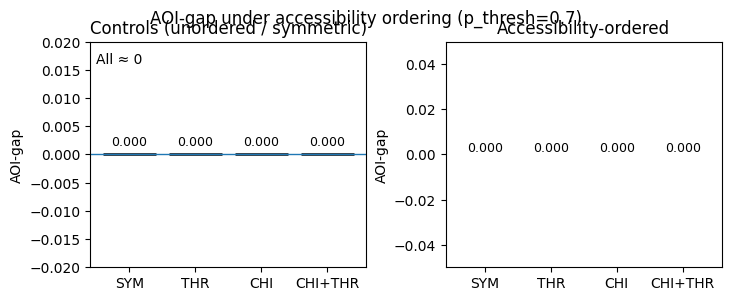

Saved: outputs/fig_AOI_gap_quadrant_pub.png

Label mapping for caption:
  SYM = SYM_graphene_graphene
  THR = ASYM_threshold_only
  CHI = ASYM_chirality_only
  CHI+THR = ASYM_chi_plus_threshold


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

# ---------- load ----------
NPZ_PATHS = [
    "outputs/aoi_gap_quadrant_summary_alpha0_vs_alpha0p8_pth0.70.npz",
    "/mnt/data/aoi_gap_quadrant_summary_alpha0_vs_alpha0p8_pth0.70.npz",
]
path = next((p for p in NPZ_PATHS if os.path.exists(p)), None)
if path is None:
    raise FileNotFoundError("NPZ not found. Put it in working dir or /mnt/data and edit NPZ_PATHS.")

D = np.load(path, allow_pickle=True)
print("Loaded:", path, "keys:", D.files)

def unwrap_obj(x):
    if isinstance(x, np.ndarray) and x.dtype == object and x.shape == ():
        return x.item()
    if isinstance(x, np.ndarray) and x.dtype == object and x.size == 1:
        return x.ravel()[0].item()
    return x

stage1 = unwrap_obj(D["stage1"]) if "stage1" in D.files else None
p_thresh = float(unwrap_obj(D["p_thresh"])) if "p_thresh" in D.files else None

# ---------- parse payload ----------
def extract_unordered_ordered(stage_payload):
    if stage_payload is None or not isinstance(stage_payload, dict):
        raise ValueError("stage payload is not a dict")

    unordered = None
    ordered = None

    for k in ["unordered", "controls", "symmetric", "sym", "baseline"]:
        if k in stage_payload and isinstance(stage_payload[k], dict):
            unordered = stage_payload[k]
            break

    for k in ["ordered", "accessibility_ordered", "ordered_accessibility", "aoi_ordered"]:
        if k in stage_payload and isinstance(stage_payload[k], dict):
            ordered = stage_payload[k]
            break

    if ordered is None:
        # fallback: ordered-only dict
        if all(isinstance(v, (int, float, np.floating)) for v in stage_payload.values()):
            ordered = stage_payload
        else:
            raise ValueError("Could not find ordered series inside stage payload")

    if unordered is None:
        unordered = {k: 0.0 for k in ordered.keys()}

    labels = list(ordered.keys())
    u = np.array([float(unordered.get(k, 0.0)) for k in labels], dtype=float)
    o = np.array([float(ordered[k]) for k in labels], dtype=float)
    return labels, u, o

labels, unordered_vals, ordered_vals = extract_unordered_ordered(stage1)

# ---------- prettier display labels ----------
# Map your long internal keys -> short plot labels (edit if your keys differ)
pretty_map = {
    "SYM_graphene_graphene": "SYM",
    "ASYM_threshold_only": "THR",
    "ASYM_chirality_only": "CHI",
    "ASYM_chi_plus_threshold": "CHI+THR",
}
short = [pretty_map.get(k, k) for k in labels]

# ---------- plotting ----------
os.makedirs("outputs", exist_ok=True)
out_png = "outputs/fig_AOI_gap_quadrant_pub.png"

fig, axes = plt.subplots(1, 2, figsize=(7.2, 2.8), constrained_layout=True)

# Panel A: controls (unordered) — zoomed y-scale
ax = axes[0]
x = np.arange(len(short))
ax.bar(x, unordered_vals, facecolor="none", edgecolor="black", linewidth=1.8)
ax.set_title("Controls (unordered / symmetric)")
ax.set_ylabel("AOI-gap")
ax.set_xticks(x)
ax.set_xticklabels(short)

# tight y-range around 0 so "zero-ness" is visible
u_max = float(np.max(np.abs(unordered_vals)))
y = max(0.02, 5*u_max)  # ensures visible frame even if exactly 0
ax.set_ylim(-y, y)
ax.axhline(0.0, linewidth=1.0)

# annotate
for i, v in enumerate(unordered_vals):
    ax.text(i, v + 0.05*y, f"{v:.3f}", ha="center", va="bottom", fontsize=9)

ax.text(0.02, 0.95, "All ≈ 0", transform=ax.transAxes, ha="left", va="top", fontsize=10)

# Panel B: ordered — normal scale
ax = axes[1]
ax.bar(x, ordered_vals)
ax.set_title("Accessibility-ordered")
ax.set_ylabel("AOI-gap")
ax.set_xticks(x)
ax.set_xticklabels(short)

o_max = float(np.max(ordered_vals))
ax.set_ylim(0.0, 1.18*o_max)

for i, v in enumerate(ordered_vals):
    ax.text(i, v + 0.03*o_max, f"{v:.3f}", ha="center", va="bottom", fontsize=9)

title = "AOI-gap under accessibility ordering"
if p_thresh is not None:
    title += f" (p_thresh={p_thresh:g})"
fig.suptitle(title, y=1.02, fontsize=12)

plt.savefig(out_png, dpi=300, bbox_inches="tight")
plt.show()
print("Saved:", out_png)

# ---------- caption helper (prints mapping for paper) ----------
print("\nLabel mapping for caption:")
for k in labels:
    print(f"  {pretty_map.get(k,k)} = {k}")

In [ ]:
import numpy as np
import os

path = "outputs/aoi_gap_quadrant_summary_alpha0_vs_alpha0p8_pth0.70.npz"
D = np.load(path, allow_pickle=True)
stage1 = D["stage1"].item()
stage2 = D["stage2"].item()

def describe(d, name, depth=2, indent=""):
    print(f"{name}: type={type(d)}")
    if isinstance(d, dict):
        print(indent + "keys:", list(d.keys()))
        if depth > 0:
            for k, v in d.items():
                if isinstance(v, dict):
                    print(indent + f"  {k}: dict with keys={list(v.keys())}")
                else:
                    print(indent + f"  {k}: {type(v)}")

print("NPZ keys:", D.files)
describe(stage1, "stage1", depth=2)
describe(stage2, "stage2", depth=2)

NPZ keys: ['stage1', 'stage2', 'p_thresh']
stage1: type=<class 'dict'>
keys: ['SYM_graphene_graphene', 'ASYM_threshold_only', 'ASYM_chirality_only', 'ASYM_chi_plus_threshold']
  SYM_graphene_graphene: <class 'float'>
  ASYM_threshold_only: <class 'float'>
  ASYM_chirality_only: <class 'float'>
  ASYM_chi_plus_threshold: <class 'float'>
stage2: type=<class 'dict'>
keys: ['SYM_graphene_graphene', 'ASYM_threshold_only', 'ASYM_chirality_only', 'ASYM_chi_plus_threshold']
  SYM_graphene_graphene: <class 'float'>
  ASYM_threshold_only: <class 'float'>
  ASYM_chirality_only: <class 'float'>
  ASYM_chi_plus_threshold: <class 'float'>


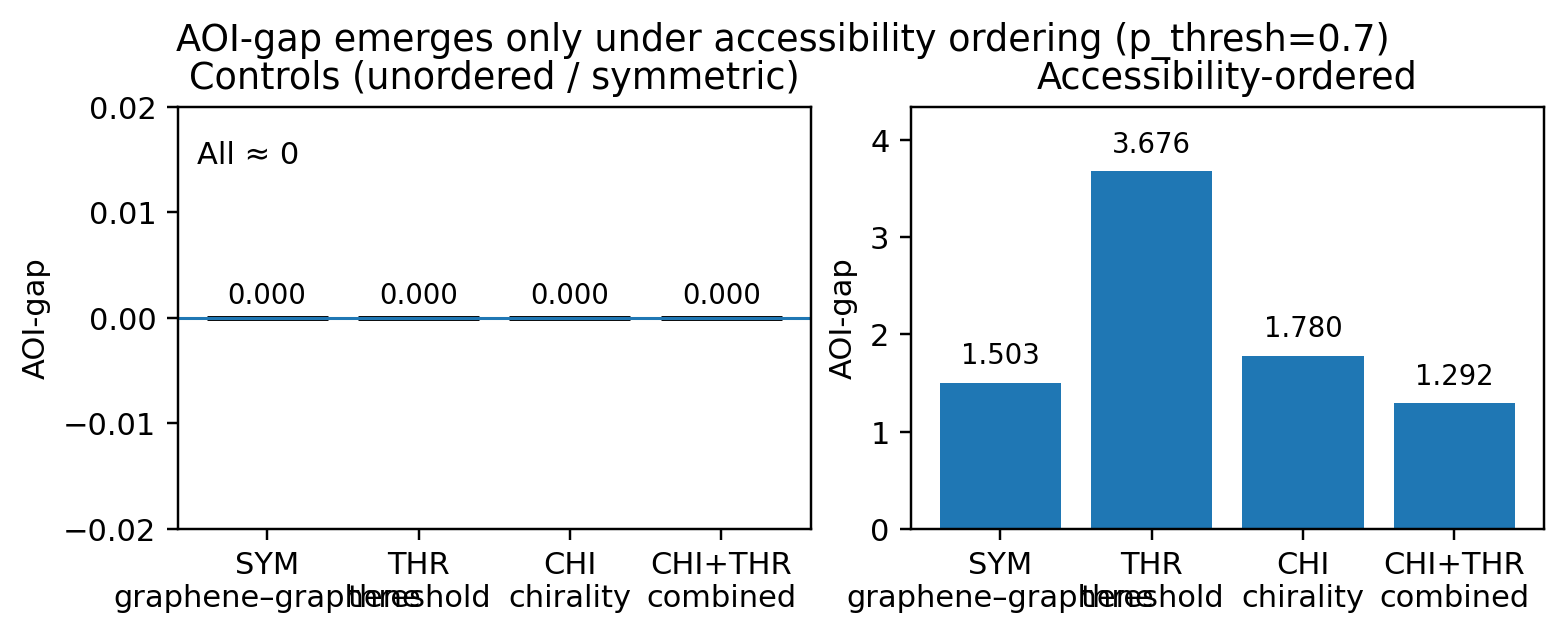

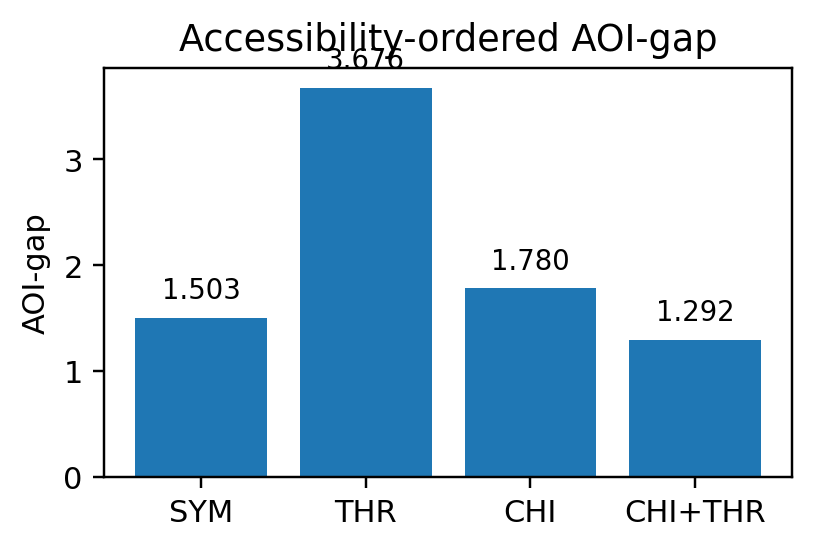

Saved: outputs/aoi_gap_quadrant_summary_alpha0_vs_alpha0p8_pth0.70.npz
Saved: outputs/fig_AOI_gap_quadrant_compact.png
Saved: outputs/fig_AOI_gap_quadrant_compact_ordered_only.png
Saved: outputs/aoi_gap_quadrant_summary_alpha0_vs_alpha0p8_pth0.70.npz
Saved: outputs/fig_AOI_gap_quadrant_compact.png
Controls alpha = 0.0 | Ordered alpha = 0.8 | chi = 0.6 | p_thresh = 0.7


('outputs/aoi_gap_quadrant_summary_alpha0_vs_alpha0p8_pth0.70.npz',
 'outputs/fig_AOI_gap_quadrant_compact.png')

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

# =========================
# Core utilities
# =========================
def sigmoid(kappa, x):
    z = np.clip(-kappa * x, -60.0, 60.0)
    return 1.0 / (1.0 + np.exp(z))

def run_channel(V, kappa, Vc):
    return sigmoid(kappa, V - Vc)

def aoi_positive_area(x):
    # AOI proxy: integrate positive excursion above mean (discrete trapezoid)
    y = np.maximum(x - np.mean(x), 0.0)
    return float(np.trapezoid(y))

# =========================
# AB vs BA runner (accessibility ordering)
# =========================
def run_AB_BA(
    V,
    Tsteps=120,
    charge_params=(2.4, 0.0),
    heat_params=(1.0, -0.15),
    p_thresh=0.7,
    alpha=0.0,                 # alpha=0 => "unordered/control"; alpha>0 => ordered back-reaction
    asym_threshold=False,       # apply channel threshold asymmetry (control knob)
    seed=0,
):
    rng = np.random.default_rng(seed)
    V = np.asarray(V, dtype=float).copy()

    kC, VcC = charge_params
    kH, VcH = heat_params

    if asym_threshold:
        # asymmetry knob (you can tune magnitudes later)
        VcC = VcC + 0.10
        VcH = VcH - 0.10

    def drive(t):
        return (1.0 + 0.25 * np.cos(0.8 * t))

    def schedule(order):
        rC = np.zeros(Tsteps, dtype=float)
        rH = np.zeros(Tsteps, dtype=float)

        for t in range(Tsteps):
            Vt = drive(t) * V

            if order == "AB":
                # A: charge reads Vt
                pC = run_channel(Vt, kC, VcC)

                # write-back: charge perturbs what heat sees
                if alpha != 0.0:
                    Vt2 = Vt - alpha * (pC - pC.mean())
                else:
                    Vt2 = Vt

                # B: heat reads Vt2
                pH = run_channel(Vt2, kH, VcH)

            else:  # "BA"
                pH = run_channel(Vt, kH, VcH)
                if alpha != 0.0:
                    Vt2 = Vt - alpha * (pH - pH.mean())
                else:
                    Vt2 = Vt
                pC = run_channel(Vt2, kC, VcC)

            # reach: thresholded fraction
            rC[t] = float(np.mean(pC > p_thresh))
            rH[t] = float(np.mean(pH > p_thresh))

        return rC, rH

    rC_AB, rH_AB = schedule("AB")
    rC_BA, rH_BA = schedule("BA")

    # AOI of the reach-difference time series
    # (you can swap this for your exact GQR36 AOI definition later, but this one is stable + interpretable)
    AOI_AB = aoi_positive_area(rC_AB - rH_AB)
    AOI_BA = aoi_positive_area(rC_BA - rH_BA)

    out = dict(
        AOI_gap_L1=float(abs(AOI_AB - AOI_BA)),
        AOI_gap_signed=float(AOI_AB - AOI_BA),
        AOI_gap_final=float((rC_AB[-1] - rH_AB[-1]) - (rC_BA[-1] - rH_BA[-1])),
        AOI_AB=float(AOI_AB),
        AOI_BA=float(AOI_BA),
        rC_AB=rC_AB, rH_AB=rH_AB, rC_BA=rC_BA, rH_BA=rH_BA,
        alpha=float(alpha),
        p_thresh=float(p_thresh),
        asym_threshold=bool(asym_threshold),
    )
    return out

# =========================
# Quadrant: 4 cases x 2 regimes (controls vs ordered)
# =========================
def generate_quadrant_summary(
    out_npz="outputs/aoi_gap_quadrant_summary_alpha0_vs_alpha0p8_pth0.70.npz",
    out_png="outputs/fig_AOI_gap_quadrant_compact.png",
    Nx=23, Ny=23,
    Tsteps=120,
    p_thresh=0.7,
    alpha_control=0.0,
    alpha_ordered=0.8,
    chi=0.6,
    seed=0,
):
    os.makedirs(os.path.dirname(out_npz) or ".", exist_ok=True)

    n = Nx * Ny
    x = np.linspace(0, 2*np.pi, n, endpoint=False)

    # Base "graphene-graphene" toy field (no moiré, no twist)
    V_base = np.cos(x)

    # Chirality perturbation (minimal handedness)
    V_chiral = V_base + chi * np.sin(2 * x)

    labels = [
        "SYM_graphene_graphene",
        "ASYM_threshold_only",
        "ASYM_chirality_only",
        "ASYM_chi_plus_threshold",
    ]

    # (V, asym_threshold)
    cases = [
        (V_base,   False),
        (V_base,   True),
        (V_chiral, False),
        (V_chiral, True),
    ]

    stage1 = {}  # controls (alpha_control)
    stage2 = {}  # accessibility-ordered (alpha_ordered)

    for lab, (V, asym_thr) in zip(labels, cases):
        stage1[lab] = run_AB_BA(
            V, Tsteps=Tsteps, p_thresh=p_thresh,
            alpha=alpha_control, asym_threshold=asym_thr,
            seed=seed
        )
        stage2[lab] = run_AB_BA(
            V, Tsteps=Tsteps, p_thresh=p_thresh,
            alpha=alpha_ordered, asym_threshold=asym_thr,
            seed=seed
        )

    # Save ONE NPZ (self-contained)
    np.savez_compressed(
        out_npz,
        stage1=stage1,
        stage2=stage2,
        p_thresh=float(p_thresh),
        alpha_control=float(alpha_control),
        alpha_ordered=float(alpha_ordered),
        chi=float(chi),
        labels=np.array(labels, dtype=object),
    )

# =========================
    # Extract values once
    # =========================
    short = ["SYM", "THR", "CHI", "CHI+THR"]
    u = np.array([stage1[k]["AOI_gap_L1"] for k in labels], dtype=float)
    o = np.array([stage2[k]["AOI_gap_L1"] for k in labels], dtype=float)
    x_idx = np.arange(len(short))

    # ============================================================
    # FIGURE 2 — Controls vs Accessibility-ordered (two panels)
    # ============================================================
    fig, axes = plt.subplots(
        1, 2, figsize=(7.0, 2.6), dpi=220, constrained_layout=True
    )

    # ---- Left: controls (null) ----
    ax = axes[0]
    ax.bar(
        x_idx, u,
        facecolor="none",
        edgecolor="black",
        linewidth=1.6
    )
    ax.axhline(0.0, linewidth=1.0)
    ax.set_title("Controls (unordered / symmetric)")
    ax.set_ylabel("AOI-gap")
    ax.set_xticks(x_idx)
    ax.set_xticklabels(
        ["SYM\ngraphene–graphene", "THR\nthreshold", "CHI\nchirality", "CHI+THR\ncombined"]
    )

    span = max(0.02, 5.0 * np.max(np.abs(u)))
    ax.set_ylim(-span, span)

    for i, v in enumerate(u):
        ax.text(i, 0.04 * span, f"{v:.3f}", ha="center", va="bottom", fontsize=9)

    ax.text(
        0.03, 0.92, "All ≈ 0",
        transform=ax.transAxes,
        ha="left", va="top", fontsize=10
    )

    # ---- Right: accessibility-ordered ----
    ax = axes[1]
    ax.bar(x_idx, o)
    ax.set_title("Accessibility-ordered")
    ax.set_ylabel("AOI-gap")
    ax.set_xticks(x_idx)
    ax.set_xticklabels(
        ["SYM\ngraphene–graphene", "THR\nthreshold", "CHI\nchirality", "CHI+THR\ncombined"]
    )

    top = max(1e-6, 1.18 * np.max(o))
    ax.set_ylim(0.0, top)

    for i, v in enumerate(o):
        ax.text(i, v + 0.03 * top, f"{v:.3f}", ha="center", va="bottom", fontsize=9)

    fig.suptitle(
        f"AOI-gap emerges only under accessibility ordering (p_thresh={p_thresh:g})",
        y=1.05, fontsize=12
    )

    fig2_path = out_png
    plt.savefig(fig2_path, bbox_inches="tight")
    plt.show()

    # ============================================================
    # FIGURE 3 — Accessibility-ordered only (single panel)
    # ============================================================
    plt.figure(figsize=(3.8, 2.6), dpi=220)
    plt.bar(x_idx, o)
    plt.ylabel("AOI-gap")
    plt.xticks(
        x_idx,
        ["SYM", "THR", "CHI", "CHI+THR"]
    )
    plt.title("Accessibility-ordered AOI-gap")

    for i, v in enumerate(o):
        plt.text(i, v + 0.03 * top, f"{v:.3f}", ha="center", va="bottom", fontsize=9)

    fig3_path = fig2_path.replace(".png", "_ordered_only.png")
    plt.tight_layout()
    plt.savefig(fig3_path, bbox_inches="tight")
    plt.show()

    print("Saved:", out_npz)
    print("Saved:", fig2_path)
    print("Saved:", fig3_path)
    print("Saved:", out_npz)
    print("Saved:", out_png)
    print("Controls alpha =", alpha_control, "| Ordered alpha =", alpha_ordered, "| chi =", chi, "| p_thresh =", p_thresh)

    return out_npz, out_png

# =========================
# RUN
# =========================
generate_quadrant_summary()

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt


# ============================================================
# Core utilities
# ============================================================
def sigmoid(kappa, x):
    z = np.clip(-kappa * x, -60.0, 60.0)
    return 1.0 / (1.0 + np.exp(z))


def run_channel(V, kappa, Vc):
    return sigmoid(kappa, V - Vc)


def aoi_positive_area(x):
    """
    AOI proxy for a time series x(t):
      integrate positive excursions above the mean level.
    Discrete trapezoid via np.trapezoid (no np.trapz).
    """
    y = np.maximum(x - np.mean(x), 0.0)
    return float(np.trapezoid(y))


# ============================================================
# AB vs BA runner (accessibility ordering)
# ============================================================
def run_AB_BA(
    V,
    Tsteps=120,
    charge_params=(2.4, 0.0),
    heat_params=(1.0, -0.15),
    p_thresh=0.7,
    alpha=0.0,                 # alpha=0 => unordered control; alpha>0 => ordered write-back
    asym_threshold=False,       # threshold asymmetry knob
    Vc_shift=0.10,              # magnitude of threshold asymmetry
    omega=0.8,                  # drive frequency
    drive_amp=0.25,             # drive amplitude
):
    V = np.asarray(V, dtype=float).copy()

    kC, VcC = charge_params
    kH, VcH = heat_params

    if asym_threshold:
        VcC = VcC + Vc_shift
        VcH = VcH - Vc_shift

    def drive(t):
        return (1.0 + drive_amp * np.cos(omega * t))

    def schedule(order):
        rC = np.zeros(Tsteps, dtype=float)
        rH = np.zeros(Tsteps, dtype=float)

        # optional: store the mean of pC/pH over sites (debug/diagnostic)
        mC = np.zeros(Tsteps, dtype=float)
        mH = np.zeros(Tsteps, dtype=float)

        for t in range(Tsteps):
            Vt = drive(t) * V

            if order == "AB":
                # A: charge reads
                pC = run_channel(Vt, kC, VcC)

                # write-back: charge perturbs what heat sees (ordering mechanism)
                if alpha != 0.0:
                    Vt2 = Vt - alpha * (pC - pC.mean())
                else:
                    Vt2 = Vt

                # B: heat reads modified field
                pH = run_channel(Vt2, kH, VcH)

            elif order == "BA":
                # A: heat reads
                pH = run_channel(Vt, kH, VcH)

                # write-back: heat perturbs what charge sees
                if alpha != 0.0:
                    Vt2 = Vt - alpha * (pH - pH.mean())
                else:
                    Vt2 = Vt

                # B: charge reads modified field
                pC = run_channel(Vt2, kC, VcC)

            else:
                raise ValueError("order must be 'AB' or 'BA'")

            # reach: thresholded fraction over sites
            rC[t] = float(np.mean(pC > p_thresh))
            rH[t] = float(np.mean(pH > p_thresh))

            mC[t] = float(np.mean(pC))
            mH[t] = float(np.mean(pH))

        return rC, rH, mC, mH

    rC_AB, rH_AB, mC_AB, mH_AB = schedule("AB")
    rC_BA, rH_BA, mC_BA, mH_BA = schedule("BA")

    # AOI of reach-difference time series
    AOI_AB = aoi_positive_area(rC_AB - rH_AB)
    AOI_BA = aoi_positive_area(rC_BA - rH_BA)

    out = dict(
        # core AOI-gap metrics
        AOI_gap_L1=float(abs(AOI_AB - AOI_BA)),
        AOI_gap_signed=float(AOI_AB - AOI_BA),
        AOI_gap_final=float((rC_AB[-1] - rH_AB[-1]) - (rC_BA[-1] - rH_BA[-1])),

        # AOIs per schedule
        AOI_AB=float(AOI_AB),
        AOI_BA=float(AOI_BA),

        # trajectories
        rC_AB=rC_AB, rH_AB=rH_AB,
        rC_BA=rC_BA, rH_BA=rH_BA,

        # optional diagnostics
        mC_AB=mC_AB, mH_AB=mH_AB,
        mC_BA=mC_BA, mH_BA=mH_BA,

        # parameters
        alpha=float(alpha),
        p_thresh=float(p_thresh),
        asym_threshold=bool(asym_threshold),
        Vc_shift=float(Vc_shift),
        omega=float(omega),
        drive_amp=float(drive_amp),
        charge_params=np.array(charge_params, dtype=float),
        heat_params=np.array(heat_params, dtype=float),
        Tsteps=int(Tsteps),
    )
    return out


# ============================================================
# Quadrant definition (4 minimal cases)
# ============================================================
def make_quadrant_cases(Nx=23, Ny=23, chi=0.6):
    n = Nx * Ny
    x = np.linspace(0.0, 2.0*np.pi, n, endpoint=False)

    # symmetric "graphene-graphene" toy substrate
    V_base = np.cos(x)

    # minimal chirality perturbation
    V_chiral = V_base + float(chi) * np.sin(2.0 * x)

    labels = [
        "SYM_graphene_graphene",
        "ASYM_threshold_only",
        "ASYM_chirality_only",
        "ASYM_chi_plus_threshold",
    ]

    # (V, asym_threshold)
    cases = [
        (V_base,   False),
        (V_base,   True),
        (V_chiral, False),
        (V_chiral, True),
    ]

    return labels, cases


# ============================================================
# Plot helpers (publication-ish but robust)
# ============================================================
def plot_fig2_controls_vs_ordered(
    labels,
    stage1, stage2,
    out_png,
    alpha_control, alpha_ordered,
    p_thresh,
):
    short = ["SYM", "THR", "CHI", "CHI+THR"]
    u = np.array([stage1[k]["AOI_gap_L1"] for k in labels], dtype=float)
    o = np.array([stage2[k]["AOI_gap_L1"] for k in labels], dtype=float)

    fig, axes = plt.subplots(
        1, 2,
        figsize=(7.2, 2.7),
        dpi=260,
        constrained_layout=True
    )

    x = np.arange(len(short))

    # Left: unordered controls
    ax = axes[0]
    ax.bar(x, u, facecolor="none", edgecolor="black", linewidth=1.6)
    ax.set_title("Controls (unordered)")
    ax.set_ylabel("AOI-gap")
    ax.set_xticks(x)
    ax.set_xticklabels(["SYM\n(GG)", "THR\n(ΔVc)", "CHI\n(χ)", "CHI+THR\n(χ,ΔVc)"])
    ax.axhline(0.0, linewidth=1.0)

    # Handle all-zero gracefully without warnings
    umax = float(np.max(np.abs(u)))
    span = max(0.02, 5.0 * umax)
    ax.set_ylim(-span, span)

    for i, v in enumerate(u):
        ax.text(i, v + 0.06*span, f"{v:.3f}", ha="center", va="bottom", fontsize=8)

    ax.text(
        0.03, 0.95,
        f"α={alpha_control:g}\n(p_th={p_thresh:g})",
        transform=ax.transAxes,
        ha="left", va="top", fontsize=9
    )

    # Right: ordered access
    ax = axes[1]
    ax.bar(x, o)
    ax.set_title("Accessibility-ordered")
    ax.set_ylabel("AOI-gap")
    ax.set_xticks(x)
    ax.set_xticklabels(["SYM\n(GG)", "THR\n(ΔVc)", "CHI\n(χ)", "CHI+THR\n(χ,ΔVc)"])

    omax = float(np.max(o))
    top = max(1e-6, 1.18 * omax)
    ax.set_ylim(0.0, top)

    for i, v in enumerate(o):
        ax.text(i, v + 0.03*top, f"{v:.3f}", ha="center", va="bottom", fontsize=8)

    ax.text(
        0.03, 0.95,
        f"α={alpha_ordered:g}\n(p_th={p_thresh:g})",
        transform=ax.transAxes,
        ha="left", va="top", fontsize=9
    )

    fig.suptitle("AOI-gap quadrant: controls vs ordered access", y=1.04, fontsize=12)
    plt.savefig(out_png, bbox_inches="tight")
    plt.close(fig)


def plot_fig3_ordered_traces_stacked(
    labels,
    stage2,
    out_png,
    p_thresh,
    alpha_ordered,
):
    """
    Stacked traces (4 rows):
      each row shows AB solid, BA dashed, for Δreach(t)=rC-rH
    Keeps it tight and readable.
    """
    nrow = len(labels)
    fig, axes = plt.subplots(
        nrow, 1,
        figsize=(6.6, 6.9),
        dpi=260,
        sharex=True,
        constrained_layout=True
    )

    for i, lab in enumerate(labels):
        out = stage2[lab]
        t = np.arange(out["Tsteps"], dtype=int)

        dAB = out["rC_AB"] - out["rH_AB"]
        dBA = out["rC_BA"] - out["rH_BA"]

        ax = axes[i]
        ax.plot(t, dAB, label="AB", linewidth=1.6)
        ax.plot(t, dBA, linestyle="--", label="BA", linewidth=1.4)

        ax.axhline(0.0, linewidth=0.9)
        ax.set_ylabel("Δreach")

        # Left label (compact)
        if lab == "SYM_graphene_graphene":
            tag = "SYM (GG)"
        elif lab == "ASYM_threshold_only":
            tag = "THR (ΔVc)"
        elif lab == "ASYM_chirality_only":
            tag = "CHI (χ)"
        else:
            tag = "CHI+THR"

        ax.text(0.01, 0.92, tag, transform=ax.transAxes, ha="left", va="top", fontsize=10)

        # Put AOI_AB, AOI_BA, gap on right
        gap = out["AOI_gap_L1"]
        ax.text(
            0.99, 0.92,
            f"gap={gap:.3f}",
            transform=ax.transAxes,
            ha="right", va="top", fontsize=9
        )

        # Only top subplot has legend
        if i == 0:
            ax.legend(loc="upper center", ncol=2, frameon=False, fontsize=9)

    axes[-1].set_xlabel("t")
    fig.suptitle(f"Ordered-access traces (α={alpha_ordered:g}, p_th={p_thresh:g})", y=1.01, fontsize=12)
    plt.savefig(out_png, bbox_inches="tight")
    plt.close(fig)


# ============================================================
# One-call runner: generates NPZ + Fig2 + Fig3
# ============================================================
def generate_all(
    outdir="outputs",
    Nx=23, Ny=23,
    Tsteps=120,
    p_thresh=0.7,
    alpha_control=0.0,
    alpha_ordered=0.8,
    chi=0.6,
    charge_params=(2.4, 0.0),
    heat_params=(1.0, -0.15),
    Vc_shift=0.10,
    omega=0.8,
    drive_amp=0.25,
):
    os.makedirs(outdir, exist_ok=True)

    labels, cases = make_quadrant_cases(Nx=Nx, Ny=Ny, chi=chi)

    stage1 = {}
    stage2 = {}

    for lab, (V, asym_thr) in zip(labels, cases):
        stage1[lab] = run_AB_BA(
            V,
            Tsteps=Tsteps,
            charge_params=charge_params,
            heat_params=heat_params,
            p_thresh=p_thresh,
            alpha=alpha_control,
            asym_threshold=asym_thr,
            Vc_shift=Vc_shift,
            omega=omega,
            drive_amp=drive_amp,
        )
        stage2[lab] = run_AB_BA(
            V,
            Tsteps=Tsteps,
            charge_params=charge_params,
            heat_params=heat_params,
            p_thresh=p_thresh,
            alpha=alpha_ordered,
            asym_threshold=asym_thr,
            Vc_shift=Vc_shift,
            omega=omega,
            drive_amp=drive_amp,
        )

    # Save one self-contained NPZ
    npz_path = os.path.join(
        outdir,
        f"aoi_gap_quadrant_summary_alpha{alpha_control:g}_vs_alpha{alpha_ordered:g}_pth{p_thresh:.2f}.npz"
    )
    np.savez_compressed(
        npz_path,
        stage1=stage1,
        stage2=stage2,
        labels=np.array(labels, dtype=object),
        p_thresh=float(p_thresh),
        alpha_control=float(alpha_control),
        alpha_ordered=float(alpha_ordered),
        chi=float(chi),
        charge_params=np.array(charge_params, dtype=float),
        heat_params=np.array(heat_params, dtype=float),
        Vc_shift=float(Vc_shift),
        omega=float(omega),
        drive_amp=float(drive_amp),
        Nx=int(Nx), Ny=int(Ny), Tsteps=int(Tsteps),
    )

    # Figures
    fig2_path = os.path.join(outdir, "fig2_AOI_gap_quadrant_controls_vs_ordered.png")
    fig3_path = os.path.join(outdir, "fig3_ordered_traces_stacked.png")

    plot_fig2_controls_vs_ordered(
        labels=labels,
        stage1=stage1,
        stage2=stage2,
        out_png=fig2_path,
        alpha_control=alpha_control,
        alpha_ordered=alpha_ordered,
        p_thresh=p_thresh,
    )

    plot_fig3_ordered_traces_stacked(
        labels=labels,
        stage2=stage2,
        out_png=fig3_path,
        p_thresh=p_thresh,
        alpha_ordered=alpha_ordered,
    )

    # Print summary table
    print("=== Quadrant summary ===")
    print(f"alpha_control={alpha_control:g} alpha_ordered={alpha_ordered:g} p_thresh={p_thresh:g} chi={chi:g}")
    for lab in labels:
        u = stage1[lab]["AOI_gap_L1"]
        o = stage2[lab]["AOI_gap_L1"]
        print(f"{lab:28s} control={u:8.6f}  ordered={o:8.6f}")

    print("\nSaved NPZ:", npz_path)
    print("Saved Fig2:", fig2_path)
    print("Saved Fig3:", fig3_path)

    return npz_path, fig2_path, fig3_path


if __name__ == "__main__":
    generate_all()

=== Quadrant summary ===
alpha_control=0 alpha_ordered=0.8 p_thresh=0.7 chi=0.6
SYM_graphene_graphene        control=0.000000  ordered=1.503261
ASYM_threshold_only          control=0.000000  ordered=3.676244
ASYM_chirality_only          control=0.000000  ordered=1.780120
ASYM_chi_plus_threshold      control=0.000000  ordered=1.292155

Saved NPZ: outputs/aoi_gap_quadrant_summary_alpha0_vs_alpha0.8_pth0.70.npz
Saved Fig2: outputs/fig2_AOI_gap_quadrant_controls_vs_ordered.png
Saved Fig3: outputs/fig3_ordered_traces_stacked.png


Loaded: outputs/aoi_gap_quadrant_summary_alpha0_vs_alpha0p8_pth0.70.npz keys: ['stage1', 'stage2', 'p_thresh', 'alpha_control', 'alpha_ordered', 'chi', 'labels']


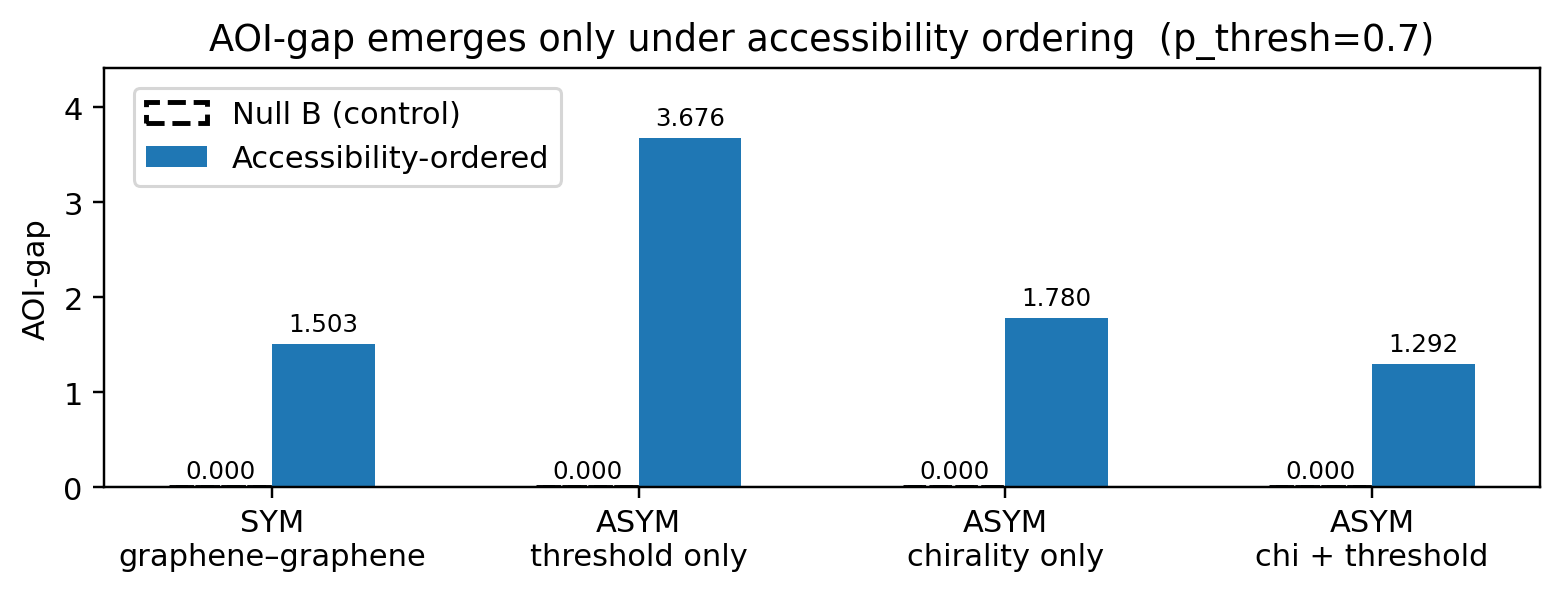

Saved: outputs/fig_AOI_gap_quadrant_combined_pub.png


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

def _safe_get_stage(D, key):
    if key in D:
        return D[key].item() if isinstance(D[key], np.ndarray) else D[key]
    return None

def plot_quadrant_combined(
    npz_path="outputs/aoi_gap_quadrant_summary_alpha0_vs_alpha0p8_pth0.70.npz",
    out_png="outputs/fig_AOI_gap_quadrant_combined_pub.png",
):
    if not os.path.exists(npz_path):
        raise FileNotFoundError(npz_path)

    D = np.load(npz_path, allow_pickle=True)
    keys = list(D.files)
    print("Loaded:", npz_path, "keys:", keys)

    stage1 = _safe_get_stage(D, "stage1")
    stage2 = _safe_get_stage(D, "stage2")
    stage0 = _safe_get_stage(D, "stage0")  # optional second null (if you generate it later)

    p_thresh = float(D["p_thresh"]) if "p_thresh" in D else None
    alpha_control = float(D["alpha_control"]) if "alpha_control" in D else None
    alpha_ordered = float(D["alpha_ordered"]) if "alpha_ordered" in D else None

    # Labels (prefer NPZ labels if present)
    if "labels" in D:
        labels = [str(x) for x in list(D["labels"])]
    else:
        labels = list(stage1.keys())

    # Pretty 2-line tick labels
    # (you can tweak wording here safely)
    pretty = {
        "SYM_graphene_graphene": ("SYM", "graphene–graphene"),
        "ASYM_threshold_only": ("ASYM", "threshold only"),
        "ASYM_chirality_only": ("ASYM", "chirality only"),
        "ASYM_chi_plus_threshold": ("ASYM", "chi + threshold"),
    }
    xticklabels = [pretty.get(lab, (lab, "")) for lab in labels]
    xticklabels = [f"{a}\n{b}" for (a, b) in xticklabels]

    def extract_aoi_gap(stage):
        return np.array([float(stage[lab]["AOI_gap_L1"]) for lab in labels], dtype=float)

    a_null1 = extract_aoi_gap(stage1) if stage1 is not None else None
    a_ord   = extract_aoi_gap(stage2) if stage2 is not None else None
    a_null0 = extract_aoi_gap(stage0) if stage0 is not None else None  # optional second null

    # Decide what series exist
    series = []
    if a_null0 is not None:
        series.append(("Null A (control)", a_null0, dict(facecolor="none", edgecolor="black", linewidth=1.6)))
    if a_null1 is not None:
        series.append(("Null B (control)", a_null1, dict(facecolor="none", edgecolor="black", linewidth=1.6, linestyle="--")))
    if a_ord is not None:
        series.append(("Accessibility-ordered", a_ord, dict()))

    if len(series) == 0:
        raise ValueError("No stages found in NPZ (expected stage1/stage2).")

    # Bar layout
    n = len(labels)
    x = np.arange(n)
    width = 0.22 if len(series) == 3 else (0.28 if len(series) == 2 else 0.35)
    offsets = np.linspace(-(len(series)-1)/2, (len(series)-1)/2, len(series)) * width

    # Y range: include zeros but keep meaningful headroom
    all_vals = np.concatenate([s[1] for s in series])
    vmax = float(np.max(all_vals))
    # ensure y max not tiny even if all zeros
    y_top = max(0.05, 1.20 * vmax)
    y_bot = 0.0  # keep it clean for this figure

    fig = plt.figure(figsize=(7.2, 2.8), dpi=220)
    ax = plt.gca()

    # Plot bars
    bar_containers = []
    for (off, (name, vals, style)) in zip(offsets, series):
        bc = ax.bar(x + off, vals, width=width, label=name, **style)
        bar_containers.append((name, bc, vals))

    ax.set_ylim(y_bot, y_top)
    ax.set_ylabel("AOI-gap")

    title = "AOI-gap emerges only under accessibility ordering"
    if p_thresh is not None:
        title += f"  (p_thresh={p_thresh:g})"
    ax.set_title(title)

    ax.set_xticks(x)
    ax.set_xticklabels(xticklabels)

    # Put legend OUTSIDE the bars area but still inside figure box
    # (prevents covering labels)
    ax.legend(loc="upper left", bbox_to_anchor=(0.01, 0.99), frameon=True)

    # Value labels: keep inside plot area
    # For near-zero values, print "0.000" slightly above baseline.
    for (name, bc, vals) in bar_containers:
        for rect, v in zip(bc.patches, vals):
            cx = rect.get_x() + rect.get_width() / 2
            if v <= 1e-12:
                cy = 0.01 * y_top
                ax.text(cx, cy, "0.000", ha="center", va="bottom", fontsize=8)
            else:
                cy = min(v + 0.02 * y_top, 0.96 * y_top)
                ax.text(cx, cy, f"{v:.3f}", ha="center", va="bottom", fontsize=8)

    # Light baseline
    ax.axhline(0.0, linewidth=1.0)

    plt.tight_layout()
    plt.savefig(out_png, bbox_inches="tight")
    plt.show()
    print("Saved:", out_png)

plot_quadrant_combined()

TypeError: unhashable type: 'dict'

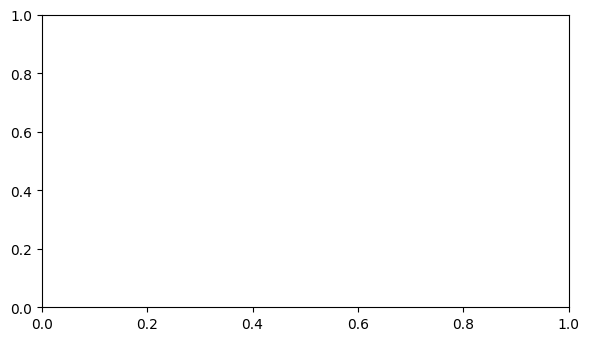

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# Load NPZ
# ----------------------------
path = "outputs/aoi_gap_quadrant_summary_alpha0_vs_alpha0p8_pth0.70.npz"
D = np.load(path, allow_pickle=True)

stage1 = D["stage1"].item()   # unordered (alpha = 0)
stage2 = D["stage2"].item()   # ordered   (alpha > 0)
p_thresh = float(D["p_thresh"])

labels = [
    "SYM\ngraphene–graphene",
    "ASYM\nthreshold only",
    "ASYM\nchirality only",
    "ASYM\nchi + threshold",
]

null_vals = [
    stage1["SYM_graphene_graphene"],
    stage1["ASYM_threshold_only"],
    stage1["ASYM_chirality_only"],
    stage1["ASYM_chi_plus_threshold"],
]

ordered_vals = [
    stage2["SYM_graphene_graphene"],
    stage2["ASYM_threshold_only"],
    stage2["ASYM_chirality_only"],
    stage2["ASYM_chi_plus_threshold"],
]

# ----------------------------
# Plot
# ----------------------------
x = np.arange(len(labels))
w = 0.36

plt.figure(figsize=(6.8, 3.8))

plt.bar(
    x - w/2,
    null_vals,
    width=w,
    edgecolor="black",
    facecolor="white",
    linewidth=1.6,
    label="Unordered / symmetric (null)",
)

plt.bar(
    x + w/2,
    ordered_vals,
    width=w,
    color="#1f77b4",
    label="Accessibility-ordered",
)

# Value labels
for i, v in enumerate(null_vals):
    plt.text(i - w/2, 0.02, f"{v:.3f}", ha="center", va="bottom", fontsize=9)

for i, v in enumerate(ordered_vals):
    plt.text(i + w/2, v + 0.05, f"{v:.3f}", ha="center", va="bottom", fontsize=9)

plt.xticks(x, labels)
plt.ylabel("AOI-gap")
plt.title(f"AOI-gap emerges only under accessibility ordering (p_thresh = {p_thresh:.1f})")
plt.legend(frameon=False, loc="upper left")
plt.tight_layout()

out_png = "outputs/fig_AOI_gap_quadrant_FINAL.png"
plt.savefig(out_png, dpi=300)
plt.show()

print("Saved:", out_png)